In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Lower_Camp_outlier_2015_realRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc1
# df1 =pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Lower_Camp_outlier_2012_borrowedRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc2

In [ ]:
df1.columns

Index(['H2S (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'SO2 (ppb)', 'THC (ppm)', 'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w.columns

Index(['H2S (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'SO2 (ppb)', 'THC (ppm)', 'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score', 'sin', 'cos'],
      dtype='object')

In [ ]:
df1_w= df1_w[[
              'SO2 (ppb)', #'THC (ppm)','H2S (ppb)', 
              'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed',  'Wind Direction',
       'Wind Speed', 'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol',
       'hour', 'dayofweek_num', 'Day-year', 'trend', 'score' ]].copy()


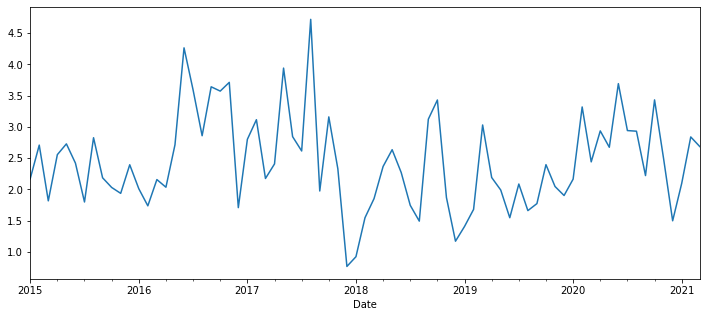

In [ ]:
df1_w['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 2*std])/len(df1_w)

0.9697808044264737

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 1000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 1000.0),
        "score" : trial.suggest_float( 'score', avg + 1.5*std, avg + 7 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 1000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 1000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

        K = 5
        kf = KFold(n_splits=K)
        acc = 0 
        for train_index, test_index in kf.split( X_train):   
                X_tr, X_tes =  X_train[train_index],  X_train[test_index]
                y_tr, y_tes =  y_train[train_index],  y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/K
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=5000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_lowercamp_OT_SO2_2015_real_RH_HP_hourly.csv')

[I 2021-05-15 20:14:04,806] A new study created in memory with name: no-name-f81b29ce-04e7-442e-af15-a508a16bc2c0


[0]	validation-rmse:5.49669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.37568
[2]	validation-rmse:5.2707
[3]	validation-rmse:5.18786
[4]	validation-rmse:5.11706
[5]	validation-rmse:5.06438
[6]	validation-rmse:5.02369
[7]	validation-rmse:4.99246
[8]	validation-rmse:4.95964
[9]	validation-rmse:4.91931
[0]	validation-rmse:5.58367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46892
[2]	validation-rmse:5.37488
[3]	validation-rmse:5.30081
[4]	validation-rmse:5.24018
[5]	validation-rmse:5.19123
[6]	validation-rmse:5.14729
[7]	validation-rmse:5.10842
[8]	validation-rmse:5.07965
[9]	validation-rmse:5.05033
[0]	validation-rmse:6.20409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.0741
[2]	validation-rmse:5.96454
[3]	validation-rmse:5.88132
[4]	validation-rmse:5.80897
[5]	validation-rmse:5.75671
[6]	validation-rmse:5.70882
[7]	validation-rmse:5.66118
[8]	validation-rmse:5.62818
[

[I 2021-05-15 20:14:07,826] Trial 0 finished with value: 22.61975227128856 and parameters: {'booster': 'gbtree', 'lambda': 717.1265723445701, 'alpha': 0.2577113258693697, 'score': 17.125238403878523, 'max_depth': 10, 'eta': 0.17778003607086865, 'gamma': 2.2967553885628886, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 22.61975227128856.


22.61975227128856
[0]	validation-rmse:34.2254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:366.035
[2]	validation-rmse:4022.27
[3]	validation-rmse:44078.7
[4]	validation-rmse:485691
[5]	validation-rmse:5.35105e+06
[6]	validation-rmse:5.88204e+07
[7]	validation-rmse:6.46814e+08
[8]	validation-rmse:7.13319e+09
[9]	validation-rmse:7.86496e+10
[0]	validation-rmse:32.6517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:351.775
[2]	validation-rmse:3867.74
[3]	validation-rmse:42576
[4]	validation-rmse:468863
[5]	validation-rmse:5.17317e+06
[6]	validation-rmse:5.61992e+07
[7]	validation-rmse:6.20819e+08
[8]	validation-rmse:6.86084e+09
[9]	validation-rmse:7.582e+10
[0]	validation-rmse:35.8502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:390.408
[2]	validation-rmse:4303.22
[3]	validation-rmse:47467.7
[4]	validation-rmse:519769
[5]	validation-rmse:5.74024e+06
[6]	validation-rmse:6.34013e

[I 2021-05-15 20:14:09,390] Trial 1 finished with value: 5.407810484842171e+21 and parameters: {'booster': 'gbtree', 'lambda': 3.3260691128661093, 'alpha': 31.564344931350767, 'score': 17.23027765424778, 'max_depth': 6, 'eta': 12.170662324023816, 'gamma': 192.16594677038898, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 22.61975227128856.


[0]	validation-rmse:5.7175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.60215
[2]	validation-rmse:5.54563
[3]	validation-rmse:5.52644
[4]	validation-rmse:5.51797
[5]	validation-rmse:5.51402
[6]	validation-rmse:5.51207
[7]	validation-rmse:5.51105
[8]	validation-rmse:5.51049
[9]	validation-rmse:5.51018
[0]	validation-rmse:5.40353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.30095
[2]	validation-rmse:5.27032
[3]	validation-rmse:5.25746
[4]	validation-rmse:5.25182
[5]	validation-rmse:5.24921
[6]	validation-rmse:5.24794
[7]	validation-rmse:5.24728
[8]	validation-rmse:5.24692
[9]	validation-rmse:5.24671
[0]	validation-rmse:5.70759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.58563
[2]	validation-rmse:5.54805
[3]	validation-rmse:5.51218
[4]	validation-rmse:5.50599
[5]	validation-rmse:5.50332
[6]	validation-rmse:5.50211
[7]	validation-rmse:5.50152
[8]	validation-rmse:5.50122


[I 2021-05-15 20:14:10,075] Trial 2 finished with value: 25.913240329965994 and parameters: {'booster': 'gbtree', 'lambda': 56.80327793408926, 'alpha': 5387.999834160903, 'score': 19.994353929067934, 'max_depth': 2, 'eta': 0.38587636994484376, 'gamma': 7334.407591961813, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 22.61975227128856.


25.913240329965994
[0]	validation-rmse:31.6381
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:271.604
[2]	validation-rmse:2420.01
[3]	validation-rmse:21402.4
[4]	validation-rmse:189927
[5]	validation-rmse:1.72414e+06
[6]	validation-rmse:1.57166e+07
[7]	validation-rmse:1.43349e+08
[8]	validation-rmse:1.30607e+09
[9]	validation-rmse:1.1961e+10
[0]	validation-rmse:29.7342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:257.965
[2]	validation-rmse:2339.25
[3]	validation-rmse:21159
[4]	validation-rmse:193165
[5]	validation-rmse:1.76958e+06
[6]	validation-rmse:1.62302e+07
[7]	validation-rmse:1.48957e+08
[8]	validation-rmse:1.36784e+09
[9]	validation-rmse:1.25506e+10
[0]	validation-rmse:34.0827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:294.869
[2]	validation-rmse:2656.2
[3]	validation-rmse:23968.8
[4]	validation-rmse:217603
[5]	validation-rmse:1.97547e+06
[6]	validation-rmse:1.79701

[I 2021-05-15 20:14:11,972] Trial 3 finished with value: 1.2140341717548422e+20 and parameters: {'booster': 'gbtree', 'lambda': 6.071128642174368, 'alpha': 1.2502981990947424, 'score': 17.316435257469553, 'max_depth': 7, 'eta': 10.369449268505413, 'gamma': 8.00704036405511, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 22.61975227128856.


1.2140341717548422e+20
[0]	validation-rmse:5.18987
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.07363
[2]	validation-rmse:4.93485
[3]	validation-rmse:4.89191
[4]	validation-rmse:4.81618
[5]	validation-rmse:4.76552
[6]	validation-rmse:4.73538
[7]	validation-rmse:4.70116
[8]	validation-rmse:4.67758
[9]	validation-rmse:4.66208
[0]	validation-rmse:5.05521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.94424
[2]	validation-rmse:4.82782
[3]	validation-rmse:4.75596
[4]	validation-rmse:4.70567
[5]	validation-rmse:4.68201
[6]	validation-rmse:4.66863
[7]	validation-rmse:4.64015
[8]	validation-rmse:4.61856
[9]	validation-rmse:4.61416
[0]	validation-rmse:5.40754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.29798
[2]	validation-rmse:5.14255
[3]	validation-rmse:5.05305
[4]	validation-rmse:4.98685
[5]	validation-rmse:4.95037
[6]	validation-rmse:4.90671
[7]	validation-rmse:4.88091
[8]	

[I 2021-05-15 20:14:13,963] Trial 4 finished with value: 21.06094371032875 and parameters: {'booster': 'gbtree', 'lambda': 3925.444631782676, 'alpha': 1.1586596267115479, 'score': 16.113943369206805, 'max_depth': 7, 'eta': 1.1957480358994734, 'gamma': 19.537993059653736, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 21.06094371032875.


21.06094371032875


[I 2021-05-15 20:14:14,030] Trial 5 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:14,115] Trial 6 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:14,184] Trial 7 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.58807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49043
[2]	validation-rmse:5.43412
[3]	validation-rmse:5.39195
[4]	validation-rmse:5.36164
[5]	validation-rmse:5.32147
[6]	validation-rmse:5.30246
[7]	validation-rmse:5.2744
[8]	validation-rmse:5.24822
[9]	validation-rmse:5.23745
[0]	validation-rmse:5.62772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53287
[2]	validation-rmse:5.46904
[3]	validation-rmse:5.41876
[4]	validation-rmse:5.38595
[5]	validation-rmse:5.36153
[6]	validation-rmse:5.33998
[7]	validation-rmse:5.31399
[8]	validation-rmse:5.29937
[9]	validation-rmse:5.28677
[0]	validation-rmse:6.30309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.19706
[2]	validation-rmse:6.12516
[3]	validation-rmse:6.07902
[4]	validation-rmse:6.04247
[5]	validation-rmse:6.00309
[6]	validation-rmse:5.97904
[7]	validation-rmse:5.95936
[8]	validation-rmse:5.93462


[I 2021-05-15 20:14:14,931] Trial 8 finished with value: 25.679846739749095 and parameters: {'booster': 'gbtree', 'lambda': 9550.971322783853, 'alpha': 0.218232351966021, 'score': 20.65793285546935, 'max_depth': 2, 'eta': 0.3852828095959316, 'gamma': 1.3766103629898012, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 21.06094371032875.
[I 2021-05-15 20:14:15,014] Trial 9 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:15,122] Trial 10 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.48743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41155
[2]	validation-rmse:5.34333
[3]	validation-rmse:5.2833
[4]	validation-rmse:5.23065
[5]	validation-rmse:5.18332
[6]	validation-rmse:5.14214
[7]	validation-rmse:5.10184
[8]	validation-rmse:5.06608
[9]	validation-rmse:5.03899
[0]	validation-rmse:5.53434
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46218
[2]	validation-rmse:5.40134
[3]	validation-rmse:5.3478
[4]	validation-rmse:5.29989
[5]	validation-rmse:5.25628
[6]	validation-rmse:5.21682
[7]	validation-rmse:5.18275
[8]	validation-rmse:5.15109
[9]	validation-rmse:5.12304
[0]	validation-rmse:6.12574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.04693
[2]	validation-rmse:5.97811
[3]	validation-rmse:5.91635
[4]	validation-rmse:5.86245
[5]	validation-rmse:5.81368
[6]	validation-rmse:5.76968
[7]	validation-rmse:5.73074
[8]	validation-rmse:5.69611
[

[I 2021-05-15 20:14:18,145] Trial 11 finished with value: 22.96819819148235 and parameters: {'booster': 'gbtree', 'lambda': 1303.0424887820448, 'alpha': 0.2129228985037229, 'score': 15.545451202499791, 'max_depth': 10, 'eta': 0.11380364076866115, 'gamma': 16.941984891653153, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 21.06094371032875.


22.96819819148235
[0]	validation-rmse:5.47442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.29262
[2]	validation-rmse:5.14477
[3]	validation-rmse:5.07349
[4]	validation-rmse:5.01438
[5]	validation-rmse:4.97428
[6]	validation-rmse:4.93317
[7]	validation-rmse:4.90014
[8]	validation-rmse:4.87249
[9]	validation-rmse:4.84578
[0]	validation-rmse:5.12424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98156
[2]	validation-rmse:4.79134
[3]	validation-rmse:4.70833
[4]	validation-rmse:4.67126
[5]	validation-rmse:4.61809
[6]	validation-rmse:4.58241
[7]	validation-rmse:4.5446
[8]	validation-rmse:4.52232
[9]	validation-rmse:4.50977
[0]	validation-rmse:5.43487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.24753
[2]	validation-rmse:5.06554
[3]	validation-rmse:5.01056
[4]	validation-rmse:4.93818
[5]	validation-rmse:4.89649
[6]	validation-rmse:4.84717
[7]	validation-rmse:4.81088
[8]	valida

[I 2021-05-15 20:14:20,535] Trial 12 finished with value: 21.272588272555403 and parameters: {'booster': 'gbtree', 'lambda': 1941.143259491492, 'alpha': 1.3278596208350475, 'score': 18.630362678575313, 'max_depth': 8, 'eta': 1.4078313322591787, 'gamma': 0.19013450009547786, 'grow_policy': 'depthwise'}. Best is trial 4 with value: 21.06094371032875.


21.272588272555403


[I 2021-05-15 20:14:20,650] Trial 13 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:20,756] Trial 14 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:20,870] Trial 15 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.36339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0949
[2]	validation-rmse:5.03469
[3]	validation-rmse:4.9877
[4]	validation-rmse:4.92293
[5]	validation-rmse:4.87096
[6]	validation-rmse:4.83514
[7]	validation-rmse:4.79732
[8]	validation-rmse:4.78052
[9]	validation-rmse:4.76226
[0]	validation-rmse:5.29096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.23277
[2]	validation-rmse:5.20155
[3]	validation-rmse:5.18771
[4]	validation-rmse:5.16215
[5]	validation-rmse:5.13125
[6]	validation-rmse:5.12764
[7]	validation-rmse:5.02758
[8]	validation-rmse:4.95627
[9]	validation-rmse:4.93717
[0]	validation-rmse:5.76075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.70051
[2]	validation-rmse:5.54596
[3]	validation-rmse:5.52766
[4]	validation-rmse:5.44895
[5]	validation-rmse:5.39006
[6]	validation-rmse:5.33047
[7]	validation-rmse:5.30526
[8]	validation-rmse:5.26055
[

[I 2021-05-15 20:14:22,549] Trial 16 finished with value: 20.89006539682502 and parameters: {'booster': 'gbtree', 'lambda': 584.4861041774502, 'alpha': 8.718835125563553, 'score': 15.507434268297317, 'max_depth': 6, 'eta': 2.081609257229521, 'gamma': 106.84552216286285, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 20.89006539682502.


20.89006539682502


[I 2021-05-15 20:14:22,642] Trial 17 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:22,739] Trial 18 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:22,821] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:22,927] Trial 20 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.3067
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.14869
[2]	validation-rmse:5.00307
[3]	validation-rmse:4.91653
[4]	validation-rmse:4.86411
[5]	validation-rmse:4.82401
[6]	validation-rmse:4.7882
[7]	validation-rmse:4.74085
[8]	validation-rmse:4.71378
[9]	validation-rmse:4.68346
[0]	validation-rmse:5.19198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.07673
[2]	validation-rmse:4.90685
[3]	validation-rmse:4.8223
[4]	validation-rmse:4.77744
[5]	validation-rmse:4.75247
[6]	validation-rmse:4.70767
[7]	validation-rmse:4.68353
[8]	validation-rmse:4.66997
[9]	validation-rmse:4.65297
[0]	validation-rmse:5.63342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.47288
[2]	validation-rmse:5.27836
[3]	validation-rmse:5.22968
[4]	validation-rmse:5.13911
[5]	validation-rmse:5.08577
[6]	validation-rmse:5.04637
[7]	validation-rmse:5.01592
[8]	validation-rmse:4.99612
[9

[I 2021-05-15 20:14:25,356] Trial 21 finished with value: 21.177868819486697 and parameters: {'booster': 'gbtree', 'lambda': 2010.9652919149798, 'alpha': 0.5993710909718236, 'score': 18.669097552113918, 'max_depth': 8, 'eta': 1.1904191881936057, 'gamma': 7.345842081013544, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 20.89006539682502.


21.177868819486697


[I 2021-05-15 20:14:25,488] Trial 22 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.44618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.32491
[2]	validation-rmse:5.25175
[3]	validation-rmse:5.15153
[4]	validation-rmse:5.08105
[5]	validation-rmse:5.04883
[6]	validation-rmse:4.99676
[7]	validation-rmse:4.95646
[8]	validation-rmse:4.93505
[9]	validation-rmse:4.90693
[0]	validation-rmse:5.14428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02504
[2]	validation-rmse:4.94931
[3]	validation-rmse:4.87551
[4]	validation-rmse:4.81936
[5]	validation-rmse:4.79086
[6]	validation-rmse:4.75234
[7]	validation-rmse:4.71971
[8]	validation-rmse:4.69677
[9]	validation-rmse:4.67476
[0]	validation-rmse:5.65188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51534
[2]	validation-rmse:5.42926
[3]	validation-rmse:5.33743
[4]	validation-rmse:5.27692
[5]	validation-rmse:5.22062
[6]	validation-rmse:5.17565
[7]	validation-rmse:5.14451
[8]	validation-rmse:5.11455

[I 2021-05-15 20:14:27,198] Trial 23 finished with value: 20.917798572784193 and parameters: {'booster': 'gbtree', 'lambda': 3879.384399617918, 'alpha': 2.8444096326983406, 'score': 16.511246696912856, 'max_depth': 6, 'eta': 0.6803255259990224, 'gamma': 104.09485878614974, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 20.89006539682502.


20.917798572784193


[I 2021-05-15 20:14:27,302] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:27,394] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:27,481] Trial 26 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:27,585] Trial 27 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:27,691] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:27,815] Trial 29 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.43546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.33592


[I 2021-05-15 20:14:27,965] Trial 30 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:5.41422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.24381
[2]	validation-rmse:5.10449
[3]	validation-rmse:5.02639
[4]	validation-rmse:4.97957
[5]	validation-rmse:4.94719
[6]	validation-rmse:4.92482
[7]	validation-rmse:4.89745
[8]	validation-rmse:4.85262
[9]	validation-rmse:4.84682
[0]	validation-rmse:5.21289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.13117
[2]	validation-rmse:4.96248
[3]	validation-rmse:4.92691
[4]	validation-rmse:4.88755
[5]	validation-rmse:4.83719
[6]	validation-rmse:4.79009
[7]	validation-rmse:4.75842
[8]	validation-rmse:4.74095
[9]	validation-rmse:4.71685
[0]	validation-rmse:5.59922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46549
[2]	validation-rmse:5.28449
[3]	validation-rmse:5.23592
[4]	validation-rmse:5.16405
[5]	validation-rmse:5.11348
[6]	validation-rmse:5.07757
[7]	validation-rmse:5.05404
[8]	validation-rmse:5.02792

[I 2021-05-15 20:14:30,369] Trial 31 finished with value: 22.95422473950316 and parameters: {'booster': 'gbtree', 'lambda': 2240.84854583153, 'alpha': 0.4974950946403964, 'score': 16.399200463332402, 'max_depth': 8, 'eta': 1.4262020082850861, 'gamma': 3.469226132356026, 'grow_policy': 'depthwise'}. Best is trial 16 with value: 20.89006539682502.


22.95422473950316


[I 2021-05-15 20:14:30,477] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:30,608] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:30,707] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:30,818] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.23794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01348
[2]	validation-rmse:4.89051
[3]	validation-rmse:4.80001
[4]	validation-rmse:4.72374
[5]	validation-rmse:4.66475
[6]	validation-rmse:4.62606
[7]	validation-rmse:4.59909
[8]	validation-rmse:4.56369
[9]	validation-rmse:4.53951
[0]	validation-rmse:5.27478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0801
[2]	validation-rmse:4.94319
[3]	validation-rmse:4.86558
[4]	validation-rmse:4.811
[5]	validation-rmse:4.76504
[6]	validation-rmse:4.73327
[7]	validation-rmse:4.70776
[8]	validation-rmse:4.68079
[9]	validation-rmse:4.66367
[0]	validation-rmse:5.87439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.65073
[2]	validation-rmse:5.49913
[3]	validation-rmse:5.41799
[4]	validation-rmse:5.3676
[5]	validation-rmse:5.31961
[6]	validation-rmse:5.28706
[7]	validation-rmse:5.24629
[8]	validation-rmse:5.21614
[9]

[I 2021-05-15 20:14:32,499] Trial 36 finished with value: 20.541077914480155 and parameters: {'booster': 'gbtree', 'lambda': 180.92606157161902, 'alpha': 5.665694129694498, 'score': 17.22752828037963, 'max_depth': 6, 'eta': 0.28161604619520697, 'gamma': 7.648669326399311, 'grow_policy': 'depthwise'}. Best is trial 36 with value: 20.541077914480155.


20.541077914480155
[0]	validation-rmse:5.41108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.17977
[2]	validation-rmse:5.03676
[3]	validation-rmse:4.95255
[4]	validation-rmse:4.89061
[5]	validation-rmse:4.83598
[6]	validation-rmse:4.80639
[7]	validation-rmse:4.77172
[8]	validation-rmse:4.73978
[9]	validation-rmse:4.7123
[0]	validation-rmse:5.42049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.20714
[2]	validation-rmse:5.0791
[3]	validation-rmse:5.0153
[4]	validation-rmse:4.96518
[5]	validation-rmse:4.92579
[6]	validation-rmse:4.87837
[7]	validation-rmse:4.8526
[8]	validation-rmse:4.82872
[9]	validation-rmse:4.82233
[0]	validation-rmse:5.80626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57289
[2]	validation-rmse:5.466
[3]	validation-rmse:5.40097
[4]	validation-rmse:5.36193
[5]	validation-rmse:5.32796
[6]	validation-rmse:5.2941
[7]	validation-rmse:5.26315
[8]	validation-

[I 2021-05-15 20:14:34,173] Trial 37 finished with value: 20.271807098618694 and parameters: {'booster': 'gbtree', 'lambda': 119.63857012444907, 'alpha': 4.466128602584984, 'score': 17.165992635391525, 'max_depth': 6, 'eta': 0.3485367273228636, 'gamma': 0.7241039150663042, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 20.271807098618694.


20.271807098618694
[0]	validation-rmse:5.23156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01721
[2]	validation-rmse:4.89215
[3]	validation-rmse:4.81411
[4]	validation-rmse:4.7626
[5]	validation-rmse:4.71298
[6]	validation-rmse:4.66565
[7]	validation-rmse:4.61853
[8]	validation-rmse:4.58417
[9]	validation-rmse:4.54984
[0]	validation-rmse:5.21301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01002
[2]	validation-rmse:4.883
[3]	validation-rmse:4.80863
[4]	validation-rmse:4.76441
[5]	validation-rmse:4.71686
[6]	validation-rmse:4.68419
[7]	validation-rmse:4.66186
[8]	validation-rmse:4.65089
[9]	validation-rmse:4.62833
[0]	validation-rmse:5.74535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51717
[2]	validation-rmse:5.35988
[3]	validation-rmse:5.28278
[4]	validation-rmse:5.22624
[5]	validation-rmse:5.17832
[6]	validation-rmse:5.14505
[7]	validation-rmse:5.11437
[8]	validat

[I 2021-05-15 20:14:35,859] Trial 38 finished with value: 20.653862406225464 and parameters: {'booster': 'gbtree', 'lambda': 163.16406013248954, 'alpha': 34.419191541724196, 'score': 17.202465309273265, 'max_depth': 6, 'eta': 0.27545667118586636, 'gamma': 0.6092171809748432, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 20.271807098618694.


20.653862406225464


[I 2021-05-15 20:14:35,953] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:36,039] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:36,150] Trial 41 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.19034
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98509
[2]	validation-rmse:4.86218
[3]	validation-rmse:4.78364
[4]	validation-rmse:4.731
[5]	validation-rmse:4.67147
[6]	validation-rmse:4.6465
[7]	validation-rmse:4.61353
[8]	validation-rmse:4.58054
[9]	validation-rmse:4.57291
[0]	validation-rmse:5.10126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89504
[2]	validation-rmse:4.7502
[3]	validation-rmse:4.684
[4]	validation-rmse:4.63872
[5]	validation-rmse:4.58064
[6]	validation-rmse:4.54941
[7]	validation-rmse:4.52143
[8]	validation-rmse:4.5055
[9]	validation-rmse:4.48514
[0]	validation-rmse:5.43123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.22285
[2]	validation-rmse:5.07813
[3]	validation-rmse:5.00295
[4]	validation-rmse:4.96616
[5]	validation-rmse:4.93709
[6]	validation-rmse:4.91887
[7]	validation-rmse:4.88654
[8]	validation-rmse:4.87375
[9]	va

[I 2021-05-15 20:14:37,520] Trial 42 finished with value: 21.034820170229168 and parameters: {'booster': 'gbtree', 'lambda': 48.00542483930312, 'alpha': 55.48270369439518, 'score': 17.91715372385582, 'max_depth': 5, 'eta': 0.28164639349604925, 'gamma': 1.3478328789735674, 'grow_policy': 'lossguide'}. Best is trial 37 with value: 20.271807098618694.


21.034820170229168


[I 2021-05-15 20:14:37,621] Trial 43 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:37,717] Trial 44 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:37,807] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:37,916] Trial 46 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.39013
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.25453


[I 2021-05-15 20:14:38,036] Trial 47 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:14:38,139] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:38,242] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:38,323] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:38,416] Trial 51 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:38,509] Trial 52 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:38,626] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.89652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75001
[2]	validation-rmse:4.68393
[3]	validation-rmse:4.64979
[4]	validation-rmse:4.6297
[5]	validation-rmse:4.61108
[6]	validation-rmse:4.59732
[7]	validation-rmse:4.56849
[8]	validation-rmse:4.54851
[9]	validation-rmse:4.5463
[0]	validation-rmse:5.29542
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.18262
[2]	validation-rmse:5.1479
[3]	validation-rmse:5.05584
[4]	validation-rmse:5.02647
[5]	validation-rmse:5.01901
[6]	validation-rmse:5.01281
[7]	validation-rmse:4.9805
[8]	validation-rmse:4.96553
[9]	validation-rmse:4.9558
[0]	validation-rmse:5.67335
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49565
[2]	validation-rmse:5.44197
[3]	validation-rmse:5.40644
[4]	validation-rmse:5.35885
[5]	validation-rmse:5.34178
[6]	validation-rmse:5.27743
[7]	validation-rmse:5.26586
[8]	validation-rmse:5.21551
[9]	

[I 2021-05-15 20:14:39,942] Trial 54 finished with value: 19.99932506193235 and parameters: {'booster': 'gbtree', 'lambda': 35.64325336230626, 'alpha': 10.545225831307247, 'score': 15.878798030918672, 'max_depth': 5, 'eta': 0.7134484114442203, 'gamma': 0.45075567343641787, 'grow_policy': 'lossguide'}. Best is trial 54 with value: 19.99932506193235.


19.99932506193235
[0]	validation-rmse:4.85812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81859
[2]	validation-rmse:4.76652
[3]	validation-rmse:4.74223
[4]	validation-rmse:4.74615
[5]	validation-rmse:4.72455
[6]	validation-rmse:4.69027
[7]	validation-rmse:4.67365
[8]	validation-rmse:4.65208
[9]	validation-rmse:4.65976
[0]	validation-rmse:4.72718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69979
[2]	validation-rmse:4.67011
[3]	validation-rmse:4.67157
[4]	validation-rmse:4.66066
[5]	validation-rmse:4.64101
[6]	validation-rmse:4.64101
[7]	validation-rmse:4.64626
[8]	validation-rmse:4.6189
[9]	validation-rmse:4.57687
[0]	validation-rmse:4.91943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90041
[2]	validation-rmse:4.87498
[3]	validation-rmse:4.82645
[4]	validation-rmse:4.7955
[5]	validation-rmse:4.72643
[6]	validation-rmse:4.72211
[7]	validation-rmse:4.71904
[8]	validat

[I 2021-05-15 20:14:41,507] Trial 55 finished with value: 33.22627594811556 and parameters: {'booster': 'gbtree', 'lambda': 23.793854211224318, 'alpha': 10.279716138737918, 'score': 16.167631733611206, 'max_depth': 6, 'eta': 0.9621025043624594, 'gamma': 0.36682215821586367, 'grow_policy': 'lossguide'}. Best is trial 54 with value: 19.99932506193235.


33.22627594811556


[I 2021-05-15 20:14:41,592] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.32086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.12355
[2]	validation-rmse:5.02854
[3]	validation-rmse:4.96369
[4]	validation-rmse:4.93268
[5]	validation-rmse:4.87778
[6]	validation-rmse:4.80317
[7]	validation-rmse:4.77197
[8]	validation-rmse:4.75809
[9]	validation-rmse:4.74455
[0]	validation-rmse:4.91436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69722
[2]	validation-rmse:4.61646
[3]	validation-rmse:4.55779
[4]	validation-rmse:4.53206
[5]	validation-rmse:4.50916
[6]	validation-rmse:4.49574
[7]	validation-rmse:4.43415
[8]	validation-rmse:4.41528
[9]	validation-rmse:4.3998
[0]	validation-rmse:5.32235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.07426
[2]	validation-rmse:4.96121
[3]	validation-rmse:4.91423
[4]	validation-rmse:4.85362
[5]	validation-rmse:4.83604
[6]	validation-rmse:4.769
[7]	validation-rmse:4.73844
[8]	validation-rmse:4.72657
[9

[I 2021-05-15 20:14:43,041] Trial 57 finished with value: 19.58667104004983 and parameters: {'booster': 'gbtree', 'lambda': 105.7058070420475, 'alpha': 22.644941307383906, 'score': 15.926344080760177, 'max_depth': 5, 'eta': 0.4415716666710517, 'gamma': 22.872749866829697, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 19.58667104004983.


19.58667104004983
[0]	validation-rmse:5.00555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85474
[2]	validation-rmse:4.76123
[3]	validation-rmse:4.71896
[4]	validation-rmse:4.68686
[5]	validation-rmse:4.66576
[6]	validation-rmse:4.6479
[7]	validation-rmse:4.59915
[8]	validation-rmse:4.56866
[9]	validation-rmse:4.55579
[0]	validation-rmse:5.11091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96762
[2]	validation-rmse:4.9151
[3]	validation-rmse:4.89146
[4]	validation-rmse:4.86736
[5]	validation-rmse:4.81769
[6]	validation-rmse:4.80748
[7]	validation-rmse:4.80186
[8]	validation-rmse:4.79078
[9]	validation-rmse:4.78086
[0]	validation-rmse:5.51643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.35282
[2]	validation-rmse:5.24695
[3]	validation-rmse:5.21327
[4]	validation-rmse:5.19612
[5]	validation-rmse:5.18037
[6]	validation-rmse:5.10911
[7]	validation-rmse:5.10419
[8]	validat

[I 2021-05-15 20:14:44,235] Trial 58 finished with value: 19.624813096468863 and parameters: {'booster': 'gbtree', 'lambda': 76.1971823689689, 'alpha': 26.531515140756994, 'score': 15.691191089766594, 'max_depth': 4, 'eta': 0.5009746394683975, 'gamma': 7.023358389128438, 'grow_policy': 'lossguide'}. Best is trial 57 with value: 19.58667104004983.


[0]	validation-rmse:5.35397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:14:44,346] Trial 59 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:14:44,428] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.08766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90127
[2]	validation-rmse:4.79202
[3]	validation-rmse:4.74001
[4]	validation-rmse:4.70567
[5]	validation-rmse:4.66625
[6]	validation-rmse:4.61709
[7]	validation-rmse:4.58373
[8]	validation-rmse:4.57265
[9]	validation-rmse:4.55785
[0]	validation-rmse:5.34963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.19305
[2]	validation-rmse:5.13359
[3]	validation-rmse:5.09884
[4]	validation-rmse:5.04916
[5]	validation-rmse:5.02797
[6]	validation-rmse:5.01502
[7]	validation-rmse:5.00732
[8]	validation-rmse:4.9688
[9]	validation-rmse:4.96594
[0]	validation-rmse:5.41738
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.22478
[2]	validation-rmse:5.1499
[3]	validation-rmse:5.11486
[4]	validation-rmse:5.05838
[5]	validation-rmse:5.04551
[6]	validation-rmse:5.03634
[7]	validation-rmse:5.02461
[8]	validation-rmse:5.00779
[

[I 2021-05-15 20:14:45,615] Trial 61 finished with value: 19.288209954077864 and parameters: {'booster': 'gbtree', 'lambda': 35.756684276206734, 'alpha': 12.605051855675157, 'score': 15.354465985365252, 'max_depth': 4, 'eta': 0.46441093304849873, 'gamma': 28.334749309536296, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


[0]	validation-rmse:5.17356
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01451
[2]	validation-rmse:4.89246
[3]	validation-rmse:4.85863
[4]	validation-rmse:4.83054
[5]	validation-rmse:4.77799
[6]	validation-rmse:4.76056
[7]	validation-rmse:4.74807
[8]	validation-rmse:4.74412
[9]	validation-rmse:4.72806
[0]	validation-rmse:5.67795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.52447
[2]	validation-rmse:5.46176
[3]	validation-rmse:5.43251
[4]	validation-rmse:5.39542
[5]	validation-rmse:5.35303
[6]	validation-rmse:5.33017
[7]	validation-rmse:5.30063
[8]	validation-rmse:5.29584
[9]	validation-rmse:5.28353
[0]	validation-rmse:5.92831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.74277
[2]	validation-rmse:5.65989
[3]	validation-rmse:5.62164
[4]	validation-rmse:5.59501
[5]	validation-rmse:5.53078
[6]	validation-rmse:5.51728
[7]	validation-rmse:5.50181
[8]	validation-rmse:5.48837

[I 2021-05-15 20:14:46,789] Trial 62 finished with value: 20.12928152379275 and parameters: {'booster': 'gbtree', 'lambda': 39.19225406144302, 'alpha': 13.618372974018946, 'score': 15.812524910485793, 'max_depth': 4, 'eta': 0.44830835220762505, 'gamma': 5.149411269953576, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


20.12928152379275
[0]	validation-rmse:5.16658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99957
[2]	validation-rmse:4.86327
[3]	validation-rmse:4.81695
[4]	validation-rmse:4.78495
[5]	validation-rmse:4.76559
[6]	validation-rmse:4.73544
[7]	validation-rmse:4.71694
[8]	validation-rmse:4.68695
[9]	validation-rmse:4.67241
[0]	validation-rmse:5.44311
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.27103
[2]	validation-rmse:5.19871
[3]	validation-rmse:5.15071
[4]	validation-rmse:5.12403
[5]	validation-rmse:5.07294
[6]	validation-rmse:5.05449
[7]	validation-rmse:5.0439
[8]	validation-rmse:5.03093
[9]	validation-rmse:5.00028
[0]	validation-rmse:5.81769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.63706
[2]	validation-rmse:5.5643
[3]	validation-rmse:5.50699
[4]	validation-rmse:5.48538
[5]	validation-rmse:5.42248
[6]	validation-rmse:5.39736
[7]	validation-rmse:5.38957
[8]	validat

[I 2021-05-15 20:14:47,942] Trial 63 finished with value: 19.928010605229897 and parameters: {'booster': 'gbtree', 'lambda': 30.935790563294827, 'alpha': 13.399346855744184, 'score': 15.83405134120997, 'max_depth': 4, 'eta': 0.48278187422721064, 'gamma': 5.641788027263598, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


19.928010605229897
[0]	validation-rmse:4.95345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86186
[2]	validation-rmse:4.83287
[3]	validation-rmse:4.8037
[4]	validation-rmse:4.79191
[5]	validation-rmse:4.78364
[6]	validation-rmse:4.75253
[7]	validation-rmse:4.73902
[8]	validation-rmse:4.69784
[9]	validation-rmse:4.6787
[0]	validation-rmse:4.83271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76122
[2]	validation-rmse:4.74231
[3]	validation-rmse:4.72299
[4]	validation-rmse:4.70465
[5]	validation-rmse:4.69436
[6]	validation-rmse:4.68063
[7]	validation-rmse:4.67268
[8]	validation-rmse:4.65847
[9]	validation-rmse:4.64515
[0]	validation-rmse:5.17661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10332
[2]	validation-rmse:5.0807
[3]	validation-rmse:5.00272
[4]	validation-rmse:4.97281
[5]	validation-rmse:4.9609
[6]	validation-rmse:4.95646
[7]	validation-rmse:4.94811
[8]	validati

[I 2021-05-15 20:14:49,055] Trial 64 finished with value: 20.73927784459647 and parameters: {'booster': 'gbtree', 'lambda': 34.69727077669021, 'alpha': 11.64460580467089, 'score': 15.726715628136663, 'max_depth': 4, 'eta': 0.8638307267630537, 'gamma': 27.240108275263868, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


20.73927784459647
[0]	validation-rmse:4.82451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70197
[2]	validation-rmse:4.65784
[3]	validation-rmse:4.62586
[4]	validation-rmse:4.5311
[5]	validation-rmse:4.50513
[6]	validation-rmse:4.48778
[7]	validation-rmse:4.47503
[8]	validation-rmse:4.45904
[9]	validation-rmse:4.45526
[0]	validation-rmse:4.95338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82982
[2]	validation-rmse:4.7924
[3]	validation-rmse:4.76049
[4]	validation-rmse:4.74292
[5]	validation-rmse:4.72445
[6]	validation-rmse:4.70736
[7]	validation-rmse:4.68688
[8]	validation-rmse:4.67615
[9]	validation-rmse:4.67229
[0]	validation-rmse:5.13751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98047
[2]	validation-rmse:4.88962
[3]	validation-rmse:4.86548
[4]	validation-rmse:4.85022
[5]	validation-rmse:4.8474
[6]	validation-rmse:4.82561
[7]	validation-rmse:4.82006
[8]	validati

[I 2021-05-15 20:14:50,171] Trial 65 finished with value: 19.583173932532183 and parameters: {'booster': 'gbtree', 'lambda': 15.527332569546253, 'alpha': 19.48167765520823, 'score': 15.362653140857972, 'max_depth': 4, 'eta': 0.5362460397978749, 'gamma': 5.345666469708871, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


19.583173932532183


[I 2021-05-15 20:14:50,255] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.01397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83073
[2]	validation-rmse:4.76323
[3]	validation-rmse:4.71922
[4]	validation-rmse:4.7241
[5]	validation-rmse:4.69065
[6]	validation-rmse:4.66689
[7]	validation-rmse:4.66897
[8]	validation-rmse:4.66256
[9]	validation-rmse:4.61875
[0]	validation-rmse:5.13369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03459
[2]	validation-rmse:5.01926
[3]	validation-rmse:5.01608
[4]	validation-rmse:4.98561
[5]	validation-rmse:4.98498
[6]	validation-rmse:4.98334
[7]	validation-rmse:4.97616
[8]	validation-rmse:4.95642
[9]	validation-rmse:4.94661
[0]	validation-rmse:5.37001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.17776
[2]	validation-rmse:5.09488
[3]	validation-rmse:5.03928
[4]	validation-rmse:5.03495
[5]	validation-rmse:5.02318
[6]	validation-rmse:5.0086
[7]	validation-rmse:4.99165
[8]	validation-rmse:4.94686
[

[I 2021-05-15 20:14:51,389] Trial 67 finished with value: 21.010525750536825 and parameters: {'booster': 'gbtree', 'lambda': 19.783940945165106, 'alpha': 116.77470807928839, 'score': 15.26855942387429, 'max_depth': 4, 'eta': 1.591734951645399, 'gamma': 3.348178570003013, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


21.010525750536825


[I 2021-05-15 20:14:51,482] Trial 68 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.17073
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:14:51,577] Trial 69 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:14:51,665] Trial 70 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.26614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:14:51,764] Trial 71 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:5.27106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:14:51,879] Trial 72 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:14:51,970] Trial 73 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.95761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83382
[2]	validation-rmse:4.79541
[3]	validation-rmse:4.78757
[4]	validation-rmse:4.77395
[5]	validation-rmse:4.74755
[6]	validation-rmse:4.74148
[7]	validation-rmse:4.74559


[I 2021-05-15 20:14:52,238] Trial 74 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:14:52,327] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:52,410] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:52,496] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:52,590] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.07383
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9756
[2]	validation-rmse:4.92285
[3]	validation-rmse:4.89988


[I 2021-05-15 20:14:52,773] Trial 79 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:14:52,854] Trial 80 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:52,951] Trial 81 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:53,044] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:53,134] Trial 83 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.99089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80663
[2]	validation-rmse:4.73559
[3]	validation-rmse:4.66868
[4]	validation-rmse:4.59868
[5]	validation-rmse:4.5558
[6]	validation-rmse:4.53447
[7]	validation-rmse:4.48385
[8]	validation-rmse:4.47349
[9]	validation-rmse:4.46715
[0]	validation-rmse:5.05941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8537
[2]	validation-rmse:4.76466
[3]	validation-rmse:4.72974
[4]	validation-rmse:4.70926
[5]	validation-rmse:4.69545
[6]	validation-rmse:4.6602
[7]	validation-rmse:4.63228
[8]	validation-rmse:4.62691
[9]	validation-rmse:4.61693
[0]	validation-rmse:5.62447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.39786
[2]	validation-rmse:5.32411
[3]	validation-rmse:5.28443
[4]	validation-rmse:5.22933
[5]	validation-rmse:5.20583
[6]	validation-rmse:5.19307
[7]	validation-rmse:5.18281
[8]	validation-rmse:5.14731
[9

[I 2021-05-15 20:14:54,508] Trial 84 finished with value: 20.978596638035434 and parameters: {'booster': 'gbtree', 'lambda': 106.16117717882136, 'alpha': 5.3649064895372245, 'score': 17.221533432429478, 'max_depth': 5, 'eta': 0.5207450964259956, 'gamma': 0.4685903212809491, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


20.978596638035434


[I 2021-05-15 20:14:54,597] Trial 85 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:54,690] Trial 86 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.16385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.06646


[I 2021-05-15 20:14:54,819] Trial 87 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:14:54,908] Trial 88 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.23153
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:14:55,024] Trial 89 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:14:55,114] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:55,212] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:55,314] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:55,418] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:14:55,520] Trial 94 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.12315
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98492
[2]	validation-rmse:4.89867
[3]	validation-rmse:4.78082
[4]	validation-rmse:4.73991
[5]	validation-rmse:4.72442
[6]	validation-rmse:4.68511
[7]	validation-rmse:4.66604
[8]	validation-rmse:4.65457
[9]	validation-rmse:4.64741
[0]	validation-rmse:4.92002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79627
[2]	validation-rmse:4.75218
[3]	validation-rmse:4.71616
[4]	validation-rmse:4.68309
[5]	validation-rmse:4.6473
[6]	validation-rmse:4.63261
[7]	validation-rmse:4.6175
[8]	validation-rmse:4.57159
[9]	validation-rmse:4.55633
[0]	validation-rmse:5.26419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10795
[2]	validation-rmse:5.04643
[3]	validation-rmse:5.01509
[4]	validation-rmse:4.98886
[5]	validation-rmse:4.96288
[6]	validation-rmse:4.91972
[7]	validation-rmse:4.90801
[8]	validation-rmse:4.89199
[

[I 2021-05-15 20:14:56,884] Trial 95 finished with value: 19.47911553447357 and parameters: {'booster': 'gbtree', 'lambda': 56.63335311122624, 'alpha': 25.50469660439751, 'score': 15.74279447465228, 'max_depth': 5, 'eta': 0.6391011290495404, 'gamma': 4.367535548431871, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


19.47911553447357
[0]	validation-rmse:4.8805
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79241
[2]	validation-rmse:4.74967
[3]	validation-rmse:4.71541
[4]	validation-rmse:4.6886
[5]	validation-rmse:4.67223
[6]	validation-rmse:4.66196
[7]	validation-rmse:4.65258
[8]	validation-rmse:4.62602
[9]	validation-rmse:4.61497
[0]	validation-rmse:5.07327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02353
[2]	validation-rmse:4.94721
[3]	validation-rmse:4.90644
[4]	validation-rmse:4.89596
[5]	validation-rmse:4.88385
[6]	validation-rmse:4.87467
[7]	validation-rmse:4.85458
[8]	validation-rmse:4.81959
[9]	validation-rmse:4.80475
[0]	validation-rmse:5.19044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.12771
[2]	validation-rmse:5.11041
[3]	validation-rmse:5.07439
[4]	validation-rmse:5.03847
[5]	validation-rmse:5.02318
[6]	validation-rmse:5.00357
[7]	validation-rmse:4.94575
[8]	validat

[I 2021-05-15 20:14:58,250] Trial 96 finished with value: 21.720205878719263 and parameters: {'booster': 'gbtree', 'lambda': 22.85614076930888, 'alpha': 24.65111403361278, 'score': 15.701132320038942, 'max_depth': 5, 'eta': 0.9569873316612736, 'gamma': 11.070406497905214, 'grow_policy': 'lossguide'}. Best is trial 61 with value: 19.288209954077864.


[0]	validation-rmse:5.04377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89909
[2]	validation-rmse:4.85704
[3]	validation-rmse:4.82721
[4]	validation-rmse:4.79478


[I 2021-05-15 20:14:58,460] Trial 97 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.84896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66883
[2]	validation-rmse:4.5774
[3]	validation-rmse:4.52393
[4]	validation-rmse:4.4714
[5]	validation-rmse:4.44904
[6]	validation-rmse:4.42849
[7]	validation-rmse:4.4155
[8]	validation-rmse:4.39131
[9]	validation-rmse:4.34313
[0]	validation-rmse:5.05129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.87563
[2]	validation-rmse:4.79549
[3]	validation-rmse:4.76855
[4]	validation-rmse:4.7518
[5]	validation-rmse:4.74369
[6]	validation-rmse:4.72321
[7]	validation-rmse:4.68052
[8]	validation-rmse:4.67002
[9]	validation-rmse:4.64453
[0]	validation-rmse:5.31747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.103
[2]	validation-rmse:5.03319
[3]	validation-rmse:4.97552
[4]	validation-rmse:4.9135
[5]	validation-rmse:4.86778
[6]	validation-rmse:4.84222
[7]	validation-rmse:4.82267
[8]	validation-rmse:4.80188
[9]	va

[I 2021-05-15 20:14:59,830] Trial 98 finished with value: 19.10899453574617 and parameters: {'booster': 'gbtree', 'lambda': 80.9412417699964, 'alpha': 17.930177094340547, 'score': 15.479470683114661, 'max_depth': 5, 'eta': 0.4888750893930248, 'gamma': 7.7737314082105495, 'grow_policy': 'lossguide'}. Best is trial 98 with value: 19.10899453574617.


19.10899453574617
[0]	validation-rmse:5.0189
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81839
[2]	validation-rmse:4.71885
[3]	validation-rmse:4.65737
[4]	validation-rmse:4.63235
[5]	validation-rmse:4.62054
[6]	validation-rmse:4.57758
[7]	validation-rmse:4.55463
[8]	validation-rmse:4.51517
[9]	validation-rmse:4.50797
[0]	validation-rmse:4.74421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57611
[2]	validation-rmse:4.51521
[3]	validation-rmse:4.47691
[4]	validation-rmse:4.45158
[5]	validation-rmse:4.4342
[6]	validation-rmse:4.41657
[7]	validation-rmse:4.40579
[8]	validation-rmse:4.37833
[9]	validation-rmse:4.36765
[0]	validation-rmse:5.27275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10533
[2]	validation-rmse:5.04864
[3]	validation-rmse:5.02459
[4]	validation-rmse:5.00441
[5]	validation-rmse:4.92639
[6]	validation-rmse:4.8819
[7]	validation-rmse:4.87772
[8]	validati

[I 2021-05-15 20:15:01,202] Trial 99 finished with value: 19.159340347211263 and parameters: {'booster': 'gbtree', 'lambda': 29.791531564803165, 'alpha': 18.64492843735175, 'score': 15.273854675570872, 'max_depth': 5, 'eta': 0.5253727800907187, 'gamma': 1.0897262068176625, 'grow_policy': 'lossguide'}. Best is trial 98 with value: 19.10899453574617.
[I 2021-05-15 20:15:01,297] Trial 100 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.89799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73107
[2]	validation-rmse:4.66859
[3]	validation-rmse:4.59987
[4]	validation-rmse:4.56653
[5]	validation-rmse:4.52216
[6]	validation-rmse:4.48358
[7]	validation-rmse:4.47702
[8]	validation-rmse:4.46304
[9]	validation-rmse:4.45325
[0]	validation-rmse:4.98995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85728
[2]	validation-rmse:4.81812
[3]	validation-rmse:4.78851
[4]	validation-rmse:4.76567
[5]	validation-rmse:4.73656
[6]	validation-rmse:4.72488
[7]	validation-rmse:4.69652
[8]	validation-rmse:4.68564
[9]	validation-rmse:4.67035
[0]	validation-rmse:5.58324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.44287
[2]	validation-rmse:5.38295
[3]	validation-rmse:5.32925
[4]	validation-rmse:5.28313
[5]	validation-rmse:5.26195
[6]	validation-rmse:5.24809
[7]	validation-rmse:5.23641
[8]	validation-rmse:5.20737

[I 2021-05-15 20:15:02,670] Trial 101 finished with value: 19.215244015957445 and parameters: {'booster': 'gbtree', 'lambda': 29.180597401999375, 'alpha': 27.302507272863476, 'score': 15.554834795786709, 'max_depth': 5, 'eta': 0.6462914225038628, 'gamma': 1.6466258590094875, 'grow_policy': 'lossguide'}. Best is trial 98 with value: 19.10899453574617.


19.215244015957445
[0]	validation-rmse:4.77477
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59533
[2]	validation-rmse:4.54296
[3]	validation-rmse:4.44132
[4]	validation-rmse:4.41389
[5]	validation-rmse:4.37516
[6]	validation-rmse:4.35746
[7]	validation-rmse:4.31699
[8]	validation-rmse:4.30999
[9]	validation-rmse:4.29957
[0]	validation-rmse:4.99573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83755
[2]	validation-rmse:4.76303
[3]	validation-rmse:4.72873
[4]	validation-rmse:4.67876
[5]	validation-rmse:4.66653
[6]	validation-rmse:4.65312
[7]	validation-rmse:4.63435
[8]	validation-rmse:4.6166
[9]	validation-rmse:4.60473
[0]	validation-rmse:5.24995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01833
[2]	validation-rmse:4.94339
[3]	validation-rmse:4.9012
[4]	validation-rmse:4.85615
[5]	validation-rmse:4.84084
[6]	validation-rmse:4.81747
[7]	validation-rmse:4.77456
[8]	valida

[I 2021-05-15 20:15:04,061] Trial 102 finished with value: 19.276983984145883 and parameters: {'booster': 'gbtree', 'lambda': 30.445717162155507, 'alpha': 27.81261146723243, 'score': 15.477910616176903, 'max_depth': 5, 'eta': 0.5362158491370936, 'gamma': 1.655122071657213, 'grow_policy': 'lossguide'}. Best is trial 98 with value: 19.10899453574617.


19.276983984145883
[0]	validation-rmse:4.99493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82232
[2]	validation-rmse:4.76695
[3]	validation-rmse:4.70249
[4]	validation-rmse:4.66991
[5]	validation-rmse:4.64511
[6]	validation-rmse:4.60605
[7]	validation-rmse:4.58713
[8]	validation-rmse:4.56368
[9]	validation-rmse:4.55467
[0]	validation-rmse:5.08247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93515
[2]	validation-rmse:4.87439
[3]	validation-rmse:4.83583
[4]	validation-rmse:4.81314
[5]	validation-rmse:4.79917
[6]	validation-rmse:4.78711
[7]	validation-rmse:4.77659
[8]	validation-rmse:4.73533
[9]	validation-rmse:4.72711
[0]	validation-rmse:5.41888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.23649
[2]	validation-rmse:5.15272
[3]	validation-rmse:5.12429
[4]	validation-rmse:5.10255
[5]	validation-rmse:5.08439
[6]	validation-rmse:5.06728
[7]	validation-rmse:5.06243
[8]	vali

[I 2021-05-15 20:15:05,441] Trial 103 finished with value: 19.381274601863065 and parameters: {'booster': 'gbtree', 'lambda': 29.563088129859604, 'alpha': 28.804049611503597, 'score': 15.456513190757235, 'max_depth': 5, 'eta': 0.5700993636623264, 'gamma': 1.6725439853766544, 'grow_policy': 'lossguide'}. Best is trial 98 with value: 19.10899453574617.


19.381274601863065
[0]	validation-rmse:5.05324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88382
[2]	validation-rmse:4.82823
[3]	validation-rmse:4.76573
[4]	validation-rmse:4.69995
[5]	validation-rmse:4.68597
[6]	validation-rmse:4.66032
[7]	validation-rmse:4.64858
[8]	validation-rmse:4.60785
[9]	validation-rmse:4.59509
[0]	validation-rmse:5.15248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9501
[2]	validation-rmse:4.90528
[3]	validation-rmse:4.85647
[4]	validation-rmse:4.83663
[5]	validation-rmse:4.7984
[6]	validation-rmse:4.78765
[7]	validation-rmse:4.76191
[8]	validation-rmse:4.73712
[9]	validation-rmse:4.731
[0]	validation-rmse:5.62492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.38597
[2]	validation-rmse:5.28989
[3]	validation-rmse:5.24381
[4]	validation-rmse:5.20537
[5]	validation-rmse:5.16402
[6]	validation-rmse:5.13268
[7]	validation-rmse:5.10237
[8]	validati

[I 2021-05-15 20:15:06,822] Trial 104 finished with value: 19.1081226938293 and parameters: {'booster': 'gbtree', 'lambda': 28.609750353072826, 'alpha': 91.42218895033082, 'score': 15.504113094720033, 'max_depth': 5, 'eta': 0.5567043302624869, 'gamma': 1.4674320796885232, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 19.1081226938293.


19.1081226938293
[0]	validation-rmse:5.02419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79935
[2]	validation-rmse:4.72835
[3]	validation-rmse:4.69954
[4]	validation-rmse:4.6899
[5]	validation-rmse:4.67174
[6]	validation-rmse:4.61914
[7]	validation-rmse:4.61036
[8]	validation-rmse:4.58969
[9]	validation-rmse:4.57418
[0]	validation-rmse:4.97212
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79379
[2]	validation-rmse:4.76299
[3]	validation-rmse:4.7286
[4]	validation-rmse:4.71925
[5]	validation-rmse:4.69779
[6]	validation-rmse:4.69569
[7]	validation-rmse:4.65282
[8]	validation-rmse:4.65774
[9]	validation-rmse:4.64243
[0]	validation-rmse:5.52096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.36843
[2]	validation-rmse:5.29898
[3]	validation-rmse:5.26867
[4]	validation-rmse:5.22186
[5]	validation-rmse:5.20991
[6]	validation-rmse:5.20112
[7]	validation-rmse:5.20057
[8]	validati

[I 2021-05-15 20:15:08,222] Trial 105 finished with value: 19.937732596818826 and parameters: {'booster': 'gbtree', 'lambda': 10.886582119838172, 'alpha': 430.42926766594076, 'score': 15.496047170722482, 'max_depth': 5, 'eta': 1.4749997432400568, 'gamma': 1.4373800493790585, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 19.1081226938293.


19.937732596818826
[0]	validation-rmse:4.75088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66716
[2]	validation-rmse:4.61361
[3]	validation-rmse:4.59669
[4]	validation-rmse:4.58828
[5]	validation-rmse:4.51551
[6]	validation-rmse:4.50041
[7]	validation-rmse:4.49702
[8]	validation-rmse:4.48445
[9]	validation-rmse:4.47798
[0]	validation-rmse:4.87656
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83514
[2]	validation-rmse:4.81088
[3]	validation-rmse:4.78911
[4]	validation-rmse:4.77335
[5]	validation-rmse:4.75879
[6]	validation-rmse:4.74659
[7]	validation-rmse:4.74004
[8]	validation-rmse:4.73742
[9]	validation-rmse:4.74255
[0]	validation-rmse:5.03117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99948
[2]	validation-rmse:4.96366
[3]	validation-rmse:4.89359
[4]	validation-rmse:4.8578
[5]	validation-rmse:4.84202
[6]	validation-rmse:4.78188
[7]	validation-rmse:4.77674
[8]	valid

[I 2021-05-15 20:15:09,589] Trial 106 finished with value: 19.95777563727079 and parameters: {'booster': 'gbtree', 'lambda': 26.26117384196583, 'alpha': 105.60716615598895, 'score': 15.269070137557566, 'max_depth': 5, 'eta': 1.1129318918500026, 'gamma': 2.97822005539759, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 19.1081226938293.


19.95777563727079
[0]	validation-rmse:5.11624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.97691


[I 2021-05-15 20:15:09,746] Trial 107 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:5.09965
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92585
[2]	validation-rmse:4.78638
[3]	validation-rmse:4.75258


[I 2021-05-15 20:15:09,957] Trial 108 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:15:10,052] Trial 109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.13455
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96308
[2]	validation-rmse:4.85514


[I 2021-05-15 20:15:10,243] Trial 110 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:5.02795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8737
[2]	validation-rmse:4.81205
[3]	validation-rmse:4.76944


[I 2021-05-15 20:15:10,424] Trial 111 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:5.11951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93368
[2]	validation-rmse:4.8496


[I 2021-05-15 20:15:10,591] Trial 112 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.94517
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84256
[2]	validation-rmse:4.79501
[3]	validation-rmse:4.7192
[4]	validation-rmse:4.68412
[5]	validation-rmse:4.65537
[6]	validation-rmse:4.63395
[7]	validation-rmse:4.6302
[8]	validation-rmse:4.58348
[9]	validation-rmse:4.56268
[0]	validation-rmse:4.70566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64359
[2]	validation-rmse:4.60518
[3]	validation-rmse:4.59445
[4]	validation-rmse:4.55202
[5]	validation-rmse:4.53527
[6]	validation-rmse:4.52631
[7]	validation-rmse:4.5139
[8]	validation-rmse:4.49886
[9]	validation-rmse:4.49725
[0]	validation-rmse:5.24855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.16904
[2]	validation-rmse:5.1515
[3]	validation-rmse:5.09905
[4]	validation-rmse:5.05854
[5]	validation-rmse:5.05082
[6]	validation-rmse:4.98813
[7]	validation-rmse:4.98478
[8]	validation-rmse:4.97261
[9]

[I 2021-05-15 20:15:11,937] Trial 113 finished with value: 19.983983727629585 and parameters: {'booster': 'gbtree', 'lambda': 54.8093456856764, 'alpha': 19.285219435301386, 'score': 15.949208218881841, 'max_depth': 5, 'eta': 0.8665053072435114, 'gamma': 9.127890227754554, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 19.1081226938293.


19.983983727629585


[I 2021-05-15 20:15:12,031] Trial 114 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.02385
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:15:12,159] Trial 115 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:15:12,254] Trial 116 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.07887
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93741


[I 2021-05-15 20:15:12,388] Trial 117 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:5.00889
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90622
[2]	validation-rmse:4.84595


[I 2021-05-15 20:15:12,583] Trial 118 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:15:12,675] Trial 119 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:12,767] Trial 120 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.09684
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:15:12,894] Trial 121 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:15:12,986] Trial 122 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,081] Trial 123 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,158] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,248] Trial 125 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,344] Trial 126 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,435] Trial 127 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:13,532] Trial 128 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.91681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69714
[2]	validation-rmse:4.55441
[3]	validation-rmse:4.48861
[4]	validation-rmse:4.43371
[5]	validation-rmse:4.39711
[6]	validation-rmse:4.36775
[7]	validation-rmse:4.31378
[8]	validation-rmse:4.2924
[9]	validation-rmse:4.27004
[0]	validation-rmse:5.46474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.24062
[2]	validation-rmse:5.14391
[3]	validation-rmse:5.10151
[4]	validation-rmse:5.05888
[5]	validation-rmse:5.02759
[6]	validation-rmse:4.97666
[7]	validation-rmse:4.94707
[8]	validation-rmse:4.93682
[9]	validation-rmse:4.93048
[0]	validation-rmse:6.02151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.78374
[2]	validation-rmse:5.64824
[3]	validation-rmse:5.59201
[4]	validation-rmse:5.53173
[5]	validation-rmse:5.50596
[6]	validation-rmse:5.48423
[7]	validation-rmse:5.46248
[8]	validation-rmse:5.45362


[I 2021-05-15 20:15:15,201] Trial 129 finished with value: 19.31895737559657 and parameters: {'booster': 'gbtree', 'lambda': 39.17943832511825, 'alpha': 12.472268304881611, 'score': 15.799265219537098, 'max_depth': 6, 'eta': 0.40643965897697343, 'gamma': 4.483746788134524, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 19.1081226938293.


19.31895737559657


[I 2021-05-15 20:15:15,308] Trial 130 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.71026
[2]	validation-rmse:4.61075
[3]	validation-rmse:4.5373
[4]	validation-rmse:4.50277
[5]	validation-rmse:4.46383
[6]	validation-rmse:4.39762
[7]	validation-rmse:4.36656
[8]	validation-rmse:4.34155
[9]	validation-rmse:4.32397
[0]	validation-rmse:5.31984
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10343
[2]	validation-rmse:5.01277
[3]	validation-rmse:4.96411
[4]	validation-rmse:4.92046
[5]	validation-rmse:4.86034
[6]	validation-rmse:4.82938
[7]	validation-rmse:4.80156
[8]	validation-rmse:4.77873
[9]	validation-rmse:4.768
[0]	validation-rmse:5.94082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.68429
[2]	validation-rmse:5.50958
[3]	validation-rmse:5.42312
[4]	validation-rmse:5.3889
[5]	validation-rmse:5.36378
[6]	validation-rmse:5.29552
[7]	validation-rmse:5.27869
[8]	validation-rmse:5.26174
[9]	v

[I 2021-05-15 20:15:16,976] Trial 131 finished with value: 18.78463016751875 and parameters: {'booster': 'gbtree', 'lambda': 30.731172492253297, 'alpha': 29.437160869657834, 'score': 15.538879384869398, 'max_depth': 6, 'eta': 0.4328996808928646, 'gamma': 2.042390133233207, 'grow_policy': 'lossguide'}. Best is trial 131 with value: 18.78463016751875.


18.78463016751875


[I 2021-05-15 20:15:17,085] Trial 132 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:17,190] Trial 133 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.08832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86826
[2]	validation-rmse:4.77965
[3]	validation-rmse:4.72106
[4]	validation-rmse:4.68389
[5]	validation-rmse:4.64243
[6]	validation-rmse:4.59888
[7]	validation-rmse:4.57727
[8]	validation-rmse:4.54726
[9]	validation-rmse:4.53089
[0]	validation-rmse:4.89637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67733
[2]	validation-rmse:4.58515
[3]	validation-rmse:4.55058
[4]	validation-rmse:4.52728
[5]	validation-rmse:4.50285
[6]	validation-rmse:4.46874
[7]	validation-rmse:4.42961
[8]	validation-rmse:4.41494
[9]	validation-rmse:4.39635
[0]	validation-rmse:5.15978
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.94576
[2]	validation-rmse:4.86593
[3]	validation-rmse:4.80658
[4]	validation-rmse:4.78404
[5]	validation-rmse:4.78187
[6]	validation-rmse:4.78337
[7]	validation-rmse:4.74588
[8]	validation-rmse:4.73525

[I 2021-05-15 20:15:18,865] Trial 134 finished with value: 18.77193761825269 and parameters: {'booster': 'gbtree', 'lambda': 25.628191907020863, 'alpha': 28.381845588160505, 'score': 15.275707815426289, 'max_depth': 6, 'eta': 0.4672023168329353, 'gamma': 8.692118512326083, 'grow_policy': 'lossguide'}. Best is trial 134 with value: 18.77193761825269.


18.77193761825269
[0]	validation-rmse:4.79446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72197
[2]	validation-rmse:4.61713
[3]	validation-rmse:4.60086
[4]	validation-rmse:4.54162
[5]	validation-rmse:4.50968
[6]	validation-rmse:4.49472
[7]	validation-rmse:4.46355
[8]	validation-rmse:4.46074
[9]	validation-rmse:4.45497
[0]	validation-rmse:4.76931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69743
[2]	validation-rmse:4.65153
[3]	validation-rmse:4.5972
[4]	validation-rmse:4.59332
[5]	validation-rmse:4.58038
[6]	validation-rmse:4.56319
[7]	validation-rmse:4.54865
[8]	validation-rmse:4.54562
[9]	validation-rmse:4.52383
[0]	validation-rmse:5.35599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.24937
[2]	validation-rmse:5.21586
[3]	validation-rmse:5.1784
[4]	validation-rmse:5.17189
[5]	validation-rmse:5.09341
[6]	validation-rmse:5.03999
[7]	validation-rmse:5.00385
[8]	validat

[I 2021-05-15 20:15:20,511] Trial 135 finished with value: 19.22053691193598 and parameters: {'booster': 'gbtree', 'lambda': 72.92138496950012, 'alpha': 65.29447379775445, 'score': 15.49898238051044, 'max_depth': 6, 'eta': 0.8779070030628251, 'gamma': 8.659404855739794, 'grow_policy': 'lossguide'}. Best is trial 134 with value: 18.77193761825269.


19.22053691193598
[0]	validation-rmse:4.66392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48766
[2]	validation-rmse:4.42812
[3]	validation-rmse:4.35096
[4]	validation-rmse:4.31036
[5]	validation-rmse:4.27388
[6]	validation-rmse:4.25852
[7]	validation-rmse:4.25406
[8]	validation-rmse:4.24242
[9]	validation-rmse:4.2304
[0]	validation-rmse:4.86754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73015
[2]	validation-rmse:4.63929
[3]	validation-rmse:4.59277
[4]	validation-rmse:4.55082
[5]	validation-rmse:4.52219
[6]	validation-rmse:4.50669
[7]	validation-rmse:4.47908
[8]	validation-rmse:4.47312
[9]	validation-rmse:4.46459
[0]	validation-rmse:5.08559
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93785
[2]	validation-rmse:4.87377
[3]	validation-rmse:4.84598
[4]	validation-rmse:4.78233
[5]	validation-rmse:4.73394
[6]	validation-rmse:4.72722
[7]	validation-rmse:4.71963
[8]	valida

[I 2021-05-15 20:15:22,476] Trial 136 finished with value: 19.08741014445887 and parameters: {'booster': 'gbtree', 'lambda': 27.195477238264765, 'alpha': 148.33375681594927, 'score': 15.476860934729467, 'max_depth': 7, 'eta': 0.721929665554419, 'gamma': 10.986135906894713, 'grow_policy': 'lossguide'}. Best is trial 134 with value: 18.77193761825269.


19.08741014445887
[0]	validation-rmse:4.74636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61155
[2]	validation-rmse:4.54906
[3]	validation-rmse:4.4911
[4]	validation-rmse:4.44998
[5]	validation-rmse:4.41342
[6]	validation-rmse:4.38475
[7]	validation-rmse:4.35342
[8]	validation-rmse:4.33604
[9]	validation-rmse:4.32749
[0]	validation-rmse:4.82157
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73062
[2]	validation-rmse:4.68268
[3]	validation-rmse:4.63929
[4]	validation-rmse:4.55339
[5]	validation-rmse:4.53227
[6]	validation-rmse:4.53121
[7]	validation-rmse:4.52851
[8]	validation-rmse:4.52349
[9]	validation-rmse:4.49275
[0]	validation-rmse:4.97856
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86843
[2]	validation-rmse:4.84906
[3]	validation-rmse:4.78471
[4]	validation-rmse:4.79291
[5]	validation-rmse:4.75439
[6]	validation-rmse:4.7515
[7]	validation-rmse:4.74116
[8]	validat

[I 2021-05-15 20:15:24,451] Trial 137 finished with value: 19.676843150884586 and parameters: {'booster': 'gbtree', 'lambda': 18.21386988431922, 'alpha': 162.00828374835706, 'score': 15.342799555900868, 'max_depth': 7, 'eta': 0.8024968341185957, 'gamma': 8.704746212068356, 'grow_policy': 'lossguide'}. Best is trial 134 with value: 18.77193761825269.


19.676843150884586
[0]	validation-rmse:4.73845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70584
[2]	validation-rmse:4.6266
[3]	validation-rmse:4.59777
[4]	validation-rmse:4.57907
[5]	validation-rmse:4.55927
[6]	validation-rmse:4.53204
[7]	validation-rmse:4.49392
[8]	validation-rmse:4.4905
[9]	validation-rmse:4.48081
[0]	validation-rmse:4.72589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67192
[2]	validation-rmse:4.65611
[3]	validation-rmse:4.60236
[4]	validation-rmse:4.57685
[5]	validation-rmse:4.56729
[6]	validation-rmse:4.58033
[7]	validation-rmse:4.57454
[8]	validation-rmse:4.54205
[9]	validation-rmse:4.5335
[0]	validation-rmse:5.24883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.15559
[2]	validation-rmse:5.13867
[3]	validation-rmse:5.06337
[4]	validation-rmse:5.04735
[5]	validation-rmse:5.01165
[6]	validation-rmse:4.97043
[7]	validation-rmse:4.95893
[8]	validat

[I 2021-05-15 20:15:26,397] Trial 138 finished with value: 20.039148212701612 and parameters: {'booster': 'gbtree', 'lambda': 36.98987443000049, 'alpha': 82.72985785355537, 'score': 15.493605271071802, 'max_depth': 7, 'eta': 1.0730141647165972, 'gamma': 12.610682745409642, 'grow_policy': 'lossguide'}. Best is trial 134 with value: 18.77193761825269.


20.039148212701612
[0]	validation-rmse:4.99482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78327
[2]	validation-rmse:4.68176
[3]	validation-rmse:4.62754
[4]	validation-rmse:4.59256
[5]	validation-rmse:4.5307
[6]	validation-rmse:4.49435
[7]	validation-rmse:4.45405
[8]	validation-rmse:4.43844
[9]	validation-rmse:4.43488
[0]	validation-rmse:4.7858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60227
[2]	validation-rmse:4.53196
[3]	validation-rmse:4.48704
[4]	validation-rmse:4.45808
[5]	validation-rmse:4.41738
[6]	validation-rmse:4.4043
[7]	validation-rmse:4.4034
[8]	validation-rmse:4.38498
[9]	validation-rmse:4.3754
[0]	validation-rmse:5.03915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86435
[2]	validation-rmse:4.82557
[3]	validation-rmse:4.80759
[4]	validation-rmse:4.7799
[5]	validation-rmse:4.73841
[6]	validation-rmse:4.68893
[7]	validation-rmse:4.66304
[8]	validation

[I 2021-05-15 20:15:28,332] Trial 139 finished with value: 18.61915432849994 and parameters: {'booster': 'gbtree', 'lambda': 26.41387189627001, 'alpha': 93.41494079478097, 'score': 15.275641728556554, 'max_depth': 7, 'eta': 0.5960617563984357, 'gamma': 5.4551854440139955, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.61915432849994


[I 2021-05-15 20:15:28,447] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79572
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60733
[2]	validation-rmse:4.53961
[3]	validation-rmse:4.47813
[4]	validation-rmse:4.45705
[5]	validation-rmse:4.39982
[6]	validation-rmse:4.35864
[7]	validation-rmse:4.33485
[8]	validation-rmse:4.32424
[9]	validation-rmse:4.30968
[0]	validation-rmse:5.16751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00806
[2]	validation-rmse:4.95352
[3]	validation-rmse:4.92553
[4]	validation-rmse:4.89402
[5]	validation-rmse:4.83692
[6]	validation-rmse:4.8151
[7]	validation-rmse:4.79125
[8]	validation-rmse:4.77168
[9]	validation-rmse:4.74816
[0]	validation-rmse:5.78397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57616
[2]	validation-rmse:5.50999
[3]	validation-rmse:5.42586
[4]	validation-rmse:5.34824
[5]	validation-rmse:5.26076
[6]	validation-rmse:5.22385
[7]	validation-rmse:5.1961
[8]	validation-rmse:5.18958
[

[I 2021-05-15 20:15:30,406] Trial 141 finished with value: 19.071464736967695 and parameters: {'booster': 'gbtree', 'lambda': 25.95305382325421, 'alpha': 130.15435909999718, 'score': 15.541341218040632, 'max_depth': 7, 'eta': 0.63570411913369, 'gamma': 4.096752145485298, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.071464736967695
[0]	validation-rmse:4.95346
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82735
[2]	validation-rmse:4.69977
[3]	validation-rmse:4.59646
[4]	validation-rmse:4.55084
[5]	validation-rmse:4.49174
[6]	validation-rmse:4.45016
[7]	validation-rmse:4.42297
[8]	validation-rmse:4.3903
[9]	validation-rmse:4.36948
[0]	validation-rmse:4.64475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50645
[2]	validation-rmse:4.45032
[3]	validation-rmse:4.39592
[4]	validation-rmse:4.36638
[5]	validation-rmse:4.35483
[6]	validation-rmse:4.33123
[7]	validation-rmse:4.3225
[8]	validation-rmse:4.3095
[9]	validation-rmse:4.29127
[0]	validation-rmse:5.14615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01089
[2]	validation-rmse:4.85702
[3]	validation-rmse:4.80241
[4]	validation-rmse:4.77712
[5]	validation-rmse:4.75323
[6]	validation-rmse:4.7157
[7]	validation-rmse:4.69472
[8]	validati

[I 2021-05-15 20:15:32,653] Trial 142 finished with value: 19.13056759985831 and parameters: {'booster': 'gbtree', 'lambda': 25.424712783631332, 'alpha': 251.69938099778128, 'score': 15.303129283214405, 'max_depth': 8, 'eta': 0.6627002196416744, 'gamma': 4.173451323776824, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.13056759985831


[I 2021-05-15 20:15:32,778] Trial 143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:5.02152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84434
[2]	validation-rmse:4.73429
[3]	validation-rmse:4.64941
[4]	validation-rmse:4.58907
[5]	validation-rmse:4.56206
[6]	validation-rmse:4.53983
[7]	validation-rmse:4.51219
[8]	validation-rmse:4.48631
[9]	validation-rmse:4.47406
[0]	validation-rmse:4.57156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48404
[2]	validation-rmse:4.43354
[3]	validation-rmse:4.34209
[4]	validation-rmse:4.30916
[5]	validation-rmse:4.29349
[6]	validation-rmse:4.25017
[7]	validation-rmse:4.23616
[8]	validation-rmse:4.23088
[9]	validation-rmse:4.22011
[0]	validation-rmse:4.87712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74105
[2]	validation-rmse:4.67998
[3]	validation-rmse:4.61754
[4]	validation-rmse:4.59856
[5]	validation-rmse:4.57067
[6]	validation-rmse:4.55169
[7]	validation-rmse:4.53454
[8]	validation-rmse:4.52095

[I 2021-05-15 20:15:35,041] Trial 144 finished with value: 21.168675145427855 and parameters: {'booster': 'gbtree', 'lambda': 28.40102419928153, 'alpha': 265.3819660944298, 'score': 15.977440963820085, 'max_depth': 8, 'eta': 0.8083281719350873, 'gamma': 9.564705093891334, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.
[I 2021-05-15 20:15:35,156] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:35,266] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:35,370] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.88862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72955
[2]	validation-rmse:4.63334
[3]	validation-rmse:4.55075
[4]	validation-rmse:4.49106
[5]	validation-rmse:4.46051
[6]	validation-rmse:4.41139
[7]	validation-rmse:4.39529
[8]	validation-rmse:4.38039
[9]	validation-rmse:4.37585
[0]	validation-rmse:4.98827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85296
[2]	validation-rmse:4.80262
[3]	validation-rmse:4.7334
[4]	validation-rmse:4.71209
[5]	validation-rmse:4.64869
[6]	validation-rmse:4.63732
[7]	validation-rmse:4.61658
[8]	validation-rmse:4.60751
[9]	validation-rmse:4.59635
[0]	validation-rmse:5.11667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.94228
[2]	validation-rmse:4.8717
[3]	validation-rmse:4.81274
[4]	validation-rmse:4.76287
[5]	validation-rmse:4.70612
[6]	validation-rmse:4.68207
[7]	validation-rmse:4.66522
[8]	validation-rmse:4.62736
[

[I 2021-05-15 20:15:37,637] Trial 148 finished with value: 19.319384766599207 and parameters: {'booster': 'gbtree', 'lambda': 17.149175693597222, 'alpha': 226.56347691014707, 'score': 15.26575741917806, 'max_depth': 8, 'eta': 0.6563007138241073, 'gamma': 1.995547166409355, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.319384766599207


[I 2021-05-15 20:15:37,757] Trial 149 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70002
[2]	validation-rmse:4.63105
[3]	validation-rmse:4.53461
[4]	validation-rmse:4.45992
[5]	validation-rmse:4.42414
[6]	validation-rmse:4.41017
[7]	validation-rmse:4.38285
[8]	validation-rmse:4.36387
[9]	validation-rmse:4.34401
[0]	validation-rmse:4.93655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7992
[2]	validation-rmse:4.73414
[3]	validation-rmse:4.71615
[4]	validation-rmse:4.68331
[5]	validation-rmse:4.66662
[6]	validation-rmse:4.65629
[7]	validation-rmse:4.63105
[8]	validation-rmse:4.61852
[9]	validation-rmse:4.62636
[0]	validation-rmse:5.43011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.28563
[2]	validation-rmse:5.21166
[3]	validation-rmse:5.14622
[4]	validation-rmse:5.12565
[5]	validation-rmse:5.1083
[6]	validation-rmse:5.05626
[7]	validation-rmse:5.02126
[8]	validation-rmse:5.0089
[9

[I 2021-05-15 20:15:40,009] Trial 150 finished with value: 19.70694019711567 and parameters: {'booster': 'gbtree', 'lambda': 15.202187220120376, 'alpha': 305.3002965335164, 'score': 15.669591787320654, 'max_depth': 8, 'eta': 0.7234674920905462, 'gamma': 2.1745936402659725, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.70694019711567
[0]	validation-rmse:5.00356
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78569
[2]	validation-rmse:4.69486
[3]	validation-rmse:4.6222
[4]	validation-rmse:4.54771
[5]	validation-rmse:4.52216
[6]	validation-rmse:4.45982
[7]	validation-rmse:4.44415
[8]	validation-rmse:4.412
[9]	validation-rmse:4.39547
[0]	validation-rmse:5.26939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.06194
[2]	validation-rmse:4.98056
[3]	validation-rmse:4.9428
[4]	validation-rmse:4.91624
[5]	validation-rmse:4.89416
[6]	validation-rmse:4.86885
[7]	validation-rmse:4.84575
[8]	validation-rmse:4.82071
[9]	validation-rmse:4.80932
[0]	validation-rmse:5.69487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41545
[2]	validation-rmse:5.29312
[3]	validation-rmse:5.21093
[4]	validation-rmse:5.17605
[5]	validation-rmse:5.15775
[6]	validation-rmse:5.13873
[7]	validation-rmse:5.11492
[8]	validatio

[I 2021-05-15 20:15:42,304] Trial 151 finished with value: 19.274674709928874 and parameters: {'booster': 'gbtree', 'lambda': 27.5755781012474, 'alpha': 127.95263796123169, 'score': 15.53039223135262, 'max_depth': 8, 'eta': 0.5758317268697467, 'gamma': 1.8453271550718742, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.274674709928874


[I 2021-05-15 20:15:42,428] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76388
[2]	validation-rmse:4.62683
[3]	validation-rmse:4.5849
[4]	validation-rmse:4.54217
[5]	validation-rmse:4.52948
[6]	validation-rmse:4.52874
[7]	validation-rmse:4.52475
[8]	validation-rmse:4.51885
[9]	validation-rmse:4.52439
[0]	validation-rmse:4.65675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56051
[2]	validation-rmse:4.53162
[3]	validation-rmse:4.52861
[4]	validation-rmse:4.4995
[5]	validation-rmse:4.51431
[6]	validation-rmse:4.48751
[7]	validation-rmse:4.45553
[8]	validation-rmse:4.4531
[9]	validation-rmse:4.44503
[0]	validation-rmse:4.89726
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79834
[2]	validation-rmse:4.81092
[3]	validation-rmse:4.74123
[4]	validation-rmse:4.71674
[5]	validation-rmse:4.71936
[6]	validation-rmse:4.71475
[7]	validation-rmse:4.7141
[8]	validation-rmse:4.69313
[9]

[I 2021-05-15 20:15:44,735] Trial 153 finished with value: 19.95885346800286 and parameters: {'booster': 'gbtree', 'lambda': 24.396745283536276, 'alpha': 106.38621358726544, 'score': 15.275505901145758, 'max_depth': 8, 'eta': 0.9165422611214764, 'gamma': 3.95978722233178, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.95885346800286


[I 2021-05-15 20:15:44,856] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:44,975] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:45,099] Trial 156 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58112
[2]	validation-rmse:4.55475
[3]	validation-rmse:4.47044
[4]	validation-rmse:4.44139
[5]	validation-rmse:4.43895
[6]	validation-rmse:4.4242
[7]	validation-rmse:4.41155
[8]	validation-rmse:4.42973
[9]	validation-rmse:4.40917
[0]	validation-rmse:4.90328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83357
[2]	validation-rmse:4.78393
[3]	validation-rmse:4.7638
[4]	validation-rmse:4.7671
[5]	validation-rmse:4.73147
[6]	validation-rmse:4.72499
[7]	validation-rmse:4.71999
[8]	validation-rmse:4.7085
[9]	validation-rmse:4.69932
[0]	validation-rmse:5.0647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.97417
[2]	validation-rmse:4.91313
[3]	validation-rmse:4.89096
[4]	validation-rmse:4.85388
[5]	validation-rmse:4.83615
[6]	validation-rmse:4.83789
[7]	validation-rmse:4.82623
[8]	validation-rmse:4.79527
[9]	

[I 2021-05-15 20:15:47,712] Trial 157 finished with value: 21.1512555017639 and parameters: {'booster': 'gbtree', 'lambda': 27.7844734638, 'alpha': 207.43438933570414, 'score': 15.264210830672141, 'max_depth': 9, 'eta': 1.2558751139947564, 'gamma': 10.239478938926048, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


21.1512555017639


[I 2021-05-15 20:15:47,824] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:47,940] Trial 159 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.92142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.71512
[2]	validation-rmse:4.60747
[3]	validation-rmse:4.53056
[4]	validation-rmse:4.47627
[5]	validation-rmse:4.44184
[6]	validation-rmse:4.41676
[7]	validation-rmse:4.37173
[8]	validation-rmse:4.33911
[9]	validation-rmse:4.3239
[0]	validation-rmse:4.95231
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76804
[2]	validation-rmse:4.70499
[3]	validation-rmse:4.67852
[4]	validation-rmse:4.64956
[5]	validation-rmse:4.62512
[6]	validation-rmse:4.60187
[7]	validation-rmse:4.56667
[8]	validation-rmse:4.55842
[9]	validation-rmse:4.55616
[0]	validation-rmse:5.58053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.34402
[2]	validation-rmse:5.27259
[3]	validation-rmse:5.20719
[4]	validation-rmse:5.17365
[5]	validation-rmse:5.16232
[6]	validation-rmse:5.13356
[7]	validation-rmse:5.12246
[8]	validation-rmse:5.10831


[I 2021-05-15 20:15:49,889] Trial 160 finished with value: 18.74139868695945 and parameters: {'booster': 'gbtree', 'lambda': 47.12753543037924, 'alpha': 67.45089142973832, 'score': 15.560112180944445, 'max_depth': 7, 'eta': 0.6455774217272248, 'gamma': 1.3700107840321045, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.74139868695945
[0]	validation-rmse:4.94633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72541
[2]	validation-rmse:4.6413
[3]	validation-rmse:4.55467
[4]	validation-rmse:4.49271
[5]	validation-rmse:4.44173
[6]	validation-rmse:4.4205
[7]	validation-rmse:4.40563
[8]	validation-rmse:4.38865
[9]	validation-rmse:4.34107
[0]	validation-rmse:4.97059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79363
[2]	validation-rmse:4.72481
[3]	validation-rmse:4.68351
[4]	validation-rmse:4.65935
[5]	validation-rmse:4.63232
[6]	validation-rmse:4.59626
[7]	validation-rmse:4.56926
[8]	validation-rmse:4.55915
[9]	validation-rmse:4.56046
[0]	validation-rmse:5.60612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.35349
[2]	validation-rmse:5.25482
[3]	validation-rmse:5.18654
[4]	validation-rmse:5.14243
[5]	validation-rmse:5.11439
[6]	validation-rmse:5.10008
[7]	validation-rmse:5.07716
[8]	validat

[I 2021-05-15 20:15:51,854] Trial 161 finished with value: 18.965609806249866 and parameters: {'booster': 'gbtree', 'lambda': 46.34464060213081, 'alpha': 66.06164667057483, 'score': 15.559414512628159, 'max_depth': 7, 'eta': 0.6084513356420076, 'gamma': 1.1425976087186587, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.965609806249866


[I 2021-05-15 20:15:51,967] Trial 162 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.93433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82485
[2]	validation-rmse:4.72381
[3]	validation-rmse:4.61791
[4]	validation-rmse:4.5654
[5]	validation-rmse:4.52968
[6]	validation-rmse:4.51986
[7]	validation-rmse:4.47865
[8]	validation-rmse:4.47545
[9]	validation-rmse:4.44114
[0]	validation-rmse:5.0838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96874
[2]	validation-rmse:4.88953
[3]	validation-rmse:4.87241
[4]	validation-rmse:4.85478
[5]	validation-rmse:4.84466
[6]	validation-rmse:4.83097
[7]	validation-rmse:4.82892
[8]	validation-rmse:4.78917
[9]	validation-rmse:4.79058
[0]	validation-rmse:5.30948
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.16879
[2]	validation-rmse:5.1091
[3]	validation-rmse:5.09737
[4]	validation-rmse:5.03012
[5]	validation-rmse:4.99431
[6]	validation-rmse:4.92824
[7]	validation-rmse:4.92262
[8]	validation-rmse:4.90878
[9

[I 2021-05-15 20:15:53,920] Trial 163 finished with value: 20.00095574765853 and parameters: {'booster': 'gbtree', 'lambda': 71.72927478260063, 'alpha': 49.09975199936661, 'score': 15.991307506302187, 'max_depth': 7, 'eta': 0.9128725327822224, 'gamma': 1.3466209001838383, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.00095574765853


[I 2021-05-15 20:15:54,027] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:54,137] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:54,246] Trial 166 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68727
[2]	validation-rmse:4.60818
[3]	validation-rmse:4.54538
[4]	validation-rmse:4.51568
[5]	validation-rmse:4.49944
[6]	validation-rmse:4.46943
[7]	validation-rmse:4.45195
[8]	validation-rmse:4.43932
[9]	validation-rmse:4.43866
[0]	validation-rmse:5.28221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.21341
[2]	validation-rmse:5.19
[3]	validation-rmse:5.16578
[4]	validation-rmse:5.14591
[5]	validation-rmse:5.11914
[6]	validation-rmse:5.11856
[7]	validation-rmse:5.09868
[8]	validation-rmse:5.06966
[9]	validation-rmse:5.03478
[0]	validation-rmse:5.66773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.60355
[2]	validation-rmse:5.56452
[3]	validation-rmse:5.50339
[4]	validation-rmse:5.47572
[5]	validation-rmse:5.47123
[6]	validation-rmse:5.46157
[7]	validation-rmse:5.45722
[8]	validation-rmse:5.45155
[9

[I 2021-05-15 20:15:55,896] Trial 167 finished with value: 20.680439049067918 and parameters: {'booster': 'gbtree', 'lambda': 27.251684888108816, 'alpha': 43.94505187287459, 'score': 15.797600222521405, 'max_depth': 6, 'eta': 0.9976896041919908, 'gamma': 0.8781695411878134, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.680439049067918


[I 2021-05-15 20:15:56,005] Trial 168 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:56,117] Trial 169 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:15:56,220] Trial 170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75288
[2]	validation-rmse:4.66474
[3]	validation-rmse:4.61484
[4]	validation-rmse:4.54779
[5]	validation-rmse:4.52826
[6]	validation-rmse:4.49237
[7]	validation-rmse:4.47372
[8]	validation-rmse:4.46385
[9]	validation-rmse:4.42142
[0]	validation-rmse:4.86597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72266
[2]	validation-rmse:4.68421
[3]	validation-rmse:4.62154
[4]	validation-rmse:4.59668
[5]	validation-rmse:4.57319
[6]	validation-rmse:4.55604
[7]	validation-rmse:4.54235
[8]	validation-rmse:4.52836
[9]	validation-rmse:4.5035
[0]	validation-rmse:5.47532
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.22454
[2]	validation-rmse:5.17554
[3]	validation-rmse:5.1168
[4]	validation-rmse:5.05688
[5]	validation-rmse:5.02249
[6]	validation-rmse:5.00135
[7]	validation-rmse:4.98213
[8]	validation-rmse:4.97064
[

[I 2021-05-15 20:15:58,435] Trial 171 finished with value: 19.351250889295358 and parameters: {'booster': 'gbtree', 'lambda': 20.051071851822098, 'alpha': 332.1808097506258, 'score': 15.492941174101825, 'max_depth': 8, 'eta': 0.6709252460170672, 'gamma': 2.0377406750204465, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.351250889295358


[I 2021-05-15 20:15:58,552] Trial 172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73377
[2]	validation-rmse:4.63887
[3]	validation-rmse:4.6067
[4]	validation-rmse:4.5601
[5]	validation-rmse:4.55385
[6]	validation-rmse:4.55966
[7]	validation-rmse:4.54871
[8]	validation-rmse:4.53001
[9]	validation-rmse:4.52869
[0]	validation-rmse:4.71181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61726
[2]	validation-rmse:4.57087
[3]	validation-rmse:4.5217
[4]	validation-rmse:4.49896
[5]	validation-rmse:4.49373
[6]	validation-rmse:4.49467
[7]	validation-rmse:4.49302
[8]	validation-rmse:4.46038
[9]	validation-rmse:4.44479
[0]	validation-rmse:4.94547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81946
[2]	validation-rmse:4.77643
[3]	validation-rmse:4.77206
[4]	validation-rmse:4.75623
[5]	validation-rmse:4.71087
[6]	validation-rmse:4.69407
[7]	validation-rmse:4.67797
[8]	validation-rmse:4.63843
[9

[I 2021-05-15 20:16:00,476] Trial 173 finished with value: 19.62259864247748 and parameters: {'booster': 'gbtree', 'lambda': 35.17727391411734, 'alpha': 36.07512714351599, 'score': 15.282988461969737, 'max_depth': 7, 'eta': 0.7583412420807392, 'gamma': 2.1415006916423427, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.62259864247748


[I 2021-05-15 20:16:00,601] Trial 174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:00,712] Trial 175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:00,819] Trial 176 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.9014
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:16:00,963] Trial 177 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:16:01,070] Trial 178 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72571
[2]	validation-rmse:4.64801
[3]	validation-rmse:4.62573
[4]	validation-rmse:4.61215
[5]	validation-rmse:4.5565
[6]	validation-rmse:4.4941
[7]	validation-rmse:4.46171
[8]	validation-rmse:4.43954
[9]	validation-rmse:4.42924
[0]	validation-rmse:5.34506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.23084
[2]	validation-rmse:5.14505
[3]	validation-rmse:5.05907
[4]	validation-rmse:5.03828
[5]	validation-rmse:5.00613
[6]	validation-rmse:4.99199
[7]	validation-rmse:4.96022
[8]	validation-rmse:4.94083
[9]	validation-rmse:4.93434
[0]	validation-rmse:5.6838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49334
[2]	validation-rmse:5.40547
[3]	validation-rmse:5.34232
[4]	validation-rmse:5.27339
[5]	validation-rmse:5.21372
[6]	validation-rmse:5.20031
[7]	validation-rmse:5.19702
[8]	validation-rmse:5.1582
[9]

[I 2021-05-15 20:16:03,024] Trial 179 finished with value: 19.96082382871206 and parameters: {'booster': 'gbtree', 'lambda': 91.44938192117384, 'alpha': 215.7742934740199, 'score': 15.854331435434228, 'max_depth': 7, 'eta': 0.7776077788107627, 'gamma': 4.085059430786118, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.96082382871206


[I 2021-05-15 20:16:03,144] Trial 180 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68698
[2]	validation-rmse:4.55367
[3]	validation-rmse:4.5224
[4]	validation-rmse:4.47327
[5]	validation-rmse:4.45556
[6]	validation-rmse:4.41854
[7]	validation-rmse:4.39524
[8]	validation-rmse:4.38079
[9]	validation-rmse:4.37388
[0]	validation-rmse:5.27476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.09222
[2]	validation-rmse:5.02942
[3]	validation-rmse:4.98563
[4]	validation-rmse:4.92287
[5]	validation-rmse:4.87722
[6]	validation-rmse:4.8197
[7]	validation-rmse:4.81193
[8]	validation-rmse:4.79967
[9]	validation-rmse:4.78769
[0]	validation-rmse:5.86866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57207
[2]	validation-rmse:5.49557
[3]	validation-rmse:5.45645
[4]	validation-rmse:5.39025
[5]	validation-rmse:5.35303
[6]	validation-rmse:5.32645
[7]	validation-rmse:5.28932
[8]	validation-rmse:5.28426
[

[I 2021-05-15 20:16:05,374] Trial 181 finished with value: 19.451765673703914 and parameters: {'booster': 'gbtree', 'lambda': 23.94508563347063, 'alpha': 353.6430392758219, 'score': 15.540989124866385, 'max_depth': 8, 'eta': 0.6179034734032202, 'gamma': 1.557723646012785, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.451765673703914
[0]	validation-rmse:4.93187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.71643
[2]	validation-rmse:4.65015
[3]	validation-rmse:4.51205
[4]	validation-rmse:4.46083
[5]	validation-rmse:4.41205
[6]	validation-rmse:4.39691
[7]	validation-rmse:4.34007
[8]	validation-rmse:4.32339
[9]	validation-rmse:4.29919
[0]	validation-rmse:4.98545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78135
[2]	validation-rmse:4.73103
[3]	validation-rmse:4.67026
[4]	validation-rmse:4.63073
[5]	validation-rmse:4.59161
[6]	validation-rmse:4.57271
[7]	validation-rmse:4.56004
[8]	validation-rmse:4.5483
[9]	validation-rmse:4.52745
[0]	validation-rmse:5.37469
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.18322
[2]	validation-rmse:5.07379
[3]	validation-rmse:5.00661
[4]	validation-rmse:4.96572
[5]	validation-rmse:4.92306
[6]	validation-rmse:4.87712
[7]	validation-rmse:4.86674
[8]	valid

[I 2021-05-15 20:16:07,669] Trial 182 finished with value: 19.067205636550817 and parameters: {'booster': 'gbtree', 'lambda': 18.721784795821936, 'alpha': 135.11673724271722, 'score': 15.512321302592474, 'max_depth': 8, 'eta': 0.6873069782884486, 'gamma': 2.0444430458510254, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.067205636550817


[I 2021-05-15 20:16:07,791] Trial 183 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.90096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80713
[2]	validation-rmse:4.71623
[3]	validation-rmse:4.65807


[I 2021-05-15 20:16:08,042] Trial 184 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.74519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56619
[2]	validation-rmse:4.49136
[3]	validation-rmse:4.42435
[4]	validation-rmse:4.38835
[5]	validation-rmse:4.3515
[6]	validation-rmse:4.33719
[7]	validation-rmse:4.30891
[8]	validation-rmse:4.28939
[9]	validation-rmse:4.27373
[0]	validation-rmse:4.70678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51038
[2]	validation-rmse:4.4702
[3]	validation-rmse:4.45702
[4]	validation-rmse:4.40932
[5]	validation-rmse:4.38412
[6]	validation-rmse:4.37688
[7]	validation-rmse:4.37416
[8]	validation-rmse:4.3548
[9]	validation-rmse:4.35188
[0]	validation-rmse:5.6422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.42202
[2]	validation-rmse:5.33049
[3]	validation-rmse:5.27809
[4]	validation-rmse:5.22405
[5]	validation-rmse:5.17895
[6]	validation-rmse:5.14136
[7]	validation-rmse:5.12869
[8]	validation-rmse:5.11499
[9]

[I 2021-05-15 20:16:10,330] Trial 185 finished with value: 19.446999948425464 and parameters: {'booster': 'gbtree', 'lambda': 12.85453960157819, 'alpha': 184.7847160534143, 'score': 15.745521555753767, 'max_depth': 8, 'eta': 0.656952296951059, 'gamma': 10.95716745652315, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.446999948425464


[I 2021-05-15 20:16:10,446] Trial 186 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.96686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69845
[2]	validation-rmse:4.55682
[3]	validation-rmse:4.46809
[4]	validation-rmse:4.42012
[5]	validation-rmse:4.35843
[6]	validation-rmse:4.32854
[7]	validation-rmse:4.28148
[8]	validation-rmse:4.2393
[9]	validation-rmse:4.21008
[0]	validation-rmse:5.35908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.11854
[2]	validation-rmse:4.9839
[3]	validation-rmse:4.92027
[4]	validation-rmse:4.86794
[5]	validation-rmse:4.84052
[6]	validation-rmse:4.79282
[7]	validation-rmse:4.77387
[8]	validation-rmse:4.75419
[9]	validation-rmse:4.73672
[0]	validation-rmse:5.98294
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.69507
[2]	validation-rmse:5.49857
[3]	validation-rmse:5.38562
[4]	validation-rmse:5.33615
[5]	validation-rmse:5.28204
[6]	validation-rmse:5.24678
[7]	validation-rmse:5.21812
[8]	validation-rmse:5.20271
[

[I 2021-05-15 20:16:13,131] Trial 187 finished with value: 18.803991693461004 and parameters: {'booster': 'gbtree', 'lambda': 41.69341069664358, 'alpha': 75.07973801244569, 'score': 15.535649162915854, 'max_depth': 9, 'eta': 0.4153489489467451, 'gamma': 1.8908872069930518, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.803991693461004


[I 2021-05-15 20:16:13,264] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:13,402] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:13,538] Trial 190 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64212
[2]	validation-rmse:4.55656
[3]	validation-rmse:4.50207
[4]	validation-rmse:4.45976
[5]	validation-rmse:4.40189
[6]	validation-rmse:4.35167
[7]	validation-rmse:4.35151
[8]	validation-rmse:4.33709
[9]	validation-rmse:4.3145
[0]	validation-rmse:4.8935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7861
[2]	validation-rmse:4.72347
[3]	validation-rmse:4.7011
[4]	validation-rmse:4.68278
[5]	validation-rmse:4.64816
[6]	validation-rmse:4.63492
[7]	validation-rmse:4.61807
[8]	validation-rmse:4.6031
[9]	validation-rmse:4.55831
[0]	validation-rmse:5.64297
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.43222
[2]	validation-rmse:5.36981
[3]	validation-rmse:5.32031
[4]	validation-rmse:5.29849
[5]	validation-rmse:5.26611
[6]	validation-rmse:5.23102
[7]	validation-rmse:5.2197
[8]	validation-rmse:5.20581
[9]	v

[I 2021-05-15 20:16:15,849] Trial 191 finished with value: 19.560029641239993 and parameters: {'booster': 'gbtree', 'lambda': 33.95040070396914, 'alpha': 135.79177913138165, 'score': 15.5662187056866, 'max_depth': 8, 'eta': 0.7660320024135938, 'gamma': 1.7944608165703948, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.560029641239993


[I 2021-05-15 20:16:15,979] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7555
[2]	validation-rmse:4.67911
[3]	validation-rmse:4.59639
[4]	validation-rmse:4.5359
[5]	validation-rmse:4.50818
[6]	validation-rmse:4.47696
[7]	validation-rmse:4.4629
[8]	validation-rmse:4.44514
[9]	validation-rmse:4.44732
[0]	validation-rmse:5.00443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93909
[2]	validation-rmse:4.8576
[3]	validation-rmse:4.81771
[4]	validation-rmse:4.77586
[5]	validation-rmse:4.7646
[6]	validation-rmse:4.76032
[7]	validation-rmse:4.74549
[8]	validation-rmse:4.73362
[9]	validation-rmse:4.7231
[0]	validation-rmse:5.1621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01509
[2]	validation-rmse:4.96197
[3]	validation-rmse:4.90575
[4]	validation-rmse:4.8795
[5]	validation-rmse:4.85725
[6]	validation-rmse:4.82305
[7]	validation-rmse:4.81087
[8]	validation-rmse:4.8088
[9]	vali

[I 2021-05-15 20:16:18,599] Trial 193 finished with value: 20.882383381530943 and parameters: {'booster': 'gbtree', 'lambda': 49.3810879904591, 'alpha': 258.56250180938883, 'score': 15.468882718185391, 'max_depth': 9, 'eta': 1.1395253854953085, 'gamma': 2.2801260089324904, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.882383381530943


[I 2021-05-15 20:16:18,707] Trial 194 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62484
[2]	validation-rmse:4.53854
[3]	validation-rmse:4.4503
[4]	validation-rmse:4.4053
[5]	validation-rmse:4.37975
[6]	validation-rmse:4.35151
[7]	validation-rmse:4.3316
[8]	validation-rmse:4.30469
[9]	validation-rmse:4.30045
[0]	validation-rmse:4.95314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83075
[2]	validation-rmse:4.75991
[3]	validation-rmse:4.69749
[4]	validation-rmse:4.65597
[5]	validation-rmse:4.61832
[6]	validation-rmse:4.5895
[7]	validation-rmse:4.58242
[8]	validation-rmse:4.57346
[9]	validation-rmse:4.55236
[0]	validation-rmse:5.0712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86372
[2]	validation-rmse:4.81733
[3]	validation-rmse:4.7595
[4]	validation-rmse:4.71425
[5]	validation-rmse:4.67375
[6]	validation-rmse:4.64447
[7]	validation-rmse:4.63219
[8]	validation-rmse:4.5983
[9]	va

[I 2021-05-15 20:16:20,705] Trial 195 finished with value: 19.259795200692928 and parameters: {'booster': 'gbtree', 'lambda': 16.738827793889502, 'alpha': 50.498809283859366, 'score': 15.266577276458879, 'max_depth': 7, 'eta': 0.6295441961876485, 'gamma': 1.3703866121807193, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.259795200692928


[I 2021-05-15 20:16:20,817] Trial 196 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77556
[2]	validation-rmse:4.71328


[I 2021-05-15 20:16:21,068] Trial 197 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.8469
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62617
[2]	validation-rmse:4.58485
[3]	validation-rmse:4.52444
[4]	validation-rmse:4.46777
[5]	validation-rmse:4.44065
[6]	validation-rmse:4.37066
[7]	validation-rmse:4.35484
[8]	validation-rmse:4.34693
[9]	validation-rmse:4.31657
[0]	validation-rmse:5.00821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84973
[2]	validation-rmse:4.78224
[3]	validation-rmse:4.75221
[4]	validation-rmse:4.68708
[5]	validation-rmse:4.67687
[6]	validation-rmse:4.67147
[7]	validation-rmse:4.66458
[8]	validation-rmse:4.64397
[9]	validation-rmse:4.63394
[0]	validation-rmse:5.22479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0507
[2]	validation-rmse:4.96474
[3]	validation-rmse:4.91023
[4]	validation-rmse:4.86786
[5]	validation-rmse:4.82127
[6]	validation-rmse:4.81011
[7]	validation-rmse:4.79304
[8]	validation-rmse:4.78708
[

[I 2021-05-15 20:16:22,708] Trial 198 finished with value: 19.85809011246684 and parameters: {'booster': 'gbtree', 'lambda': 21.07581079759329, 'alpha': 37.32492060307963, 'score': 15.910847449533302, 'max_depth': 6, 'eta': 0.5749837536651042, 'gamma': 6.307900887891506, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.85809011246684


[I 2021-05-15 20:16:22,824] Trial 199 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.88486
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:16:22,969] Trial 200 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.88006
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64032
[2]	validation-rmse:4.55781
[3]	validation-rmse:4.48004
[4]	validation-rmse:4.44034
[5]	validation-rmse:4.41502
[6]	validation-rmse:4.39633
[7]	validation-rmse:4.36441
[8]	validation-rmse:4.35566
[9]	validation-rmse:4.33435
[0]	validation-rmse:4.9222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74614
[2]	validation-rmse:4.71408
[3]	validation-rmse:4.66606
[4]	validation-rmse:4.641
[5]	validation-rmse:4.60992
[6]	validation-rmse:4.59811
[7]	validation-rmse:4.57294
[8]	validation-rmse:4.56351
[9]	validation-rmse:4.55636
[0]	validation-rmse:5.54913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.32257
[2]	validation-rmse:5.22964
[3]	validation-rmse:5.17206
[4]	validation-rmse:5.14869
[5]	validation-rmse:5.12252
[6]	validation-rmse:5.0994
[7]	validation-rmse:5.09095
[8]	validation-rmse:5.08088
[9]

[I 2021-05-15 20:16:24,967] Trial 201 finished with value: 19.045916805641788 and parameters: {'booster': 'gbtree', 'lambda': 15.953298584496787, 'alpha': 118.44387861310518, 'score': 15.560023366935543, 'max_depth': 7, 'eta': 0.6659443408319562, 'gamma': 1.0159135814332174, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.045916805641788
[0]	validation-rmse:4.89622
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6723
[2]	validation-rmse:4.56424
[3]	validation-rmse:4.48025
[4]	validation-rmse:4.4381
[5]	validation-rmse:4.40273
[6]	validation-rmse:4.34654
[7]	validation-rmse:4.32183
[8]	validation-rmse:4.29394
[9]	validation-rmse:4.28943
[0]	validation-rmse:4.9678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74095
[2]	validation-rmse:4.69028
[3]	validation-rmse:4.6304
[4]	validation-rmse:4.58781
[5]	validation-rmse:4.55661
[6]	validation-rmse:4.53825
[7]	validation-rmse:4.53263
[8]	validation-rmse:4.51806
[9]	validation-rmse:4.49912
[0]	validation-rmse:5.51183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.2459
[2]	validation-rmse:5.17146
[3]	validation-rmse:5.13429
[4]	validation-rmse:5.1077
[5]	validation-rmse:5.06024
[6]	validation-rmse:5.02593
[7]	validation-rmse:5.02785
[8]	validation

[I 2021-05-15 20:16:26,950] Trial 202 finished with value: 19.340752880883837 and parameters: {'booster': 'gbtree', 'lambda': 10.516145176793993, 'alpha': 100.59174907844701, 'score': 15.646243588723047, 'max_depth': 7, 'eta': 0.5604008304321714, 'gamma': 0.7320895527876997, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.340752880883837
[0]	validation-rmse:4.90398
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7176
[2]	validation-rmse:4.64788
[3]	validation-rmse:4.51956
[4]	validation-rmse:4.49678
[5]	validation-rmse:4.48417
[6]	validation-rmse:4.45578
[7]	validation-rmse:4.43707
[8]	validation-rmse:4.41741
[9]	validation-rmse:4.40298
[0]	validation-rmse:5.00115
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82655
[2]	validation-rmse:4.76212
[3]	validation-rmse:4.71743
[4]	validation-rmse:4.6956
[5]	validation-rmse:4.67988
[6]	validation-rmse:4.65153
[7]	validation-rmse:4.61765
[8]	validation-rmse:4.59555
[9]	validation-rmse:4.57657
[0]	validation-rmse:5.44066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.25084
[2]	validation-rmse:5.16813
[3]	validation-rmse:5.10719
[4]	validation-rmse:5.04443
[5]	validation-rmse:5.02
[6]	validation-rmse:4.99662
[7]	validation-rmse:4.98874
[8]	validatio

[I 2021-05-15 20:16:28,936] Trial 203 finished with value: 18.793616002882153 and parameters: {'booster': 'gbtree', 'lambda': 15.100711934303913, 'alpha': 120.72817807108292, 'score': 15.508973299356805, 'max_depth': 7, 'eta': 0.720242979239383, 'gamma': 0.9219247943735209, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.793616002882153


[I 2021-05-15 20:16:29,051] Trial 204 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75655
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59764
[2]	validation-rmse:4.56944
[3]	validation-rmse:4.45268
[4]	validation-rmse:4.43515
[5]	validation-rmse:4.42465
[6]	validation-rmse:4.4117
[7]	validation-rmse:4.39489
[8]	validation-rmse:4.38411
[9]	validation-rmse:4.36723
[0]	validation-rmse:4.84326
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79589
[2]	validation-rmse:4.7531
[3]	validation-rmse:4.742
[4]	validation-rmse:4.71763
[5]	validation-rmse:4.70635
[6]	validation-rmse:4.68316
[7]	validation-rmse:4.67232
[8]	validation-rmse:4.67044
[9]	validation-rmse:4.67061
[0]	validation-rmse:5.45281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.32911
[2]	validation-rmse:5.24595
[3]	validation-rmse:5.21203
[4]	validation-rmse:5.19184
[5]	validation-rmse:5.17499
[6]	validation-rmse:5.17171
[7]	validation-rmse:5.15753
[8]	validation-rmse:5.13731
[9]

[I 2021-05-15 20:16:31,038] Trial 205 finished with value: 20.27655461646578 and parameters: {'booster': 'gbtree', 'lambda': 15.936731902214294, 'alpha': 85.5067553686327, 'score': 15.55844632805853, 'max_depth': 7, 'eta': 0.8892226313170847, 'gamma': 0.5975825536830207, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.27655461646578
[0]	validation-rmse:4.93234
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:16:31,200] Trial 206 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.86495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67331
[2]	validation-rmse:4.59383
[3]	validation-rmse:4.47352
[4]	validation-rmse:4.42685
[5]	validation-rmse:4.3778
[6]	validation-rmse:4.35412
[7]	validation-rmse:4.33489
[8]	validation-rmse:4.31674
[9]	validation-rmse:4.30349
[0]	validation-rmse:4.40114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.22816
[2]	validation-rmse:4.1766
[3]	validation-rmse:4.14854
[4]	validation-rmse:4.11803
[5]	validation-rmse:4.09355
[6]	validation-rmse:4.08586
[7]	validation-rmse:4.06903
[8]	validation-rmse:4.06448
[9]	validation-rmse:4.05117
[0]	validation-rmse:4.90841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75185
[2]	validation-rmse:4.66504
[3]	validation-rmse:4.62737
[4]	validation-rmse:4.58657
[5]	validation-rmse:4.54931
[6]	validation-rmse:4.54283
[7]	validation-rmse:4.54163
[8]	validation-rmse:4.52394
[

[I 2021-05-15 20:16:33,189] Trial 207 finished with value: 22.12117565124935 and parameters: {'booster': 'gbtree', 'lambda': 13.630000948727478, 'alpha': 147.5090669591784, 'score': 15.982360638812846, 'max_depth': 7, 'eta': 0.6520415276798146, 'gamma': 0.48149543877977674, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


22.12117565124935


[I 2021-05-15 20:16:33,306] Trial 208 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.89264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72823
[2]	validation-rmse:4.6372
[3]	validation-rmse:4.58954
[4]	validation-rmse:4.57059
[5]	validation-rmse:4.50948
[6]	validation-rmse:4.50611


[I 2021-05-15 20:16:33,721] Trial 209 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:4.84377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7713


[I 2021-05-15 20:16:33,925] Trial 210 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:16:34,028] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:34,138] Trial 212 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63546
[2]	validation-rmse:4.57647
[3]	validation-rmse:4.50527
[4]	validation-rmse:4.46661
[5]	validation-rmse:4.45489
[6]	validation-rmse:4.42927
[7]	validation-rmse:4.41964
[8]	validation-rmse:4.39142
[9]	validation-rmse:4.3804
[0]	validation-rmse:4.94447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80759
[2]	validation-rmse:4.72571
[3]	validation-rmse:4.6961
[4]	validation-rmse:4.66863
[5]	validation-rmse:4.65742
[6]	validation-rmse:4.63721
[7]	validation-rmse:4.62613
[8]	validation-rmse:4.6029
[9]	validation-rmse:4.59035
[0]	validation-rmse:5.30425
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10567
[2]	validation-rmse:5.02796
[3]	validation-rmse:4.99615
[4]	validation-rmse:4.93794
[5]	validation-rmse:4.91778
[6]	validation-rmse:4.88459
[7]	validation-rmse:4.86056
[8]	validation-rmse:4.80511
[9

[I 2021-05-15 20:16:35,829] Trial 213 finished with value: 18.91636602070099 and parameters: {'booster': 'gbtree', 'lambda': 32.27680611460548, 'alpha': 87.65379582399662, 'score': 15.481580626118355, 'max_depth': 6, 'eta': 0.5727020158685705, 'gamma': 2.2123890201208694, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.91636602070099
[0]	validation-rmse:4.88961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7179
[2]	validation-rmse:4.65665
[3]	validation-rmse:4.60006
[4]	validation-rmse:4.5657
[5]	validation-rmse:4.51592
[6]	validation-rmse:4.49266
[7]	validation-rmse:4.47912
[8]	validation-rmse:4.46243
[9]	validation-rmse:4.44785
[0]	validation-rmse:5.03505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88286
[2]	validation-rmse:4.81645
[3]	validation-rmse:4.75209
[4]	validation-rmse:4.72055
[5]	validation-rmse:4.7116
[6]	validation-rmse:4.6896
[7]	validation-rmse:4.67517
[8]	validation-rmse:4.65442
[9]	validation-rmse:4.63004
[0]	validation-rmse:5.35653
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10709
[2]	validation-rmse:5.03018
[3]	validation-rmse:4.99525
[4]	validation-rmse:4.94946
[5]	validation-rmse:4.92175
[6]	validation-rmse:4.88657
[7]	validation-rmse:4.8586
[8]	validation

[I 2021-05-15 20:16:37,829] Trial 214 finished with value: 18.89664624028341 and parameters: {'booster': 'gbtree', 'lambda': 25.94873396369867, 'alpha': 91.69051909572386, 'score': 15.485029342385841, 'max_depth': 7, 'eta': 0.6232960105719734, 'gamma': 2.0847028337868174, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


18.89664624028341


[I 2021-05-15 20:16:37,943] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:38,056] Trial 216 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57653
[2]	validation-rmse:4.41991
[3]	validation-rmse:4.36166
[4]	validation-rmse:4.30547
[5]	validation-rmse:4.28669
[6]	validation-rmse:4.27915
[7]	validation-rmse:4.27733
[8]	validation-rmse:4.25722
[9]	validation-rmse:4.24863
[0]	validation-rmse:5.00103
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9104
[2]	validation-rmse:4.87751
[3]	validation-rmse:4.84042
[4]	validation-rmse:4.7807
[5]	validation-rmse:4.76489
[6]	validation-rmse:4.75188
[7]	validation-rmse:4.73547
[8]	validation-rmse:4.72126
[9]	validation-rmse:4.71735
[0]	validation-rmse:5.54278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41886
[2]	validation-rmse:5.31729
[3]	validation-rmse:5.28132
[4]	validation-rmse:5.15603
[5]	validation-rmse:5.1437
[6]	validation-rmse:5.10633
[7]	validation-rmse:5.09647
[8]	validation-rmse:5.08342
[9

[I 2021-05-15 20:16:40,035] Trial 217 finished with value: 19.486199864404718 and parameters: {'booster': 'gbtree', 'lambda': 17.522342290796097, 'alpha': 120.84859574623077, 'score': 15.533557118198935, 'max_depth': 7, 'eta': 0.836569235164886, 'gamma': 1.5715587940305236, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.486199864404718


[I 2021-05-15 20:16:40,150] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,248] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,354] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,464] Trial 221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,571] Trial 222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,686] Trial 223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,789] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:40,911] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:41,019] Trial 226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5055
[2]	validation-rmse:4.43693
[3]	validation-rmse:4.40645
[4]	validation-rmse:4.32637
[5]	validation-rmse:4.32082
[6]	validation-rmse:4.30551
[7]	validation-rmse:4.25561
[8]	validation-rmse:4.23822
[9]	validation-rmse:4.2355
[0]	validation-rmse:4.97144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90392
[2]	validation-rmse:4.84715
[3]	validation-rmse:4.81459
[4]	validation-rmse:4.77802
[5]	validation-rmse:4.7645
[6]	validation-rmse:4.75722
[7]	validation-rmse:4.73984
[8]	validation-rmse:4.71335
[9]	validation-rmse:4.69911
[0]	validation-rmse:5.52549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41141
[2]	validation-rmse:5.39666
[3]	validation-rmse:5.31286
[4]	validation-rmse:5.29425
[5]	validation-rmse:5.24383
[6]	validation-rmse:5.23573
[7]	validation-rmse:5.23629
[8]	validation-rmse:5.23942
[9

[I 2021-05-15 20:16:42,987] Trial 227 finished with value: 20.771780183811856 and parameters: {'booster': 'gbtree', 'lambda': 33.65887885397299, 'alpha': 94.68817650916917, 'score': 15.78966592475421, 'max_depth': 7, 'eta': 0.9311205945065543, 'gamma': 9.0071245171135, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.771780183811856


[I 2021-05-15 20:16:43,104] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,219] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,316] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,424] Trial 231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,526] Trial 232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,632] Trial 233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:43,738] Trial 234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68032
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57649
[2]	validation-rmse:4.48254
[3]	validation-rmse:4.45734
[4]	validation-rmse:4.43685
[5]	validation-rmse:4.38757
[6]	validation-rmse:4.31163
[7]	validation-rmse:4.29615
[8]	validation-rmse:4.29733
[9]	validation-rmse:4.29118
[0]	validation-rmse:4.63295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54107
[2]	validation-rmse:4.49126
[3]	validation-rmse:4.4481
[4]	validation-rmse:4.39108
[5]	validation-rmse:4.37489
[6]	validation-rmse:4.35703
[7]	validation-rmse:4.34813
[8]	validation-rmse:4.34073
[9]	validation-rmse:4.3219
[0]	validation-rmse:5.10124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96716
[2]	validation-rmse:4.90904
[3]	validation-rmse:4.88129
[4]	validation-rmse:4.85758
[5]	validation-rmse:4.80305
[6]	validation-rmse:4.78535
[7]	validation-rmse:4.73473
[8]	validation-rmse:4.7229
[9

[I 2021-05-15 20:16:45,112] Trial 235 finished with value: 20.1167365677068 and parameters: {'booster': 'gbtree', 'lambda': 58.040690091776455, 'alpha': 10.007230708973163, 'score': 15.932037283215406, 'max_depth': 5, 'eta': 0.774025699303831, 'gamma': 11.570106851962967, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


20.1167365677068


[I 2021-05-15 20:16:45,243] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:45,349] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:45,466] Trial 238 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:45,583] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:45,686] Trial 240 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.83537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64433
[2]	validation-rmse:4.58202
[3]	validation-rmse:4.51087
[4]	validation-rmse:4.48399
[5]	validation-rmse:4.44237
[6]	validation-rmse:4.40438
[7]	validation-rmse:4.37434
[8]	validation-rmse:4.34463
[9]	validation-rmse:4.32402
[0]	validation-rmse:4.96698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83636
[2]	validation-rmse:4.77827
[3]	validation-rmse:4.7213
[4]	validation-rmse:4.66808
[5]	validation-rmse:4.64606
[6]	validation-rmse:4.62592
[7]	validation-rmse:4.61209
[8]	validation-rmse:4.59475
[9]	validation-rmse:4.58504
[0]	validation-rmse:5.07995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90243
[2]	validation-rmse:4.8661
[3]	validation-rmse:4.78174
[4]	validation-rmse:4.74785
[5]	validation-rmse:4.71629
[6]	validation-rmse:4.66334
[7]	validation-rmse:4.64893
[8]	validation-rmse:4.62545
[

[I 2021-05-15 20:16:47,984] Trial 241 finished with value: 19.506724594782142 and parameters: {'booster': 'gbtree', 'lambda': 16.539991935083503, 'alpha': 200.24845388451186, 'score': 15.270012440893593, 'max_depth': 8, 'eta': 0.6874902690243628, 'gamma': 1.9612183467768287, 'grow_policy': 'lossguide'}. Best is trial 139 with value: 18.61915432849994.


19.506724594782142


[I 2021-05-15 20:16:48,101] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:48,230] Trial 243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:48,349] Trial 244 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54951
[2]	validation-rmse:4.38084
[3]	validation-rmse:4.28621
[4]	validation-rmse:4.24408
[5]	validation-rmse:4.19398
[6]	validation-rmse:4.1723
[7]	validation-rmse:4.14297
[8]	validation-rmse:4.12864
[9]	validation-rmse:4.09807
[0]	validation-rmse:5.07134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82594
[2]	validation-rmse:4.6785
[3]	validation-rmse:4.60828
[4]	validation-rmse:4.57496
[5]	validation-rmse:4.53051
[6]	validation-rmse:4.48388
[7]	validation-rmse:4.46562
[8]	validation-rmse:4.42859
[9]	validation-rmse:4.41993
[0]	validation-rmse:5.32907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02442
[2]	validation-rmse:4.85988
[3]	validation-rmse:4.76538
[4]	validation-rmse:4.71247
[5]	validation-rmse:4.68163
[6]	validation-rmse:4.66441
[7]	validation-rmse:4.63309
[8]	validation-rmse:4.59603
[

[I 2021-05-15 20:16:50,693] Trial 245 finished with value: 18.568138995465333 and parameters: {'booster': 'gbtree', 'lambda': 16.740373264015176, 'alpha': 18.462027058221132, 'score': 15.477650895351523, 'max_depth': 8, 'eta': 0.36669733790910475, 'gamma': 1.522615247611338, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


18.568138995465333


[I 2021-05-15 20:16:50,823] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:50,962] Trial 247 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,061] Trial 248 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,183] Trial 249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,300] Trial 250 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,430] Trial 251 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,527] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,636] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:51,749] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60796
[2]	validation-rmse:4.59687
[3]	validation-rmse:4.50893
[4]	validation-rmse:4.52272
[5]	validation-rmse:4.53562


[I 2021-05-15 20:16:52,192] Trial 255 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.92056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73543
[2]	validation-rmse:4.65242
[3]	validation-rmse:4.55763
[4]	validation-rmse:4.52412
[5]	validation-rmse:4.49187
[6]	validation-rmse:4.48724
[7]	validation-rmse:4.47145
[8]	validation-rmse:4.4592


[I 2021-05-15 20:16:52,700] Trial 256 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:16:52,806] Trial 257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:52,905] Trial 258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64009
[2]	validation-rmse:4.57737
[3]	validation-rmse:4.55999
[4]	validation-rmse:4.52346
[5]	validation-rmse:4.52153


[I 2021-05-15 20:16:53,284] Trial 259 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.71421
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57638
[2]	validation-rmse:4.50388
[3]	validation-rmse:4.47187
[4]	validation-rmse:4.42604
[5]	validation-rmse:4.37167
[6]	validation-rmse:4.34788
[7]	validation-rmse:4.34162
[8]	validation-rmse:4.33186
[9]	validation-rmse:4.31905
[0]	validation-rmse:5.10191
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.97931
[2]	validation-rmse:4.91905
[3]	validation-rmse:4.87468
[4]	validation-rmse:4.85956
[5]	validation-rmse:4.82868
[6]	validation-rmse:4.80761
[7]	validation-rmse:4.78814
[8]	validation-rmse:4.78641
[9]	validation-rmse:4.7765
[0]	validation-rmse:5.66407
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53293
[2]	validation-rmse:5.43831
[3]	validation-rmse:5.34825
[4]	validation-rmse:5.32889
[5]	validation-rmse:5.2779
[6]	validation-rmse:5.26782
[7]	validation-rmse:5.25903
[8]	validation-rmse:5.25067
[

[I 2021-05-15 20:16:54,942] Trial 260 finished with value: 19.405243076459296 and parameters: {'booster': 'gbtree', 'lambda': 20.03425477768315, 'alpha': 33.53018942932221, 'score': 15.53829343840414, 'max_depth': 6, 'eta': 0.7304791236608473, 'gamma': 3.4204807247472564, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.405243076459296
[0]	validation-rmse:4.91155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70503
[2]	validation-rmse:4.60897
[3]	validation-rmse:4.54078
[4]	validation-rmse:4.49448
[5]	validation-rmse:4.42868
[6]	validation-rmse:4.39731
[7]	validation-rmse:4.37411
[8]	validation-rmse:4.35331
[9]	validation-rmse:4.32863
[0]	validation-rmse:5.22873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02032
[2]	validation-rmse:4.96095
[3]	validation-rmse:4.91735
[4]	validation-rmse:4.88866
[5]	validation-rmse:4.86314
[6]	validation-rmse:4.84536
[7]	validation-rmse:4.83291
[8]	validation-rmse:4.81777
[9]	validation-rmse:4.79691
[0]	validation-rmse:5.37768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.12768
[2]	validation-rmse:5.03666
[3]	validation-rmse:4.98713
[4]	validation-rmse:4.92402
[5]	validation-rmse:4.90717
[6]	validation-rmse:4.86966
[7]	validation-rmse:4.85819
[8]	vali

[I 2021-05-15 20:16:56,984] Trial 261 finished with value: 19.62640561337142 and parameters: {'booster': 'gbtree', 'lambda': 55.22505335197105, 'alpha': 110.93086689636307, 'score': 16.00589822348597, 'max_depth': 7, 'eta': 0.551319560875528, 'gamma': 2.569369339434054, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.62640561337142


[I 2021-05-15 20:16:57,106] Trial 262 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.88738
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:16:57,242] Trial 263 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:16:57,354] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:57,483] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:16:57,591] Trial 266 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87491
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:16:57,734] Trial 267 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.90832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74012
[2]	validation-rmse:4.65637


[I 2021-05-15 20:16:57,989] Trial 268 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:16:58,099] Trial 269 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.89846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67276
[2]	validation-rmse:4.58574
[3]	validation-rmse:4.53208
[4]	validation-rmse:4.50736
[5]	validation-rmse:4.48671
[6]	validation-rmse:4.44869
[7]	validation-rmse:4.44235
[8]	validation-rmse:4.43238
[9]	validation-rmse:4.42621
[0]	validation-rmse:4.69599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53084
[2]	validation-rmse:4.44123
[3]	validation-rmse:4.39446
[4]	validation-rmse:4.39287
[5]	validation-rmse:4.38358
[6]	validation-rmse:4.36144
[7]	validation-rmse:4.35216
[8]	validation-rmse:4.34956
[9]	validation-rmse:4.32943
[0]	validation-rmse:5.06252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83582
[2]	validation-rmse:4.73133
[3]	validation-rmse:4.68443
[4]	validation-rmse:4.66633
[5]	validation-rmse:4.64707
[6]	validation-rmse:4.59512
[7]	validation-rmse:4.58902
[8]	validation-rmse:4.58072

[I 2021-05-15 20:17:00,016] Trial 270 finished with value: 42.0131565092539 and parameters: {'booster': 'gbtree', 'lambda': 11.79207599866743, 'alpha': 16.999587431671653, 'score': 16.073790590929594, 'max_depth': 7, 'eta': 0.5672217961844606, 'gamma': 1.5716521798140874, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


42.0131565092539


[I 2021-05-15 20:17:00,144] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:00,251] Trial 272 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75645
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56306
[2]	validation-rmse:4.44767
[3]	validation-rmse:4.36403
[4]	validation-rmse:4.31858
[5]	validation-rmse:4.29846
[6]	validation-rmse:4.27844
[7]	validation-rmse:4.2683
[8]	validation-rmse:4.24957
[9]	validation-rmse:4.23033
[0]	validation-rmse:4.90891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78102
[2]	validation-rmse:4.72905
[3]	validation-rmse:4.68842
[4]	validation-rmse:4.65735
[5]	validation-rmse:4.63078
[6]	validation-rmse:4.60656
[7]	validation-rmse:4.58661
[8]	validation-rmse:4.54669
[9]	validation-rmse:4.52301
[0]	validation-rmse:5.02263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79386
[2]	validation-rmse:4.70104
[3]	validation-rmse:4.65975
[4]	validation-rmse:4.6305
[5]	validation-rmse:4.61209
[6]	validation-rmse:4.59503
[7]	validation-rmse:4.57724
[8]	validation-rmse:4.55157
[

[I 2021-05-15 20:17:02,908] Trial 273 finished with value: 19.384447682942366 and parameters: {'booster': 'gbtree', 'lambda': 37.379971020103106, 'alpha': 21.885175746953617, 'score': 15.273504516392126, 'max_depth': 9, 'eta': 0.6909960164138496, 'gamma': 6.828758182561999, 'grow_policy': 'depthwise'}. Best is trial 245 with value: 18.568138995465333.


19.384447682942366
[0]	validation-rmse:4.68636
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62669
[2]	validation-rmse:4.52079
[3]	validation-rmse:4.49085
[4]	validation-rmse:4.47539
[5]	validation-rmse:4.45462
[6]	validation-rmse:4.45437
[7]	validation-rmse:4.4554
[8]	validation-rmse:4.43997
[9]	validation-rmse:4.44215
[0]	validation-rmse:4.82143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79354
[2]	validation-rmse:4.72875
[3]	validation-rmse:4.71218
[4]	validation-rmse:4.6805
[5]	validation-rmse:4.65136
[6]	validation-rmse:4.64964
[7]	validation-rmse:4.64667
[8]	validation-rmse:4.64333
[9]	validation-rmse:4.65027
[0]	validation-rmse:5.15087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.11191
[2]	validation-rmse:5.08064
[3]	validation-rmse:5.04872
[4]	validation-rmse:5.0389
[5]	validation-rmse:5.02927
[6]	validation-rmse:5.01913
[7]	validation-rmse:5.02123
[8]	validat

[I 2021-05-15 20:17:04,787] Trial 274 finished with value: 22.981017081689306 and parameters: {'booster': 'gbtree', 'lambda': 14.649092234655091, 'alpha': 7.84513644868629, 'score': 15.691169106699103, 'max_depth': 7, 'eta': 1.0244006834819086, 'gamma': 1.3545466904266097, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


22.981017081689306
[0]	validation-rmse:4.80369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58847
[2]	validation-rmse:4.48085
[3]	validation-rmse:4.44086
[4]	validation-rmse:4.41504
[5]	validation-rmse:4.38893
[6]	validation-rmse:4.34155
[7]	validation-rmse:4.29833
[8]	validation-rmse:4.25581
[9]	validation-rmse:4.22431
[0]	validation-rmse:5.02068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81853
[2]	validation-rmse:4.74948
[3]	validation-rmse:4.67573
[4]	validation-rmse:4.65012
[5]	validation-rmse:4.62023
[6]	validation-rmse:4.57981
[7]	validation-rmse:4.56895
[8]	validation-rmse:4.55751
[9]	validation-rmse:4.53658
[0]	validation-rmse:5.27222
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04282
[2]	validation-rmse:4.92574
[3]	validation-rmse:4.86914
[4]	validation-rmse:4.81309
[5]	validation-rmse:4.79472
[6]	validation-rmse:4.76194
[7]	validation-rmse:4.74155
[8]	vali

[I 2021-05-15 20:17:06,488] Trial 275 finished with value: 18.985905863258303 and parameters: {'booster': 'gbtree', 'lambda': 25.897551695283695, 'alpha': 112.5951556707197, 'score': 15.479778082897935, 'max_depth': 6, 'eta': 0.4893388859421351, 'gamma': 2.7506057821473964, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


18.985905863258303


[I 2021-05-15 20:17:06,601] Trial 276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:06,705] Trial 277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62609
[2]	validation-rmse:4.53592
[3]	validation-rmse:4.50924
[4]	validation-rmse:4.43907
[5]	validation-rmse:4.42295
[6]	validation-rmse:4.40089
[7]	validation-rmse:4.38318
[8]	validation-rmse:4.37894
[9]	validation-rmse:4.37435
[0]	validation-rmse:4.74359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66149
[2]	validation-rmse:4.60696
[3]	validation-rmse:4.57375
[4]	validation-rmse:4.53987
[5]	validation-rmse:4.53618
[6]	validation-rmse:4.50138
[7]	validation-rmse:4.48395
[8]	validation-rmse:4.4751
[9]	validation-rmse:4.46259
[0]	validation-rmse:5.34338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.18115
[2]	validation-rmse:5.14418
[3]	validation-rmse:5.12347
[4]	validation-rmse:5.07196
[5]	validation-rmse:5.05751
[6]	validation-rmse:5.04553
[7]	validation-rmse:5.03713
[8]	validation-rmse:5.01152


[I 2021-05-15 20:17:08,646] Trial 278 finished with value: 19.291850159959473 and parameters: {'booster': 'gbtree', 'lambda': 25.06317104632829, 'alpha': 73.37842910083042, 'score': 15.489586172296372, 'max_depth': 7, 'eta': 0.8039026289609903, 'gamma': 1.810729148069307, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.291850159959473


[I 2021-05-15 20:17:08,772] Trial 279 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:08,880] Trial 280 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:08,999] Trial 281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.89856
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:09,132] Trial 282 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.90081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7054
[2]	validation-rmse:4.60555
[3]	validation-rmse:4.54482
[4]	validation-rmse:4.5102
[5]	validation-rmse:4.47902
[6]	validation-rmse:4.42966
[7]	validation-rmse:4.36603
[8]	validation-rmse:4.33732
[9]	validation-rmse:4.32589
[0]	validation-rmse:5.35424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.17049
[2]	validation-rmse:5.09899
[3]	validation-rmse:5.04439
[4]	validation-rmse:5.00593
[5]	validation-rmse:4.97804
[6]	validation-rmse:4.96359
[7]	validation-rmse:4.95017
[8]	validation-rmse:4.91616
[9]	validation-rmse:4.90645
[0]	validation-rmse:5.93035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.70568
[2]	validation-rmse:5.59551
[3]	validation-rmse:5.55187
[4]	validation-rmse:5.51011
[5]	validation-rmse:5.46748
[6]	validation-rmse:5.44643
[7]	validation-rmse:5.43328
[8]	validation-rmse:5.38567
[

[I 2021-05-15 20:17:10,796] Trial 283 finished with value: 19.35447298327693 and parameters: {'booster': 'gbtree', 'lambda': 86.7239231896947, 'alpha': 80.14767868592249, 'score': 15.765694781599292, 'max_depth': 6, 'eta': 0.4719722815750793, 'gamma': 1.38125598403156, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.35447298327693
[0]	validation-rmse:4.84022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72931
[2]	validation-rmse:4.61895
[3]	validation-rmse:4.58504


[I 2021-05-15 20:17:11,086] Trial 284 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:17:11,198] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,326] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,424] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,544] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,659] Trial 289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,764] Trial 290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:11,848] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5365
[2]	validation-rmse:4.42492
[3]	validation-rmse:4.35339
[4]	validation-rmse:4.33517
[5]	validation-rmse:4.3084
[6]	validation-rmse:4.28349
[7]	validation-rmse:4.23435
[8]	validation-rmse:4.21384
[9]	validation-rmse:4.20973
[0]	validation-rmse:4.73749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53603
[2]	validation-rmse:4.48692
[3]	validation-rmse:4.45466
[4]	validation-rmse:4.41001
[5]	validation-rmse:4.39226
[6]	validation-rmse:4.36919
[7]	validation-rmse:4.36246
[8]	validation-rmse:4.35918
[9]	validation-rmse:4.35249
[0]	validation-rmse:5.66047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.43906
[2]	validation-rmse:5.35149
[3]	validation-rmse:5.28404
[4]	validation-rmse:5.24765
[5]	validation-rmse:5.23545
[6]	validation-rmse:5.18996
[7]	validation-rmse:5.1939
[8]	validation-rmse:5.18166
[9

[I 2021-05-15 20:17:13,777] Trial 292 finished with value: 19.248628308596736 and parameters: {'booster': 'gbtree', 'lambda': 24.2238289599926, 'alpha': 52.463253855117685, 'score': 15.744200127653201, 'max_depth': 7, 'eta': 0.5796579740603708, 'gamma': 0.3597498429238786, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.248628308596736


[I 2021-05-15 20:17:13,891] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:14,008] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86345
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:14,144] Trial 295 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.66547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5713
[2]	validation-rmse:4.50629
[3]	validation-rmse:4.43992
[4]	validation-rmse:4.39399
[5]	validation-rmse:4.38924
[6]	validation-rmse:4.3788
[7]	validation-rmse:4.37206
[8]	validation-rmse:4.36214
[9]	validation-rmse:4.35215
[0]	validation-rmse:4.83397
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79836
[2]	validation-rmse:4.76778
[3]	validation-rmse:4.74368
[4]	validation-rmse:4.70022
[5]	validation-rmse:4.70709
[6]	validation-rmse:4.6921
[7]	validation-rmse:4.69785
[8]	validation-rmse:4.69229
[9]	validation-rmse:4.67441
[0]	validation-rmse:5.00124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92798
[2]	validation-rmse:4.87853
[3]	validation-rmse:4.85642
[4]	validation-rmse:4.83964
[5]	validation-rmse:4.77649
[6]	validation-rmse:4.78919
[7]	validation-rmse:4.76476
[8]	validation-rmse:4.75866
[9

[I 2021-05-15 20:17:16,119] Trial 296 finished with value: 20.705193286434316 and parameters: {'booster': 'gbtree', 'lambda': 28.600915758472283, 'alpha': 81.23410300392422, 'score': 15.26790205015898, 'max_depth': 7, 'eta': 1.203585224355039, 'gamma': 0.39802296169734047, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.705193286434316


[I 2021-05-15 20:17:16,241] Trial 297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65254
[2]	validation-rmse:4.55809
[3]	validation-rmse:4.49267
[4]	validation-rmse:4.48198
[5]	validation-rmse:4.46383
[6]	validation-rmse:4.42795
[7]	validation-rmse:4.43031
[8]	validation-rmse:4.41413
[9]	validation-rmse:4.41212
[0]	validation-rmse:5.01598
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.93729
[2]	validation-rmse:4.92595
[3]	validation-rmse:4.88778
[4]	validation-rmse:4.88013
[5]	validation-rmse:4.82649
[6]	validation-rmse:4.81228
[7]	validation-rmse:4.78316
[8]	validation-rmse:4.77093
[9]	validation-rmse:4.74817
[0]	validation-rmse:5.11287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00899
[2]	validation-rmse:4.96259
[3]	validation-rmse:4.8923
[4]	validation-rmse:4.87864
[5]	validation-rmse:4.88019
[6]	validation-rmse:4.85205
[7]	validation-rmse:4.83089
[8]	validation-rmse:4.81779


[I 2021-05-15 20:17:18,535] Trial 298 finished with value: 20.254567609842734 and parameters: {'booster': 'gbtree', 'lambda': 33.14487554229081, 'alpha': 101.59891799472352, 'score': 15.69381004865708, 'max_depth': 8, 'eta': 0.9987267711776818, 'gamma': 0.2539290955252528, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.254567609842734
[0]	validation-rmse:4.88583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67509
[2]	validation-rmse:4.54418
[3]	validation-rmse:4.49906
[4]	validation-rmse:4.4294
[5]	validation-rmse:4.39593
[6]	validation-rmse:4.37469
[7]	validation-rmse:4.34811
[8]	validation-rmse:4.33918
[9]	validation-rmse:4.32047
[0]	validation-rmse:5.02944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86283
[2]	validation-rmse:4.79518
[3]	validation-rmse:4.76135
[4]	validation-rmse:4.7278
[5]	validation-rmse:4.69649
[6]	validation-rmse:4.67776
[7]	validation-rmse:4.64834
[8]	validation-rmse:4.62805
[9]	validation-rmse:4.61404
[0]	validation-rmse:5.36096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.10849
[2]	validation-rmse:5.03655
[3]	validation-rmse:5.01632
[4]	validation-rmse:4.97636
[5]	validation-rmse:4.91014
[6]	validation-rmse:4.86368
[7]	validation-rmse:4.85183
[8]	valida

[I 2021-05-15 20:17:20,491] Trial 299 finished with value: 20.963009234817452 and parameters: {'booster': 'gbtree', 'lambda': 25.73322203834525, 'alpha': 25.864265877813022, 'score': 15.98693913357832, 'max_depth': 7, 'eta': 0.6251482732533802, 'gamma': 2.777878791769785, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.963009234817452


[I 2021-05-15 20:17:20,593] Trial 300 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51033
[2]	validation-rmse:4.44605
[3]	validation-rmse:4.4504
[4]	validation-rmse:4.4239
[5]	validation-rmse:4.36064
[6]	validation-rmse:4.36731
[7]	validation-rmse:4.35724
[8]	validation-rmse:4.33921
[9]	validation-rmse:4.33878
[0]	validation-rmse:5.0913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00124
[2]	validation-rmse:4.92156
[3]	validation-rmse:4.88311
[4]	validation-rmse:4.85663
[5]	validation-rmse:4.82723
[6]	validation-rmse:4.82174
[7]	validation-rmse:4.78875
[8]	validation-rmse:4.76374
[9]	validation-rmse:4.75928
[0]	validation-rmse:5.62708
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.5015
[2]	validation-rmse:5.38149
[3]	validation-rmse:5.33967
[4]	validation-rmse:5.30668
[5]	validation-rmse:5.28449
[6]	validation-rmse:5.24077
[7]	validation-rmse:5.24517
[8]	validation-rmse:5.22683
[9]

[I 2021-05-15 20:17:22,525] Trial 301 finished with value: 20.72281207955149 and parameters: {'booster': 'gbtree', 'lambda': 9.086685194262147, 'alpha': 66.13978501406844, 'score': 15.537392724483997, 'max_depth': 7, 'eta': 0.7616245492460295, 'gamma': 1.415033082627475, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.72281207955149


[I 2021-05-15 20:17:22,637] Trial 302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:22,760] Trial 303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84478
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:22,907] Trial 304 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:23,009] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:23,121] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:23,238] Trial 307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:23,361] Trial 308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:23,466] Trial 309 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72025


[I 2021-05-15 20:17:23,678] Trial 310 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:17:23,791] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:23,907] Trial 312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69107
[2]	validation-rmse:4.59148
[3]	validation-rmse:4.55301
[4]	validation-rmse:4.51178
[5]	validation-rmse:4.4818
[6]	validation-rmse:4.46616
[7]	validation-rmse:4.4507
[8]	validation-rmse:4.41039
[9]	validation-rmse:4.40902
[0]	validation-rmse:5.37549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.18419
[2]	validation-rmse:5.1247
[3]	validation-rmse:5.10768
[4]	validation-rmse:5.05509
[5]	validation-rmse:5.02872
[6]	validation-rmse:5.0183
[7]	validation-rmse:5.01406
[8]	validation-rmse:5.014
[9]	validation-rmse:5.01397
[0]	validation-rmse:5.54682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.3403
[2]	validation-rmse:5.28601
[3]	validation-rmse:5.24649
[4]	validation-rmse:5.18686
[5]	validation-rmse:5.17501
[6]	validation-rmse:5.15302
[7]	validation-rmse:5.1496
[8]	validation-rmse:5.14522
[9]	val

[I 2021-05-15 20:17:26,200] Trial 313 finished with value: 19.539995552686797 and parameters: {'booster': 'gbtree', 'lambda': 96.38816436561423, 'alpha': 116.23766614460621, 'score': 15.821238196697154, 'max_depth': 8, 'eta': 0.5840876581164881, 'gamma': 665.0520253850079, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.539995552686797


[I 2021-05-15 20:17:26,302] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:26,425] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:26,570] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:26,703] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:26,812] Trial 318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70948


[I 2021-05-15 20:17:27,020] Trial 319 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.895
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:27,157] Trial 320 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:27,276] Trial 321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:27,402] Trial 322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:27,511] Trial 323 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58576
[2]	validation-rmse:4.51335
[3]	validation-rmse:4.46577
[4]	validation-rmse:4.37711
[5]	validation-rmse:4.3235
[6]	validation-rmse:4.29904
[7]	validation-rmse:4.26874
[8]	validation-rmse:4.25153
[9]	validation-rmse:4.25103
[0]	validation-rmse:4.9173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79516
[2]	validation-rmse:4.75938
[3]	validation-rmse:4.71099
[4]	validation-rmse:4.67522
[5]	validation-rmse:4.66479
[6]	validation-rmse:4.64964
[7]	validation-rmse:4.6379
[8]	validation-rmse:4.6318
[9]	validation-rmse:4.61929
[0]	validation-rmse:5.03509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86488
[2]	validation-rmse:4.82402
[3]	validation-rmse:4.8017
[4]	validation-rmse:4.75324
[5]	validation-rmse:4.74763
[6]	validation-rmse:4.71861
[7]	validation-rmse:4.69667
[8]	validation-rmse:4.68816
[9]	

[I 2021-05-15 20:17:29,503] Trial 324 finished with value: 19.321663772318615 and parameters: {'booster': 'gbtree', 'lambda': 13.991129846802561, 'alpha': 151.07954660911116, 'score': 15.266737981359196, 'max_depth': 7, 'eta': 0.7312689406344275, 'gamma': 4.200004053981959, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.321663772318615


[I 2021-05-15 20:17:29,613] Trial 325 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66589


[I 2021-05-15 20:17:29,779] Trial 326 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:17:29,895] Trial 327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:30,021] Trial 328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60197
[2]	validation-rmse:4.52274
[3]	validation-rmse:4.45481
[4]	validation-rmse:4.3745
[5]	validation-rmse:4.34615
[6]	validation-rmse:4.33125
[7]	validation-rmse:4.31459
[8]	validation-rmse:4.31267
[9]	validation-rmse:4.26174
[0]	validation-rmse:5.17267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9455
[2]	validation-rmse:4.88618
[3]	validation-rmse:4.85017
[4]	validation-rmse:4.78489
[5]	validation-rmse:4.74485
[6]	validation-rmse:4.72604
[7]	validation-rmse:4.72042
[8]	validation-rmse:4.69154
[9]	validation-rmse:4.67339
[0]	validation-rmse:5.77044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.48513
[2]	validation-rmse:5.39935
[3]	validation-rmse:5.36129
[4]	validation-rmse:5.30662
[5]	validation-rmse:5.27973
[6]	validation-rmse:5.25148
[7]	validation-rmse:5.22889
[8]	validation-rmse:5.21504
[

[I 2021-05-15 20:17:32,019] Trial 329 finished with value: 18.871317726165792 and parameters: {'booster': 'gbtree', 'lambda': 23.55258290270056, 'alpha': 51.727578284541124, 'score': 15.542389977511204, 'max_depth': 7, 'eta': 0.5840844002949488, 'gamma': 6.272370915903229, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


18.871317726165792
[0]	validation-rmse:4.77917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68459


[I 2021-05-15 20:17:32,234] Trial 330 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.85156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63763
[2]	validation-rmse:4.55388
[3]	validation-rmse:4.45224
[4]	validation-rmse:4.41144
[5]	validation-rmse:4.40002
[6]	validation-rmse:4.38979
[7]	validation-rmse:4.38169
[8]	validation-rmse:4.37392
[9]	validation-rmse:4.34091
[0]	validation-rmse:4.99305
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83344
[2]	validation-rmse:4.74309
[3]	validation-rmse:4.70117
[4]	validation-rmse:4.66272
[5]	validation-rmse:4.63585
[6]	validation-rmse:4.60645
[7]	validation-rmse:4.57068
[8]	validation-rmse:4.5481
[9]	validation-rmse:4.54654
[0]	validation-rmse:5.3357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.15665
[2]	validation-rmse:4.97673
[3]	validation-rmse:4.90584
[4]	validation-rmse:4.8669
[5]	validation-rmse:4.82629
[6]	validation-rmse:4.79201
[7]	validation-rmse:4.77778
[8]	validation-rmse:4.75772
[9

[I 2021-05-15 20:17:34,218] Trial 331 finished with value: 19.045732087077962 and parameters: {'booster': 'gbtree', 'lambda': 22.004299972555728, 'alpha': 94.11152912516579, 'score': 15.525428129424366, 'max_depth': 7, 'eta': 0.6086527164342552, 'gamma': 5.707103698228633, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.045732087077962


[I 2021-05-15 20:17:34,337] Trial 332 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.88314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65394
[2]	validation-rmse:4.56469
[3]	validation-rmse:4.50464
[4]	validation-rmse:4.45617
[5]	validation-rmse:4.4162
[6]	validation-rmse:4.32185
[7]	validation-rmse:4.28679
[8]	validation-rmse:4.27607
[9]	validation-rmse:4.26882
[0]	validation-rmse:4.96796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77915
[2]	validation-rmse:4.70499
[3]	validation-rmse:4.66218
[4]	validation-rmse:4.64612
[5]	validation-rmse:4.61035
[6]	validation-rmse:4.58793
[7]	validation-rmse:4.56619
[8]	validation-rmse:4.5509
[9]	validation-rmse:4.53622
[0]	validation-rmse:5.53675
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.29746
[2]	validation-rmse:5.19804
[3]	validation-rmse:5.13854
[4]	validation-rmse:5.11559
[5]	validation-rmse:5.07932
[6]	validation-rmse:5.03624
[7]	validation-rmse:5.02072
[8]	validation-rmse:5.01367
[

[I 2021-05-15 20:17:36,246] Trial 333 finished with value: 19.207573019901492 and parameters: {'booster': 'gbtree', 'lambda': 20.958509350472177, 'alpha': 0.30115602279025305, 'score': 15.544854548860416, 'max_depth': 7, 'eta': 0.5492045989945333, 'gamma': 6.676277199818215, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:17:36,365] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:36,484] Trial 335 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62801
[2]	validation-rmse:4.53655
[3]	validation-rmse:4.45062
[4]	validation-rmse:4.41151
[5]	validation-rmse:4.39299
[6]	validation-rmse:4.36828
[7]	validation-rmse:4.32486
[8]	validation-rmse:4.30845
[9]	validation-rmse:4.31285
[0]	validation-rmse:4.75899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54741
[2]	validation-rmse:4.47037
[3]	validation-rmse:4.44694
[4]	validation-rmse:4.43362
[5]	validation-rmse:4.41998
[6]	validation-rmse:4.40338
[7]	validation-rmse:4.39659
[8]	validation-rmse:4.38425
[9]	validation-rmse:4.38514
[0]	validation-rmse:5.07028
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84223
[2]	validation-rmse:4.78264
[3]	validation-rmse:4.75473
[4]	validation-rmse:4.67871
[5]	validation-rmse:4.65906
[6]	validation-rmse:4.64837
[7]	validation-rmse:4.63964
[8]	validation-rmse:4.6049


[I 2021-05-15 20:17:38,378] Trial 336 finished with value: 19.918407180450124 and parameters: {'booster': 'gbtree', 'lambda': 20.119271471867798, 'alpha': 1.2750983911866012, 'score': 15.72465054899997, 'max_depth': 7, 'eta': 0.5920131358378768, 'gamma': 7.027505641737909, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.918407180450124
[0]	validation-rmse:4.84077
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:38,546] Trial 337 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:38,658] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:38,769] Trial 339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.71353


[I 2021-05-15 20:17:38,954] Trial 340 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:17:39,073] Trial 341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,191] Trial 342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,302] Trial 343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,416] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,529] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,635] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:39,748] Trial 347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84571
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:39,906] Trial 348 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:40,023] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:40,140] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:40,249] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:40,368] Trial 352 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86911
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70407


[I 2021-05-15 20:17:40,553] Trial 353 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:17:40,673] Trial 354 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:40,787] Trial 355 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:40,907] Trial 356 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.88761
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:41,055] Trial 357 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:41,182] Trial 358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:41,300] Trial 359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:41,427] Trial 360 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82404
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66607
[2]	validation-rmse:4.60684
[3]	validation-rmse:4.56866
[4]	validation-rmse:4.47116
[5]	validation-rmse:4.43782
[6]	validation-rmse:4.42351
[7]	validation-rmse:4.41092
[8]	validation-rmse:4.38301
[9]	validation-rmse:4.36125
[0]	validation-rmse:4.95427
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83085
[2]	validation-rmse:4.77776
[3]	validation-rmse:4.73142
[4]	validation-rmse:4.71251
[5]	validation-rmse:4.70628
[6]	validation-rmse:4.64825
[7]	validation-rmse:4.63419
[8]	validation-rmse:4.61396
[9]	validation-rmse:4.59848
[0]	validation-rmse:5.07846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89592
[2]	validation-rmse:4.83583
[3]	validation-rmse:4.81552
[4]	validation-rmse:4.81381
[5]	validation-rmse:4.79674
[6]	validation-rmse:4.78349
[7]	validation-rmse:4.78068
[8]	validation-rmse:4.74353

[I 2021-05-15 20:17:43,060] Trial 361 finished with value: 19.522436263717733 and parameters: {'booster': 'gbtree', 'lambda': 23.047136070601127, 'alpha': 2.399695777197898, 'score': 15.267370442400294, 'max_depth': 6, 'eta': 0.6420779979736885, 'gamma': 3.6842796815250733, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.522436263717733


[I 2021-05-15 20:17:43,167] Trial 362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:43,285] Trial 363 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62383
[2]	validation-rmse:4.52578
[3]	validation-rmse:4.47793
[4]	validation-rmse:4.46408
[5]	validation-rmse:4.44631
[6]	validation-rmse:4.4166
[7]	validation-rmse:4.41354
[8]	validation-rmse:4.35752
[9]	validation-rmse:4.33519
[0]	validation-rmse:4.82571
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74538
[2]	validation-rmse:4.72255
[3]	validation-rmse:4.69612
[4]	validation-rmse:4.65774
[5]	validation-rmse:4.64543
[6]	validation-rmse:4.62294
[7]	validation-rmse:4.60959
[8]	validation-rmse:4.60693
[9]	validation-rmse:4.58528
[0]	validation-rmse:5.40439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.3009
[2]	validation-rmse:5.1857
[3]	validation-rmse:5.15747
[4]	validation-rmse:5.11336
[5]	validation-rmse:5.10432
[6]	validation-rmse:5.07287
[7]	validation-rmse:5.06863
[8]	validation-rmse:5.0748
[9]

[I 2021-05-15 20:17:45,211] Trial 364 finished with value: 19.91652329940561 and parameters: {'booster': 'gbtree', 'lambda': 28.172353981131845, 'alpha': 48.51881454861268, 'score': 15.545049207099572, 'max_depth': 7, 'eta': 0.8571886269772165, 'gamma': 8.927604072353661, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.91652329940561


[I 2021-05-15 20:17:45,338] Trial 365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:45,484] Trial 366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:45,593] Trial 367 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:45,696] Trial 368 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.58376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52471
[2]	validation-rmse:4.50175
[3]	validation-rmse:4.47825
[4]	validation-rmse:4.46273
[5]	validation-rmse:4.41334
[6]	validation-rmse:4.43647
[7]	validation-rmse:4.43691
[8]	validation-rmse:4.43512
[9]	validation-rmse:4.44224
[0]	validation-rmse:4.80741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76168
[2]	validation-rmse:4.72793
[3]	validation-rmse:4.65387
[4]	validation-rmse:4.63883
[5]	validation-rmse:4.61439
[6]	validation-rmse:4.61498
[7]	validation-rmse:4.60898
[8]	validation-rmse:4.60717
[9]	validation-rmse:4.59418
[0]	validation-rmse:4.95123
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86053
[2]	validation-rmse:4.80082
[3]	validation-rmse:4.74344
[4]	validation-rmse:4.7081
[5]	validation-rmse:4.72661
[6]	validation-rmse:4.76044
[7]	validation-rmse:4.76013
[8]	validation-rmse:4.75314


[I 2021-05-15 20:17:47,915] Trial 369 finished with value: 22.610282581956465 and parameters: {'booster': 'gbtree', 'lambda': 9.001301788560278, 'alpha': 1.5875188266751512, 'score': 15.269590453984518, 'max_depth': 8, 'eta': 0.9136800251988867, 'gamma': 6.785267687188875, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


22.610282581956465


[I 2021-05-15 20:17:48,037] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:48,146] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:48,277] Trial 372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:48,393] Trial 373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:48,495] Trial 374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60949
[2]	validation-rmse:4.53866
[3]	validation-rmse:4.47671
[4]	validation-rmse:4.46397
[5]	validation-rmse:4.42411
[6]	validation-rmse:4.3943
[7]	validation-rmse:4.38819
[8]	validation-rmse:4.38833
[9]	validation-rmse:4.39107
[0]	validation-rmse:4.83793
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83782
[2]	validation-rmse:4.78622
[3]	validation-rmse:4.73151
[4]	validation-rmse:4.71659
[5]	validation-rmse:4.71764
[6]	validation-rmse:4.68785
[7]	validation-rmse:4.67943
[8]	validation-rmse:4.66362
[9]	validation-rmse:4.67644
[0]	validation-rmse:4.9723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92912
[2]	validation-rmse:4.9163
[3]	validation-rmse:4.9349
[4]	validation-rmse:4.88206
[5]	validation-rmse:4.86278
[6]	validation-rmse:4.84251
[7]	validation-rmse:4.82437
[8]	validation-rmse:4.82284
[9]

[I 2021-05-15 20:17:50,179] Trial 375 finished with value: 20.317606355210646 and parameters: {'booster': 'gbtree', 'lambda': 20.440316070270715, 'alpha': 47.31751767980659, 'score': 15.266187020930557, 'max_depth': 6, 'eta': 1.086715588300436, 'gamma': 1.3665516344521709, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.317606355210646
[0]	validation-rmse:4.8765
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:50,365] Trial 376 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:50,487] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:50,605] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:50,709] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:50,821] Trial 380 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69658
[2]	validation-rmse:4.62133
[3]	validation-rmse:4.53978
[4]	validation-rmse:4.49202


[I 2021-05-15 20:17:51,178] Trial 381 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:17:51,298] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,385] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,497] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,622] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,745] Trial 386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,860] Trial 387 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:51,981] Trial 388 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:52,098] Trial 389 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85857
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:52,230] Trial 390 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:52,349] Trial 391 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:52,485] Trial 392 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:52,603] Trial 393 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82941
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69113
[2]	validation-rmse:4.59031
[3]	validation-rmse:4.54253


[I 2021-05-15 20:17:52,860] Trial 394 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:4.79945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:17:53,005] Trial 395 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:17:53,120] Trial 396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:53,246] Trial 397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65058
[2]	validation-rmse:4.52885
[3]	validation-rmse:4.46219
[4]	validation-rmse:4.44505
[5]	validation-rmse:4.40179
[6]	validation-rmse:4.4066
[7]	validation-rmse:4.3974
[8]	validation-rmse:4.39284
[9]	validation-rmse:4.37467
[0]	validation-rmse:4.86564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78116
[2]	validation-rmse:4.71811
[3]	validation-rmse:4.70806
[4]	validation-rmse:4.67663
[5]	validation-rmse:4.62833
[6]	validation-rmse:4.62216
[7]	validation-rmse:4.62081
[8]	validation-rmse:4.60132
[9]	validation-rmse:4.58067
[0]	validation-rmse:5.20023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.125
[2]	validation-rmse:5.09969
[3]	validation-rmse:5.06199
[4]	validation-rmse:5.03094
[5]	validation-rmse:5.01319
[6]	validation-rmse:5.00014
[7]	validation-rmse:4.95669
[8]	validation-rmse:4.94911
[9]

[I 2021-05-15 20:17:54,888] Trial 398 finished with value: 20.629923180299652 and parameters: {'booster': 'gbtree', 'lambda': 17.136801799858176, 'alpha': 16.134344591603547, 'score': 15.678799358565017, 'max_depth': 6, 'eta': 0.8056010872553057, 'gamma': 11.170275530596014, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.629923180299652


[I 2021-05-15 20:17:55,018] Trial 399 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:55,138] Trial 400 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:55,243] Trial 401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:55,366] Trial 402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:55,477] Trial 403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:55,607] Trial 404 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59763
[2]	validation-rmse:4.51619
[3]	validation-rmse:4.4195
[4]	validation-rmse:4.40165
[5]	validation-rmse:4.38554
[6]	validation-rmse:4.3536
[7]	validation-rmse:4.34325
[8]	validation-rmse:4.33449
[9]	validation-rmse:4.32917
[0]	validation-rmse:4.83446
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78429
[2]	validation-rmse:4.73597
[3]	validation-rmse:4.68178
[4]	validation-rmse:4.65307
[5]	validation-rmse:4.62759
[6]	validation-rmse:4.61004
[7]	validation-rmse:4.59983
[8]	validation-rmse:4.58524
[9]	validation-rmse:4.57519
[0]	validation-rmse:4.97287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83967
[2]	validation-rmse:4.79569
[3]	validation-rmse:4.77711
[4]	validation-rmse:4.73522
[5]	validation-rmse:4.67813
[6]	validation-rmse:4.66465
[7]	validation-rmse:4.64715
[8]	validation-rmse:4.63296
[

[I 2021-05-15 20:17:57,612] Trial 405 finished with value: 19.574919708228123 and parameters: {'booster': 'gbtree', 'lambda': 31.92507849646061, 'alpha': 86.40403990949459, 'score': 15.264557596637395, 'max_depth': 7, 'eta': 0.9189618211102131, 'gamma': 1.2508120625225692, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.574919708228123
[0]	validation-rmse:4.74545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.69115
[2]	validation-rmse:4.6124


[I 2021-05-15 20:17:57,814] Trial 406 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:17:57,930] Trial 407 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,046] Trial 408 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,168] Trial 409 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,298] Trial 410 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,411] Trial 411 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,529] Trial 412 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:17:58,636] Trial 413 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65905
[2]	validation-rmse:4.56992
[3]	validation-rmse:4.50859
[4]	validation-rmse:4.45746
[5]	validation-rmse:4.43322
[6]	validation-rmse:4.39226
[7]	validation-rmse:4.37189
[8]	validation-rmse:4.37225
[9]	validation-rmse:4.34782
[0]	validation-rmse:4.94663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80125
[2]	validation-rmse:4.73452
[3]	validation-rmse:4.66723
[4]	validation-rmse:4.63335
[5]	validation-rmse:4.63812
[6]	validation-rmse:4.62966
[7]	validation-rmse:4.62561
[8]	validation-rmse:4.62465
[9]	validation-rmse:4.61883
[0]	validation-rmse:5.45649
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.2819
[2]	validation-rmse:5.22645
[3]	validation-rmse:5.13925
[4]	validation-rmse:5.10745
[5]	validation-rmse:5.08924
[6]	validation-rmse:5.08037
[7]	validation-rmse:5.06646
[8]	validation-rmse:5.05111


[I 2021-05-15 20:18:00,628] Trial 414 finished with value: 19.178082198770802 and parameters: {'booster': 'gbtree', 'lambda': 48.41660307007406, 'alpha': 55.741062615707115, 'score': 15.549617427737145, 'max_depth': 7, 'eta': 0.6930469622032605, 'gamma': 23.466542882654316, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.178082198770802
[0]	validation-rmse:4.76372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61897
[2]	validation-rmse:4.53442
[3]	validation-rmse:4.50198
[4]	validation-rmse:4.48871
[5]	validation-rmse:4.47247
[6]	validation-rmse:4.44527
[7]	validation-rmse:4.4266


[I 2021-05-15 20:18:01,270] Trial 415 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:18:01,381] Trial 416 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:01,525] Trial 417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85726
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:01,680] Trial 418 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:01,798] Trial 419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:01,918] Trial 420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:02,035] Trial 421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:02,168] Trial 422 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:02,292] Trial 423 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62472
[2]	validation-rmse:4.55627
[3]	validation-rmse:4.47043
[4]	validation-rmse:4.40695
[5]	validation-rmse:4.38346
[6]	validation-rmse:4.35268
[7]	validation-rmse:4.34882
[8]	validation-rmse:4.31855
[9]	validation-rmse:4.30755
[0]	validation-rmse:5.16078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02908
[2]	validation-rmse:4.96404
[3]	validation-rmse:4.92392
[4]	validation-rmse:4.84423
[5]	validation-rmse:4.81332
[6]	validation-rmse:4.79451
[7]	validation-rmse:4.7855
[8]	validation-rmse:4.7709
[9]	validation-rmse:4.75406
[0]	validation-rmse:5.79194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53774
[2]	validation-rmse:5.44459
[3]	validation-rmse:5.39956
[4]	validation-rmse:5.37509
[5]	validation-rmse:5.30844
[6]	validation-rmse:5.2666
[7]	validation-rmse:5.22414
[8]	validation-rmse:5.21926
[9

[I 2021-05-15 20:18:04,297] Trial 424 finished with value: 19.13844628132758 and parameters: {'booster': 'gbtree', 'lambda': 94.84048266512896, 'alpha': 82.24839560442479, 'score': 15.536097307216703, 'max_depth': 7, 'eta': 0.7312093179599083, 'gamma': 1.0229141920683962, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.13844628132758
[0]	validation-rmse:4.82683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67735
[2]	validation-rmse:4.61082
[3]	validation-rmse:4.535
[4]	validation-rmse:4.47858
[5]	validation-rmse:4.43719
[6]	validation-rmse:4.42987
[7]	validation-rmse:4.41518
[8]	validation-rmse:4.39454
[9]	validation-rmse:4.38822
[0]	validation-rmse:4.97203
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80673
[2]	validation-rmse:4.75943
[3]	validation-rmse:4.74346
[4]	validation-rmse:4.71331
[5]	validation-rmse:4.69583
[6]	validation-rmse:4.64815
[7]	validation-rmse:4.64959
[8]	validation-rmse:4.64351
[9]	validation-rmse:4.65289
[0]	validation-rmse:5.22162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9965
[2]	validation-rmse:4.93603
[3]	validation-rmse:4.90944
[4]	validation-rmse:4.84053
[5]	validation-rmse:4.80467
[6]	validation-rmse:4.79069
[7]	validation-rmse:4.77125
[8]	validati

[I 2021-05-15 20:18:06,307] Trial 425 finished with value: 19.581509667921985 and parameters: {'booster': 'gbtree', 'lambda': 13.17184035220721, 'alpha': 83.40527079019364, 'score': 15.667657751887832, 'max_depth': 7, 'eta': 0.656624376841186, 'gamma': 0.8556416237660107, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.581509667921985


[I 2021-05-15 20:18:06,429] Trial 426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:06,551] Trial 427 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73179
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60578
[2]	validation-rmse:4.54034
[3]	validation-rmse:4.43245
[4]	validation-rmse:4.41105
[5]	validation-rmse:4.37015
[6]	validation-rmse:4.35724
[7]	validation-rmse:4.34548
[8]	validation-rmse:4.32578
[9]	validation-rmse:4.29618
[0]	validation-rmse:4.83411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75363
[2]	validation-rmse:4.71373
[3]	validation-rmse:4.68527
[4]	validation-rmse:4.64272
[5]	validation-rmse:4.63282
[6]	validation-rmse:4.62791
[7]	validation-rmse:4.61557
[8]	validation-rmse:4.58817
[9]	validation-rmse:4.57627
[0]	validation-rmse:5.41498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.30212
[2]	validation-rmse:5.24071
[3]	validation-rmse:5.2032
[4]	validation-rmse:5.17168
[5]	validation-rmse:5.12749
[6]	validation-rmse:5.11343
[7]	validation-rmse:5.09098
[8]	validation-rmse:5.07181


[I 2021-05-15 20:18:08,534] Trial 428 finished with value: 19.657880100917218 and parameters: {'booster': 'gbtree', 'lambda': 18.67479733932484, 'alpha': 93.11565204800452, 'score': 15.544500407435562, 'max_depth': 7, 'eta': 0.8409893437178697, 'gamma': 1.2716287807212394, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.657880100917218


[I 2021-05-15 20:18:08,657] Trial 429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:08,776] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:08,894] Trial 431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,017] Trial 432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,139] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,255] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,386] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,509] Trial 436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,611] Trial 437 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:09,748] Trial 438 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.83215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65278
[2]	validation-rmse:4.55187
[3]	validation-rmse:4.5031
[4]	validation-rmse:4.46287
[5]	validation-rmse:4.39027
[6]	validation-rmse:4.36008
[7]	validation-rmse:4.33595
[8]	validation-rmse:4.32306
[9]	validation-rmse:4.30985
[0]	validation-rmse:4.94907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80708
[2]	validation-rmse:4.75622
[3]	validation-rmse:4.702
[4]	validation-rmse:4.6764
[5]	validation-rmse:4.6383
[6]	validation-rmse:4.63259
[7]	validation-rmse:4.61
[8]	validation-rmse:4.58466
[9]	validation-rmse:4.57308
[0]	validation-rmse:5.08287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89568
[2]	validation-rmse:4.84478
[3]	validation-rmse:4.80708
[4]	validation-rmse:4.75715
[5]	validation-rmse:4.70303
[6]	validation-rmse:4.67779
[7]	validation-rmse:4.64795
[8]	validation-rmse:4.62006
[9]	val

[I 2021-05-15 20:18:11,745] Trial 439 finished with value: 19.011059119884525 and parameters: {'booster': 'gbtree', 'lambda': 23.37145554091239, 'alpha': 129.25209752751815, 'score': 15.265680368482988, 'max_depth': 7, 'eta': 0.6606175638389753, 'gamma': 3.1956494162001916, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.011059119884525
[0]	validation-rmse:4.81454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66634
[2]	validation-rmse:4.59137


[I 2021-05-15 20:18:12,003] Trial 440 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:18:12,121] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:12,238] Trial 442 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:12,347] Trial 443 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:12,471] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:12,593] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:12,720] Trial 446 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58349
[2]	validation-rmse:4.552
[3]	validation-rmse:4.49233
[4]	validation-rmse:4.40497
[5]	validation-rmse:4.42742
[6]	validation-rmse:4.42303
[7]	validation-rmse:4.40549
[8]	validation-rmse:4.4192


[I 2021-05-15 20:18:13,221] Trial 447 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:18:13,343] Trial 448 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8214
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:13,531] Trial 449 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:13,647] Trial 450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:13,765] Trial 451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:13,887] Trial 452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:14,009] Trial 453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:14,130] Trial 454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.81657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68626
[2]	validation-rmse:4.58842
[3]	validation-rmse:4.54451
[4]	validation-rmse:4.484


[I 2021-05-15 20:18:14,482] Trial 455 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:18:14,615] Trial 456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:14,732] Trial 457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:14,855] Trial 458 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:14,981] Trial 459 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:15,108] Trial 460 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65003
[2]	validation-rmse:4.58948
[3]	validation-rmse:4.52609
[4]	validation-rmse:4.47143


[I 2021-05-15 20:18:15,445] Trial 461 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:18:15,560] Trial 462 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:15,681] Trial 463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:15,805] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:15,923] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:16,068] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:16,186] Trial 467 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:16,307] Trial 468 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63099
[2]	validation-rmse:4.54527
[3]	validation-rmse:4.49823
[4]	validation-rmse:4.46834
[5]	validation-rmse:4.44428
[6]	validation-rmse:4.4322
[7]	validation-rmse:4.40571
[8]	validation-rmse:4.39856
[9]	validation-rmse:4.37467
[0]	validation-rmse:5.01185
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92429
[2]	validation-rmse:4.85508
[3]	validation-rmse:4.84186
[4]	validation-rmse:4.82794
[5]	validation-rmse:4.8042
[6]	validation-rmse:4.78245
[7]	validation-rmse:4.77876
[8]	validation-rmse:4.77209
[9]	validation-rmse:4.763
[0]	validation-rmse:5.14523
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01729
[2]	validation-rmse:4.9812
[3]	validation-rmse:4.93232
[4]	validation-rmse:4.90384
[5]	validation-rmse:4.89296
[6]	validation-rmse:4.87915
[7]	validation-rmse:4.82273
[8]	validation-rmse:4.81789
[9]	

[I 2021-05-15 20:18:18,277] Trial 469 finished with value: 20.614285580246253 and parameters: {'booster': 'gbtree', 'lambda': 25.865429729035746, 'alpha': 90.8670824611349, 'score': 16.20635195492639, 'max_depth': 7, 'eta': 0.8373617009213971, 'gamma': 1.8284683578308092, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.614285580246253
[0]	validation-rmse:4.74475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58068
[2]	validation-rmse:4.54222
[3]	validation-rmse:4.48255
[4]	validation-rmse:4.44734
[5]	validation-rmse:4.43698
[6]	validation-rmse:4.40165
[7]	validation-rmse:4.38584
[8]	validation-rmse:4.38103
[9]	validation-rmse:4.37502
[0]	validation-rmse:4.7061
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54056
[2]	validation-rmse:4.50346
[3]	validation-rmse:4.46704
[4]	validation-rmse:4.4507
[5]	validation-rmse:4.43294
[6]	validation-rmse:4.40301
[7]	validation-rmse:4.37102
[8]	validation-rmse:4.36877
[9]	validation-rmse:4.36674
[0]	validation-rmse:5.6429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.47834
[2]	validation-rmse:5.38251
[3]	validation-rmse:5.29096
[4]	validation-rmse:5.26504
[5]	validation-rmse:5.24985
[6]	validation-rmse:5.24492
[7]	validation-rmse:5.22412
[8]	validat

[I 2021-05-15 20:18:20,276] Trial 470 finished with value: 19.481487152584048 and parameters: {'booster': 'gbtree', 'lambda': 32.47901368977275, 'alpha': 129.7506882199176, 'score': 15.74614055165786, 'max_depth': 7, 'eta': 0.6711609210523098, 'gamma': 75.71361230998953, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.481487152584048


[I 2021-05-15 20:18:20,397] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:20,525] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:20,650] Trial 473 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:20,767] Trial 474 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:20,891] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,012] Trial 476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,142] Trial 477 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,270] Trial 478 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86078
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:21,442] Trial 479 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:21,555] Trial 480 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,679] Trial 481 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,811] Trial 482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:21,921] Trial 483 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63602
[2]	validation-rmse:4.54833
[3]	validation-rmse:4.43715
[4]	validation-rmse:4.38748
[5]	validation-rmse:4.36106
[6]	validation-rmse:4.31783
[7]	validation-rmse:4.29527
[8]	validation-rmse:4.27172
[9]	validation-rmse:4.25305
[0]	validation-rmse:4.99761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8387
[2]	validation-rmse:4.78965
[3]	validation-rmse:4.75027
[4]	validation-rmse:4.6901
[5]	validation-rmse:4.67197
[6]	validation-rmse:4.64727
[7]	validation-rmse:4.62484
[8]	validation-rmse:4.62285
[9]	validation-rmse:4.5969
[0]	validation-rmse:5.13129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.87712
[2]	validation-rmse:4.79033
[3]	validation-rmse:4.75043
[4]	validation-rmse:4.73618
[5]	validation-rmse:4.71208
[6]	validation-rmse:4.68978
[7]	validation-rmse:4.66508
[8]	validation-rmse:4.6377
[9]

[I 2021-05-15 20:18:23,923] Trial 484 finished with value: 18.873187250793123 and parameters: {'booster': 'gbtree', 'lambda': 17.21268073573706, 'alpha': 115.14610149160539, 'score': 15.267276887849379, 'max_depth': 7, 'eta': 0.5770410868352172, 'gamma': 9.843380834049068, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


18.873187250793123
[0]	validation-rmse:4.68322
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61123
[2]	validation-rmse:4.58113


[I 2021-05-15 20:18:24,177] Trial 485 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:18:24,317] Trial 486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:24,439] Trial 487 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66613
[2]	validation-rmse:4.54221
[3]	validation-rmse:4.48672
[4]	validation-rmse:4.48229


[I 2021-05-15 20:18:24,750] Trial 488 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.85177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67659


[I 2021-05-15 20:18:24,925] Trial 489 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.8611
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:25,095] Trial 490 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:25,227] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,352] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,484] Trial 493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,626] Trial 494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,746] Trial 495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,852] Trial 496 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:25,983] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:26,109] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:26,228] Trial 499 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:26,344] Trial 500 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.67437
[2]	validation-rmse:4.59303
[3]	validation-rmse:4.48779
[4]	validation-rmse:4.43838
[5]	validation-rmse:4.36997
[6]	validation-rmse:4.33317
[7]	validation-rmse:4.29502
[8]	validation-rmse:4.2881
[9]	validation-rmse:4.28364
[0]	validation-rmse:4.89543
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81566
[2]	validation-rmse:4.77786
[3]	validation-rmse:4.72938
[4]	validation-rmse:4.67313
[5]	validation-rmse:4.66418
[6]	validation-rmse:4.65749
[7]	validation-rmse:4.64775
[8]	validation-rmse:4.62205
[9]	validation-rmse:4.61375
[0]	validation-rmse:5.24935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.09627
[2]	validation-rmse:5.04934
[3]	validation-rmse:4.93725
[4]	validation-rmse:4.86049
[5]	validation-rmse:4.83997
[6]	validation-rmse:4.82472
[7]	validation-rmse:4.81296
[8]	validation-rmse:4.80436


[I 2021-05-15 20:18:28,349] Trial 501 finished with value: 19.372755084366677 and parameters: {'booster': 'gbtree', 'lambda': 102.58904473261396, 'alpha': 62.17762752642299, 'score': 15.68660273882103, 'max_depth': 7, 'eta': 0.8404312431749151, 'gamma': 2.0141517648396055, 'grow_policy': 'depthwise'}. Best is trial 245 with value: 18.568138995465333.


19.372755084366677


[I 2021-05-15 20:18:28,473] Trial 502 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:28,585] Trial 503 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:28,718] Trial 504 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:28,830] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:28,954] Trial 506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:29,087] Trial 507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:29,211] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:29,327] Trial 509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.87207
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:29,505] Trial 510 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:29,631] Trial 511 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84866
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:29,810] Trial 512 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:29,944] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:30,058] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:30,167] Trial 515 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.83614
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:30,347] Trial 516 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:30,470] Trial 517 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63855
[2]	validation-rmse:4.56467
[3]	validation-rmse:4.48869
[4]	validation-rmse:4.47428


[I 2021-05-15 20:18:30,743] Trial 518 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:18:30,880] Trial 519 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84348
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:31,054] Trial 520 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:31,173] Trial 521 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:31,298] Trial 522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:31,432] Trial 523 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75871
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55363
[2]	validation-rmse:4.48833
[3]	validation-rmse:4.42309
[4]	validation-rmse:4.38956
[5]	validation-rmse:4.3517
[6]	validation-rmse:4.32557
[7]	validation-rmse:4.3029
[8]	validation-rmse:4.26616
[9]	validation-rmse:4.24102
[0]	validation-rmse:5.12752
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89922
[2]	validation-rmse:4.82449
[3]	validation-rmse:4.77767
[4]	validation-rmse:4.7477
[5]	validation-rmse:4.73231
[6]	validation-rmse:4.67368
[7]	validation-rmse:4.65658
[8]	validation-rmse:4.65983
[9]	validation-rmse:4.658
[0]	validation-rmse:5.80581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.55813
[2]	validation-rmse:5.46463
[3]	validation-rmse:5.41258
[4]	validation-rmse:5.38136
[5]	validation-rmse:5.31995
[6]	validation-rmse:5.29693
[7]	validation-rmse:5.27594
[8]	validation-rmse:5.27079
[9]	

[I 2021-05-15 20:18:33,412] Trial 524 finished with value: 19.701090397247626 and parameters: {'booster': 'gbtree', 'lambda': 19.72934005703103, 'alpha': 77.75876146795476, 'score': 15.767165696041332, 'max_depth': 7, 'eta': 0.6056753100728195, 'gamma': 1.9735257110174882, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.701090397247626


[I 2021-05-15 20:18:33,549] Trial 525 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:33,673] Trial 526 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85445
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:33,838] Trial 527 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.78079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58247
[2]	validation-rmse:4.53452
[3]	validation-rmse:4.50596
[4]	validation-rmse:4.46051
[5]	validation-rmse:4.45438


[I 2021-05-15 20:18:34,227] Trial 528 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:18:34,338] Trial 529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:34,464] Trial 530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:34,594] Trial 531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:34,709] Trial 532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:34,845] Trial 533 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:34,969] Trial 534 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6617
[2]	validation-rmse:4.57717


[I 2021-05-15 20:18:35,200] Trial 535 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:18:35,323] Trial 536 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:35,432] Trial 537 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:35,557] Trial 538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:35,711] Trial 539 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:35,836] Trial 540 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:36,027] Trial 541 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:36,151] Trial 542 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:36,265] Trial 543 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:36,390] Trial 544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:36,503] Trial 545 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65995


[I 2021-05-15 20:18:36,779] Trial 546 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:18:36,901] Trial 547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,026] Trial 548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,161] Trial 549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,278] Trial 550 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62916
[2]	validation-rmse:4.57374
[3]	validation-rmse:4.53224


[I 2021-05-15 20:18:37,483] Trial 551 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:18:37,611] Trial 552 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,738] Trial 553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,855] Trial 554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:37,969] Trial 555 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57927
[2]	validation-rmse:4.45669
[3]	validation-rmse:4.45742
[4]	validation-rmse:4.42302
[5]	validation-rmse:4.42836
[6]	validation-rmse:4.42462
[7]	validation-rmse:4.41706


[I 2021-05-15 20:18:38,511] Trial 556 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:18:38,637] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:38,754] Trial 558 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75981
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63264
[2]	validation-rmse:4.5723
[3]	validation-rmse:4.48793
[4]	validation-rmse:4.42128
[5]	validation-rmse:4.39279
[6]	validation-rmse:4.35265
[7]	validation-rmse:4.32687
[8]	validation-rmse:4.31181
[9]	validation-rmse:4.29978
[0]	validation-rmse:4.89935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82136
[2]	validation-rmse:4.75865
[3]	validation-rmse:4.71047
[4]	validation-rmse:4.68023
[5]	validation-rmse:4.6432
[6]	validation-rmse:4.62608
[7]	validation-rmse:4.60287
[8]	validation-rmse:4.59861
[9]	validation-rmse:4.5878
[0]	validation-rmse:5.01928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86379
[2]	validation-rmse:4.8386
[3]	validation-rmse:4.78918
[4]	validation-rmse:4.73103
[5]	validation-rmse:4.70696
[6]	validation-rmse:4.69664
[7]	validation-rmse:4.68722
[8]	validation-rmse:4.64428
[9]

[I 2021-05-15 20:18:40,747] Trial 559 finished with value: 19.3053437913049 and parameters: {'booster': 'gbtree', 'lambda': 18.190013387118363, 'alpha': 163.25577864772248, 'score': 15.264683733621368, 'max_depth': 7, 'eta': 0.7981130541584937, 'gamma': 13.871791946068472, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.3053437913049


[I 2021-05-15 20:18:40,877] Trial 560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,004] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,128] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,238] Trial 563 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,367] Trial 564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,491] Trial 565 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:41,612] Trial 566 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67577
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60215
[2]	validation-rmse:4.59218


[I 2021-05-15 20:18:41,832] Trial 567 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:18:41,958] Trial 568 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6718
[2]	validation-rmse:4.59678


[I 2021-05-15 20:18:42,162] Trial 569 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:18:42,308] Trial 570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:42,427] Trial 571 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:42,565] Trial 572 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:42,690] Trial 573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.83545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6174
[2]	validation-rmse:4.51238
[3]	validation-rmse:4.4542
[4]	validation-rmse:4.41043
[5]	validation-rmse:4.38583
[6]	validation-rmse:4.32713
[7]	validation-rmse:4.30221
[8]	validation-rmse:4.2909
[9]	validation-rmse:4.26769
[0]	validation-rmse:5.05774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.87144
[2]	validation-rmse:4.79798
[3]	validation-rmse:4.74787
[4]	validation-rmse:4.70431
[5]	validation-rmse:4.68503
[6]	validation-rmse:4.64194
[7]	validation-rmse:4.62187
[8]	validation-rmse:4.6055
[9]	validation-rmse:4.59454
[0]	validation-rmse:5.58952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.3444
[2]	validation-rmse:5.23023
[3]	validation-rmse:5.19501
[4]	validation-rmse:5.14533
[5]	validation-rmse:5.12614
[6]	validation-rmse:5.10747
[7]	validation-rmse:5.10271
[8]	validation-rmse:5.08331
[9]	

[I 2021-05-15 20:18:44,684] Trial 574 finished with value: 19.953402270347432 and parameters: {'booster': 'gbtree', 'lambda': 21.468728795634878, 'alpha': 101.15122020924215, 'score': 16.455151345002427, 'max_depth': 7, 'eta': 0.5496618835763466, 'gamma': 11.009786520640143, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.953402270347432


[I 2021-05-15 20:18:44,800] Trial 575 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:44,929] Trial 576 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70705
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56357
[2]	validation-rmse:4.49329
[3]	validation-rmse:4.41569
[4]	validation-rmse:4.3478
[5]	validation-rmse:4.33053
[6]	validation-rmse:4.32302
[7]	validation-rmse:4.3102
[8]	validation-rmse:4.30011
[9]	validation-rmse:4.28494
[0]	validation-rmse:4.86269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78629
[2]	validation-rmse:4.75937
[3]	validation-rmse:4.72832
[4]	validation-rmse:4.69918
[5]	validation-rmse:4.64246
[6]	validation-rmse:4.62772
[7]	validation-rmse:4.60496
[8]	validation-rmse:4.59738
[9]	validation-rmse:4.59089
[0]	validation-rmse:4.9875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86583
[2]	validation-rmse:4.83347
[3]	validation-rmse:4.75589
[4]	validation-rmse:4.71346
[5]	validation-rmse:4.71265
[6]	validation-rmse:4.69913
[7]	validation-rmse:4.65717
[8]	validation-rmse:4.63974
[9

[I 2021-05-15 20:18:46,935] Trial 577 finished with value: 19.410832341886834 and parameters: {'booster': 'gbtree', 'lambda': 28.394458321206034, 'alpha': 46.035025728741466, 'score': 15.269946972291182, 'max_depth': 7, 'eta': 0.8080685621542788, 'gamma': 2.748312452611989, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.410832341886834


[I 2021-05-15 20:18:47,058] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:47,165] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:47,289] Trial 580 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:47,424] Trial 581 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57036
[2]	validation-rmse:4.4666
[3]	validation-rmse:4.45679
[4]	validation-rmse:4.46999
[5]	validation-rmse:4.45113


[I 2021-05-15 20:18:47,824] Trial 582 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:18:47,953] Trial 583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:48,075] Trial 584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:48,184] Trial 585 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:48,310] Trial 586 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:48,451] Trial 587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:48,558] Trial 588 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65114
[2]	validation-rmse:4.54301
[3]	validation-rmse:4.53107


[I 2021-05-15 20:18:48,863] Trial 589 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:18:48,984] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:49,109] Trial 591 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:49,257] Trial 592 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71515
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50893
[2]	validation-rmse:4.39907
[3]	validation-rmse:4.35622
[4]	validation-rmse:4.29069
[5]	validation-rmse:4.26037
[6]	validation-rmse:4.24878
[7]	validation-rmse:4.22279
[8]	validation-rmse:4.20515
[9]	validation-rmse:4.19163
[0]	validation-rmse:5.19592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0622
[2]	validation-rmse:4.99236
[3]	validation-rmse:4.93282
[4]	validation-rmse:4.91996
[5]	validation-rmse:4.90413
[6]	validation-rmse:4.89183
[7]	validation-rmse:4.87169
[8]	validation-rmse:4.86273
[9]	validation-rmse:4.85328
[0]	validation-rmse:5.72605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.52822
[2]	validation-rmse:5.48056
[3]	validation-rmse:5.37402
[4]	validation-rmse:5.34382
[5]	validation-rmse:5.32668
[6]	validation-rmse:5.30653
[7]	validation-rmse:5.30326
[8]	validation-rmse:5.29474


[I 2021-05-15 20:18:51,478] Trial 593 finished with value: 19.62646845607872 and parameters: {'booster': 'gbtree', 'lambda': 55.86078182534526, 'alpha': 20.589340817804953, 'score': 15.766184184743485, 'max_depth': 8, 'eta': 0.668500891788783, 'gamma': 5.92722585215929, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.62646845607872


[I 2021-05-15 20:18:51,607] Trial 594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:51,733] Trial 595 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65669
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60415
[2]	validation-rmse:4.52733
[3]	validation-rmse:4.44087
[4]	validation-rmse:4.43271
[5]	validation-rmse:4.40692
[6]	validation-rmse:4.38912
[7]	validation-rmse:4.38025
[8]	validation-rmse:4.37676
[9]	validation-rmse:4.37396
[0]	validation-rmse:5.04275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98807
[2]	validation-rmse:4.91981
[3]	validation-rmse:4.88556
[4]	validation-rmse:4.8647
[5]	validation-rmse:4.83073
[6]	validation-rmse:4.80586
[7]	validation-rmse:4.79066
[8]	validation-rmse:4.78896
[9]	validation-rmse:4.7701
[0]	validation-rmse:5.55958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51068
[2]	validation-rmse:5.48734
[3]	validation-rmse:5.37099
[4]	validation-rmse:5.34037
[5]	validation-rmse:5.33808
[6]	validation-rmse:5.34219
[7]	validation-rmse:5.3394
[8]	validation-rmse:5.33297
[9

[I 2021-05-15 20:18:53,408] Trial 596 finished with value: 19.916670576573466 and parameters: {'booster': 'gbtree', 'lambda': 18.467768058617544, 'alpha': 78.01437618044564, 'score': 15.535484120273935, 'max_depth': 6, 'eta': 0.9842406448582393, 'gamma': 173.25831068678517, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.916670576573466


[I 2021-05-15 20:18:53,526] Trial 597 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63026
[2]	validation-rmse:4.58204
[3]	validation-rmse:4.47321
[4]	validation-rmse:4.43465
[5]	validation-rmse:4.42492
[6]	validation-rmse:4.38622
[7]	validation-rmse:4.36137
[8]	validation-rmse:4.35169
[9]	validation-rmse:4.34034
[0]	validation-rmse:4.98783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81542
[2]	validation-rmse:4.77139
[3]	validation-rmse:4.71619
[4]	validation-rmse:4.67941
[5]	validation-rmse:4.63769
[6]	validation-rmse:4.60862
[7]	validation-rmse:4.59424
[8]	validation-rmse:4.56796
[9]	validation-rmse:4.55369
[0]	validation-rmse:5.41314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.21612
[2]	validation-rmse:5.11809
[3]	validation-rmse:5.03861
[4]	validation-rmse:4.98287
[5]	validation-rmse:4.95195
[6]	validation-rmse:4.91985
[7]	validation-rmse:4.91673
[8]	validation-rmse:4.91653

[I 2021-05-15 20:18:56,184] Trial 598 finished with value: 19.776626652272125 and parameters: {'booster': 'gbtree', 'lambda': 29.674589372167226, 'alpha': 101.87319671522847, 'score': 15.509176054909675, 'max_depth': 9, 'eta': 0.7782608618074006, 'gamma': 1.1578196068795839, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.776626652272125


[I 2021-05-15 20:18:56,314] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:56,451] Trial 600 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:18:56,625] Trial 601 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:18:56,747] Trial 602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:56,874] Trial 603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:56,983] Trial 604 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:18:57,116] Trial 605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63388
[2]	validation-rmse:4.54237
[3]	validation-rmse:4.48853
[4]	validation-rmse:4.47467
[5]	validation-rmse:4.42759
[6]	validation-rmse:4.37845
[7]	validation-rmse:4.36273
[8]	validation-rmse:4.33503
[9]	validation-rmse:4.33145
[0]	validation-rmse:4.89206
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83809
[2]	validation-rmse:4.77432
[3]	validation-rmse:4.69369
[4]	validation-rmse:4.66719
[5]	validation-rmse:4.63936
[6]	validation-rmse:4.62059
[7]	validation-rmse:4.61643
[8]	validation-rmse:4.60286
[9]	validation-rmse:4.59211
[0]	validation-rmse:5.01781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85105
[2]	validation-rmse:4.83619
[3]	validation-rmse:4.7713
[4]	validation-rmse:4.71259
[5]	validation-rmse:4.67838
[6]	validation-rmse:4.66274
[7]	validation-rmse:4.65244
[8]	validation-rmse:4.65194


[I 2021-05-15 20:18:59,147] Trial 606 finished with value: 20.1095231058477 and parameters: {'booster': 'gbtree', 'lambda': 25.6260385096637, 'alpha': 153.95273415621287, 'score': 15.268525765021352, 'max_depth': 7, 'eta': 0.8488268656548833, 'gamma': 0.9195076637031642, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.1095231058477
[0]	validation-rmse:4.78358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5705
[2]	validation-rmse:4.50293
[3]	validation-rmse:4.44544
[4]	validation-rmse:4.42947
[5]	validation-rmse:4.38737
[6]	validation-rmse:4.37427
[7]	validation-rmse:4.3406
[8]	validation-rmse:4.33487
[9]	validation-rmse:4.3279
[0]	validation-rmse:4.75053
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56585
[2]	validation-rmse:4.51892
[3]	validation-rmse:4.48853
[4]	validation-rmse:4.46486
[5]	validation-rmse:4.45474
[6]	validation-rmse:4.44135
[7]	validation-rmse:4.43572
[8]	validation-rmse:4.42955
[9]	validation-rmse:4.41057
[0]	validation-rmse:5.69641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.50098
[2]	validation-rmse:5.37557
[3]	validation-rmse:5.29761
[4]	validation-rmse:5.25639
[5]	validation-rmse:5.23923
[6]	validation-rmse:5.2126
[7]	validation-rmse:5.20218
[8]	validation

[I 2021-05-15 20:19:00,830] Trial 607 finished with value: 19.693338676391527 and parameters: {'booster': 'gbtree', 'lambda': 16.534736724329484, 'alpha': 74.31138633564781, 'score': 15.742861301098792, 'max_depth': 6, 'eta': 0.5613738485063957, 'gamma': 1.8181089096984961, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.693338676391527


[I 2021-05-15 20:19:00,981] Trial 608 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,125] Trial 609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,254] Trial 610 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,373] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,506] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,641] Trial 613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,763] Trial 614 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:01,904] Trial 615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:02,040] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:02,173] Trial 617 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76476
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65079
[2]	validation-rmse:4.54331


[I 2021-05-15 20:19:02,454] Trial 618 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:19:02,599] Trial 619 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:02,725] Trial 620 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.81685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66078


[I 2021-05-15 20:19:02,935] Trial 621 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.71944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61507
[2]	validation-rmse:4.56703


[I 2021-05-15 20:19:03,225] Trial 622 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:19:03,373] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:03,512] Trial 624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:03,635] Trial 625 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6749
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46534
[2]	validation-rmse:4.39017
[3]	validation-rmse:4.32019
[4]	validation-rmse:4.28877
[5]	validation-rmse:4.25184
[6]	validation-rmse:4.21851
[7]	validation-rmse:4.19987
[8]	validation-rmse:4.19231
[9]	validation-rmse:4.19339
[0]	validation-rmse:4.86411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75152
[2]	validation-rmse:4.69453
[3]	validation-rmse:4.62123
[4]	validation-rmse:4.59239
[5]	validation-rmse:4.56712
[6]	validation-rmse:4.55999
[7]	validation-rmse:4.54881
[8]	validation-rmse:4.51453
[9]	validation-rmse:4.49248
[0]	validation-rmse:5.16942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00288
[2]	validation-rmse:4.90672
[3]	validation-rmse:4.8817
[4]	validation-rmse:4.87893
[5]	validation-rmse:4.87019
[6]	validation-rmse:4.84404
[7]	validation-rmse:4.81097
[8]	validation-rmse:4.80214
[

[I 2021-05-15 20:19:06,498] Trial 626 finished with value: 20.944859982009895 and parameters: {'booster': 'gbtree', 'lambda': 11.051982439542993, 'alpha': 65.26642731290592, 'score': 16.264454686001752, 'max_depth': 9, 'eta': 0.7101592515814693, 'gamma': 0.6092772100899609, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.944859982009895


[I 2021-05-15 20:19:06,631] Trial 627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:06,759] Trial 628 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:06,871] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:07,010] Trial 630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:07,139] Trial 631 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:07,282] Trial 632 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:07,408] Trial 633 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.68668


[I 2021-05-15 20:19:07,638] Trial 634 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:19:07,768] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:07,903] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:08,025] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:08,141] Trial 638 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:08,282] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:08,412] Trial 640 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60657
[2]	validation-rmse:4.58892


[I 2021-05-15 20:19:08,676] Trial 641 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:19:08,798] Trial 642 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:08,936] Trial 643 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84945
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62239
[2]	validation-rmse:4.52201
[3]	validation-rmse:4.44088
[4]	validation-rmse:4.3887
[5]	validation-rmse:4.33805
[6]	validation-rmse:4.29388
[7]	validation-rmse:4.28161
[8]	validation-rmse:4.24825
[9]	validation-rmse:4.23812
[0]	validation-rmse:4.97059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82079
[2]	validation-rmse:4.76569
[3]	validation-rmse:4.73265
[4]	validation-rmse:4.66975
[5]	validation-rmse:4.63354
[6]	validation-rmse:4.60185
[7]	validation-rmse:4.57817
[8]	validation-rmse:4.57745
[9]	validation-rmse:4.54145
[0]	validation-rmse:5.11694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85196
[2]	validation-rmse:4.74143
[3]	validation-rmse:4.69282
[4]	validation-rmse:4.65283
[5]	validation-rmse:4.63988
[6]	validation-rmse:4.63168
[7]	validation-rmse:4.60456
[8]	validation-rmse:4.57815


[I 2021-05-15 20:19:11,342] Trial 644 finished with value: 19.00299786882712 and parameters: {'booster': 'gbtree', 'lambda': 18.685441606719483, 'alpha': 98.98644072514803, 'score': 15.26545502189964, 'max_depth': 8, 'eta': 0.6022469228217695, 'gamma': 2.7535937523172853, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.00299786882712


[I 2021-05-15 20:19:11,483] Trial 645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:11,626] Trial 646 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:11,765] Trial 647 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:11,901] Trial 648 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5667
[2]	validation-rmse:4.48142
[3]	validation-rmse:4.40834
[4]	validation-rmse:4.34133
[5]	validation-rmse:4.31886
[6]	validation-rmse:4.29995
[7]	validation-rmse:4.27733
[8]	validation-rmse:4.2615
[9]	validation-rmse:4.2439
[0]	validation-rmse:4.89479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79042
[2]	validation-rmse:4.72929
[3]	validation-rmse:4.68606
[4]	validation-rmse:4.65151
[5]	validation-rmse:4.6385
[6]	validation-rmse:4.60529
[7]	validation-rmse:4.57608
[8]	validation-rmse:4.56865
[9]	validation-rmse:4.54557
[0]	validation-rmse:5.00553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84696
[2]	validation-rmse:4.81441
[3]	validation-rmse:4.69454
[4]	validation-rmse:4.67661
[5]	validation-rmse:4.64397
[6]	validation-rmse:4.6018
[7]	validation-rmse:4.58338
[8]	validation-rmse:4.57667
[9]	

[I 2021-05-15 20:19:14,263] Trial 649 finished with value: 19.729905108783797 and parameters: {'booster': 'gbtree', 'lambda': 9.587503951066811, 'alpha': 118.02641373834749, 'score': 15.268848267034347, 'max_depth': 8, 'eta': 0.7253968988072595, 'gamma': 3.3841295434998515, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.729905108783797


[I 2021-05-15 20:19:14,403] Trial 650 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75832
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:14,603] Trial 651 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.85436
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64653
[2]	validation-rmse:4.55658
[3]	validation-rmse:4.50752
[4]	validation-rmse:4.45186
[5]	validation-rmse:4.43547


[I 2021-05-15 20:19:15,061] Trial 652 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:19:15,205] Trial 653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:15,346] Trial 654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:15,494] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:15,613] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:15,746] Trial 657 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82277
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:15,916] Trial 658 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:16,037] Trial 659 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:16,175] Trial 660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:16,319] Trial 661 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:16,468] Trial 662 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79067
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60883
[2]	validation-rmse:4.52182
[3]	validation-rmse:4.49912
[4]	validation-rmse:4.45585
[5]	validation-rmse:4.44091


[I 2021-05-15 20:19:16,815] Trial 663 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:19:16,934] Trial 664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,061] Trial 665 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,194] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,315] Trial 667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,458] Trial 668 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,578] Trial 669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,725] Trial 670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,853] Trial 671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:17,988] Trial 672 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:18,118] Trial 673 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63054
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52792
[2]	validation-rmse:4.47916
[3]	validation-rmse:4.48762
[4]	validation-rmse:4.45071
[5]	validation-rmse:4.43345


[I 2021-05-15 20:19:18,566] Trial 674 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:19:18,691] Trial 675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:18,824] Trial 676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:18,958] Trial 677 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:19,115] Trial 678 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:19,235] Trial 679 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:19,345] Trial 680 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60183
[2]	validation-rmse:4.51358
[3]	validation-rmse:4.50007


[I 2021-05-15 20:19:19,672] Trial 681 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:19:19,815] Trial 682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:19,938] Trial 683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,075] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,197] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,326] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,428] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,553] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,690] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,829] Trial 690 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:20,959] Trial 691 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59223
[2]	validation-rmse:4.51343
[3]	validation-rmse:4.47226
[4]	validation-rmse:4.41563
[5]	validation-rmse:4.41462
[6]	validation-rmse:4.37892
[7]	validation-rmse:4.34872
[8]	validation-rmse:4.33125
[9]	validation-rmse:4.32824
[0]	validation-rmse:5.17817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.09922
[2]	validation-rmse:5.04424
[3]	validation-rmse:4.98218
[4]	validation-rmse:4.96861
[5]	validation-rmse:4.89068
[6]	validation-rmse:4.88328
[7]	validation-rmse:4.87185
[8]	validation-rmse:4.86312
[9]	validation-rmse:4.84274
[0]	validation-rmse:5.60682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49066
[2]	validation-rmse:5.39875
[3]	validation-rmse:5.34703
[4]	validation-rmse:5.33253
[5]	validation-rmse:5.26414
[6]	validation-rmse:5.22266
[7]	validation-rmse:5.20502
[8]	validation-rmse:5.18854

[I 2021-05-15 20:19:22,672] Trial 692 finished with value: 19.733261618149392 and parameters: {'booster': 'gbtree', 'lambda': 93.79253043637992, 'alpha': 7.534648685656708, 'score': 15.841487092403534, 'max_depth': 6, 'eta': 0.7849365383521929, 'gamma': 7.51466202686908, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.733261618149392


[I 2021-05-15 20:19:22,805] Trial 693 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:22,944] Trial 694 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:23,061] Trial 695 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82411
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:23,241] Trial 696 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:23,391] Trial 697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:23,526] Trial 698 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65355
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5892
[2]	validation-rmse:4.53119
[3]	validation-rmse:4.49676
[4]	validation-rmse:4.4591


[I 2021-05-15 20:19:23,899] Trial 699 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:19:24,020] Trial 700 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8582
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:24,230] Trial 701 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:24,369] Trial 702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:24,508] Trial 703 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82581
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:24,664] Trial 704 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:24,790] Trial 705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:24,922] Trial 706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62046
[2]	validation-rmse:4.53771
[3]	validation-rmse:4.47053
[4]	validation-rmse:4.38235
[5]	validation-rmse:4.33531
[6]	validation-rmse:4.31259
[7]	validation-rmse:4.31069
[8]	validation-rmse:4.27802
[9]	validation-rmse:4.25106
[0]	validation-rmse:4.94926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80218
[2]	validation-rmse:4.728
[3]	validation-rmse:4.66938
[4]	validation-rmse:4.63764
[5]	validation-rmse:4.60758
[6]	validation-rmse:4.59674
[7]	validation-rmse:4.57646
[8]	validation-rmse:4.56736
[9]	validation-rmse:4.54753
[0]	validation-rmse:5.09039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88155
[2]	validation-rmse:4.78543
[3]	validation-rmse:4.76135
[4]	validation-rmse:4.73453
[5]	validation-rmse:4.68085
[6]	validation-rmse:4.63782
[7]	validation-rmse:4.61104
[8]	validation-rmse:4.60976
[

[I 2021-05-15 20:19:27,279] Trial 707 finished with value: 19.05593295690384 and parameters: {'booster': 'gbtree', 'lambda': 40.33227023873973, 'alpha': 44.331286225106645, 'score': 15.264562411509043, 'max_depth': 8, 'eta': 0.6308798048856168, 'gamma': 4.2979392345444385, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.05593295690384


[I 2021-05-15 20:19:27,430] Trial 708 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:27,570] Trial 709 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:27,718] Trial 710 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.85277
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:27,919] Trial 711 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.70019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55395
[2]	validation-rmse:4.50051
[3]	validation-rmse:4.47151
[4]	validation-rmse:4.46818


[I 2021-05-15 20:19:28,320] Trial 712 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:19:28,457] Trial 713 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:28,598] Trial 714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:28,739] Trial 715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:28,884] Trial 716 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:29,026] Trial 717 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:29,171] Trial 718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:29,312] Trial 719 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61525
[2]	validation-rmse:4.56595
[3]	validation-rmse:4.51839


[I 2021-05-15 20:19:29,627] Trial 720 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:19:29,775] Trial 721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:29,925] Trial 722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,063] Trial 723 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,198] Trial 724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,337] Trial 725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,471] Trial 726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,605] Trial 727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,737] Trial 728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:30,877] Trial 729 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:31,003] Trial 730 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:31,137] Trial 731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:31,263] Trial 732 pruned. Trial 

[0]	validation-rmse:4.80018
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:31,581] Trial 734 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:31,725] Trial 735 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:31,862] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:32,002] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:32,124] Trial 738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.86021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.66753
[2]	validation-rmse:4.57481
[3]	validation-rmse:4.4964


[I 2021-05-15 20:19:32,438] Trial 739 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:19:32,586] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:32,720] Trial 741 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53979
[2]	validation-rmse:4.42204
[3]	validation-rmse:4.37238
[4]	validation-rmse:4.36649
[5]	validation-rmse:4.33134
[6]	validation-rmse:4.29235
[7]	validation-rmse:4.29538
[8]	validation-rmse:4.3023
[9]	validation-rmse:4.28117
[0]	validation-rmse:4.85886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78555
[2]	validation-rmse:4.75853
[3]	validation-rmse:4.71785
[4]	validation-rmse:4.72878
[5]	validation-rmse:4.70824
[6]	validation-rmse:4.68866
[7]	validation-rmse:4.66342
[8]	validation-rmse:4.65145
[9]	validation-rmse:4.63118
[0]	validation-rmse:4.95072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80084
[2]	validation-rmse:4.77684
[3]	validation-rmse:4.7395
[4]	validation-rmse:4.69615
[5]	validation-rmse:4.6761
[6]	validation-rmse:4.68597
[7]	validation-rmse:4.68709
[8]	validation-rmse:4.67346
[9

[I 2021-05-15 20:19:35,061] Trial 742 finished with value: 19.88620729087182 and parameters: {'booster': 'gbtree', 'lambda': 16.667976990758326, 'alpha': 61.027692640171644, 'score': 15.272825490631925, 'max_depth': 8, 'eta': 0.8489396899398639, 'gamma': 1.3301223552347694, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.88620729087182
[0]	validation-rmse:4.82474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61401
[2]	validation-rmse:4.51847
[3]	validation-rmse:4.45849
[4]	validation-rmse:4.3646
[5]	validation-rmse:4.33972
[6]	validation-rmse:4.31056
[7]	validation-rmse:4.27314
[8]	validation-rmse:4.25625
[9]	validation-rmse:4.22207
[0]	validation-rmse:5.3269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.09004
[2]	validation-rmse:5.00163
[3]	validation-rmse:4.95463
[4]	validation-rmse:4.93183
[5]	validation-rmse:4.90546
[6]	validation-rmse:4.87495
[7]	validation-rmse:4.85448
[8]	validation-rmse:4.83552
[9]	validation-rmse:4.81195
[0]	validation-rmse:5.72548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46082
[2]	validation-rmse:5.35949
[3]	validation-rmse:5.24171
[4]	validation-rmse:5.18776
[5]	validation-rmse:5.16722
[6]	validation-rmse:5.14389
[7]	validation-rmse:5.11675
[8]	validat

[I 2021-05-15 20:19:37,166] Trial 743 finished with value: 19.286389683769997 and parameters: {'booster': 'gbtree', 'lambda': 23.838105325199823, 'alpha': 110.74728871197499, 'score': 15.82946730412669, 'max_depth': 7, 'eta': 0.47761241525921966, 'gamma': 7.649749579807432, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.286389683769997


[I 2021-05-15 20:19:37,301] Trial 744 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:37,441] Trial 745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:37,584] Trial 746 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:37,719] Trial 747 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:37,873] Trial 748 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:38,003] Trial 749 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:38,143] Trial 750 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77792
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:38,308] Trial 751 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:38,449] Trial 752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:38,594] Trial 753 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:38,728] Trial 754 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:38,866] Trial 755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:39,004] Trial 756 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:39,105] Trial 757 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:39,246] Trial 758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:39,375] Trial 759 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54933
[2]	validation-rmse:4.52093
[3]	validation-rmse:4.48135
[4]	validation-rmse:4.45827
[5]	validation-rmse:4.42677


[I 2021-05-15 20:19:39,790] Trial 760 pruned. Trial was pruned at iteration 6.


[0]	validation-rmse:4.78815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60537
[2]	validation-rmse:4.51661
[3]	validation-rmse:4.46746
[4]	validation-rmse:4.4249
[5]	validation-rmse:4.40637
[6]	validation-rmse:4.38169
[7]	validation-rmse:4.35622
[8]	validation-rmse:4.33864
[9]	validation-rmse:4.33179
[0]	validation-rmse:5.09756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91844
[2]	validation-rmse:4.85832
[3]	validation-rmse:4.81093
[4]	validation-rmse:4.76433
[5]	validation-rmse:4.74326
[6]	validation-rmse:4.7256
[7]	validation-rmse:4.70797
[8]	validation-rmse:4.68286
[9]	validation-rmse:4.67498
[0]	validation-rmse:5.24124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.07166
[2]	validation-rmse:5.00792
[3]	validation-rmse:4.96276
[4]	validation-rmse:4.92138
[5]	validation-rmse:4.88974
[6]	validation-rmse:4.83477
[7]	validation-rmse:4.8244
[8]	validation-rmse:4.80954
[9

[I 2021-05-15 20:19:42,137] Trial 761 finished with value: 20.379615677677016 and parameters: {'booster': 'gbtree', 'lambda': 23.050663680617596, 'alpha': 167.47234776137324, 'score': 16.206555980230743, 'max_depth': 8, 'eta': 0.6946268068257618, 'gamma': 7.429094985996427, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.379615677677016


[I 2021-05-15 20:19:42,275] Trial 762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:42,414] Trial 763 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71827
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63644
[2]	validation-rmse:4.53927
[3]	validation-rmse:4.47342
[4]	validation-rmse:4.44039
[5]	validation-rmse:4.42278
[6]	validation-rmse:4.3626
[7]	validation-rmse:4.36311
[8]	validation-rmse:4.36277
[9]	validation-rmse:4.35058
[0]	validation-rmse:4.88086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82451
[2]	validation-rmse:4.77724
[3]	validation-rmse:4.70795
[4]	validation-rmse:4.68929
[5]	validation-rmse:4.68269
[6]	validation-rmse:4.67697
[7]	validation-rmse:4.66273
[8]	validation-rmse:4.64999
[9]	validation-rmse:4.63465
[0]	validation-rmse:5.00483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89896
[2]	validation-rmse:4.85359
[3]	validation-rmse:4.81007
[4]	validation-rmse:4.781
[5]	validation-rmse:4.76949
[6]	validation-rmse:4.76228
[7]	validation-rmse:4.74146
[8]	validation-rmse:4.74268
[9

[I 2021-05-15 20:19:44,145] Trial 764 finished with value: 19.462497124086482 and parameters: {'booster': 'gbtree', 'lambda': 25.590520160129813, 'alpha': 73.55394934760824, 'score': 15.266070731126689, 'max_depth': 6, 'eta': 0.8294887940606842, 'gamma': 0.9317034781987569, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.462497124086482
[0]	validation-rmse:4.85328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62709
[2]	validation-rmse:4.52346
[3]	validation-rmse:4.44656
[4]	validation-rmse:4.38803
[5]	validation-rmse:4.34294
[6]	validation-rmse:4.30515
[7]	validation-rmse:4.2874
[8]	validation-rmse:4.26616
[9]	validation-rmse:4.25434
[0]	validation-rmse:4.98121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83052
[2]	validation-rmse:4.77215
[3]	validation-rmse:4.7273
[4]	validation-rmse:4.66677
[5]	validation-rmse:4.63949
[6]	validation-rmse:4.6211
[7]	validation-rmse:4.58297
[8]	validation-rmse:4.57573
[9]	validation-rmse:4.57281
[0]	validation-rmse:5.10592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92423
[2]	validation-rmse:4.79896
[3]	validation-rmse:4.7475
[4]	validation-rmse:4.73094
[5]	validation-rmse:4.68701
[6]	validation-rmse:4.67711
[7]	validation-rmse:4.67591
[8]	validati

[I 2021-05-15 20:19:46,168] Trial 765 finished with value: 19.056263521176348 and parameters: {'booster': 'gbtree', 'lambda': 13.022659196585284, 'alpha': 133.58638497419696, 'score': 15.270038419959144, 'max_depth': 7, 'eta': 0.6025514969884366, 'gamma': 1.4601618949059638, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.056263521176348


[I 2021-05-15 20:19:46,327] Trial 766 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:46,472] Trial 767 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:46,609] Trial 768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:46,751] Trial 769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:46,885] Trial 770 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:47,011] Trial 771 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:47,147] Trial 772 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:47,275] Trial 773 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:47,463] Trial 774 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:47,603] Trial 775 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59831
[2]	validation-rmse:4.48033
[3]	validation-rmse:4.4124
[4]	validation-rmse:4.3733
[5]	validation-rmse:4.33366
[6]	validation-rmse:4.3034
[7]	validation-rmse:4.26804
[8]	validation-rmse:4.25287
[9]	validation-rmse:4.22695
[0]	validation-rmse:4.92419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77243
[2]	validation-rmse:4.71284
[3]	validation-rmse:4.67283
[4]	validation-rmse:4.63279
[5]	validation-rmse:4.61181
[6]	validation-rmse:4.59622
[7]	validation-rmse:4.57875
[8]	validation-rmse:4.56278
[9]	validation-rmse:4.5533
[0]	validation-rmse:5.06551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86175
[2]	validation-rmse:4.81543
[3]	validation-rmse:4.75866
[4]	validation-rmse:4.73968
[5]	validation-rmse:4.7018
[6]	validation-rmse:4.69339
[7]	validation-rmse:4.67249
[8]	validation-rmse:4.65375
[9]	

[I 2021-05-15 20:19:49,978] Trial 776 finished with value: 19.372782980153943 and parameters: {'booster': 'gbtree', 'lambda': 19.066028953498, 'alpha': 108.46685607924447, 'score': 15.271808811653225, 'max_depth': 8, 'eta': 0.6756153912479318, 'gamma': 1.409604029675291, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.372782980153943


[I 2021-05-15 20:19:50,114] Trial 777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:50,263] Trial 778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:50,385] Trial 779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:50,517] Trial 780 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55131
[2]	validation-rmse:4.42851
[3]	validation-rmse:4.38234
[4]	validation-rmse:4.32005
[5]	validation-rmse:4.2687
[6]	validation-rmse:4.25207
[7]	validation-rmse:4.23847
[8]	validation-rmse:4.23444
[9]	validation-rmse:4.22067
[0]	validation-rmse:4.30236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15145
[2]	validation-rmse:4.06456
[3]	validation-rmse:4.02262
[4]	validation-rmse:4.00057
[5]	validation-rmse:3.96045
[6]	validation-rmse:3.95402
[7]	validation-rmse:3.93699
[8]	validation-rmse:3.92301
[9]	validation-rmse:3.92354
[0]	validation-rmse:4.62045
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43732
[2]	validation-rmse:4.3566
[3]	validation-rmse:4.31873
[4]	validation-rmse:4.28845
[5]	validation-rmse:4.24615
[6]	validation-rmse:4.22084
[7]	validation-rmse:4.20728
[8]	validation-rmse:4.20964
[

[I 2021-05-15 20:19:52,910] Trial 781 finished with value: 20.09877700186788 and parameters: {'booster': 'gbtree', 'lambda': 21.122321535459918, 'alpha': 94.17803491213571, 'score': 16.60851498208422, 'max_depth': 8, 'eta': 0.603099700192324, 'gamma': 2.566773659849948, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.09877700186788
[0]	validation-rmse:4.84834
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:53,109] Trial 782 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:53,235] Trial 783 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:53,381] Trial 784 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54019
[2]	validation-rmse:4.51678


[I 2021-05-15 20:19:53,663] Trial 785 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.65304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54129
[2]	validation-rmse:4.43387
[3]	validation-rmse:4.40514
[4]	validation-rmse:4.37081
[5]	validation-rmse:4.31974
[6]	validation-rmse:4.29603
[7]	validation-rmse:4.27283
[8]	validation-rmse:4.2529
[9]	validation-rmse:4.25767
[0]	validation-rmse:5.12794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99056
[2]	validation-rmse:4.92169
[3]	validation-rmse:4.87669
[4]	validation-rmse:4.86101
[5]	validation-rmse:4.84921
[6]	validation-rmse:4.822
[7]	validation-rmse:4.80347
[8]	validation-rmse:4.7671
[9]	validation-rmse:4.76039
[0]	validation-rmse:5.53898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.36702
[2]	validation-rmse:5.26528
[3]	validation-rmse:5.23166
[4]	validation-rmse:5.21333
[5]	validation-rmse:5.16082
[6]	validation-rmse:5.13914
[7]	validation-rmse:5.10421
[8]	validation-rmse:5.08054
[9]

[I 2021-05-15 20:19:55,723] Trial 786 finished with value: 19.979449841351517 and parameters: {'booster': 'gbtree', 'lambda': 21.730119151361976, 'alpha': 49.157730518894354, 'score': 15.846258856294108, 'max_depth': 7, 'eta': 0.7443624531146336, 'gamma': 9.30787014566969, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.979449841351517


[I 2021-05-15 20:19:55,865] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:56,028] Trial 788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:56,176] Trial 789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:56,311] Trial 790 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62719
[2]	validation-rmse:4.57287


[I 2021-05-15 20:19:56,585] Trial 791 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:19:56,731] Trial 792 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:56,876] Trial 793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:57,015] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:57,147] Trial 795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:57,289] Trial 796 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84042
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:19:57,498] Trial 797 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:19:57,635] Trial 798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:57,791] Trial 799 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:19:57,920] Trial 800 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64076


[I 2021-05-15 20:19:58,152] Trial 801 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:19:58,292] Trial 802 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51357
[2]	validation-rmse:4.42384
[3]	validation-rmse:4.36414
[4]	validation-rmse:4.32349
[5]	validation-rmse:4.30722
[6]	validation-rmse:4.28879
[7]	validation-rmse:4.2531
[8]	validation-rmse:4.25344
[9]	validation-rmse:4.23145
[0]	validation-rmse:4.65075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57061
[2]	validation-rmse:4.53057
[3]	validation-rmse:4.47811
[4]	validation-rmse:4.4393
[5]	validation-rmse:4.43656
[6]	validation-rmse:4.39958
[7]	validation-rmse:4.39693
[8]	validation-rmse:4.38961
[9]	validation-rmse:4.37842
[0]	validation-rmse:5.57753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.39583
[2]	validation-rmse:5.30815
[3]	validation-rmse:5.24364
[4]	validation-rmse:5.20275
[5]	validation-rmse:5.17605
[6]	validation-rmse:5.16905
[7]	validation-rmse:5.16299
[8]	validation-rmse:5.14386
[

[I 2021-05-15 20:20:00,630] Trial 803 finished with value: 20.057125940130398 and parameters: {'booster': 'gbtree', 'lambda': 40.78002235794395, 'alpha': 81.049617958994, 'score': 15.74867240363814, 'max_depth': 8, 'eta': 0.7869390876469331, 'gamma': 3.97254172166216, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.057125940130398


[I 2021-05-15 20:20:00,761] Trial 804 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:00,913] Trial 805 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56117
[2]	validation-rmse:4.51715
[3]	validation-rmse:4.48309
[4]	validation-rmse:4.45068
[5]	validation-rmse:4.41913
[6]	validation-rmse:4.36577
[7]	validation-rmse:4.33017
[8]	validation-rmse:4.31865
[9]	validation-rmse:4.30049
[0]	validation-rmse:5.02801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96693
[2]	validation-rmse:4.93749
[3]	validation-rmse:4.92405
[4]	validation-rmse:4.88942
[5]	validation-rmse:4.84602
[6]	validation-rmse:4.83015
[7]	validation-rmse:4.82594
[8]	validation-rmse:4.81306
[9]	validation-rmse:4.80001
[0]	validation-rmse:5.64966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.50867
[2]	validation-rmse:5.47428
[3]	validation-rmse:5.39417
[4]	validation-rmse:5.35757
[5]	validation-rmse:5.33757
[6]	validation-rmse:5.30428
[7]	validation-rmse:5.30254
[8]	validation-rmse:5.307
[

[I 2021-05-15 20:20:02,963] Trial 806 finished with value: 20.285971725706347 and parameters: {'booster': 'gbtree', 'lambda': 54.41344580964543, 'alpha': 117.46668427546196, 'score': 15.775082826090088, 'max_depth': 7, 'eta': 1.048092803571073, 'gamma': 0.9350474030913961, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.285971725706347


[I 2021-05-15 20:20:03,108] Trial 807 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:03,241] Trial 808 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:03,386] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:03,519] Trial 810 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48711
[2]	validation-rmse:4.43339
[3]	validation-rmse:4.38101
[4]	validation-rmse:4.32851
[5]	validation-rmse:4.31579
[6]	validation-rmse:4.29324
[7]	validation-rmse:4.27503
[8]	validation-rmse:4.26657
[9]	validation-rmse:4.2631
[0]	validation-rmse:4.7017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51534
[2]	validation-rmse:4.46914
[3]	validation-rmse:4.43975
[4]	validation-rmse:4.41257
[5]	validation-rmse:4.4019
[6]	validation-rmse:4.38454
[7]	validation-rmse:4.3351
[8]	validation-rmse:4.32948
[9]	validation-rmse:4.32424
[0]	validation-rmse:5.64277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.39936
[2]	validation-rmse:5.32906
[3]	validation-rmse:5.30474
[4]	validation-rmse:5.2352
[5]	validation-rmse:5.20668
[6]	validation-rmse:5.18763
[7]	validation-rmse:5.16431
[8]	validation-rmse:5.13605
[9]	

[I 2021-05-15 20:20:05,565] Trial 811 finished with value: 20.626786868139334 and parameters: {'booster': 'gbtree', 'lambda': 7.222861390928568, 'alpha': 59.21161479005624, 'score': 15.743717584548577, 'max_depth': 7, 'eta': 0.6083167700667071, 'gamma': 0.7464687069139683, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.626786868139334


[I 2021-05-15 20:20:05,712] Trial 812 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:05,856] Trial 813 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:05,986] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,130] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,266] Trial 816 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,399] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,538] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,667] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,807] Trial 820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:06,942] Trial 821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58709
[2]	validation-rmse:4.57248
[3]	validation-rmse:4.49242


[I 2021-05-15 20:20:07,230] Trial 822 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:20:07,362] Trial 823 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:07,502] Trial 824 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:07,636] Trial 825 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:07,768] Trial 826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:07,891] Trial 827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,013] Trial 828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,160] Trial 829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,297] Trial 830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,445] Trial 831 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,590] Trial 832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,756] Trial 833 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:08,900] Trial 834 pruned. Trial 

[0]	validation-rmse:4.79489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65976


[I 2021-05-15 20:20:09,591] Trial 838 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:20:09,721] Trial 839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:09,855] Trial 840 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60189
[2]	validation-rmse:4.5577
[3]	validation-rmse:4.49279
[4]	validation-rmse:4.45934


[I 2021-05-15 20:20:10,248] Trial 841 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:20:10,400] Trial 842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:10,546] Trial 843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:10,692] Trial 844 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:10,840] Trial 845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:11,001] Trial 846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52802
[2]	validation-rmse:4.42096
[3]	validation-rmse:4.40324
[4]	validation-rmse:4.37914
[5]	validation-rmse:4.3454
[6]	validation-rmse:4.32292
[7]	validation-rmse:4.29947
[8]	validation-rmse:4.26869
[9]	validation-rmse:4.26052
[0]	validation-rmse:4.96918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89988
[2]	validation-rmse:4.86602
[3]	validation-rmse:4.84546
[4]	validation-rmse:4.7817
[5]	validation-rmse:4.75226
[6]	validation-rmse:4.74342
[7]	validation-rmse:4.72066
[8]	validation-rmse:4.69805
[9]	validation-rmse:4.68262
[0]	validation-rmse:5.48566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.42628
[2]	validation-rmse:5.30068
[3]	validation-rmse:5.27203
[4]	validation-rmse:5.20657
[5]	validation-rmse:5.18185
[6]	validation-rmse:5.17786
[7]	validation-rmse:5.16639
[8]	validation-rmse:5.12898
[

[I 2021-05-15 20:20:13,090] Trial 847 finished with value: 20.27926898047714 and parameters: {'booster': 'gbtree', 'lambda': 17.366630528670306, 'alpha': 107.1669596937266, 'score': 15.533725366279251, 'max_depth': 7, 'eta': 1.013991863135777, 'gamma': 3.1075118992788666, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.27926898047714


[I 2021-05-15 20:20:13,222] Trial 848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:13,363] Trial 849 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:13,496] Trial 850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65608


[I 2021-05-15 20:20:13,751] Trial 851 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:20:13,892] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:14,017] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:14,162] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:14,303] Trial 855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:14,440] Trial 856 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:14,569] Trial 857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53853
[2]	validation-rmse:4.46945
[3]	validation-rmse:4.38718
[4]	validation-rmse:4.36095
[5]	validation-rmse:4.31733
[6]	validation-rmse:4.30577
[7]	validation-rmse:4.29913
[8]	validation-rmse:4.28535
[9]	validation-rmse:4.27639
[0]	validation-rmse:4.98731
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92617
[2]	validation-rmse:4.89162
[3]	validation-rmse:4.87157
[4]	validation-rmse:4.86892
[5]	validation-rmse:4.85583
[6]	validation-rmse:4.79257
[7]	validation-rmse:4.76574
[8]	validation-rmse:4.74498
[9]	validation-rmse:4.73269
[0]	validation-rmse:5.54901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.43929
[2]	validation-rmse:5.34577
[3]	validation-rmse:5.28763
[4]	validation-rmse:5.27081
[5]	validation-rmse:5.2528
[6]	validation-rmse:5.23128
[7]	validation-rmse:5.20435
[8]	validation-rmse:5.18143


[I 2021-05-15 20:20:16,612] Trial 858 finished with value: 20.25383223538123 and parameters: {'booster': 'gbtree', 'lambda': 25.4863019794876, 'alpha': 120.07495782798833, 'score': 15.79061504701129, 'max_depth': 7, 'eta': 0.8680122161397116, 'gamma': 1.5718623841008414, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.25383223538123


[I 2021-05-15 20:20:16,754] Trial 859 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:16,906] Trial 860 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,033] Trial 861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,178] Trial 862 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,312] Trial 863 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,452] Trial 864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,602] Trial 865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,721] Trial 866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:17,858] Trial 867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:18,005] Trial 868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:18,134] Trial 869 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:18,292] Trial 870 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61136
[2]	validation-rmse:4.55426


[I 2021-05-15 20:20:18,579] Trial 871 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:20:18,727] Trial 872 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63069
[2]	validation-rmse:4.54282
[3]	validation-rmse:4.47707
[4]	validation-rmse:4.41615
[5]	validation-rmse:4.39052
[6]	validation-rmse:4.36155
[7]	validation-rmse:4.31601
[8]	validation-rmse:4.3138
[9]	validation-rmse:4.30678
[0]	validation-rmse:5.33443
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.12447
[2]	validation-rmse:5.06609
[3]	validation-rmse:5.02872
[4]	validation-rmse:4.98322
[5]	validation-rmse:4.971
[6]	validation-rmse:4.94539
[7]	validation-rmse:4.90592
[8]	validation-rmse:4.88934
[9]	validation-rmse:4.88587
[0]	validation-rmse:5.5023
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.27346
[2]	validation-rmse:5.19098
[3]	validation-rmse:5.14363
[4]	validation-rmse:5.0997
[5]	validation-rmse:5.07398
[6]	validation-rmse:5.05225
[7]	validation-rmse:5.03491
[8]	validation-rmse:5.01907
[9]	

[I 2021-05-15 20:20:20,440] Trial 873 finished with value: 19.44379385459276 and parameters: {'booster': 'gbtree', 'lambda': 14.584936641637295, 'alpha': 40.98205529606638, 'score': 15.824193358725452, 'max_depth': 6, 'eta': 0.5135347897218372, 'gamma': 1.6002981494310557, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.44379385459276
[0]	validation-rmse:4.79488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59363
[2]	validation-rmse:4.50863
[3]	validation-rmse:4.44532
[4]	validation-rmse:4.42803
[5]	validation-rmse:4.37298
[6]	validation-rmse:4.33874
[7]	validation-rmse:4.32196
[8]	validation-rmse:4.30695
[9]	validation-rmse:4.30008
[0]	validation-rmse:4.94112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.824
[2]	validation-rmse:4.77227
[3]	validation-rmse:4.72663
[4]	validation-rmse:4.66435
[5]	validation-rmse:4.65045
[6]	validation-rmse:4.64063
[7]	validation-rmse:4.6189
[8]	validation-rmse:4.60062
[9]	validation-rmse:4.58503
[0]	validation-rmse:5.05341
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86464
[2]	validation-rmse:4.80052
[3]	validation-rmse:4.72777
[4]	validation-rmse:4.70978
[5]	validation-rmse:4.71294
[6]	validation-rmse:4.69773
[7]	validation-rmse:4.67685
[8]	validati

[I 2021-05-15 20:20:22,492] Trial 874 finished with value: 19.075080652918597 and parameters: {'booster': 'gbtree', 'lambda': 19.519292850764717, 'alpha': 82.39329074982282, 'score': 15.26491431977892, 'max_depth': 7, 'eta': 0.6755810753623945, 'gamma': 1.1779174030040778, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.075080652918597


[I 2021-05-15 20:20:22,645] Trial 875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:22,782] Trial 876 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:22,921] Trial 877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:23,065] Trial 878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:23,204] Trial 879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:23,343] Trial 880 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:23,481] Trial 881 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:23,620] Trial 882 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59423
[2]	validation-rmse:4.52748
[3]	validation-rmse:4.44656
[4]	validation-rmse:4.41545
[5]	validation-rmse:4.39528
[6]	validation-rmse:4.36534
[7]	validation-rmse:4.33607
[8]	validation-rmse:4.32053
[9]	validation-rmse:4.30872
[0]	validation-rmse:4.91724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81334
[2]	validation-rmse:4.7591
[3]	validation-rmse:4.69542
[4]	validation-rmse:4.68266
[5]	validation-rmse:4.66141
[6]	validation-rmse:4.63052
[7]	validation-rmse:4.6198
[8]	validation-rmse:4.59135
[9]	validation-rmse:4.57246
[0]	validation-rmse:5.02175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8715
[2]	validation-rmse:4.82187
[3]	validation-rmse:4.78572
[4]	validation-rmse:4.71972
[5]	validation-rmse:4.71076
[6]	validation-rmse:4.6863
[7]	validation-rmse:4.6741
[8]	validation-rmse:4.6387
[9]	v

[I 2021-05-15 20:20:25,699] Trial 883 finished with value: 19.59783778415099 and parameters: {'booster': 'gbtree', 'lambda': 15.455663304541915, 'alpha': 84.31797500471748, 'score': 15.269939539867062, 'max_depth': 7, 'eta': 0.7131575087412908, 'gamma': 1.4197435890991872, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.59783778415099


[I 2021-05-15 20:20:25,842] Trial 884 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:25,989] Trial 885 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84481
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:26,179] Trial 886 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:26,319] Trial 887 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:26,458] Trial 888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:26,601] Trial 889 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:26,772] Trial 890 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:26,901] Trial 891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:27,041] Trial 892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:27,186] Trial 893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:27,327] Trial 894 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8356
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:27,500] Trial 895 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:27,626] Trial 896 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:27,773] Trial 897 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:27,909] Trial 898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:28,053] Trial 899 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:28,180] Trial 900 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:28,320] Trial 901 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82489
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:28,518] Trial 902 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:28,653] Trial 903 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.84338
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:28,903] Trial 904 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:29,040] Trial 905 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:29,180] Trial 906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:29,310] Trial 907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:29,451] Trial 908 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6558


[I 2021-05-15 20:20:29,650] Trial 909 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:20:29,795] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:29,935] Trial 911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,065] Trial 912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,209] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,324] Trial 914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,472] Trial 915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,603] Trial 916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:30,745] Trial 917 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53894
[2]	validation-rmse:4.45031
[3]	validation-rmse:4.42035
[4]	validation-rmse:4.42507
[5]	validation-rmse:4.40994
[6]	validation-rmse:4.375
[7]	validation-rmse:4.34899
[8]	validation-rmse:4.32506
[9]	validation-rmse:4.32367
[0]	validation-rmse:5.09484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.94964
[2]	validation-rmse:4.88443
[3]	validation-rmse:4.85713
[4]	validation-rmse:4.83192
[5]	validation-rmse:4.80273
[6]	validation-rmse:4.78795
[7]	validation-rmse:4.76623
[8]	validation-rmse:4.76255
[9]	validation-rmse:4.75157
[0]	validation-rmse:5.65244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46842
[2]	validation-rmse:5.41487
[3]	validation-rmse:5.39137
[4]	validation-rmse:5.32244
[5]	validation-rmse:5.29812
[6]	validation-rmse:5.26193
[7]	validation-rmse:5.20401
[8]	validation-rmse:5.1878
[9

[I 2021-05-15 20:20:32,799] Trial 918 finished with value: 19.33122394013221 and parameters: {'booster': 'gbtree', 'lambda': 13.029876899534171, 'alpha': 99.45971023249794, 'score': 15.543608272971863, 'max_depth': 7, 'eta': 0.7148694034642218, 'gamma': 2.891825443501111, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.33122394013221


[I 2021-05-15 20:20:32,937] Trial 919 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:33,083] Trial 920 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69976
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62452


[I 2021-05-15 20:20:33,298] Trial 921 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:20:33,437] Trial 922 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:33,573] Trial 923 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:33,718] Trial 924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.8086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58374
[2]	validation-rmse:4.48571
[3]	validation-rmse:4.39348
[4]	validation-rmse:4.34656
[5]	validation-rmse:4.30073
[6]	validation-rmse:4.29649
[7]	validation-rmse:4.29305
[8]	validation-rmse:4.28728
[9]	validation-rmse:4.27261
[0]	validation-rmse:5.13401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91405
[2]	validation-rmse:4.83161
[3]	validation-rmse:4.7611
[4]	validation-rmse:4.71743
[5]	validation-rmse:4.68762
[6]	validation-rmse:4.67949
[7]	validation-rmse:4.65815
[8]	validation-rmse:4.62874
[9]	validation-rmse:4.59949
[0]	validation-rmse:5.26183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99892
[2]	validation-rmse:4.89807
[3]	validation-rmse:4.85178
[4]	validation-rmse:4.78698
[5]	validation-rmse:4.77735
[6]	validation-rmse:4.76262
[7]	validation-rmse:4.76241
[8]	validation-rmse:4.73563
[

[I 2021-05-15 20:20:36,453] Trial 925 finished with value: 20.606432032635837 and parameters: {'booster': 'gbtree', 'lambda': 20.212692003699015, 'alpha': 44.16991706362716, 'score': 16.214952907716874, 'max_depth': 9, 'eta': 0.5823949779265714, 'gamma': 11.293224518341873, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.606432032635837


[I 2021-05-15 20:20:36,598] Trial 926 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:36,749] Trial 927 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:36,879] Trial 928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:37,019] Trial 929 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6525
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58288
[2]	validation-rmse:4.54422


[I 2021-05-15 20:20:37,305] Trial 930 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:20:37,451] Trial 931 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:37,600] Trial 932 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79383
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:37,786] Trial 933 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:37,931] Trial 934 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:38,071] Trial 935 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:38,215] Trial 936 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:38,353] Trial 937 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80473
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:38,544] Trial 938 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:38,672] Trial 939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78763
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58561
[2]	validation-rmse:4.49085
[3]	validation-rmse:4.4109
[4]	validation-rmse:4.38118
[5]	validation-rmse:4.30994
[6]	validation-rmse:4.28405
[7]	validation-rmse:4.27044
[8]	validation-rmse:4.25639
[9]	validation-rmse:4.24468
[0]	validation-rmse:4.92384
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81086
[2]	validation-rmse:4.74121
[3]	validation-rmse:4.67371
[4]	validation-rmse:4.64638
[5]	validation-rmse:4.63853
[6]	validation-rmse:4.62003
[7]	validation-rmse:4.61524
[8]	validation-rmse:4.59759
[9]	validation-rmse:4.59674
[0]	validation-rmse:5.02689
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83767
[2]	validation-rmse:4.78916
[3]	validation-rmse:4.7456
[4]	validation-rmse:4.7212
[5]	validation-rmse:4.67959
[6]	validation-rmse:4.68178
[7]	validation-rmse:4.68713
[8]	validation-rmse:4.68325
[9

[I 2021-05-15 20:20:40,725] Trial 940 finished with value: 19.55516619687443 and parameters: {'booster': 'gbtree', 'lambda': 21.54605505559188, 'alpha': 24.13878030324612, 'score': 15.267129466771893, 'max_depth': 7, 'eta': 0.683366629931828, 'gamma': 1.0875899313811324, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.55516619687443


[I 2021-05-15 20:20:40,881] Trial 941 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:41,027] Trial 942 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:41,405] Trial 943 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:41,547] Trial 944 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59537
[2]	validation-rmse:4.52503
[3]	validation-rmse:4.46459
[4]	validation-rmse:4.38637
[5]	validation-rmse:4.36453
[6]	validation-rmse:4.32789
[7]	validation-rmse:4.31939
[8]	validation-rmse:4.30346
[9]	validation-rmse:4.28951
[0]	validation-rmse:4.95518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82884
[2]	validation-rmse:4.75268
[3]	validation-rmse:4.73314
[4]	validation-rmse:4.6529
[5]	validation-rmse:4.62446
[6]	validation-rmse:4.59841
[7]	validation-rmse:4.58701
[8]	validation-rmse:4.54876
[9]	validation-rmse:4.53538
[0]	validation-rmse:5.06882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86336
[2]	validation-rmse:4.82025
[3]	validation-rmse:4.7993
[4]	validation-rmse:4.75413
[5]	validation-rmse:4.64782
[6]	validation-rmse:4.64011
[7]	validation-rmse:4.6211
[8]	validation-rmse:4.61167
[9

[I 2021-05-15 20:20:43,632] Trial 945 finished with value: 19.521338885667337 and parameters: {'booster': 'gbtree', 'lambda': 14.430442827822963, 'alpha': 46.531255635234395, 'score': 15.268374688018065, 'max_depth': 7, 'eta': 0.6205317141933994, 'gamma': 4.440699888691383, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.521338885667337
[0]	validation-rmse:4.64368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53967
[2]	validation-rmse:4.42406
[3]	validation-rmse:4.40828
[4]	validation-rmse:4.37673
[5]	validation-rmse:4.35945
[6]	validation-rmse:4.36702
[7]	validation-rmse:4.35099
[8]	validation-rmse:4.31989
[9]	validation-rmse:4.28694
[0]	validation-rmse:5.07253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02459
[2]	validation-rmse:4.94803
[3]	validation-rmse:4.89182
[4]	validation-rmse:4.87147
[5]	validation-rmse:4.84133
[6]	validation-rmse:4.84157
[7]	validation-rmse:4.83594
[8]	validation-rmse:4.83496
[9]	validation-rmse:4.8324
[0]	validation-rmse:5.53112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.42629
[2]	validation-rmse:5.37673
[3]	validation-rmse:5.35026
[4]	validation-rmse:5.28099
[5]	validation-rmse:5.26674
[6]	validation-rmse:5.24709
[7]	validation-rmse:5.23605
[8]	valid

[I 2021-05-15 20:20:46,047] Trial 946 finished with value: 21.226895281374414 and parameters: {'booster': 'gbtree', 'lambda': 26.40905553614198, 'alpha': 103.33518556546372, 'score': 15.542116104621854, 'max_depth': 8, 'eta': 1.1186601293230973, 'gamma': 0.8260444425115424, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.226895281374414


[I 2021-05-15 20:20:46,193] Trial 947 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74586
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61053
[2]	validation-rmse:4.53781
[3]	validation-rmse:4.44527
[4]	validation-rmse:4.42072
[5]	validation-rmse:4.4057
[6]	validation-rmse:4.39077
[7]	validation-rmse:4.36904
[8]	validation-rmse:4.35937


[I 2021-05-15 20:20:46,685] Trial 948 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:20:46,853] Trial 949 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:46,991] Trial 950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:47,141] Trial 951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:47,284] Trial 952 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:47,448] Trial 953 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77292
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:47,640] Trial 954 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:47,778] Trial 955 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:47,903] Trial 956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:48,053] Trial 957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:48,175] Trial 958 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:48,319] Trial 959 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:48,465] Trial 960 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60477
[2]	validation-rmse:4.53084
[3]	validation-rmse:4.49585


[I 2021-05-15 20:20:48,763] Trial 961 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:20:48,920] Trial 962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64721


[I 2021-05-15 20:20:49,181] Trial 963 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:20:49,313] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:49,461] Trial 965 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.81134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60084
[2]	validation-rmse:4.51697
[3]	validation-rmse:4.45523
[4]	validation-rmse:4.40759
[5]	validation-rmse:4.36317
[6]	validation-rmse:4.34311
[7]	validation-rmse:4.30741
[8]	validation-rmse:4.29382
[9]	validation-rmse:4.2952
[0]	validation-rmse:4.93804
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81497
[2]	validation-rmse:4.7599
[3]	validation-rmse:4.69177
[4]	validation-rmse:4.65642
[5]	validation-rmse:4.63456
[6]	validation-rmse:4.61802
[7]	validation-rmse:4.59506
[8]	validation-rmse:4.56409
[9]	validation-rmse:4.55182
[0]	validation-rmse:5.071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92479
[2]	validation-rmse:4.83781
[3]	validation-rmse:4.80821
[4]	validation-rmse:4.76899
[5]	validation-rmse:4.73428
[6]	validation-rmse:4.71615
[7]	validation-rmse:4.67316
[8]	validation-rmse:4.65802
[9]

[I 2021-05-15 20:20:51,502] Trial 966 finished with value: 19.322795377570486 and parameters: {'booster': 'gbtree', 'lambda': 45.54930365095801, 'alpha': 18.204914659293138, 'score': 15.272906065612627, 'max_depth': 7, 'eta': 0.6751285647767347, 'gamma': 1.0759489474204358, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.322795377570486


[I 2021-05-15 20:20:51,651] Trial 967 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.60713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5209
[2]	validation-rmse:4.5123
[3]	validation-rmse:4.48058
[4]	validation-rmse:4.44729


[I 2021-05-15 20:20:51,980] Trial 968 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:20:52,138] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,278] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,411] Trial 971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,567] Trial 972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,707] Trial 973 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,853] Trial 974 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:52,995] Trial 975 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52722
[2]	validation-rmse:4.52841
[3]	validation-rmse:4.45695
[4]	validation-rmse:4.44698


[I 2021-05-15 20:20:53,418] Trial 976 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:20:53,561] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:53,692] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:53,836] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:53,977] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,142] Trial 981 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,281] Trial 982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,422] Trial 983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,578] Trial 984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,727] Trial 985 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,862] Trial 986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:54,994] Trial 987 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:55,139] Trial 988 pruned. Trial 

[0]	validation-rmse:4.81861
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:55,780] Trial 992 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:55,925] Trial 993 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,052] Trial 994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,198] Trial 995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,345] Trial 996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,485] Trial 997 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,633] Trial 998 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:56,786] Trial 999 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65063
[2]	validation-rmse:4.56108


[I 2021-05-15 20:20:57,077] Trial 1000 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:20:57,218] Trial 1001 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:20:57,364] Trial 1002 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52519
[2]	validation-rmse:4.43609
[3]	validation-rmse:4.40689
[4]	validation-rmse:4.36834
[5]	validation-rmse:4.33679
[6]	validation-rmse:4.30875
[7]	validation-rmse:4.26221
[8]	validation-rmse:4.25179
[9]	validation-rmse:4.22732
[0]	validation-rmse:5.21897
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.06685
[2]	validation-rmse:5.02341
[3]	validation-rmse:4.95004
[4]	validation-rmse:4.92676
[5]	validation-rmse:4.90897
[6]	validation-rmse:4.84066
[7]	validation-rmse:4.84121
[8]	validation-rmse:4.82384
[9]	validation-rmse:4.80814
[0]	validation-rmse:5.3658
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.21081
[2]	validation-rmse:5.11383
[3]	validation-rmse:5.05488
[4]	validation-rmse:5.01622
[5]	validation-rmse:5.0007
[6]	validation-rmse:4.97395
[7]	validation-rmse:4.95066
[8]	validation-rmse:4.93817
[

[I 2021-05-15 20:20:59,433] Trial 1003 finished with value: 20.04361993645874 and parameters: {'booster': 'gbtree', 'lambda': 22.615855653501075, 'alpha': 63.37544812630221, 'score': 15.823870476738957, 'max_depth': 7, 'eta': 0.6648434109104514, 'gamma': 1.1374790303809816, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.04361993645874


[I 2021-05-15 20:20:59,586] Trial 1004 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.82507
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:20:59,815] Trial 1005 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:20:59,965] Trial 1006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:00,123] Trial 1007 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:00,253] Trial 1008 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:00,394] Trial 1009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:00,546] Trial 1010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:00,705] Trial 1011 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68637
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58802
[2]	validation-rmse:4.49423
[3]	validation-rmse:4.45421
[4]	validation-rmse:4.43625
[5]	validation-rmse:4.37711
[6]	validation-rmse:4.37583


[I 2021-05-15 20:21:01,171] Trial 1012 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:21:01,310] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:01,454] Trial 1014 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:01,605] Trial 1015 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:01,760] Trial 1016 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:01,900] Trial 1017 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:02,041] Trial 1018 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55517
[2]	validation-rmse:4.47248
[3]	validation-rmse:4.43405
[4]	validation-rmse:4.38612
[5]	validation-rmse:4.33846
[6]	validation-rmse:4.31904
[7]	validation-rmse:4.29631
[8]	validation-rmse:4.29037
[9]	validation-rmse:4.27879
[0]	validation-rmse:5.11278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95923
[2]	validation-rmse:4.89368
[3]	validation-rmse:4.8476
[4]	validation-rmse:4.8295
[5]	validation-rmse:4.81051
[6]	validation-rmse:4.79319
[7]	validation-rmse:4.76553
[8]	validation-rmse:4.75288
[9]	validation-rmse:4.73543
[0]	validation-rmse:5.67773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.5018
[2]	validation-rmse:5.43589
[3]	validation-rmse:5.40194
[4]	validation-rmse:5.33046
[5]	validation-rmse:5.26277
[6]	validation-rmse:5.24433
[7]	validation-rmse:5.20039
[8]	validation-rmse:5.16948
[9

[I 2021-05-15 20:21:04,105] Trial 1019 finished with value: 19.31679980844372 and parameters: {'booster': 'gbtree', 'lambda': 18.979617682970478, 'alpha': 82.31947620087055, 'score': 15.538185471573069, 'max_depth': 7, 'eta': 0.6849664209099922, 'gamma': 1.5017679986431953, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.31679980844372


[I 2021-05-15 20:21:04,277] Trial 1020 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:04,399] Trial 1021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58052
[2]	validation-rmse:4.54858


[I 2021-05-15 20:21:04,653] Trial 1022 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:21:04,818] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:04,966] Trial 1024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:05,120] Trial 1025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57524
[2]	validation-rmse:4.54514
[3]	validation-rmse:4.48655


[I 2021-05-15 20:21:05,457] Trial 1026 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:21:05,600] Trial 1027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:05,746] Trial 1028 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:05,900] Trial 1029 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:06,048] Trial 1030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.64821
[2]	validation-rmse:4.51706


[I 2021-05-15 20:21:06,331] Trial 1031 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:21:06,470] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:06,623] Trial 1033 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:06,761] Trial 1034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:06,888] Trial 1035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,048] Trial 1036 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,193] Trial 1037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,343] Trial 1038 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,495] Trial 1039 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,653] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,783] Trial 1041 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:07,941] Trial 1042 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:08,082] Trial 1043 p

[0]	validation-rmse:4.76063
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:08,871] Trial 1048 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:09,023] Trial 1049 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:09,173] Trial 1050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:09,303] Trial 1051 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:09,451] Trial 1052 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:09,599] Trial 1053 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62018
[2]	validation-rmse:4.54366


[I 2021-05-15 20:21:09,893] Trial 1054 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.69245
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60684


[I 2021-05-15 20:21:10,143] Trial 1055 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:21:10,292] Trial 1056 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:10,444] Trial 1057 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:10,593] Trial 1058 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:10,740] Trial 1059 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:10,882] Trial 1060 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:11,039] Trial 1061 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:11,179] Trial 1062 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:11,312] Trial 1063 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:11,465] Trial 1064 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:11,621] Trial 1065 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58713
[2]	validation-rmse:4.50198
[3]	validation-rmse:4.43696
[4]	validation-rmse:4.35379
[5]	validation-rmse:4.34179
[6]	validation-rmse:4.32115
[7]	validation-rmse:4.29084
[8]	validation-rmse:4.2746
[9]	validation-rmse:4.23775
[0]	validation-rmse:4.88642
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76417
[2]	validation-rmse:4.72537
[3]	validation-rmse:4.70316
[4]	validation-rmse:4.66334
[5]	validation-rmse:4.61318
[6]	validation-rmse:4.57665
[7]	validation-rmse:4.55853
[8]	validation-rmse:4.55167
[9]	validation-rmse:4.5446
[0]	validation-rmse:5.01996
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84206
[2]	validation-rmse:4.79441
[3]	validation-rmse:4.72616
[4]	validation-rmse:4.69537
[5]	validation-rmse:4.63826
[6]	validation-rmse:4.63194
[7]	validation-rmse:4.6208
[8]	validation-rmse:4.60575
[9

[I 2021-05-15 20:21:14,394] Trial 1066 finished with value: 19.808330924650363 and parameters: {'booster': 'gbtree', 'lambda': 28.635367875589445, 'alpha': 94.51563147435856, 'score': 15.269689718992012, 'max_depth': 9, 'eta': 0.7501109041165201, 'gamma': 6.361151498241248, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.808330924650363


[I 2021-05-15 20:21:14,545] Trial 1067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:14,688] Trial 1068 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:14,846] Trial 1069 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:14,995] Trial 1070 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52703
[2]	validation-rmse:4.46935
[3]	validation-rmse:4.41249
[4]	validation-rmse:4.40011
[5]	validation-rmse:4.38641
[6]	validation-rmse:4.39222


[I 2021-05-15 20:21:15,521] Trial 1071 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:21:15,664] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:15,808] Trial 1073 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58509
[2]	validation-rmse:4.50352
[3]	validation-rmse:4.43407
[4]	validation-rmse:4.40355
[5]	validation-rmse:4.33627
[6]	validation-rmse:4.3244
[7]	validation-rmse:4.30962
[8]	validation-rmse:4.28651
[9]	validation-rmse:4.281
[0]	validation-rmse:5.09058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99027
[2]	validation-rmse:4.92882
[3]	validation-rmse:4.86925
[4]	validation-rmse:4.82171
[5]	validation-rmse:4.77474
[6]	validation-rmse:4.75652
[7]	validation-rmse:4.74677
[8]	validation-rmse:4.7452
[9]	validation-rmse:4.74743
[0]	validation-rmse:5.73154
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.56473
[2]	validation-rmse:5.50062
[3]	validation-rmse:5.44534
[4]	validation-rmse:5.40522
[5]	validation-rmse:5.3776
[6]	validation-rmse:5.34539
[7]	validation-rmse:5.32745
[8]	validation-rmse:5.32125
[9]	v

[I 2021-05-15 20:21:18,178] Trial 1074 finished with value: 20.166823788640073 and parameters: {'booster': 'gbtree', 'lambda': 42.033368488972826, 'alpha': 264.5793812418236, 'score': 15.767490795250543, 'max_depth': 8, 'eta': 0.8361073877325127, 'gamma': 22.04283535885992, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.166823788640073


[I 2021-05-15 20:21:18,337] Trial 1075 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:18,484] Trial 1076 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:18,638] Trial 1077 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:18,777] Trial 1078 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:18,917] Trial 1079 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:19,087] Trial 1080 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:19,238] Trial 1081 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:19,400] Trial 1082 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:19,550] Trial 1083 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:19,721] Trial 1084 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:19,875] Trial 1085 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,020] Trial 1086 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,169] Trial 1087 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,299] Trial 1088 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,463] Trial 1089 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,616] Trial 1090 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,761] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:20,916] Trial 1092 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:21,061] Trial 1093 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:21,217] Trial 1094 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:21,355] Trial 1095 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:21,507] Trial 1096 p

[0]	validation-rmse:4.60862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.45933
[2]	validation-rmse:4.35456
[3]	validation-rmse:4.28668
[4]	validation-rmse:4.25519
[5]	validation-rmse:4.28013
[6]	validation-rmse:4.25988
[7]	validation-rmse:4.24847
[8]	validation-rmse:4.2409
[9]	validation-rmse:4.22735
[0]	validation-rmse:4.17221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.11619
[2]	validation-rmse:4.07252
[3]	validation-rmse:4.03545
[4]	validation-rmse:4.02003
[5]	validation-rmse:4.01985
[6]	validation-rmse:4.01173
[7]	validation-rmse:4.00982
[8]	validation-rmse:4.03149
[9]	validation-rmse:4.01665
[0]	validation-rmse:4.52044
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.4223
[2]	validation-rmse:4.4012
[3]	validation-rmse:4.38713
[4]	validation-rmse:4.40311
[5]	validation-rmse:4.40361
[6]	validation-rmse:4.35013
[7]	validation-rmse:4.34098
[8]	validation-rmse:4.34086
[9

[I 2021-05-15 20:21:25,146] Trial 1106 finished with value: 28.195208874949785 and parameters: {'booster': 'gbtree', 'lambda': 19.73093773022946, 'alpha': 26.023796232720922, 'score': 16.613316525109873, 'max_depth': 8, 'eta': 0.8562650341079312, 'gamma': 1.2225787333870264, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


28.195208874949785


[I 2021-05-15 20:21:25,299] Trial 1107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:25,459] Trial 1108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:25,601] Trial 1109 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:25,737] Trial 1110 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:25,888] Trial 1111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,043] Trial 1112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,190] Trial 1113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,334] Trial 1114 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,493] Trial 1115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,643] Trial 1116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,799] Trial 1117 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:26,942] Trial 1118 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:27,087] Trial 1119 p

[0]	validation-rmse:4.8173
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:27,924] Trial 1124 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:28,066] Trial 1125 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:28,228] Trial 1126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46509
[2]	validation-rmse:4.43108
[3]	validation-rmse:4.37463
[4]	validation-rmse:4.36554
[5]	validation-rmse:4.33057
[6]	validation-rmse:4.32497
[7]	validation-rmse:4.30162
[8]	validation-rmse:4.30495
[9]	validation-rmse:4.2874
[0]	validation-rmse:4.64093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51606
[2]	validation-rmse:4.48412
[3]	validation-rmse:4.44228
[4]	validation-rmse:4.43741
[5]	validation-rmse:4.41206
[6]	validation-rmse:4.41124
[7]	validation-rmse:4.40441
[8]	validation-rmse:4.38671
[9]	validation-rmse:4.36901
[0]	validation-rmse:5.54304
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.36367
[2]	validation-rmse:5.30926
[3]	validation-rmse:5.22308
[4]	validation-rmse:5.19409
[5]	validation-rmse:5.19371
[6]	validation-rmse:5.16026
[7]	validation-rmse:5.13383
[8]	validation-rmse:5.11398


[I 2021-05-15 20:21:30,263] Trial 1127 finished with value: 20.349266506839186 and parameters: {'booster': 'gbtree', 'lambda': 21.815392657458702, 'alpha': 51.14435900782579, 'score': 15.749656960404323, 'max_depth': 7, 'eta': 0.7652809891667808, 'gamma': 1.2647402477712426, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.349266506839186


[I 2021-05-15 20:21:30,420] Trial 1128 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:30,564] Trial 1129 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:30,715] Trial 1130 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:30,877] Trial 1131 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:31,028] Trial 1132 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63635
[2]	validation-rmse:4.52824
[3]	validation-rmse:4.4749
[4]	validation-rmse:4.42163
[5]	validation-rmse:4.37012
[6]	validation-rmse:4.37512
[7]	validation-rmse:4.37043


[I 2021-05-15 20:21:31,472] Trial 1133 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:21:31,611] Trial 1134 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:31,760] Trial 1135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:31,904] Trial 1136 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,061] Trial 1137 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,221] Trial 1138 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,403] Trial 1139 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,550] Trial 1140 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,690] Trial 1141 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:32,844] Trial 1142 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:33,003] Trial 1143 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78406
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:33,187] Trial 1144 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:33,347] Trial 1145 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:33,493] Trial 1146 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:33,657] Trial 1147 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:33,809] Trial 1148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:33,960] Trial 1149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:34,094] Trial 1150 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:34,258] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:34,403] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:34,562] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:34,717] Trial 1154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54856
[2]	validation-rmse:4.53758


[I 2021-05-15 20:21:35,071] Trial 1155 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.77088
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:35,267] Trial 1156 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:35,421] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:35,578] Trial 1158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:35,734] Trial 1159 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:35,876] Trial 1160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:36,029] Trial 1161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:36,187] Trial 1162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:36,315] Trial 1163 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:36,449] Trial 1164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:36,601] Trial 1165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57274
[2]	validation-rmse:4.50302
[3]	validation-rmse:4.4252
[4]	validation-rmse:4.36949
[5]	validation-rmse:4.34873
[6]	validation-rmse:4.30511
[7]	validation-rmse:4.29403
[8]	validation-rmse:4.28476
[9]	validation-rmse:4.26184
[0]	validation-rmse:4.8632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7704
[2]	validation-rmse:4.71461
[3]	validation-rmse:4.67
[4]	validation-rmse:4.62586
[5]	validation-rmse:4.62542
[6]	validation-rmse:4.62335
[7]	validation-rmse:4.60677
[8]	validation-rmse:4.59829
[9]	validation-rmse:4.59153
[0]	validation-rmse:4.98806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85449
[2]	validation-rmse:4.80461
[3]	validation-rmse:4.76379
[4]	validation-rmse:4.74635
[5]	validation-rmse:4.67329
[6]	validation-rmse:4.66206
[7]	validation-rmse:4.62342
[8]	validation-rmse:4.61078
[9]	v

[I 2021-05-15 20:21:39,021] Trial 1166 finished with value: 19.943645190526965 and parameters: {'booster': 'gbtree', 'lambda': 22.095623378935784, 'alpha': 123.53240247536601, 'score': 15.270520531847941, 'max_depth': 8, 'eta': 0.8312145852474673, 'gamma': 1.8418040047264537, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:21:39,182] Trial 1167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:39,337] Trial 1168 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:39,493] Trial 1169 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:39,662] Trial 1170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72297
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:39,859] Trial 1171 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:40,033] Trial 1172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61599
[2]	validation-rmse:4.54297


[I 2021-05-15 20:21:40,333] Trial 1173 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:21:40,456] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:40,605] Trial 1175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:40,756] Trial 1176 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:40,896] Trial 1177 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51488
[2]	validation-rmse:4.41617
[3]	validation-rmse:4.34222
[4]	validation-rmse:4.26943
[5]	validation-rmse:4.23885
[6]	validation-rmse:4.20872
[7]	validation-rmse:4.1771
[8]	validation-rmse:4.1414
[9]	validation-rmse:4.11161
[0]	validation-rmse:4.92503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74123
[2]	validation-rmse:4.67224
[3]	validation-rmse:4.63574
[4]	validation-rmse:4.56408
[5]	validation-rmse:4.54855
[6]	validation-rmse:4.52136
[7]	validation-rmse:4.4858
[8]	validation-rmse:4.47176
[9]	validation-rmse:4.45287
[0]	validation-rmse:5.15888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91246
[2]	validation-rmse:4.8358
[3]	validation-rmse:4.80447
[4]	validation-rmse:4.78636
[5]	validation-rmse:4.74637
[6]	validation-rmse:4.70183
[7]	validation-rmse:4.68682
[8]	validation-rmse:4.67207
[9]

[I 2021-05-15 20:21:43,303] Trial 1178 finished with value: 18.900011566986183 and parameters: {'booster': 'gbtree', 'lambda': 53.62229499970182, 'alpha': 101.18101841123875, 'score': 15.478428819804426, 'max_depth': 8, 'eta': 0.6165865093580593, 'gamma': 0.980997255149454, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


18.900011566986183


[I 2021-05-15 20:21:43,468] Trial 1179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:43,629] Trial 1180 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56179
[2]	validation-rmse:4.48873
[3]	validation-rmse:4.45113
[4]	validation-rmse:4.40162
[5]	validation-rmse:4.38417
[6]	validation-rmse:4.37217
[7]	validation-rmse:4.341
[8]	validation-rmse:4.2972
[9]	validation-rmse:4.27121
[0]	validation-rmse:5.13261
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04453
[2]	validation-rmse:5.00898
[3]	validation-rmse:4.93701
[4]	validation-rmse:4.90168
[5]	validation-rmse:4.88676
[6]	validation-rmse:4.85589
[7]	validation-rmse:4.83572
[8]	validation-rmse:4.80719
[9]	validation-rmse:4.81118
[0]	validation-rmse:5.29324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.17888
[2]	validation-rmse:5.11105
[3]	validation-rmse:5.08838
[4]	validation-rmse:5.07563
[5]	validation-rmse:5.03615
[6]	validation-rmse:5.03707
[7]	validation-rmse:5.03167
[8]	validation-rmse:5.03191
[9

[I 2021-05-15 20:21:46,043] Trial 1181 finished with value: 20.804314116915428 and parameters: {'booster': 'gbtree', 'lambda': 41.73099565883455, 'alpha': 90.13833073431239, 'score': 15.823689552356853, 'max_depth': 8, 'eta': 0.9652093434882348, 'gamma': 0.9602132009041878, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.804314116915428


[I 2021-05-15 20:21:46,211] Trial 1182 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60203
[2]	validation-rmse:4.52736
[3]	validation-rmse:4.44463
[4]	validation-rmse:4.41678
[5]	validation-rmse:4.39461
[6]	validation-rmse:4.3743
[7]	validation-rmse:4.34505
[8]	validation-rmse:4.33912
[9]	validation-rmse:4.30444
[0]	validation-rmse:4.77031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.65486
[2]	validation-rmse:4.56669
[3]	validation-rmse:4.49741
[4]	validation-rmse:4.48485
[5]	validation-rmse:4.46914
[6]	validation-rmse:4.44116
[7]	validation-rmse:4.44336
[8]	validation-rmse:4.43478
[9]	validation-rmse:4.43602
[0]	validation-rmse:5.35926
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.17416
[2]	validation-rmse:5.0876
[3]	validation-rmse:4.99913
[4]	validation-rmse:4.93324
[5]	validation-rmse:4.91625
[6]	validation-rmse:4.91862
[7]	validation-rmse:4.87899
[8]	validation-rmse:4.869
[9]

[I 2021-05-15 20:21:48,592] Trial 1183 finished with value: 19.29838974165247 and parameters: {'booster': 'gbtree', 'lambda': 44.31409551316546, 'alpha': 64.95472460788616, 'score': 15.494466815479068, 'max_depth': 8, 'eta': 0.7389827074270143, 'gamma': 0.533682134538546, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.29838974165247


[I 2021-05-15 20:21:48,758] Trial 1184 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72229
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49995
[2]	validation-rmse:4.42073
[3]	validation-rmse:4.37195
[4]	validation-rmse:4.33288
[5]	validation-rmse:4.30568
[6]	validation-rmse:4.29575
[7]	validation-rmse:4.25965
[8]	validation-rmse:4.25279
[9]	validation-rmse:4.23877
[0]	validation-rmse:5.20074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02489
[2]	validation-rmse:4.97489
[3]	validation-rmse:4.93328
[4]	validation-rmse:4.91967
[5]	validation-rmse:4.91042
[6]	validation-rmse:4.88217
[7]	validation-rmse:4.86834
[8]	validation-rmse:4.85119
[9]	validation-rmse:4.8437
[0]	validation-rmse:5.73151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.5281
[2]	validation-rmse:5.46336
[3]	validation-rmse:5.3989
[4]	validation-rmse:5.35955
[5]	validation-rmse:5.31107
[6]	validation-rmse:5.29743
[7]	validation-rmse:5.282
[8]	validation-rmse:5.26543
[9]	

[I 2021-05-15 20:21:51,110] Trial 1185 finished with value: 19.435248782417936 and parameters: {'booster': 'gbtree', 'lambda': 33.92157479244222, 'alpha': 79.22554762208524, 'score': 15.76417610485719, 'max_depth': 8, 'eta': 0.65576317206942, 'gamma': 0.39013264818956883, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.435248782417936


[I 2021-05-15 20:21:51,280] Trial 1186 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:51,450] Trial 1187 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:51,608] Trial 1188 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77084
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:21:51,838] Trial 1189 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:21:51,996] Trial 1190 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:52,171] Trial 1191 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:52,346] Trial 1192 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:52,515] Trial 1193 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:52,684] Trial 1194 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:52,845] Trial 1195 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,009] Trial 1196 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,182] Trial 1197 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,340] Trial 1198 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,494] Trial 1199 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,645] Trial 1200 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:53,807] Trial 1201 p

[0]	validation-rmse:4.65632
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60395


[I 2021-05-15 20:21:54,222] Trial 1203 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:21:54,392] Trial 1204 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:54,554] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:54,723] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:54,877] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:55,059] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:55,214] Trial 1209 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:55,365] Trial 1210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:55,528] Trial 1211 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6732
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52155
[2]	validation-rmse:4.36484
[3]	validation-rmse:4.33503
[4]	validation-rmse:4.28534
[5]	validation-rmse:4.29378
[6]	validation-rmse:4.27109
[7]	validation-rmse:4.24398
[8]	validation-rmse:4.24132
[9]	validation-rmse:4.24592
[0]	validation-rmse:4.83922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79979
[2]	validation-rmse:4.76993
[3]	validation-rmse:4.76976
[4]	validation-rmse:4.76332
[5]	validation-rmse:4.74507
[6]	validation-rmse:4.72569
[7]	validation-rmse:4.71472
[8]	validation-rmse:4.71842
[9]	validation-rmse:4.70373
[0]	validation-rmse:5.14145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03004
[2]	validation-rmse:4.94381
[3]	validation-rmse:4.92242
[4]	validation-rmse:4.89219
[5]	validation-rmse:4.8605
[6]	validation-rmse:4.81956
[7]	validation-rmse:4.81873
[8]	validation-rmse:4.83038
[

[I 2021-05-15 20:21:57,945] Trial 1212 finished with value: 21.185452380776244 and parameters: {'booster': 'gbtree', 'lambda': 18.212197855210416, 'alpha': 101.73728139257125, 'score': 15.680637982244942, 'max_depth': 8, 'eta': 0.9503722200759201, 'gamma': 1.409345318605174, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.185452380776244


[I 2021-05-15 20:21:58,098] Trial 1213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:58,251] Trial 1214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:58,403] Trial 1215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:58,570] Trial 1216 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:58,723] Trial 1217 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74393
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.625


[I 2021-05-15 20:21:58,970] Trial 1218 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:21:59,126] Trial 1219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:59,292] Trial 1220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:59,450] Trial 1221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:59,618] Trial 1222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:59,774] Trial 1223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:21:59,939] Trial 1224 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:00,095] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:00,244] Trial 1226 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:00,427] Trial 1227 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:00,575] Trial 1228 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:00,745] Trial 1229 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56815
[2]	validation-rmse:4.51533
[3]	validation-rmse:4.46496


[I 2021-05-15 20:22:01,086] Trial 1230 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:22:01,255] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:01,407] Trial 1232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:01,567] Trial 1233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:01,723] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:01,891] Trial 1235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60393
[2]	validation-rmse:4.52829
[3]	validation-rmse:4.47524


[I 2021-05-15 20:22:02,253] Trial 1236 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:22:02,407] Trial 1237 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60039


[I 2021-05-15 20:22:02,638] Trial 1238 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:22:02,799] Trial 1239 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:02,964] Trial 1240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,124] Trial 1241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,303] Trial 1242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,458] Trial 1243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,614] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,783] Trial 1245 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:03,936] Trial 1246 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77467
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:04,159] Trial 1247 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:04,315] Trial 1248 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:04,474] Trial 1249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:04,610] Trial 1250 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:04,762] Trial 1251 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:04,919] Trial 1252 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:05,071] Trial 1253 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:05,237] Trial 1254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75347
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:05,463] Trial 1255 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:05,622] Trial 1256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:05,778] Trial 1257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:05,943] Trial 1258 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74351
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:06,131] Trial 1259 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:06,286] Trial 1260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:06,443] Trial 1261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77743
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:06,633] Trial 1262 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:06,797] Trial 1263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7949
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:07,008] Trial 1264 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:07,164] Trial 1265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:07,309] Trial 1266 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61316
[2]	validation-rmse:4.52822
[3]	validation-rmse:4.48264
[4]	validation-rmse:4.44601


[I 2021-05-15 20:22:07,705] Trial 1267 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:22:07,874] Trial 1268 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:08,034] Trial 1269 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:08,209] Trial 1270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:08,384] Trial 1271 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70602
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:08,590] Trial 1272 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:08,753] Trial 1273 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:08,902] Trial 1274 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:09,092] Trial 1275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:09,257] Trial 1276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:09,426] Trial 1277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:09,582] Trial 1278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:09,732] Trial 1279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78397
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:09,931] Trial 1280 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:10,106] Trial 1281 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:10,268] Trial 1282 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:10,427] Trial 1283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74674
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5383
[2]	validation-rmse:4.43624
[3]	validation-rmse:4.36075
[4]	validation-rmse:4.30748
[5]	validation-rmse:4.2703
[6]	validation-rmse:4.24934
[7]	validation-rmse:4.22432
[8]	validation-rmse:4.21466
[9]	validation-rmse:4.21402
[0]	validation-rmse:4.74287
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53552
[2]	validation-rmse:4.4673
[3]	validation-rmse:4.41989
[4]	validation-rmse:4.3746
[5]	validation-rmse:4.3599
[6]	validation-rmse:4.35354
[7]	validation-rmse:4.33915
[8]	validation-rmse:4.32473
[9]	validation-rmse:4.31019
[0]	validation-rmse:5.67358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41773
[2]	validation-rmse:5.31621
[3]	validation-rmse:5.25239
[4]	validation-rmse:5.20197
[5]	validation-rmse:5.17671
[6]	validation-rmse:5.17152
[7]	validation-rmse:5.15818
[8]	validation-rmse:5.15622
[9]	

[I 2021-05-15 20:22:12,833] Trial 1284 finished with value: 19.351206871049214 and parameters: {'booster': 'gbtree', 'lambda': 44.5117934843347, 'alpha': 45.837105932181316, 'score': 15.745012324849943, 'max_depth': 8, 'eta': 0.5974508835509241, 'gamma': 4.347454851370285, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.351206871049214


[I 2021-05-15 20:22:12,997] Trial 1285 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.81842
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:13,250] Trial 1286 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:13,403] Trial 1287 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:13,561] Trial 1288 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:13,726] Trial 1289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:13,898] Trial 1290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:14,055] Trial 1291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80646
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:14,269] Trial 1292 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:14,429] Trial 1293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:14,589] Trial 1294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59912
[2]	validation-rmse:4.54362
[3]	validation-rmse:4.4576


[I 2021-05-15 20:22:14,914] Trial 1295 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:22:15,094] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:15,264] Trial 1297 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5746
[2]	validation-rmse:4.55109


[I 2021-05-15 20:22:15,613] Trial 1298 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:22:15,776] Trial 1299 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:15,924] Trial 1300 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,083] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,241] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,409] Trial 1303 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,577] Trial 1304 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,725] Trial 1305 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:16,895] Trial 1306 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:17,055] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:17,222] Trial 1308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:17,378] Trial 1309 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:17,540] Trial 1310 p

[0]	validation-rmse:4.67774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58582
[2]	validation-rmse:4.53873


[I 2021-05-15 20:22:18,024] Trial 1312 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:22:18,177] Trial 1313 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:18,346] Trial 1314 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:18,517] Trial 1315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:18,690] Trial 1316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:18,848] Trial 1317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:19,003] Trial 1318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.57347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.44397
[2]	validation-rmse:4.41146
[3]	validation-rmse:4.37284
[4]	validation-rmse:4.36921
[5]	validation-rmse:4.35049
[6]	validation-rmse:4.34344
[7]	validation-rmse:4.33783
[8]	validation-rmse:4.34061


[I 2021-05-15 20:22:19,579] Trial 1319 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:22:19,731] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:19,902] Trial 1321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:20,078] Trial 1322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:20,236] Trial 1323 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:20,396] Trial 1324 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79759
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:20,586] Trial 1325 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:20,747] Trial 1326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:20,926] Trial 1327 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77819
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:21,140] Trial 1328 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:21,304] Trial 1329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:21,462] Trial 1330 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:21,632] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:21,796] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:21,981] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,141] Trial 1334 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,298] Trial 1335 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,461] Trial 1336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,619] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,786] Trial 1338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:22,942] Trial 1339 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6934
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:23,146] Trial 1340 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:23,320] Trial 1341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:23,498] Trial 1342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:23,661] Trial 1343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:23,820] Trial 1344 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:23,974] Trial 1345 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,144] Trial 1346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,308] Trial 1347 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,469] Trial 1348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,636] Trial 1349 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,790] Trial 1350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:24,957] Trial 1351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:25,142] Trial 1352 p

[0]	validation-rmse:4.69945
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:25,852] Trial 1356 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:26,015] Trial 1357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:26,198] Trial 1358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:26,366] Trial 1359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:26,531] Trial 1360 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:26,687] Trial 1361 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80676
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:26,899] Trial 1362 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:27,064] Trial 1363 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:27,231] Trial 1364 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:27,396] Trial 1365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:27,550] Trial 1366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:27,710] Trial 1367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78428
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:27,935] Trial 1368 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:28,096] Trial 1369 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:28,256] Trial 1370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:28,418] Trial 1371 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60426
[2]	validation-rmse:4.55056


[I 2021-05-15 20:22:28,759] Trial 1372 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:22:28,924] Trial 1373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:29,091] Trial 1374 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:29,294] Trial 1375 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:29,459] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:29,614] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:29,795] Trial 1378 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:29,967] Trial 1379 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,138] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,301] Trial 1381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,470] Trial 1382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,641] Trial 1383 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,798] Trial 1384 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:30,948] Trial 1385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:31,123] Trial 1386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:31,282] Trial 1387 p

[0]	validation-rmse:4.71695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61642
[2]	validation-rmse:4.53983
[3]	validation-rmse:4.48099
[4]	validation-rmse:4.4376


[I 2021-05-15 20:22:31,857] Trial 1389 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:22:32,020] Trial 1390 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:32,202] Trial 1391 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80339
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58412
[2]	validation-rmse:4.49262
[3]	validation-rmse:4.43583
[4]	validation-rmse:4.37743
[5]	validation-rmse:4.35212
[6]	validation-rmse:4.32439
[7]	validation-rmse:4.28156
[8]	validation-rmse:4.26967
[9]	validation-rmse:4.2678
[0]	validation-rmse:5.02492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79768
[2]	validation-rmse:4.7263
[3]	validation-rmse:4.69044
[4]	validation-rmse:4.67385
[5]	validation-rmse:4.64949
[6]	validation-rmse:4.62957
[7]	validation-rmse:4.62167
[8]	validation-rmse:4.62092
[9]	validation-rmse:4.61717
[0]	validation-rmse:5.28263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03124
[2]	validation-rmse:4.93158
[3]	validation-rmse:4.87649
[4]	validation-rmse:4.84858
[5]	validation-rmse:4.82067
[6]	validation-rmse:4.80268
[7]	validation-rmse:4.78449
[8]	validation-rmse:4.76337
[

[I 2021-05-15 20:22:34,613] Trial 1392 finished with value: 19.773517857611935 and parameters: {'booster': 'gbtree', 'lambda': 59.41571136690262, 'alpha': 28.09298682181825, 'score': 16.43888952746737, 'max_depth': 8, 'eta': 0.6141631339122369, 'gamma': 29.499427007019605, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.773517857611935


[I 2021-05-15 20:22:34,779] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:34,944] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:35,104] Trial 1395 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:35,275] Trial 1396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:35,456] Trial 1397 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:35,624] Trial 1398 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79725
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.63507
[2]	validation-rmse:4.53109
[3]	validation-rmse:4.44473
[4]	validation-rmse:4.38323
[5]	validation-rmse:4.34855
[6]	validation-rmse:4.30017
[7]	validation-rmse:4.26653
[8]	validation-rmse:4.25108
[9]	validation-rmse:4.23841
[0]	validation-rmse:4.91353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79796
[2]	validation-rmse:4.75109
[3]	validation-rmse:4.66546
[4]	validation-rmse:4.64207
[5]	validation-rmse:4.62249
[6]	validation-rmse:4.58728
[7]	validation-rmse:4.57454
[8]	validation-rmse:4.56759
[9]	validation-rmse:4.56195
[0]	validation-rmse:5.05239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.87867
[2]	validation-rmse:4.82169
[3]	validation-rmse:4.7997
[4]	validation-rmse:4.77015
[5]	validation-rmse:4.72982
[6]	validation-rmse:4.7079
[7]	validation-rmse:4.65509
[8]	validation-rmse:4.64064
[

[I 2021-05-15 20:22:37,731] Trial 1399 finished with value: 19.083350746595574 and parameters: {'booster': 'gbtree', 'lambda': 30.94078222418888, 'alpha': 81.96073872774285, 'score': 15.267149475843617, 'max_depth': 7, 'eta': 0.7082735213166312, 'gamma': 9.847783078853404, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.083350746595574


[I 2021-05-15 20:22:37,908] Trial 1400 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58414
[2]	validation-rmse:4.52767


[I 2021-05-15 20:22:38,204] Trial 1401 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:22:38,371] Trial 1402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:38,545] Trial 1403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:38,714] Trial 1404 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:38,882] Trial 1405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:39,041] Trial 1406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:39,206] Trial 1407 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:39,375] Trial 1408 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:39,538] Trial 1409 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74785
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:39,755] Trial 1410 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.62802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53694
[2]	validation-rmse:4.43589
[3]	validation-rmse:4.38719
[4]	validation-rmse:4.37835
[5]	validation-rmse:4.35703
[6]	validation-rmse:4.32569
[7]	validation-rmse:4.31131
[8]	validation-rmse:4.29281
[9]	validation-rmse:4.27639
[0]	validation-rmse:5.08266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9954
[2]	validation-rmse:4.89932
[3]	validation-rmse:4.86424
[4]	validation-rmse:4.81578
[5]	validation-rmse:4.80347
[6]	validation-rmse:4.80272
[7]	validation-rmse:4.78977
[8]	validation-rmse:4.77332
[9]	validation-rmse:4.75904
[0]	validation-rmse:5.51718
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.39683
[2]	validation-rmse:5.3259
[3]	validation-rmse:5.27104
[4]	validation-rmse:5.24511
[5]	validation-rmse:5.21232
[6]	validation-rmse:5.14846
[7]	validation-rmse:5.14264
[8]	validation-rmse:5.12529
[

[I 2021-05-15 20:22:41,874] Trial 1411 finished with value: 20.399972542821295 and parameters: {'booster': 'gbtree', 'lambda': 8.571817547848331, 'alpha': 85.80555278170772, 'score': 15.845933785477671, 'max_depth': 7, 'eta': 0.8335296064277855, 'gamma': 6.904188684731411, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.399972542821295


[I 2021-05-15 20:22:42,047] Trial 1412 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53645
[2]	validation-rmse:4.47325
[3]	validation-rmse:4.41645
[4]	validation-rmse:4.34735
[5]	validation-rmse:4.31401
[6]	validation-rmse:4.30205
[7]	validation-rmse:4.30188
[8]	validation-rmse:4.29333
[9]	validation-rmse:4.30413
[0]	validation-rmse:4.9224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80617
[2]	validation-rmse:4.69191
[3]	validation-rmse:4.64032
[4]	validation-rmse:4.64184
[5]	validation-rmse:4.63705
[6]	validation-rmse:4.58346
[7]	validation-rmse:4.57782
[8]	validation-rmse:4.57148
[9]	validation-rmse:4.5599
[0]	validation-rmse:5.03033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8468
[2]	validation-rmse:4.81098
[3]	validation-rmse:4.75889
[4]	validation-rmse:4.73451
[5]	validation-rmse:4.71148
[6]	validation-rmse:4.72036
[7]	validation-rmse:4.731
[8]	validation-rmse:4.72822
[9]	

[I 2021-05-15 20:22:44,162] Trial 1413 finished with value: 20.333663584764345 and parameters: {'booster': 'gbtree', 'lambda': 1.0279059713559338, 'alpha': 58.96414011749157, 'score': 15.272073962605324, 'max_depth': 7, 'eta': 0.6702272122940232, 'gamma': 23.76929910634804, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.333663584764345


[I 2021-05-15 20:22:44,332] Trial 1414 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:44,495] Trial 1415 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52275
[2]	validation-rmse:4.47252
[3]	validation-rmse:4.43829
[4]	validation-rmse:4.36486
[5]	validation-rmse:4.35952
[6]	validation-rmse:4.33004
[7]	validation-rmse:4.30699
[8]	validation-rmse:4.30682
[9]	validation-rmse:4.2965
[0]	validation-rmse:4.96242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8919
[2]	validation-rmse:4.88
[3]	validation-rmse:4.82366
[4]	validation-rmse:4.79653
[5]	validation-rmse:4.79326
[6]	validation-rmse:4.78303
[7]	validation-rmse:4.738
[8]	validation-rmse:4.72869
[9]	validation-rmse:4.72092
[0]	validation-rmse:5.52399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41949
[2]	validation-rmse:5.35941
[3]	validation-rmse:5.3351
[4]	validation-rmse:5.29631
[5]	validation-rmse:5.20489
[6]	validation-rmse:5.1884
[7]	validation-rmse:5.18862
[8]	validation-rmse:5.17677
[9]	vali

[I 2021-05-15 20:22:46,575] Trial 1416 finished with value: 20.712525635460345 and parameters: {'booster': 'gbtree', 'lambda': 18.061201683276522, 'alpha': 76.94998297988712, 'score': 15.791776042255934, 'max_depth': 7, 'eta': 0.8932877690014415, 'gamma': 7.831462694282966, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.712525635460345


[I 2021-05-15 20:22:46,750] Trial 1417 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:46,918] Trial 1418 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:47,082] Trial 1419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:47,262] Trial 1420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:47,425] Trial 1421 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78882
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:47,644] Trial 1422 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:47,804] Trial 1423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:47,970] Trial 1424 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,138] Trial 1425 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,310] Trial 1426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,484] Trial 1427 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,650] Trial 1428 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,812] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:48,987] Trial 1430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:49,165] Trial 1431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:49,327] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:49,502] Trial 1433 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.80511
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:49,713] Trial 1434 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:49,880] Trial 1435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:50,040] Trial 1436 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76224
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:50,275] Trial 1437 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:50,439] Trial 1438 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:50,623] Trial 1439 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:50,816] Trial 1440 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:50,973] Trial 1441 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:51,139] Trial 1442 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:51,303] Trial 1443 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66097
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59191
[2]	validation-rmse:4.55326
[3]	validation-rmse:4.44375
[4]	validation-rmse:4.43846


[I 2021-05-15 20:22:51,662] Trial 1444 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:22:51,835] Trial 1445 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:52,002] Trial 1446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:52,175] Trial 1447 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:52,350] Trial 1448 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70336
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:22:52,560] Trial 1449 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:22:52,726] Trial 1450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:52,902] Trial 1451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:53,065] Trial 1452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:53,241] Trial 1453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:53,420] Trial 1454 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.59449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46145
[2]	validation-rmse:4.38786
[3]	validation-rmse:4.37754
[4]	validation-rmse:4.36298
[5]	validation-rmse:4.35333
[6]	validation-rmse:4.35213
[7]	validation-rmse:4.34516
[8]	validation-rmse:4.32164
[9]	validation-rmse:4.31799
[0]	validation-rmse:4.61344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53466
[2]	validation-rmse:4.48618
[3]	validation-rmse:4.47239
[4]	validation-rmse:4.44562
[5]	validation-rmse:4.44287
[6]	validation-rmse:4.43004
[7]	validation-rmse:4.41671
[8]	validation-rmse:4.40251
[9]	validation-rmse:4.39659
[0]	validation-rmse:5.50935
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.35813
[2]	validation-rmse:5.25885
[3]	validation-rmse:5.21549
[4]	validation-rmse:5.17942
[5]	validation-rmse:5.15465
[6]	validation-rmse:5.12986
[7]	validation-rmse:5.11951
[8]	validation-rmse:5.1062


[I 2021-05-15 20:22:56,149] Trial 1455 finished with value: 21.042138957496267 and parameters: {'booster': 'gbtree', 'lambda': 63.23992331169104, 'alpha': 44.8223708550455, 'score': 15.747375539054048, 'max_depth': 9, 'eta': 1.0113344979002281, 'gamma': 8.20977676976577, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.042138957496267


[I 2021-05-15 20:22:56,317] Trial 1456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:56,475] Trial 1457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:56,644] Trial 1458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61688
[2]	validation-rmse:4.54882
[3]	validation-rmse:4.43048
[4]	validation-rmse:4.39743
[5]	validation-rmse:4.34791
[6]	validation-rmse:4.33767
[7]	validation-rmse:4.29228
[8]	validation-rmse:4.27624
[9]	validation-rmse:4.26829
[0]	validation-rmse:4.92368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79544
[2]	validation-rmse:4.76132
[3]	validation-rmse:4.70058
[4]	validation-rmse:4.68725
[5]	validation-rmse:4.6246
[6]	validation-rmse:4.61011
[7]	validation-rmse:4.58968
[8]	validation-rmse:4.57709
[9]	validation-rmse:4.56542
[0]	validation-rmse:5.03853
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86249
[2]	validation-rmse:4.80258
[3]	validation-rmse:4.70345
[4]	validation-rmse:4.69085
[5]	validation-rmse:4.67
[6]	validation-rmse:4.65027
[7]	validation-rmse:4.64408
[8]	validation-rmse:4.63107
[9]

[I 2021-05-15 20:22:59,068] Trial 1459 finished with value: 19.295936111456406 and parameters: {'booster': 'gbtree', 'lambda': 17.59492469445849, 'alpha': 146.94852872086423, 'score': 15.265301914279654, 'max_depth': 8, 'eta': 0.716455918913437, 'gamma': 4.137361834522487, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.295936111456406


[I 2021-05-15 20:22:59,245] Trial 1460 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:59,402] Trial 1461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:59,561] Trial 1462 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:59,732] Trial 1463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:22:59,899] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,066] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,237] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,411] Trial 1467 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,570] Trial 1468 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,761] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:00,929] Trial 1470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:01,093] Trial 1471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:01,260] Trial 1472 p

[0]	validation-rmse:4.69065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56738
[2]	validation-rmse:4.46795
[3]	validation-rmse:4.45122
[4]	validation-rmse:4.43099
[5]	validation-rmse:4.38679


[I 2021-05-15 20:23:01,659] Trial 1473 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:23:01,836] Trial 1474 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:02,000] Trial 1475 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:02,190] Trial 1476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60344
[2]	validation-rmse:4.55127


[I 2021-05-15 20:23:02,502] Trial 1477 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:23:02,667] Trial 1478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:02,833] Trial 1479 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:03,002] Trial 1480 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:03,167] Trial 1481 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56317
[2]	validation-rmse:4.4689
[3]	validation-rmse:4.43676
[4]	validation-rmse:4.41575


[I 2021-05-15 20:23:03,619] Trial 1482 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:23:03,785] Trial 1483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:03,949] Trial 1484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78424
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:23:04,165] Trial 1485 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:23:04,338] Trial 1486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:04,513] Trial 1487 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:04,687] Trial 1488 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55631
[2]	validation-rmse:4.44874
[3]	validation-rmse:4.3917
[4]	validation-rmse:4.35959
[5]	validation-rmse:4.32264
[6]	validation-rmse:4.296
[7]	validation-rmse:4.27498
[8]	validation-rmse:4.26591
[9]	validation-rmse:4.24906
[0]	validation-rmse:5.14465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0063
[2]	validation-rmse:4.93912
[3]	validation-rmse:4.8602
[4]	validation-rmse:4.82973
[5]	validation-rmse:4.80406
[6]	validation-rmse:4.78345
[7]	validation-rmse:4.77194
[8]	validation-rmse:4.75501
[9]	validation-rmse:4.73603
[0]	validation-rmse:5.72323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.47583
[2]	validation-rmse:5.39524
[3]	validation-rmse:5.33054
[4]	validation-rmse:5.27087
[5]	validation-rmse:5.23533
[6]	validation-rmse:5.21453
[7]	validation-rmse:5.19132
[8]	validation-rmse:5.18459
[9]	

[I 2021-05-15 20:23:06,811] Trial 1489 finished with value: 19.0705479216491 and parameters: {'booster': 'gbtree', 'lambda': 10.215081999722038, 'alpha': 101.57934778392084, 'score': 15.535217895604578, 'max_depth': 7, 'eta': 0.628741051047953, 'gamma': 4.493453361894133, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:23:06,975] Trial 1490 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:07,151] Trial 1491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:07,322] Trial 1492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:07,499] Trial 1493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:07,663] Trial 1494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:07,845] Trial 1495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:08,004] Trial 1496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78643
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56171
[2]	validation-rmse:4.45674
[3]	validation-rmse:4.36634
[4]	validation-rmse:4.34686
[5]	validation-rmse:4.28493
[6]	validation-rmse:4.27038
[7]	validation-rmse:4.2252
[8]	validation-rmse:4.20654
[9]	validation-rmse:4.19067
[0]	validation-rmse:4.90906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72206
[2]	validation-rmse:4.66188
[3]	validation-rmse:4.62042
[4]	validation-rmse:4.59019
[5]	validation-rmse:4.5579
[6]	validation-rmse:4.55336
[7]	validation-rmse:4.53232
[8]	validation-rmse:4.51235
[9]	validation-rmse:4.52061
[0]	validation-rmse:5.64354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.42854
[2]	validation-rmse:5.32343
[3]	validation-rmse:5.29641
[4]	validation-rmse:5.24448
[5]	validation-rmse:5.21814
[6]	validation-rmse:5.16794
[7]	validation-rmse:5.17141
[8]	validation-rmse:5.15326
[

[I 2021-05-15 20:23:10,424] Trial 1497 finished with value: 19.426633100876515 and parameters: {'booster': 'gbtree', 'lambda': 9.411763659082958, 'alpha': 50.59861923573387, 'score': 15.57086411293077, 'max_depth': 8, 'eta': 0.6335460846603764, 'gamma': 2.5131633301074583, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:23:10,595] Trial 1498 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:10,763] Trial 1499 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:10,938] Trial 1500 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:11,134] Trial 1501 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:11,294] Trial 1502 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5941
[2]	validation-rmse:4.51642


[I 2021-05-15 20:23:11,614] Trial 1503 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:23:11,793] Trial 1504 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:11,967] Trial 1505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:12,147] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:12,316] Trial 1507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:12,482] Trial 1508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:12,649] Trial 1509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55918
[2]	validation-rmse:4.50448


[I 2021-05-15 20:23:12,971] Trial 1510 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:23:13,147] Trial 1511 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:13,306] Trial 1512 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72464
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5374
[2]	validation-rmse:4.48414
[3]	validation-rmse:4.39734
[4]	validation-rmse:4.38267
[5]	validation-rmse:4.31762
[6]	validation-rmse:4.31591
[7]	validation-rmse:4.2996
[8]	validation-rmse:4.30007
[9]	validation-rmse:4.30384
[0]	validation-rmse:4.9114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75606
[2]	validation-rmse:4.66953
[3]	validation-rmse:4.62228
[4]	validation-rmse:4.60881
[5]	validation-rmse:4.5889
[6]	validation-rmse:4.5704
[7]	validation-rmse:4.54597
[8]	validation-rmse:4.54107
[9]	validation-rmse:4.52442
[0]	validation-rmse:5.03499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82859
[2]	validation-rmse:4.7558
[3]	validation-rmse:4.74069
[4]	validation-rmse:4.68753
[5]	validation-rmse:4.6654
[6]	validation-rmse:4.64121
[7]	validation-rmse:4.6273
[8]	validation-rmse:4.62747
[9]	val

[I 2021-05-15 20:23:15,707] Trial 1513 finished with value: 20.43736305046295 and parameters: {'booster': 'gbtree', 'lambda': 8.240105824415952, 'alpha': 15.029975063930712, 'score': 15.26769736363761, 'max_depth': 8, 'eta': 0.6661900795128887, 'gamma': 3.7286226541284186, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.43736305046295


[I 2021-05-15 20:23:15,891] Trial 1514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,049] Trial 1515 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,227] Trial 1516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,406] Trial 1517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,586] Trial 1518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,757] Trial 1519 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:16,940] Trial 1520 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:17,113] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:17,281] Trial 1522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:17,443] Trial 1523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:17,608] Trial 1524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7726
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55402
[2]	validation-rmse:4.46744
[3]	validation-rmse:4.37873
[4]	validation-rmse:4.31982
[5]	validation-rmse:4.29197
[6]	validation-rmse:4.2575
[7]	validation-rmse:4.24227
[8]	validation-rmse:4.2227
[9]	validation-rmse:4.2016
[0]	validation-rmse:4.92252
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7302
[2]	validation-rmse:4.68094
[3]	validation-rmse:4.65379
[4]	validation-rmse:4.63551
[5]	validation-rmse:4.60796
[6]	validation-rmse:4.59064
[7]	validation-rmse:4.58284
[8]	validation-rmse:4.57477
[9]	validation-rmse:4.5499
[0]	validation-rmse:5.03087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79845
[2]	validation-rmse:4.73261
[3]	validation-rmse:4.71741
[4]	validation-rmse:4.69619
[5]	validation-rmse:4.67498
[6]	validation-rmse:4.62078
[7]	validation-rmse:4.5805
[8]	validation-rmse:4.55801
[9]	va

[I 2021-05-15 20:23:20,069] Trial 1525 finished with value: 19.541440084667194 and parameters: {'booster': 'gbtree', 'lambda': 10.938424172113107, 'alpha': 51.21015524035123, 'score': 15.266026041693562, 'max_depth': 8, 'eta': 0.6591959789115905, 'gamma': 1.6840298922443049, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.541440084667194


[I 2021-05-15 20:23:20,256] Trial 1526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:20,460] Trial 1527 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78299
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:23:20,684] Trial 1528 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:23:20,874] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:21,079] Trial 1530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:21,262] Trial 1531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:21,438] Trial 1532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:21,620] Trial 1533 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:21,813] Trial 1534 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:22,000] Trial 1535 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:22,180] Trial 1536 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.612
[2]	validation-rmse:4.53138
[3]	validation-rmse:4.47486
[4]	validation-rmse:4.44034


[I 2021-05-15 20:23:22,573] Trial 1537 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:23:22,757] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:22,939] Trial 1539 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:23,128] Trial 1540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:23,306] Trial 1541 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67562
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:23:23,524] Trial 1542 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:23:23,697] Trial 1543 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:23,887] Trial 1544 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:24,085] Trial 1545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:24,268] Trial 1546 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:24,448] Trial 1547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:24,633] Trial 1548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:24,836] Trial 1549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:25,018] Trial 1550 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:25,204] Trial 1551 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:25,396] Trial 1552 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:25,590] Trial 1553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:25,772] Trial 1554 p

[0]	validation-rmse:4.7368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59297
[2]	validation-rmse:4.50776
[3]	validation-rmse:4.46676
[4]	validation-rmse:4.42981
[5]	validation-rmse:4.41099
[6]	validation-rmse:4.36019
[7]	validation-rmse:4.3109
[8]	validation-rmse:4.28961
[9]	validation-rmse:4.29225
[0]	validation-rmse:5.10264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.99449
[2]	validation-rmse:4.94262
[3]	validation-rmse:4.87488
[4]	validation-rmse:4.83701
[5]	validation-rmse:4.80795
[6]	validation-rmse:4.80072
[7]	validation-rmse:4.78608
[8]	validation-rmse:4.7646
[9]	validation-rmse:4.75473
[0]	validation-rmse:5.70345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57018
[2]	validation-rmse:5.40918
[3]	validation-rmse:5.35738
[4]	validation-rmse:5.32214
[5]	validation-rmse:5.2996
[6]	validation-rmse:5.29382
[7]	validation-rmse:5.27345
[8]	validation-rmse:5.21418
[9]

[I 2021-05-15 20:23:28,621] Trial 1559 finished with value: 19.346274482323825 and parameters: {'booster': 'gbtree', 'lambda': 25.836228065111285, 'alpha': 135.52033762459268, 'score': 15.540976877250653, 'max_depth': 7, 'eta': 0.7564959705531638, 'gamma': 0.44784309775337533, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.346274482323825


[I 2021-05-15 20:23:28,797] Trial 1560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:28,974] Trial 1561 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:29,165] Trial 1562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:29,343] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:29,520] Trial 1564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:29,694] Trial 1565 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:29,895] Trial 1566 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:30,074] Trial 1567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57118
[2]	validation-rmse:4.49423
[3]	validation-rmse:4.41491
[4]	validation-rmse:4.38946
[5]	validation-rmse:4.36423
[6]	validation-rmse:4.35083
[7]	validation-rmse:4.33674
[8]	validation-rmse:4.31928
[9]	validation-rmse:4.29391
[0]	validation-rmse:5.09865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.96038
[2]	validation-rmse:4.89745
[3]	validation-rmse:4.8453
[4]	validation-rmse:4.80098
[5]	validation-rmse:4.73109
[6]	validation-rmse:4.71686
[7]	validation-rmse:4.69981
[8]	validation-rmse:4.6893
[9]	validation-rmse:4.68032
[0]	validation-rmse:5.19797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92217
[2]	validation-rmse:4.8602
[3]	validation-rmse:4.82185
[4]	validation-rmse:4.79676
[5]	validation-rmse:4.76092
[6]	validation-rmse:4.74018
[7]	validation-rmse:4.71946
[8]	validation-rmse:4.7175
[9]

[I 2021-05-15 20:23:32,556] Trial 1568 finished with value: 20.82275992285627 and parameters: {'booster': 'gbtree', 'lambda': 24.020799974714343, 'alpha': 46.47737490449878, 'score': 16.219018184017653, 'max_depth': 8, 'eta': 0.6633852552142021, 'gamma': 1.7388612099571048, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.82275992285627
[0]	validation-rmse:4.6496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56447
[2]	validation-rmse:4.47785
[3]	validation-rmse:4.44233
[4]	validation-rmse:4.41537


[I 2021-05-15 20:23:32,994] Trial 1569 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:23:33,174] Trial 1570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:33,346] Trial 1571 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73405
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5743
[2]	validation-rmse:4.503
[3]	validation-rmse:4.43375
[4]	validation-rmse:4.41097
[5]	validation-rmse:4.38944


[I 2021-05-15 20:23:33,817] Trial 1572 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:23:34,009] Trial 1573 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:34,186] Trial 1574 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61495
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50824
[2]	validation-rmse:4.42708
[3]	validation-rmse:4.39725
[4]	validation-rmse:4.34188
[5]	validation-rmse:4.33977
[6]	validation-rmse:4.33278
[7]	validation-rmse:4.32049
[8]	validation-rmse:4.31449
[9]	validation-rmse:4.29841
[0]	validation-rmse:4.62183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56344
[2]	validation-rmse:4.51595
[3]	validation-rmse:4.43629
[4]	validation-rmse:4.43374
[5]	validation-rmse:4.43711
[6]	validation-rmse:4.43968
[7]	validation-rmse:4.42237
[8]	validation-rmse:4.4179
[9]	validation-rmse:4.42093
[0]	validation-rmse:5.52016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.37402
[2]	validation-rmse:5.28608
[3]	validation-rmse:5.24976
[4]	validation-rmse:5.2505
[5]	validation-rmse:5.23192
[6]	validation-rmse:5.22023
[7]	validation-rmse:5.21829
[8]	validation-rmse:5.21491
[

[I 2021-05-15 20:23:36,293] Trial 1575 finished with value: 20.302564001715133 and parameters: {'booster': 'gbtree', 'lambda': 37.45295260273841, 'alpha': 37.047246909160165, 'score': 15.744072769333329, 'max_depth': 7, 'eta': 0.9014730104637934, 'gamma': 4.726154224942098, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.302564001715133


[I 2021-05-15 20:23:36,471] Trial 1576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:36,679] Trial 1577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:36,866] Trial 1578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,062] Trial 1579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,232] Trial 1580 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,409] Trial 1581 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,595] Trial 1582 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,775] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:37,957] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:38,133] Trial 1585 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.58688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5221
[2]	validation-rmse:4.41526
[3]	validation-rmse:4.38144
[4]	validation-rmse:4.3995
[5]	validation-rmse:4.36496
[6]	validation-rmse:4.33949
[7]	validation-rmse:4.33986
[8]	validation-rmse:4.33156
[9]	validation-rmse:4.31351
[0]	validation-rmse:5.04207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00752
[2]	validation-rmse:4.95873
[3]	validation-rmse:4.9409
[4]	validation-rmse:4.90377
[5]	validation-rmse:4.88519
[6]	validation-rmse:4.87173
[7]	validation-rmse:4.86121
[8]	validation-rmse:4.86569
[9]	validation-rmse:4.84969
[0]	validation-rmse:5.5259
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46059
[2]	validation-rmse:5.37297
[3]	validation-rmse:5.34525
[4]	validation-rmse:5.35
[5]	validation-rmse:5.33277
[6]	validation-rmse:5.32863
[7]	validation-rmse:5.31843
[8]	validation-rmse:5.31603
[9]	va

[I 2021-05-15 20:23:40,296] Trial 1586 finished with value: 21.00871865795716 and parameters: {'booster': 'gbtree', 'lambda': 14.49103864859096, 'alpha': 20.635746782686656, 'score': 15.54112327408383, 'max_depth': 7, 'eta': 1.005502543018555, 'gamma': 1.7843722062141392, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.00871865795716


[I 2021-05-15 20:23:40,492] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:40,681] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:40,856] Trial 1589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:41,023] Trial 1590 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:41,205] Trial 1591 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77346
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:23:41,419] Trial 1592 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:23:41,587] Trial 1593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:41,767] Trial 1594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:41,953] Trial 1595 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62622


[I 2021-05-15 20:23:42,231] Trial 1596 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:23:42,402] Trial 1597 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:42,574] Trial 1598 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:42,761] Trial 1599 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:42,954] Trial 1600 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:43,142] Trial 1601 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:43,312] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:43,489] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:43,681] Trial 1604 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:43,849] Trial 1605 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69307
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59622
[2]	validation-rmse:4.52277
[3]	validation-rmse:4.4565


[I 2021-05-15 20:23:44,223] Trial 1606 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:23:44,413] Trial 1607 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:44,586] Trial 1608 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:44,759] Trial 1609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:44,938] Trial 1610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74309
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58868
[2]	validation-rmse:4.4869
[3]	validation-rmse:4.42446
[4]	validation-rmse:4.3706
[5]	validation-rmse:4.32628
[6]	validation-rmse:4.29784
[7]	validation-rmse:4.27745
[8]	validation-rmse:4.2458
[9]	validation-rmse:4.22545
[0]	validation-rmse:4.43388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.36411
[2]	validation-rmse:4.30398
[3]	validation-rmse:4.22148
[4]	validation-rmse:4.19886
[5]	validation-rmse:4.18926
[6]	validation-rmse:4.15917
[7]	validation-rmse:4.14975
[8]	validation-rmse:4.14117
[9]	validation-rmse:4.14101
[0]	validation-rmse:4.86236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.70708
[2]	validation-rmse:4.62312
[3]	validation-rmse:4.60344
[4]	validation-rmse:4.56923
[5]	validation-rmse:4.52434
[6]	validation-rmse:4.50771
[7]	validation-rmse:4.5012
[8]	validation-rmse:4.49122
[9]

[I 2021-05-15 20:23:47,069] Trial 1611 finished with value: 19.965942578767994 and parameters: {'booster': 'gbtree', 'lambda': 73.61385045329575, 'alpha': 78.79433185330188, 'score': 15.956618041549815, 'max_depth': 7, 'eta': 0.8366204883059383, 'gamma': 3.9863906223318186, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.965942578767994
[0]	validation-rmse:4.77958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58363
[2]	validation-rmse:4.49929
[3]	validation-rmse:4.4066
[4]	validation-rmse:4.34868
[5]	validation-rmse:4.31704
[6]	validation-rmse:4.30167
[7]	validation-rmse:4.28805
[8]	validation-rmse:4.25508
[9]	validation-rmse:4.24387
[0]	validation-rmse:4.93581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81607
[2]	validation-rmse:4.75406
[3]	validation-rmse:4.7174
[4]	validation-rmse:4.66346
[5]	validation-rmse:4.6309
[6]	validation-rmse:4.6055
[7]	validation-rmse:4.60493
[8]	validation-rmse:4.56405
[9]	validation-rmse:4.55993
[0]	validation-rmse:5.03413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85599
[2]	validation-rmse:4.81546
[3]	validation-rmse:4.71861
[4]	validation-rmse:4.7098
[5]	validation-rmse:4.69804
[6]	validation-rmse:4.68131
[7]	validation-rmse:4.64207
[8]	validatio

[I 2021-05-15 20:23:49,547] Trial 1612 finished with value: 19.534666392172223 and parameters: {'booster': 'gbtree', 'lambda': 2.8976570165289988, 'alpha': 117.14451848125671, 'score': 15.266963807821464, 'max_depth': 8, 'eta': 0.6789687243941503, 'gamma': 9.322831723630406, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.534666392172223


[I 2021-05-15 20:23:49,719] Trial 1613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:49,901] Trial 1614 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,079] Trial 1615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,272] Trial 1616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,448] Trial 1617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,627] Trial 1618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,800] Trial 1619 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:50,982] Trial 1620 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:51,150] Trial 1621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:51,323] Trial 1622 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:51,499] Trial 1623 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62331


[I 2021-05-15 20:23:51,802] Trial 1624 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.79478
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:23:52,029] Trial 1625 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:23:52,213] Trial 1626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:52,388] Trial 1627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:52,576] Trial 1628 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:52,756] Trial 1629 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:52,923] Trial 1630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:53,108] Trial 1631 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:53,288] Trial 1632 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:53,471] Trial 1633 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:53,659] Trial 1634 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:53,825] Trial 1635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:54,012] Trial 1636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:54,192] Trial 1637 p

[0]	validation-rmse:4.60183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.45516
[2]	validation-rmse:4.4226
[3]	validation-rmse:4.38877
[4]	validation-rmse:4.33069
[5]	validation-rmse:4.2998
[6]	validation-rmse:4.31268
[7]	validation-rmse:4.30154
[8]	validation-rmse:4.2931
[9]	validation-rmse:4.28417
[0]	validation-rmse:4.98258
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9395
[2]	validation-rmse:4.87525
[3]	validation-rmse:4.84961
[4]	validation-rmse:4.84085
[5]	validation-rmse:4.79586
[6]	validation-rmse:4.79584
[7]	validation-rmse:4.78357
[8]	validation-rmse:4.7846
[9]	validation-rmse:4.77918
[0]	validation-rmse:5.66372
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.55628
[2]	validation-rmse:5.44344
[3]	validation-rmse:5.40906
[4]	validation-rmse:5.40583
[5]	validation-rmse:5.36672
[6]	validation-rmse:5.3542
[7]	validation-rmse:5.35102
[8]	validation-rmse:5.33363
[9]	v

[I 2021-05-15 20:23:57,817] Trial 1646 finished with value: 21.859245090578334 and parameters: {'booster': 'gbtree', 'lambda': 6.922460290200278, 'alpha': 22.599336094240158, 'score': 15.768299169632208, 'max_depth': 7, 'eta': 0.7924862889045102, 'gamma': 0.8365951356293937, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.859245090578334


[I 2021-05-15 20:23:57,994] Trial 1647 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:58,178] Trial 1648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:58,375] Trial 1649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:58,557] Trial 1650 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:58,751] Trial 1651 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:58,938] Trial 1652 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:59,117] Trial 1653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:59,268] Trial 1654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:59,445] Trial 1655 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:59,634] Trial 1656 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:23:59,818] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:00,005] Trial 1658 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:00,194] Trial 1659 p

[0]	validation-rmse:4.63483
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53385
[2]	validation-rmse:4.47416
[3]	validation-rmse:4.4301
[4]	validation-rmse:4.42129
[5]	validation-rmse:4.4005


[I 2021-05-15 20:24:01,451] Trial 1664 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:24:01,637] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:01,819] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:01,992] Trial 1667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:02,177] Trial 1668 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:02,363] Trial 1669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:02,552] Trial 1670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:02,750] Trial 1671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:02,928] Trial 1672 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:03,116] Trial 1673 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58265
[2]	validation-rmse:4.49963
[3]	validation-rmse:4.45876
[4]	validation-rmse:4.42485


[I 2021-05-15 20:24:03,539] Trial 1674 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:24:03,728] Trial 1675 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.743
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:03,963] Trial 1676 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.77593
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60095
[2]	validation-rmse:4.51626


[I 2021-05-15 20:24:04,254] Trial 1677 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:24:04,435] Trial 1678 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:04,613] Trial 1679 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:04,804] Trial 1680 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:04,979] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:05,165] Trial 1682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:05,351] Trial 1683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:05,548] Trial 1684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:05,731] Trial 1685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:05,920] Trial 1686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:06,096] Trial 1687 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:06,278] Trial 1688 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:06,475] Trial 1689 p

[0]	validation-rmse:4.76049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56615
[2]	validation-rmse:4.47616
[3]	validation-rmse:4.42634
[4]	validation-rmse:4.41137
[5]	validation-rmse:4.32248
[6]	validation-rmse:4.28946
[7]	validation-rmse:4.28539
[8]	validation-rmse:4.26056
[9]	validation-rmse:4.24728
[0]	validation-rmse:5.22672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03655
[2]	validation-rmse:4.96948
[3]	validation-rmse:4.91854
[4]	validation-rmse:4.89563
[5]	validation-rmse:4.86983
[6]	validation-rmse:4.86385
[7]	validation-rmse:4.83908
[8]	validation-rmse:4.82939
[9]	validation-rmse:4.82549
[0]	validation-rmse:5.78357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51463
[2]	validation-rmse:5.40297
[3]	validation-rmse:5.37996
[4]	validation-rmse:5.35063
[5]	validation-rmse:5.28611
[6]	validation-rmse:5.2871
[7]	validation-rmse:5.24319
[8]	validation-rmse:5.22987


[I 2021-05-15 20:24:08,951] Trial 1692 finished with value: 19.110374525794665 and parameters: {'booster': 'gbtree', 'lambda': 18.913235209934832, 'alpha': 79.2755194607094, 'score': 15.766699009710372, 'max_depth': 7, 'eta': 0.555676448044358, 'gamma': 9.053530804396024, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.110374525794665
[0]	validation-rmse:4.75681
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:09,188] Trial 1693 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:09,363] Trial 1694 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:09,556] Trial 1695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:09,740] Trial 1696 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:09,910] Trial 1697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:10,102] Trial 1698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:10,288] Trial 1699 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:10,473] Trial 1700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:10,643] Trial 1701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:10,822] Trial 1702 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.60646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49477
[2]	validation-rmse:4.49126


[I 2021-05-15 20:24:11,189] Trial 1703 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:24:11,375] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:11,553] Trial 1705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:11,727] Trial 1706 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58394
[2]	validation-rmse:4.50393
[3]	validation-rmse:4.45931
[4]	validation-rmse:4.38911
[5]	validation-rmse:4.3646
[6]	validation-rmse:4.36119
[7]	validation-rmse:4.34469
[8]	validation-rmse:4.30761
[9]	validation-rmse:4.29428
[0]	validation-rmse:5.19172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95267
[2]	validation-rmse:4.88274
[3]	validation-rmse:4.84542
[4]	validation-rmse:4.79146
[5]	validation-rmse:4.77451
[6]	validation-rmse:4.76236
[7]	validation-rmse:4.75817
[8]	validation-rmse:4.74543
[9]	validation-rmse:4.7389
[0]	validation-rmse:5.76771
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49771
[2]	validation-rmse:5.41389
[3]	validation-rmse:5.37608
[4]	validation-rmse:5.31943
[5]	validation-rmse:5.27517
[6]	validation-rmse:5.26186
[7]	validation-rmse:5.21815
[8]	validation-rmse:5.21743
[

[I 2021-05-15 20:24:13,853] Trial 1707 finished with value: 19.18092064716849 and parameters: {'booster': 'gbtree', 'lambda': 22.90322311288724, 'alpha': 11.693093873853977, 'score': 15.541678532064585, 'max_depth': 7, 'eta': 0.5764827517671947, 'gamma': 0.3937306988812878, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.18092064716849


[I 2021-05-15 20:24:14,064] Trial 1708 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:14,254] Trial 1709 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62598
[2]	validation-rmse:4.53271


[I 2021-05-15 20:24:14,582] Trial 1710 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.72293
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:14,815] Trial 1711 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:14,987] Trial 1712 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:15,165] Trial 1713 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:15,353] Trial 1714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:15,546] Trial 1715 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.50772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.39975
[2]	validation-rmse:4.29612
[3]	validation-rmse:4.28065
[4]	validation-rmse:4.25253
[5]	validation-rmse:4.19818
[6]	validation-rmse:4.18785
[7]	validation-rmse:4.19087
[8]	validation-rmse:4.16052
[9]	validation-rmse:4.1594
[0]	validation-rmse:4.49386
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.4269
[2]	validation-rmse:4.33716
[3]	validation-rmse:4.30457
[4]	validation-rmse:4.28769
[5]	validation-rmse:4.26046
[6]	validation-rmse:4.23705
[7]	validation-rmse:4.21836
[8]	validation-rmse:4.19843
[9]	validation-rmse:4.18714
[0]	validation-rmse:4.94613
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85913
[2]	validation-rmse:4.77574
[3]	validation-rmse:4.70561
[4]	validation-rmse:4.67285
[5]	validation-rmse:4.66858
[6]	validation-rmse:4.65655
[7]	validation-rmse:4.64081
[8]	validation-rmse:4.6201
[9

[I 2021-05-15 20:24:17,644] Trial 1716 finished with value: 21.61103845569741 and parameters: {'booster': 'gbtree', 'lambda': 21.458248264836772, 'alpha': 27.205634842113, 'score': 15.930554437219568, 'max_depth': 7, 'eta': 0.8713486375705554, 'gamma': 6.443055507083327, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.61103845569741


[I 2021-05-15 20:24:17,846] Trial 1717 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,020] Trial 1718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,213] Trial 1719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,397] Trial 1720 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,580] Trial 1721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,754] Trial 1722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:18,933] Trial 1723 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:19,120] Trial 1724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:19,304] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:19,497] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:19,678] Trial 1727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:19,857] Trial 1728 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74168
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:20,082] Trial 1729 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:20,259] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:20,447] Trial 1731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:20,651] Trial 1732 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:20,837] Trial 1733 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,031] Trial 1734 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,208] Trial 1735 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,404] Trial 1736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,583] Trial 1737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,763] Trial 1738 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:21,947] Trial 1739 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:22,119] Trial 1740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:22,317] Trial 1741 p

[0]	validation-rmse:4.78815
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:23,473] Trial 1747 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:23,660] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:23,838] Trial 1749 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,035] Trial 1750 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,190] Trial 1751 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,377] Trial 1752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,548] Trial 1753 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,733] Trial 1754 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:24,914] Trial 1755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:25,114] Trial 1756 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:25,288] Trial 1757 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56284
[2]	validation-rmse:4.47865
[3]	validation-rmse:4.40008
[4]	validation-rmse:4.39599
[5]	validation-rmse:4.37906
[6]	validation-rmse:4.37151


[I 2021-05-15 20:24:25,803] Trial 1758 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:24:25,986] Trial 1759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:26,180] Trial 1760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:26,370] Trial 1761 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54833
[2]	validation-rmse:4.49856
[3]	validation-rmse:4.46577
[4]	validation-rmse:4.35696
[5]	validation-rmse:4.31898
[6]	validation-rmse:4.30929
[7]	validation-rmse:4.29884
[8]	validation-rmse:4.29084
[9]	validation-rmse:4.26607
[0]	validation-rmse:5.17678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.05998
[2]	validation-rmse:5.03583
[3]	validation-rmse:5.00586
[4]	validation-rmse:4.9767
[5]	validation-rmse:4.92987
[6]	validation-rmse:4.92207
[7]	validation-rmse:4.91882
[8]	validation-rmse:4.91829
[9]	validation-rmse:4.90703
[0]	validation-rmse:5.71966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57361
[2]	validation-rmse:5.5369
[3]	validation-rmse:5.44053
[4]	validation-rmse:5.39952
[5]	validation-rmse:5.36204
[6]	validation-rmse:5.32467
[7]	validation-rmse:5.31364
[8]	validation-rmse:5.30615
[

[I 2021-05-15 20:24:28,170] Trial 1762 finished with value: 19.679105004259988 and parameters: {'booster': 'gbtree', 'lambda': 18.328961211998624, 'alpha': 100.07359101175476, 'score': 15.764339627661673, 'max_depth': 6, 'eta': 0.7085036880730037, 'gamma': 0.6635651005868238, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.679105004259988


[I 2021-05-15 20:24:28,360] Trial 1763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:28,568] Trial 1764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:28,755] Trial 1765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:28,932] Trial 1766 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55122
[2]	validation-rmse:4.43498
[3]	validation-rmse:4.37381
[4]	validation-rmse:4.32867
[5]	validation-rmse:4.29818
[6]	validation-rmse:4.27409
[7]	validation-rmse:4.24686
[8]	validation-rmse:4.21436
[9]	validation-rmse:4.19506
[0]	validation-rmse:5.27102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04801
[2]	validation-rmse:4.97653
[3]	validation-rmse:4.93744
[4]	validation-rmse:4.92051
[5]	validation-rmse:4.89829
[6]	validation-rmse:4.88515
[7]	validation-rmse:4.8794
[8]	validation-rmse:4.86991
[9]	validation-rmse:4.86159
[0]	validation-rmse:5.83706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53759
[2]	validation-rmse:5.43979
[3]	validation-rmse:5.37852
[4]	validation-rmse:5.31542
[5]	validation-rmse:5.30381
[6]	validation-rmse:5.28185
[7]	validation-rmse:5.26253
[8]	validation-rmse:5.25852


[I 2021-05-15 20:24:31,342] Trial 1767 finished with value: 19.401414898227642 and parameters: {'booster': 'gbtree', 'lambda': 16.36354144055933, 'alpha': 50.30361935255346, 'score': 15.763594712772838, 'max_depth': 8, 'eta': 0.5109864596322997, 'gamma': 5.23129779260151, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.401414898227642
[0]	validation-rmse:4.793
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:31,596] Trial 1768 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:31,804] Trial 1769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:31,989] Trial 1770 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:32,161] Trial 1771 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58412
[2]	validation-rmse:4.49452
[3]	validation-rmse:4.44225
[4]	validation-rmse:4.42348
[5]	validation-rmse:4.40171


[I 2021-05-15 20:24:32,626] Trial 1772 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:24:32,805] Trial 1773 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,005] Trial 1774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,195] Trial 1775 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,376] Trial 1776 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,553] Trial 1777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,708] Trial 1778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:33,891] Trial 1779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:34,073] Trial 1780 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:34,257] Trial 1781 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:34,440] Trial 1782 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:34,630] Trial 1783 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68897
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:34,842] Trial 1784 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:35,025] Trial 1785 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:35,219] Trial 1786 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:35,396] Trial 1787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:35,594] Trial 1788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:35,770] Trial 1789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:35,948] Trial 1790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:36,144] Trial 1791 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78903
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:36,379] Trial 1792 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:36,572] Trial 1793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:36,754] Trial 1794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:36,947] Trial 1795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:37,129] Trial 1796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:37,309] Trial 1797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:37,490] Trial 1798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:37,683] Trial 1799 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:37,875] Trial 1800 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:38,059] Trial 1801 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5084
[2]	validation-rmse:4.43827
[3]	validation-rmse:4.39535
[4]	validation-rmse:4.37705
[5]	validation-rmse:4.36148
[6]	validation-rmse:4.2906
[7]	validation-rmse:4.2678
[8]	validation-rmse:4.26081
[9]	validation-rmse:4.26748
[0]	validation-rmse:5.04183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91976
[2]	validation-rmse:4.87512
[3]	validation-rmse:4.83678
[4]	validation-rmse:4.81729
[5]	validation-rmse:4.79178
[6]	validation-rmse:4.74864
[7]	validation-rmse:4.73195
[8]	validation-rmse:4.72739
[9]	validation-rmse:4.72663
[0]	validation-rmse:5.61021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.49595
[2]	validation-rmse:5.35792
[3]	validation-rmse:5.3279
[4]	validation-rmse:5.27836
[5]	validation-rmse:5.26831
[6]	validation-rmse:5.26444
[7]	validation-rmse:5.26432
[8]	validation-rmse:5.25166
[9]

[I 2021-05-15 20:24:40,176] Trial 1802 finished with value: 19.83708480729832 and parameters: {'booster': 'gbtree', 'lambda': 23.765524964578542, 'alpha': 35.63074761143545, 'score': 15.535301484405522, 'max_depth': 7, 'eta': 0.7866379902924099, 'gamma': 1.1454333520410012, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.83708480729832


[I 2021-05-15 20:24:40,354] Trial 1803 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:40,547] Trial 1804 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:40,733] Trial 1805 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:40,914] Trial 1806 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:41,110] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:41,301] Trial 1808 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58292
[2]	validation-rmse:4.50392
[3]	validation-rmse:4.42854
[4]	validation-rmse:4.37102
[5]	validation-rmse:4.33485
[6]	validation-rmse:4.30177
[7]	validation-rmse:4.26875
[8]	validation-rmse:4.2317
[9]	validation-rmse:4.22198
[0]	validation-rmse:4.92581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77758
[2]	validation-rmse:4.68769
[3]	validation-rmse:4.6427
[4]	validation-rmse:4.60223
[5]	validation-rmse:4.58624
[6]	validation-rmse:4.57054
[7]	validation-rmse:4.53086
[8]	validation-rmse:4.52466
[9]	validation-rmse:4.51276
[0]	validation-rmse:5.08083
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86551
[2]	validation-rmse:4.76456
[3]	validation-rmse:4.71905
[4]	validation-rmse:4.67536
[5]	validation-rmse:4.66035
[6]	validation-rmse:4.63539
[7]	validation-rmse:4.60091
[8]	validation-rmse:4.60393
[9

[I 2021-05-15 20:24:44,167] Trial 1809 finished with value: 19.201235487907034 and parameters: {'booster': 'gbtree', 'lambda': 27.941391007650946, 'alpha': 84.15147104149872, 'score': 15.266188966118081, 'max_depth': 9, 'eta': 0.6675584759910974, 'gamma': 4.560359875280412, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.201235487907034


[I 2021-05-15 20:24:44,360] Trial 1810 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:44,541] Trial 1811 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:44,780] Trial 1812 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:44,967] Trial 1813 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:45,149] Trial 1814 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:45,347] Trial 1815 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55252
[2]	validation-rmse:4.46453
[3]	validation-rmse:4.43449
[4]	validation-rmse:4.38183
[5]	validation-rmse:4.38903


[I 2021-05-15 20:24:45,820] Trial 1816 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:24:46,001] Trial 1817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:46,197] Trial 1818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:46,385] Trial 1819 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75184
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:46,599] Trial 1820 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:46,784] Trial 1821 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77817
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:47,044] Trial 1822 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:47,218] Trial 1823 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57936
[2]	validation-rmse:4.48287
[3]	validation-rmse:4.43168
[4]	validation-rmse:4.38143
[5]	validation-rmse:4.36524
[6]	validation-rmse:4.36086
[7]	validation-rmse:4.33397
[8]	validation-rmse:4.33539


[I 2021-05-15 20:24:47,803] Trial 1824 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:24:48,013] Trial 1825 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:48,198] Trial 1826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:48,371] Trial 1827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:48,558] Trial 1828 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77069
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:24:48,803] Trial 1829 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:24:48,991] Trial 1830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:49,190] Trial 1831 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:49,390] Trial 1832 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:49,576] Trial 1833 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:49,761] Trial 1834 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:49,941] Trial 1835 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:50,140] Trial 1836 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:50,321] Trial 1837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:50,508] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:50,694] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:50,878] Trial 1840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:51,090] Trial 1841 p

[0]	validation-rmse:4.69817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59675
[2]	validation-rmse:4.50605
[3]	validation-rmse:4.46444
[4]	validation-rmse:4.38376
[5]	validation-rmse:4.33859
[6]	validation-rmse:4.33021
[7]	validation-rmse:4.32135
[8]	validation-rmse:4.30671
[9]	validation-rmse:4.28189
[0]	validation-rmse:5.08128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.00347
[2]	validation-rmse:4.93788
[3]	validation-rmse:4.87943
[4]	validation-rmse:4.86907
[5]	validation-rmse:4.86322
[6]	validation-rmse:4.83023
[7]	validation-rmse:4.8157
[8]	validation-rmse:4.80712
[9]	validation-rmse:4.8042
[0]	validation-rmse:5.62654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53584
[2]	validation-rmse:5.42916
[3]	validation-rmse:5.40097
[4]	validation-rmse:5.34803
[5]	validation-rmse:5.32986
[6]	validation-rmse:5.3345
[7]	validation-rmse:5.3164
[8]	validation-rmse:5.29672
[9]

[I 2021-05-15 20:24:54,219] Trial 1849 finished with value: 19.411156338215918 and parameters: {'booster': 'gbtree', 'lambda': 35.94345555598412, 'alpha': 37.22793687523709, 'score': 15.538894483552179, 'max_depth': 6, 'eta': 0.8224590322256229, 'gamma': 0.8840658188474426, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.411156338215918


[I 2021-05-15 20:24:54,417] Trial 1850 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:54,608] Trial 1851 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54556
[2]	validation-rmse:4.48726
[3]	validation-rmse:4.46316


[I 2021-05-15 20:24:54,990] Trial 1852 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:24:55,164] Trial 1853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59647
[2]	validation-rmse:4.52378


[I 2021-05-15 20:24:55,487] Trial 1854 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:24:55,681] Trial 1855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:55,889] Trial 1856 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:56,077] Trial 1857 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:56,261] Trial 1858 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:56,445] Trial 1859 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:56,637] Trial 1860 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:56,826] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:57,008] Trial 1862 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:57,203] Trial 1863 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:57,403] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:57,583] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:24:57,767] Trial 1866 p

[0]	validation-rmse:4.76511
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53771
[2]	validation-rmse:4.41922
[3]	validation-rmse:4.37561
[4]	validation-rmse:4.3396
[5]	validation-rmse:4.32613
[6]	validation-rmse:4.28784
[7]	validation-rmse:4.26145
[8]	validation-rmse:4.24497
[9]	validation-rmse:4.23628
[0]	validation-rmse:5.06781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85695
[2]	validation-rmse:4.81574
[3]	validation-rmse:4.77264
[4]	validation-rmse:4.75512
[5]	validation-rmse:4.74335
[6]	validation-rmse:4.71544
[7]	validation-rmse:4.71544
[8]	validation-rmse:4.70813
[9]	validation-rmse:4.69075
[0]	validation-rmse:5.65151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.45549
[2]	validation-rmse:5.34286
[3]	validation-rmse:5.29823
[4]	validation-rmse:5.2567
[5]	validation-rmse:5.23756
[6]	validation-rmse:5.21724
[7]	validation-rmse:5.21306
[8]	validation-rmse:5.19029
[

[I 2021-05-15 20:25:00,930] Trial 1871 finished with value: 19.84498471122642 and parameters: {'booster': 'gbtree', 'lambda': 26.633873427497207, 'alpha': 55.202259547234675, 'score': 15.783995443874952, 'max_depth': 8, 'eta': 0.6362067548428646, 'gamma': 15.20243370235163, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.84498471122642


[I 2021-05-15 20:25:01,118] Trial 1872 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:01,305] Trial 1873 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:01,491] Trial 1874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:01,692] Trial 1875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:01,872] Trial 1876 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.59639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47917
[2]	validation-rmse:4.43882
[3]	validation-rmse:4.4359
[4]	validation-rmse:4.40334


[I 2021-05-15 20:25:02,301] Trial 1877 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:25:02,491] Trial 1878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:02,681] Trial 1879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:02,866] Trial 1880 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:03,072] Trial 1881 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:03,248] Trial 1882 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:03,431] Trial 1883 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61785
[2]	validation-rmse:4.53707


[I 2021-05-15 20:25:03,766] Trial 1884 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:25:03,945] Trial 1885 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7164
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:25:04,172] Trial 1886 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:25:04,363] Trial 1887 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:04,556] Trial 1888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:04,744] Trial 1889 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:04,930] Trial 1890 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:05,125] Trial 1891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:05,322] Trial 1892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:05,533] Trial 1893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:05,721] Trial 1894 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:05,912] Trial 1895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:06,111] Trial 1896 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:06,303] Trial 1897 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:06,502] Trial 1898 p

[0]	validation-rmse:4.75971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52067
[2]	validation-rmse:4.41044
[3]	validation-rmse:4.35151
[4]	validation-rmse:4.31271
[5]	validation-rmse:4.27044
[6]	validation-rmse:4.27399
[7]	validation-rmse:4.24865
[8]	validation-rmse:4.19907
[9]	validation-rmse:4.18986
[0]	validation-rmse:5.15395
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92188
[2]	validation-rmse:4.85004
[3]	validation-rmse:4.8233
[4]	validation-rmse:4.77181
[5]	validation-rmse:4.74778
[6]	validation-rmse:4.71608
[7]	validation-rmse:4.70089
[8]	validation-rmse:4.67647
[9]	validation-rmse:4.66896
[0]	validation-rmse:5.69919
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.41542
[2]	validation-rmse:5.30877
[3]	validation-rmse:5.24758
[4]	validation-rmse:5.20288
[5]	validation-rmse:5.16674
[6]	validation-rmse:5.15142
[7]	validation-rmse:5.12555
[8]	validation-rmse:5.1141
[

[I 2021-05-15 20:25:10,498] Trial 1905 finished with value: 19.033683513115385 and parameters: {'booster': 'gbtree', 'lambda': 19.241426693459854, 'alpha': 95.25026843902896, 'score': 15.53803403086444, 'max_depth': 9, 'eta': 0.6431024194934774, 'gamma': 1.5617257908155493, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.033683513115385


[I 2021-05-15 20:25:10,705] Trial 1906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:10,917] Trial 1907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:11,126] Trial 1908 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:11,335] Trial 1909 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:11,545] Trial 1910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:11,751] Trial 1911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:11,969] Trial 1912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:12,178] Trial 1913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:12,384] Trial 1914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:12,587] Trial 1915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:12,791] Trial 1916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:13,000] Trial 1917 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:13,204] Trial 1918 p

[0]	validation-rmse:4.78177
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61266
[2]	validation-rmse:4.52301


[I 2021-05-15 20:25:13,824] Trial 1920 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.70657
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58088
[2]	validation-rmse:4.52426


[I 2021-05-15 20:25:14,222] Trial 1921 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:25:14,427] Trial 1922 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:14,634] Trial 1923 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:14,852] Trial 1924 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75706
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:25:15,129] Trial 1925 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:25:15,338] Trial 1926 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:15,549] Trial 1927 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:15,757] Trial 1928 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74344
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55181
[2]	validation-rmse:4.44554
[3]	validation-rmse:4.44286
[4]	validation-rmse:4.42494


[I 2021-05-15 20:25:16,294] Trial 1929 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:25:16,501] Trial 1930 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53424
[2]	validation-rmse:4.3717
[3]	validation-rmse:4.36534
[4]	validation-rmse:4.34917
[5]	validation-rmse:4.33785
[6]	validation-rmse:4.32909
[7]	validation-rmse:4.31496
[8]	validation-rmse:4.3042
[9]	validation-rmse:4.29857
[0]	validation-rmse:4.58213
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.33099
[2]	validation-rmse:4.27512
[3]	validation-rmse:4.26023
[4]	validation-rmse:4.2628
[5]	validation-rmse:4.25856
[6]	validation-rmse:4.23478
[7]	validation-rmse:4.20971
[8]	validation-rmse:4.20457
[9]	validation-rmse:4.20682
[0]	validation-rmse:5.07958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85181
[2]	validation-rmse:4.75247
[3]	validation-rmse:4.70654
[4]	validation-rmse:4.66001
[5]	validation-rmse:4.63419
[6]	validation-rmse:4.59864
[7]	validation-rmse:4.58282
[8]	validation-rmse:4.57754
[9

[I 2021-05-15 20:25:19,595] Trial 1931 finished with value: 20.090910729118768 and parameters: {'booster': 'gbtree', 'lambda': 14.015593997762679, 'alpha': 0.7274419397435624, 'score': 15.274344185985536, 'max_depth': 10, 'eta': 0.6186454594968261, 'gamma': 0.5388612600888837, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.090910729118768
[0]	validation-rmse:4.64599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46636
[2]	validation-rmse:4.41231
[3]	validation-rmse:4.35274
[4]	validation-rmse:4.33054
[5]	validation-rmse:4.31898
[6]	validation-rmse:4.31714
[7]	validation-rmse:4.31584
[8]	validation-rmse:4.31831
[9]	validation-rmse:4.32146
[0]	validation-rmse:4.84363
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79355
[2]	validation-rmse:4.76102
[3]	validation-rmse:4.69925
[4]	validation-rmse:4.68183
[5]	validation-rmse:4.66058
[6]	validation-rmse:4.66358
[7]	validation-rmse:4.67134
[8]	validation-rmse:4.62824
[9]	validation-rmse:4.61454
[0]	validation-rmse:4.96195
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79599
[2]	validation-rmse:4.78067
[3]	validation-rmse:4.73958
[4]	validation-rmse:4.72688
[5]	validation-rmse:4.70196
[6]	validation-rmse:4.69073
[7]	validation-rmse:4.67467
[8]	vali

[I 2021-05-15 20:25:22,839] Trial 1932 finished with value: 20.995203760115917 and parameters: {'booster': 'gbtree', 'lambda': 24.035344279389633, 'alpha': 49.64803625234518, 'score': 15.264590748995502, 'max_depth': 10, 'eta': 0.8809913024411871, 'gamma': 1.1404659276722098, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.995203760115917


[I 2021-05-15 20:25:23,055] Trial 1933 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.62193


[I 2021-05-15 20:25:23,394] Trial 1934 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:25:23,603] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:23,816] Trial 1936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71715
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51886
[2]	validation-rmse:4.45126
[3]	validation-rmse:4.39069
[4]	validation-rmse:4.30479
[5]	validation-rmse:4.30341
[6]	validation-rmse:4.28318
[7]	validation-rmse:4.27286
[8]	validation-rmse:4.26982
[9]	validation-rmse:4.26205
[0]	validation-rmse:4.39694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.25875
[2]	validation-rmse:4.23537
[3]	validation-rmse:4.19701
[4]	validation-rmse:4.1813
[5]	validation-rmse:4.16788
[6]	validation-rmse:4.16062
[7]	validation-rmse:4.15325
[8]	validation-rmse:4.15626
[9]	validation-rmse:4.14736
[0]	validation-rmse:4.77727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58708
[2]	validation-rmse:4.55304
[3]	validation-rmse:4.50982
[4]	validation-rmse:4.50848
[5]	validation-rmse:4.48929
[6]	validation-rmse:4.46685
[7]	validation-rmse:4.46365
[8]	validation-rmse:4.47041


[I 2021-05-15 20:25:26,624] Trial 1937 finished with value: 20.388557756097157 and parameters: {'booster': 'gbtree', 'lambda': 13.110023950752463, 'alpha': 41.80881876485883, 'score': 15.9563298853814, 'max_depth': 9, 'eta': 0.7090135623694331, 'gamma': 3.023313827753387, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.388557756097157


[I 2021-05-15 20:25:26,837] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:27,045] Trial 1939 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.79244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59358
[2]	validation-rmse:4.46456
[3]	validation-rmse:4.36676
[4]	validation-rmse:4.30657
[5]	validation-rmse:4.27759
[6]	validation-rmse:4.23334
[7]	validation-rmse:4.21676
[8]	validation-rmse:4.20478
[9]	validation-rmse:4.19703
[0]	validation-rmse:4.9052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.74709
[2]	validation-rmse:4.67941
[3]	validation-rmse:4.62247
[4]	validation-rmse:4.58735
[5]	validation-rmse:4.57434
[6]	validation-rmse:4.54003
[7]	validation-rmse:4.54086
[8]	validation-rmse:4.5343
[9]	validation-rmse:4.52866
[0]	validation-rmse:5.65942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.44197
[2]	validation-rmse:5.31674
[3]	validation-rmse:5.2645
[4]	validation-rmse:5.2271
[5]	validation-rmse:5.22401
[6]	validation-rmse:5.20356
[7]	validation-rmse:5.18203
[8]	validation-rmse:5.16921
[9]

[I 2021-05-15 20:25:29,926] Trial 1940 finished with value: 19.291819836744086 and parameters: {'booster': 'gbtree', 'lambda': 21.285765585492626, 'alpha': 69.64801113009386, 'score': 15.5810736591535, 'max_depth': 9, 'eta': 0.6606026529398888, 'gamma': 2.0520187385606103, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.291819836744086


[I 2021-05-15 20:25:30,138] Trial 1941 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:30,345] Trial 1942 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:30,548] Trial 1943 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49203
[2]	validation-rmse:4.44509
[3]	validation-rmse:4.4209
[4]	validation-rmse:4.42417


[I 2021-05-15 20:25:31,073] Trial 1944 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:25:31,269] Trial 1945 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:31,458] Trial 1946 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:31,665] Trial 1947 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:31,842] Trial 1948 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48226
[2]	validation-rmse:4.36555
[3]	validation-rmse:4.25111
[4]	validation-rmse:4.22038
[5]	validation-rmse:4.18213
[6]	validation-rmse:4.1545
[7]	validation-rmse:4.12696
[8]	validation-rmse:4.0857
[9]	validation-rmse:4.06566
[0]	validation-rmse:4.63239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.42305
[2]	validation-rmse:4.32406
[3]	validation-rmse:4.26973
[4]	validation-rmse:4.24511
[5]	validation-rmse:4.24031
[6]	validation-rmse:4.21965
[7]	validation-rmse:4.19932
[8]	validation-rmse:4.16964
[9]	validation-rmse:4.16254
[0]	validation-rmse:5.09955
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85576
[2]	validation-rmse:4.78484
[3]	validation-rmse:4.72863
[4]	validation-rmse:4.67959
[5]	validation-rmse:4.63997
[6]	validation-rmse:4.63813
[7]	validation-rmse:4.61795
[8]	validation-rmse:4.60714
[

[I 2021-05-15 20:25:34,318] Trial 1949 finished with value: 20.36722331439848 and parameters: {'booster': 'gbtree', 'lambda': 21.19098339281918, 'alpha': 97.18002059967732, 'score': 15.931942501304889, 'max_depth': 8, 'eta': 0.6362911243031324, 'gamma': 0.9497899516191706, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:25:34,546] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:34,747] Trial 1951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:34,923] Trial 1952 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52798
[2]	validation-rmse:4.45097
[3]	validation-rmse:4.38219
[4]	validation-rmse:4.32232
[5]	validation-rmse:4.29561
[6]	validation-rmse:4.29021
[7]	validation-rmse:4.27317
[8]	validation-rmse:4.26277
[9]	validation-rmse:4.24735
[0]	validation-rmse:4.85039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77471
[2]	validation-rmse:4.76599
[3]	validation-rmse:4.72092
[4]	validation-rmse:4.66924
[5]	validation-rmse:4.65111
[6]	validation-rmse:4.63088
[7]	validation-rmse:4.59664
[8]	validation-rmse:4.59251
[9]	validation-rmse:4.57299
[0]	validation-rmse:4.98175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84197
[2]	validation-rmse:4.74289
[3]	validation-rmse:4.72184
[4]	validation-rmse:4.70481
[5]	validation-rmse:4.69652
[6]	validation-rmse:4.67944
[7]	validation-rmse:4.65869
[8]	validation-rmse:4.65269

[I 2021-05-15 20:25:37,762] Trial 1953 finished with value: 20.321671120976845 and parameters: {'booster': 'gbtree', 'lambda': 17.759787203172646, 'alpha': 114.31878133950741, 'score': 15.273230080761179, 'max_depth': 9, 'eta': 0.868575294722704, 'gamma': 2.0906660861391697, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.321671120976845


[I 2021-05-15 20:25:37,968] Trial 1954 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:38,151] Trial 1955 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77735
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:25:38,406] Trial 1956 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:25:38,601] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:38,779] Trial 1958 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:38,987] Trial 1959 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:39,172] Trial 1960 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:39,362] Trial 1961 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:39,567] Trial 1962 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66209
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51938
[2]	validation-rmse:4.42415
[3]	validation-rmse:4.3972
[4]	validation-rmse:4.36608
[5]	validation-rmse:4.35446
[6]	validation-rmse:4.33842
[7]	validation-rmse:4.32645
[8]	validation-rmse:4.29327
[9]	validation-rmse:4.29695
[0]	validation-rmse:4.85238
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80016
[2]	validation-rmse:4.75584
[3]	validation-rmse:4.72434
[4]	validation-rmse:4.67945
[5]	validation-rmse:4.67465
[6]	validation-rmse:4.63055
[7]	validation-rmse:4.60665
[8]	validation-rmse:4.60107
[9]	validation-rmse:4.59478
[0]	validation-rmse:4.95096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82951
[2]	validation-rmse:4.73153
[3]	validation-rmse:4.69505
[4]	validation-rmse:4.64543
[5]	validation-rmse:4.6166
[6]	validation-rmse:4.5967
[7]	validation-rmse:4.58385
[8]	validation-rmse:4.58068
[9

[I 2021-05-15 20:25:42,445] Trial 1963 finished with value: 20.254442950653093 and parameters: {'booster': 'gbtree', 'lambda': 19.64028229441183, 'alpha': 81.89117547778844, 'score': 15.270873701334809, 'max_depth': 9, 'eta': 0.8878784043067921, 'gamma': 1.0781600615344975, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.254442950653093


[I 2021-05-15 20:25:42,628] Trial 1964 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58213


[I 2021-05-15 20:25:42,976] Trial 1965 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:25:43,179] Trial 1966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:43,368] Trial 1967 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:43,578] Trial 1968 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:43,762] Trial 1969 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61038


[I 2021-05-15 20:25:44,048] Trial 1970 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:25:44,241] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:44,442] Trial 1972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:44,650] Trial 1973 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:44,851] Trial 1974 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,045] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,237] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,431] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,604] Trial 1978 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,797] Trial 1979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:45,987] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:46,188] Trial 1981 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68351
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57792
[2]	validation-rmse:4.47558
[3]	validation-rmse:4.45851


[I 2021-05-15 20:25:46,598] Trial 1982 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:25:46,784] Trial 1983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:46,986] Trial 1984 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7884
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:25:47,227] Trial 1985 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:25:47,414] Trial 1986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:47,601] Trial 1987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56822
[2]	validation-rmse:4.49244
[3]	validation-rmse:4.45767
[4]	validation-rmse:4.41997


[I 2021-05-15 20:25:48,077] Trial 1988 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:25:48,258] Trial 1989 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:48,448] Trial 1990 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:48,651] Trial 1991 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:48,846] Trial 1992 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:49,026] Trial 1993 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:49,241] Trial 1994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:49,435] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:49,628] Trial 1996 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58269
[2]	validation-rmse:4.50214


[I 2021-05-15 20:25:49,962] Trial 1997 pruned. Trial was pruned at iteration 3.


[0]	validation-rmse:4.68973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53323
[2]	validation-rmse:4.47328
[3]	validation-rmse:4.37317
[4]	validation-rmse:4.30843
[5]	validation-rmse:4.26722
[6]	validation-rmse:4.24361
[7]	validation-rmse:4.23952
[8]	validation-rmse:4.22697
[9]	validation-rmse:4.24125
[0]	validation-rmse:4.87816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78681
[2]	validation-rmse:4.737
[3]	validation-rmse:4.70222
[4]	validation-rmse:4.67558
[5]	validation-rmse:4.62069
[6]	validation-rmse:4.61193
[7]	validation-rmse:4.59646
[8]	validation-rmse:4.57977
[9]	validation-rmse:4.56938
[0]	validation-rmse:4.95606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79515
[2]	validation-rmse:4.77516
[3]	validation-rmse:4.75056
[4]	validation-rmse:4.67425
[5]	validation-rmse:4.65699
[6]	validation-rmse:4.63578
[7]	validation-rmse:4.60292
[8]	validation-rmse:4.58432
[

[I 2021-05-15 20:25:52,441] Trial 1998 finished with value: 20.49120424553475 and parameters: {'booster': 'gbtree', 'lambda': 21.11703745677151, 'alpha': 34.5881591789383, 'score': 15.26668074725899, 'max_depth': 8, 'eta': 0.7915802588497972, 'gamma': 3.0734262253530096, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.49120424553475


[I 2021-05-15 20:25:52,632] Trial 1999 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:52,823] Trial 2000 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:53,021] Trial 2001 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:53,211] Trial 2002 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:53,409] Trial 2003 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68723
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:25:53,642] Trial 2004 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:25:53,836] Trial 2005 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:54,045] Trial 2006 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69562
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52729
[2]	validation-rmse:4.46953
[3]	validation-rmse:4.36844
[4]	validation-rmse:4.35497
[5]	validation-rmse:4.31591
[6]	validation-rmse:4.30762
[7]	validation-rmse:4.29953
[8]	validation-rmse:4.29246
[9]	validation-rmse:4.27456
[0]	validation-rmse:4.87611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79085
[2]	validation-rmse:4.72856
[3]	validation-rmse:4.67378
[4]	validation-rmse:4.63
[5]	validation-rmse:4.61324
[6]	validation-rmse:4.58815
[7]	validation-rmse:4.57823
[8]	validation-rmse:4.5645
[9]	validation-rmse:4.55753
[0]	validation-rmse:4.97584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78011
[2]	validation-rmse:4.73641
[3]	validation-rmse:4.69219
[4]	validation-rmse:4.67645
[5]	validation-rmse:4.66777
[6]	validation-rmse:4.6588
[7]	validation-rmse:4.66601
[8]	validation-rmse:4.63946
[9]	

[I 2021-05-15 20:25:56,450] Trial 2007 finished with value: 20.754250089479786 and parameters: {'booster': 'gbtree', 'lambda': 20.575658301513112, 'alpha': 1.4788070793897847, 'score': 15.26648425169911, 'max_depth': 8, 'eta': 0.7531313151384739, 'gamma': 0.26065673955031915, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.754250089479786


[I 2021-05-15 20:25:56,643] Trial 2008 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:56,834] Trial 2009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,027] Trial 2010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,223] Trial 2011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,431] Trial 2012 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,614] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,809] Trial 2014 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:57,996] Trial 2015 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:58,189] Trial 2016 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:58,391] Trial 2017 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:58,591] Trial 2018 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:58,802] Trial 2019 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:25:58,984] Trial 2020 p

[0]	validation-rmse:4.77682
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59045
[2]	validation-rmse:4.48141
[3]	validation-rmse:4.4611
[4]	validation-rmse:4.42214
[5]	validation-rmse:4.36069
[6]	validation-rmse:4.31764
[7]	validation-rmse:4.30808
[8]	validation-rmse:4.31044
[9]	validation-rmse:4.31218
[0]	validation-rmse:4.90614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73182
[2]	validation-rmse:4.68167
[3]	validation-rmse:4.67363
[4]	validation-rmse:4.6547
[5]	validation-rmse:4.62664
[6]	validation-rmse:4.60375
[7]	validation-rmse:4.60113
[8]	validation-rmse:4.58926
[9]	validation-rmse:4.57652
[0]	validation-rmse:5.2531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03668
[2]	validation-rmse:4.98628
[3]	validation-rmse:4.94005
[4]	validation-rmse:4.89162
[5]	validation-rmse:4.85184
[6]	validation-rmse:4.82613
[7]	validation-rmse:4.80976
[8]	validation-rmse:4.80584
[9

[I 2021-05-15 20:26:01,083] Trial 2021 finished with value: 19.59901117776383 and parameters: {'booster': 'gbtree', 'lambda': 8.336390578044023, 'alpha': 69.94066102559786, 'score': 15.69171832505315, 'max_depth': 7, 'eta': 0.6608976353277354, 'gamma': 1.7577630673322955, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.59901117776383


[I 2021-05-15 20:26:01,292] Trial 2022 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:01,492] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:01,686] Trial 2024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:01,873] Trial 2025 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:02,060] Trial 2026 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:02,240] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:02,448] Trial 2028 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:02,650] Trial 2029 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67136
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:02,877] Trial 2030 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:03,074] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:03,262] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:03,455] Trial 2033 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56017
[2]	validation-rmse:4.47836
[3]	validation-rmse:4.44308
[4]	validation-rmse:4.41475


[I 2021-05-15 20:26:03,863] Trial 2034 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:26:04,057] Trial 2035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:04,256] Trial 2036 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:04,448] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:04,645] Trial 2038 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:04,841] Trial 2039 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:05,015] Trial 2040 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:05,204] Trial 2041 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:05,389] Trial 2042 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:05,597] Trial 2043 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58925
[2]	validation-rmse:4.49366
[3]	validation-rmse:4.40929
[4]	validation-rmse:4.36436
[5]	validation-rmse:4.34582
[6]	validation-rmse:4.32395
[7]	validation-rmse:4.32403
[8]	validation-rmse:4.32081


[I 2021-05-15 20:26:06,287] Trial 2044 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:26:06,475] Trial 2045 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:06,664] Trial 2046 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:06,852] Trial 2047 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:07,055] Trial 2048 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:07,254] Trial 2049 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72074
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:07,481] Trial 2050 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:07,669] Trial 2051 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:07,884] Trial 2052 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:08,084] Trial 2053 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:08,275] Trial 2054 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:08,458] Trial 2055 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:08,628] Trial 2056 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.61008
[2]	validation-rmse:4.50692


[I 2021-05-15 20:26:08,971] Trial 2057 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:26:09,173] Trial 2058 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:09,365] Trial 2059 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:09,568] Trial 2060 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:09,766] Trial 2061 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:09,955] Trial 2062 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:10,148] Trial 2063 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:10,356] Trial 2064 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:10,552] Trial 2065 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:10,754] Trial 2066 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:10,950] Trial 2067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:11,146] Trial 2068 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:11,331] Trial 2069 p

[0]	validation-rmse:4.76807
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:12,986] Trial 2077 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:13,191] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:13,393] Trial 2079 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:13,604] Trial 2080 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:13,791] Trial 2081 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:13,991] Trial 2082 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:14,203] Trial 2083 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:14,383] Trial 2084 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:14,578] Trial 2085 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:14,773] Trial 2086 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:14,961] Trial 2087 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60304


[I 2021-05-15 20:26:15,276] Trial 2088 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:26:15,482] Trial 2089 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71817
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:15,739] Trial 2090 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:15,948] Trial 2091 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:16,119] Trial 2092 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:16,320] Trial 2093 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:16,523] Trial 2094 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:16,713] Trial 2095 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:16,909] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:17,103] Trial 2097 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:17,304] Trial 2098 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:17,502] Trial 2099 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:17,700] Trial 2100 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:17,906] Trial 2101 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71116
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58299
[2]	validation-rmse:4.48091
[3]	validation-rmse:4.44668


[I 2021-05-15 20:26:18,294] Trial 2102 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:26:18,496] Trial 2103 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:18,687] Trial 2104 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:18,881] Trial 2105 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:19,075] Trial 2106 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:19,265] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:19,462] Trial 2108 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77882
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:19,688] Trial 2109 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:19,891] Trial 2110 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:20,106] Trial 2111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:20,310] Trial 2112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:20,501] Trial 2113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:20,702] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:20,894] Trial 2115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:21,108] Trial 2116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:21,299] Trial 2117 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:21,506] Trial 2118 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:21,703] Trial 2119 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:21,895] Trial 2120 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:22,102] Trial 2121 p

[0]	validation-rmse:4.71047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56329
[2]	validation-rmse:4.49746
[3]	validation-rmse:4.41381
[4]	validation-rmse:4.38514
[5]	validation-rmse:4.34838
[6]	validation-rmse:4.32508
[7]	validation-rmse:4.28744
[8]	validation-rmse:4.27267
[9]	validation-rmse:4.268
[0]	validation-rmse:4.87201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77222
[2]	validation-rmse:4.71808
[3]	validation-rmse:4.65953
[4]	validation-rmse:4.62299
[5]	validation-rmse:4.60976
[6]	validation-rmse:4.59872
[7]	validation-rmse:4.57546
[8]	validation-rmse:4.55519
[9]	validation-rmse:4.53462
[0]	validation-rmse:4.99596
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85198
[2]	validation-rmse:4.71456
[3]	validation-rmse:4.70106
[4]	validation-rmse:4.66361
[5]	validation-rmse:4.61947
[6]	validation-rmse:4.61621
[7]	validation-rmse:4.62043
[8]	validation-rmse:4.60948
[

[I 2021-05-15 20:26:26,851] Trial 2130 finished with value: 20.445149393990977 and parameters: {'booster': 'gbtree', 'lambda': 20.78845906513221, 'alpha': 85.18936446221383, 'score': 15.27293825519288, 'max_depth': 10, 'eta': 0.8156952679488737, 'gamma': 3.0222450001498258, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.445149393990977


[I 2021-05-15 20:26:27,057] Trial 2131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53641
[2]	validation-rmse:4.52366
[3]	validation-rmse:4.44014
[4]	validation-rmse:4.41693


[I 2021-05-15 20:26:27,537] Trial 2132 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:26:27,728] Trial 2133 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:27,924] Trial 2134 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:28,130] Trial 2135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:28,327] Trial 2136 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:28,537] Trial 2137 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:28,737] Trial 2138 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:28,940] Trial 2139 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:29,129] Trial 2140 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74534
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:29,381] Trial 2141 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:29,583] Trial 2142 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:29,770] Trial 2143 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:29,972] Trial 2144 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:30,180] Trial 2145 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:30,347] Trial 2146 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:30,538] Trial 2147 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:30,733] Trial 2148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:30,943] Trial 2149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:31,125] Trial 2150 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:31,339] Trial 2151 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:31,525] Trial 2152 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:31,721] Trial 2153 p

[0]	validation-rmse:4.64051
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46411
[2]	validation-rmse:4.42163
[3]	validation-rmse:4.37283
[4]	validation-rmse:4.36038
[5]	validation-rmse:4.37675
[6]	validation-rmse:4.38733


[I 2021-05-15 20:26:32,909] Trial 2157 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:26:33,111] Trial 2158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:33,331] Trial 2159 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:33,536] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:33,738] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:33,938] Trial 2162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:34,119] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:34,318] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:34,524] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:34,717] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:34,906] Trial 2167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:35,115] Trial 2168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76249
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:35,364] Trial 2169 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:35,566] Trial 2170 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:35,756] Trial 2171 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:35,963] Trial 2172 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:36,173] Trial 2173 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:36,361] Trial 2174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:36,567] Trial 2175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:36,774] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:36,975] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:37,183] Trial 2178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:37,359] Trial 2179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:37,581] Trial 2180 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:37,780] Trial 2181 p

[0]	validation-rmse:4.69872
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:38,411] Trial 2184 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:38,623] Trial 2185 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:38,829] Trial 2186 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:39,031] Trial 2187 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:39,231] Trial 2188 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:39,433] Trial 2189 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:39,634] Trial 2190 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:39,829] Trial 2191 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:40,033] Trial 2192 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:40,220] Trial 2193 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:40,418] Trial 2194 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:40,639] Trial 2195 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:40,841] Trial 2196 p

[0]	validation-rmse:4.63248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50427
[2]	validation-rmse:4.4272
[3]	validation-rmse:4.41375
[4]	validation-rmse:4.40757
[5]	validation-rmse:4.34754
[6]	validation-rmse:4.32029
[7]	validation-rmse:4.33151
[8]	validation-rmse:4.3356


[I 2021-05-15 20:26:41,825] Trial 2198 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:26:42,015] Trial 2199 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:42,222] Trial 2200 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58801
[2]	validation-rmse:4.50145
[3]	validation-rmse:4.39435
[4]	validation-rmse:4.3716
[5]	validation-rmse:4.35091
[6]	validation-rmse:4.32106
[7]	validation-rmse:4.30492
[8]	validation-rmse:4.28163
[9]	validation-rmse:4.2838
[0]	validation-rmse:4.88819
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79358
[2]	validation-rmse:4.75
[3]	validation-rmse:4.68525
[4]	validation-rmse:4.6523
[5]	validation-rmse:4.62684
[6]	validation-rmse:4.6054
[7]	validation-rmse:4.57939
[8]	validation-rmse:4.56328
[9]	validation-rmse:4.54447
[0]	validation-rmse:5.01107
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83603
[2]	validation-rmse:4.81532
[3]	validation-rmse:4.78435
[4]	validation-rmse:4.73561
[5]	validation-rmse:4.72117
[6]	validation-rmse:4.70049
[7]	validation-rmse:4.67159
[8]	validation-rmse:4.65142
[9]	val

[I 2021-05-15 20:26:44,404] Trial 2201 finished with value: 19.512287231352385 and parameters: {'booster': 'gbtree', 'lambda': 16.84805707914618, 'alpha': 106.80122456538322, 'score': 15.269553273868775, 'max_depth': 7, 'eta': 0.7616968588172499, 'gamma': 4.892570180184625, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.512287231352385


[I 2021-05-15 20:26:44,621] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:44,820] Trial 2203 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:45,047] Trial 2204 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69707
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:45,301] Trial 2205 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:45,503] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:45,713] Trial 2207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:45,908] Trial 2208 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:46,112] Trial 2209 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:46,315] Trial 2210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:46,512] Trial 2211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:46,720] Trial 2212 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:46,927] Trial 2213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:47,121] Trial 2214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:47,306] Trial 2215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:47,521] Trial 2216 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:47,717] Trial 2217 p

[0]	validation-rmse:4.77052
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:47,965] Trial 2218 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:48,183] Trial 2219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:48,395] Trial 2220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:48,597] Trial 2221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:48,801] Trial 2222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:49,002] Trial 2223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:49,207] Trial 2224 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:49,414] Trial 2225 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:49,615] Trial 2226 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.6134
[2]	validation-rmse:4.51811
[3]	validation-rmse:4.46086


[I 2021-05-15 20:26:49,978] Trial 2227 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:26:50,198] Trial 2228 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54569
[2]	validation-rmse:4.44363
[3]	validation-rmse:4.35419
[4]	validation-rmse:4.32308
[5]	validation-rmse:4.29935
[6]	validation-rmse:4.27465
[7]	validation-rmse:4.22427
[8]	validation-rmse:4.19109
[9]	validation-rmse:4.18398
[0]	validation-rmse:5.14928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9161
[2]	validation-rmse:4.84695
[3]	validation-rmse:4.80717
[4]	validation-rmse:4.77785
[5]	validation-rmse:4.7597
[6]	validation-rmse:4.7406
[7]	validation-rmse:4.73184
[8]	validation-rmse:4.70893
[9]	validation-rmse:4.70142
[0]	validation-rmse:5.83378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.57068
[2]	validation-rmse:5.45536
[3]	validation-rmse:5.39723
[4]	validation-rmse:5.37512
[5]	validation-rmse:5.32306
[6]	validation-rmse:5.30714
[7]	validation-rmse:5.28967
[8]	validation-rmse:5.28299
[9

[I 2021-05-15 20:26:52,326] Trial 2229 finished with value: 19.74042058862124 and parameters: {'booster': 'gbtree', 'lambda': 13.467114871920339, 'alpha': 26.40658419458077, 'score': 15.769783331510247, 'max_depth': 7, 'eta': 0.5412228257104157, 'gamma': 6.98830377065231, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.74042058862124


[I 2021-05-15 20:26:52,529] Trial 2230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:52,734] Trial 2231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:52,933] Trial 2232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:53,144] Trial 2233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:53,361] Trial 2234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:53,565] Trial 2235 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:53,769] Trial 2236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:53,967] Trial 2237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:54,175] Trial 2238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.44307
[2]	validation-rmse:4.38275
[3]	validation-rmse:4.34881
[4]	validation-rmse:4.29108
[5]	validation-rmse:4.29748
[6]	validation-rmse:4.27804
[7]	validation-rmse:4.26137
[8]	validation-rmse:4.25652
[9]	validation-rmse:4.25468
[0]	validation-rmse:5.14257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.07493
[2]	validation-rmse:5.04203
[3]	validation-rmse:5.01899
[4]	validation-rmse:4.99492
[5]	validation-rmse:4.94259
[6]	validation-rmse:4.94028
[7]	validation-rmse:4.91769
[8]	validation-rmse:4.91634
[9]	validation-rmse:4.9105
[0]	validation-rmse:5.69874
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.61598
[2]	validation-rmse:5.46021
[3]	validation-rmse:5.4295
[4]	validation-rmse:5.38405
[5]	validation-rmse:5.37207
[6]	validation-rmse:5.36042
[7]	validation-rmse:5.34681
[8]	validation-rmse:5.32837
[

[I 2021-05-15 20:26:56,253] Trial 2239 finished with value: 20.053871800648174 and parameters: {'booster': 'gbtree', 'lambda': 15.855101003074273, 'alpha': 20.289853266068985, 'score': 15.764897791236972, 'max_depth': 7, 'eta': 0.752898292856091, 'gamma': 5.420563015529657, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.053871800648174


[I 2021-05-15 20:26:56,473] Trial 2240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:56,700] Trial 2241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:56,927] Trial 2242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:57,129] Trial 2243 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72589
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59146
[2]	validation-rmse:4.46544
[3]	validation-rmse:4.408
[4]	validation-rmse:4.41651


[I 2021-05-15 20:26:57,616] Trial 2244 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:26:57,803] Trial 2245 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:58,004] Trial 2246 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:58,237] Trial 2247 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:58,449] Trial 2248 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:58,643] Trial 2249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:58,850] Trial 2250 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:26:59,034] Trial 2251 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78231
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:26:59,290] Trial 2252 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:26:59,486] Trial 2253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56041
[2]	validation-rmse:4.49991


[I 2021-05-15 20:26:59,829] Trial 2254 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:27:00,042] Trial 2255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:00,246] Trial 2256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:00,470] Trial 2257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:00,670] Trial 2258 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:00,878] Trial 2259 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67499
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56069
[2]	validation-rmse:4.50289
[3]	validation-rmse:4.42673
[4]	validation-rmse:4.39711


[I 2021-05-15 20:27:01,306] Trial 2260 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:27:01,526] Trial 2261 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:01,721] Trial 2262 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:01,915] Trial 2263 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76331
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:02,178] Trial 2264 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:02,386] Trial 2265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:02,551] Trial 2266 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:02,739] Trial 2267 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67349
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60639
[2]	validation-rmse:4.52871


[I 2021-05-15 20:27:03,070] Trial 2268 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:27:03,282] Trial 2269 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:03,493] Trial 2270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:03,701] Trial 2271 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:03,909] Trial 2272 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:04,103] Trial 2273 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:04,321] Trial 2274 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78337
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:04,605] Trial 2275 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:04,807] Trial 2276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:05,002] Trial 2277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:05,224] Trial 2278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:05,431] Trial 2279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73428
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:05,689] Trial 2280 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:05,895] Trial 2281 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73849
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:06,143] Trial 2282 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:06,362] Trial 2283 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:06,579] Trial 2284 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:06,776] Trial 2285 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:06,980] Trial 2286 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:07,169] Trial 2287 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:07,374] Trial 2288 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:07,572] Trial 2289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:07,785] Trial 2290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:07,992] Trial 2291 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:08,192] Trial 2292 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:08,395] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:08,621] Trial 2294 p

[0]	validation-rmse:4.67854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58357
[2]	validation-rmse:4.4844
[3]	validation-rmse:4.43731
[4]	validation-rmse:4.40669


[I 2021-05-15 20:27:10,052] Trial 2300 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:27:10,268] Trial 2301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:10,486] Trial 2302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:10,719] Trial 2303 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:10,937] Trial 2304 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:11,151] Trial 2305 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:11,362] Trial 2306 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:11,577] Trial 2307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:11,777] Trial 2308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:11,988] Trial 2309 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:12,199] Trial 2310 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69157
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:12,443] Trial 2311 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:12,644] Trial 2312 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:12,866] Trial 2313 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:13,074] Trial 2314 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:13,280] Trial 2315 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60984


[I 2021-05-15 20:27:13,586] Trial 2316 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:27:13,788] Trial 2317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:14,010] Trial 2318 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58619
[2]	validation-rmse:4.51535


[I 2021-05-15 20:27:14,370] Trial 2319 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:27:14,567] Trial 2320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:14,766] Trial 2321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:14,982] Trial 2322 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71171
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:15,231] Trial 2323 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:15,432] Trial 2324 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:15,638] Trial 2325 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:15,860] Trial 2326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:16,064] Trial 2327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:16,276] Trial 2328 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:16,487] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:16,710] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:16,910] Trial 2331 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7819
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:17,198] Trial 2332 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.74348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52559
[2]	validation-rmse:4.46116
[3]	validation-rmse:4.40556
[4]	validation-rmse:4.35181
[5]	validation-rmse:4.30784
[6]	validation-rmse:4.30497
[7]	validation-rmse:4.27602
[8]	validation-rmse:4.25697
[9]	validation-rmse:4.2514
[0]	validation-rmse:5.01679
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84769
[2]	validation-rmse:4.78865
[3]	validation-rmse:4.75784
[4]	validation-rmse:4.68761
[5]	validation-rmse:4.6627
[6]	validation-rmse:4.64102
[7]	validation-rmse:4.61667
[8]	validation-rmse:4.61473
[9]	validation-rmse:4.59972
[0]	validation-rmse:5.53717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.30997
[2]	validation-rmse:5.23519
[3]	validation-rmse:5.15156
[4]	validation-rmse:5.09199
[5]	validation-rmse:5.03413
[6]	validation-rmse:5.02787
[7]	validation-rmse:5.01165
[8]	validation-rmse:4.98298
[

[I 2021-05-15 20:27:20,470] Trial 2333 finished with value: 20.345658361376444 and parameters: {'booster': 'gbtree', 'lambda': 22.797941071512565, 'alpha': 121.98636298306693, 'score': 16.452222462206276, 'max_depth': 10, 'eta': 0.6386901660497913, 'gamma': 12.02377909512016, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.345658361376444


[I 2021-05-15 20:27:20,694] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:20,899] Trial 2335 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71172
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54994
[2]	validation-rmse:4.48773
[3]	validation-rmse:4.42397
[4]	validation-rmse:4.39629
[5]	validation-rmse:4.37802


[I 2021-05-15 20:27:21,457] Trial 2336 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:27:21,668] Trial 2337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:21,878] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:22,095] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:22,291] Trial 2340 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:22,496] Trial 2341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:22,713] Trial 2342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:22,918] Trial 2343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:23,150] Trial 2344 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:23,350] Trial 2345 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:23,566] Trial 2346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:23,779] Trial 2347 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:23,987] Trial 2348 p

[0]	validation-rmse:4.74613
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:24,674] Trial 2351 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.66939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55372
[2]	validation-rmse:4.48103
[3]	validation-rmse:4.43756
[4]	validation-rmse:4.40693
[5]	validation-rmse:4.388


[I 2021-05-15 20:27:25,305] Trial 2352 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:27:25,531] Trial 2353 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:25,749] Trial 2354 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:25,965] Trial 2355 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:26,177] Trial 2356 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:26,392] Trial 2357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:26,599] Trial 2358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:26,806] Trial 2359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:27,010] Trial 2360 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:27,210] Trial 2361 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:27,424] Trial 2362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:27,635] Trial 2363 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:27,854] Trial 2364 p

[0]	validation-rmse:4.71425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:29,592] Trial 2372 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:29,823] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:30,027] Trial 2374 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:30,244] Trial 2375 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:30,449] Trial 2376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:30,665] Trial 2377 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.59273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52885
[2]	validation-rmse:4.48017
[3]	validation-rmse:4.41746
[4]	validation-rmse:4.40355


[I 2021-05-15 20:27:31,144] Trial 2378 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:27:31,361] Trial 2379 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:31,562] Trial 2380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:31,753] Trial 2381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:31,981] Trial 2382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:32,197] Trial 2383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55457
[2]	validation-rmse:4.49397
[3]	validation-rmse:4.42537
[4]	validation-rmse:4.3738
[5]	validation-rmse:4.36463
[6]	validation-rmse:4.31237
[7]	validation-rmse:4.29565
[8]	validation-rmse:4.28919
[9]	validation-rmse:4.29063
[0]	validation-rmse:4.86082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8066
[2]	validation-rmse:4.75833
[3]	validation-rmse:4.69327
[4]	validation-rmse:4.63902
[5]	validation-rmse:4.61136
[6]	validation-rmse:4.60193
[7]	validation-rmse:4.59428
[8]	validation-rmse:4.58377
[9]	validation-rmse:4.56784
[0]	validation-rmse:4.97993
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83818
[2]	validation-rmse:4.80166
[3]	validation-rmse:4.77393
[4]	validation-rmse:4.72319
[5]	validation-rmse:4.7272
[6]	validation-rmse:4.69321
[7]	validation-rmse:4.66963
[8]	validation-rmse:4.66137
[9

[I 2021-05-15 20:27:34,706] Trial 2384 finished with value: 21.62845188069756 and parameters: {'booster': 'gbtree', 'lambda': 18.489193816959826, 'alpha': 79.98341463306161, 'score': 15.266712406241526, 'max_depth': 8, 'eta': 0.8113240332669179, 'gamma': 0.8949529948448646, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.62845188069756


[I 2021-05-15 20:27:34,925] Trial 2385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:35,132] Trial 2386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:35,339] Trial 2387 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:35,538] Trial 2388 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7123
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:35,825] Trial 2389 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:36,041] Trial 2390 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:36,242] Trial 2391 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:36,450] Trial 2392 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:36,657] Trial 2393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:36,876] Trial 2394 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:37,089] Trial 2395 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:37,284] Trial 2396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:37,518] Trial 2397 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7352
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60854


[I 2021-05-15 20:27:37,836] Trial 2398 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:27:38,050] Trial 2399 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:38,286] Trial 2400 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:38,525] Trial 2401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:38,745] Trial 2402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:38,983] Trial 2403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:39,216] Trial 2404 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:39,443] Trial 2405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:39,667] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:39,896] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:40,121] Trial 2408 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:40,347] Trial 2409 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:40,565] Trial 2410 p

[0]	validation-rmse:4.72237
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59802


[I 2021-05-15 20:27:42,275] Trial 2417 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:27:42,500] Trial 2418 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:42,724] Trial 2419 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71265
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:42,990] Trial 2420 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:43,219] Trial 2421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:43,460] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:43,657] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:43,902] Trial 2424 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53973
[2]	validation-rmse:4.50771
[3]	validation-rmse:4.43507
[4]	validation-rmse:4.36398
[5]	validation-rmse:4.31362
[6]	validation-rmse:4.30602
[7]	validation-rmse:4.29529
[8]	validation-rmse:4.29992
[9]	validation-rmse:4.28479
[0]	validation-rmse:4.83145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81173
[2]	validation-rmse:4.76668
[3]	validation-rmse:4.76195
[4]	validation-rmse:4.7498
[5]	validation-rmse:4.72116
[6]	validation-rmse:4.70627
[7]	validation-rmse:4.69431
[8]	validation-rmse:4.70172
[9]	validation-rmse:4.68729
[0]	validation-rmse:4.98591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8833
[2]	validation-rmse:4.84664
[3]	validation-rmse:4.79863
[4]	validation-rmse:4.75029
[5]	validation-rmse:4.74639
[6]	validation-rmse:4.7417
[7]	validation-rmse:4.7371
[8]	validation-rmse:4.71558
[9]

[I 2021-05-15 20:27:46,134] Trial 2425 finished with value: 20.014896981178765 and parameters: {'booster': 'gbtree', 'lambda': 21.507226922887664, 'alpha': 138.12960459556663, 'score': 15.269712539943121, 'max_depth': 7, 'eta': 1.1150127976640032, 'gamma': 2.2829196184732856, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.014896981178765


[I 2021-05-15 20:27:46,351] Trial 2426 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77107
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:46,590] Trial 2427 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:46,806] Trial 2428 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:47,023] Trial 2429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:47,232] Trial 2430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:47,446] Trial 2431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:47,663] Trial 2432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:47,873] Trial 2433 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:48,093] Trial 2434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:48,312] Trial 2435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:48,520] Trial 2436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:48,752] Trial 2437 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:48,974] Trial 2438 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:49,189] Trial 2439 p

[0]	validation-rmse:4.77694
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:27:50,549] Trial 2445 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:27:50,770] Trial 2446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:50,986] Trial 2447 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:51,206] Trial 2448 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:51,416] Trial 2449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:51,630] Trial 2450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:51,843] Trial 2451 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58735
[2]	validation-rmse:4.49417
[3]	validation-rmse:4.43589
[4]	validation-rmse:4.38103
[5]	validation-rmse:4.3342
[6]	validation-rmse:4.30793
[7]	validation-rmse:4.25173
[8]	validation-rmse:4.24533
[9]	validation-rmse:4.22274
[0]	validation-rmse:5.08843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90275
[2]	validation-rmse:4.82219
[3]	validation-rmse:4.78783
[4]	validation-rmse:4.74792
[5]	validation-rmse:4.71312
[6]	validation-rmse:4.69133
[7]	validation-rmse:4.66636
[8]	validation-rmse:4.66049
[9]	validation-rmse:4.64495
[0]	validation-rmse:5.34417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.1307
[2]	validation-rmse:5.03458
[3]	validation-rmse:4.98344
[4]	validation-rmse:4.95448
[5]	validation-rmse:4.90443
[6]	validation-rmse:4.89159
[7]	validation-rmse:4.88289
[8]	validation-rmse:4.84011
[

[I 2021-05-15 20:27:54,079] Trial 2452 finished with value: 19.814404074841185 and parameters: {'booster': 'gbtree', 'lambda': 36.26731856250099, 'alpha': 139.1100940374625, 'score': 16.444140709398972, 'max_depth': 7, 'eta': 0.5459450473694775, 'gamma': 0.9730307672417453, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.814404074841185


[I 2021-05-15 20:27:54,299] Trial 2453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:54,526] Trial 2454 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:54,739] Trial 2455 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:54,953] Trial 2456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:55,187] Trial 2457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:55,410] Trial 2458 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:55,626] Trial 2459 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67331
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56674
[2]	validation-rmse:4.51976


[I 2021-05-15 20:27:55,952] Trial 2460 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:27:56,175] Trial 2461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:56,400] Trial 2462 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:56,619] Trial 2463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:56,821] Trial 2464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:57,036] Trial 2465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:57,247] Trial 2466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:57,483] Trial 2467 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:57,698] Trial 2468 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:57,884] Trial 2469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:58,103] Trial 2470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:58,314] Trial 2471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:27:58,550] Trial 2472 p

[0]	validation-rmse:4.68246
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54509
[2]	validation-rmse:4.49519
[3]	validation-rmse:4.40033
[4]	validation-rmse:4.38913
[5]	validation-rmse:4.37977
[6]	validation-rmse:4.34618
[7]	validation-rmse:4.32308
[8]	validation-rmse:4.31454
[9]	validation-rmse:4.28178
[0]	validation-rmse:4.87291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79875
[2]	validation-rmse:4.75592
[3]	validation-rmse:4.73853
[4]	validation-rmse:4.70613
[5]	validation-rmse:4.70032
[6]	validation-rmse:4.69148
[7]	validation-rmse:4.67365
[8]	validation-rmse:4.6734
[9]	validation-rmse:4.67105
[0]	validation-rmse:4.97765
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85832
[2]	validation-rmse:4.81115
[3]	validation-rmse:4.74496
[4]	validation-rmse:4.69722
[5]	validation-rmse:4.67873
[6]	validation-rmse:4.64501
[7]	validation-rmse:4.62046
[8]	validation-rmse:4.62554


[I 2021-05-15 20:28:02,479] Trial 2476 finished with value: 21.030615344863204 and parameters: {'booster': 'gbtree', 'lambda': 16.622979406749344, 'alpha': 73.63195420352015, 'score': 15.26836361733613, 'max_depth': 10, 'eta': 0.8379343826083694, 'gamma': 2.5615040505997504, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.030615344863204


[I 2021-05-15 20:28:02,696] Trial 2477 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53099
[2]	validation-rmse:4.39942
[3]	validation-rmse:4.38247
[4]	validation-rmse:4.34852
[5]	validation-rmse:4.33657
[6]	validation-rmse:4.33124
[7]	validation-rmse:4.32299


[I 2021-05-15 20:28:03,348] Trial 2478 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:28:03,553] Trial 2479 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70346
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:28:03,801] Trial 2480 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:28:04,023] Trial 2481 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:04,237] Trial 2482 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:04,468] Trial 2483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:04,675] Trial 2484 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:04,890] Trial 2485 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:05,110] Trial 2486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54757


[I 2021-05-15 20:28:05,477] Trial 2487 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:05,687] Trial 2488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:05,900] Trial 2489 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57125
[2]	validation-rmse:4.47338
[3]	validation-rmse:4.45363
[4]	validation-rmse:4.41885
[5]	validation-rmse:4.35076
[6]	validation-rmse:4.33808
[7]	validation-rmse:4.32834
[8]	validation-rmse:4.28264
[9]	validation-rmse:4.27197
[0]	validation-rmse:4.83348
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75887
[2]	validation-rmse:4.72878
[3]	validation-rmse:4.68182
[4]	validation-rmse:4.6446
[5]	validation-rmse:4.60899
[6]	validation-rmse:4.59513
[7]	validation-rmse:4.59162
[8]	validation-rmse:4.58357
[9]	validation-rmse:4.56757
[0]	validation-rmse:4.96032
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82613
[2]	validation-rmse:4.75857
[3]	validation-rmse:4.70239
[4]	validation-rmse:4.67526
[5]	validation-rmse:4.6699
[6]	validation-rmse:4.64545
[7]	validation-rmse:4.61052
[8]	validation-rmse:4.60586
[

[I 2021-05-15 20:28:08,406] Trial 2490 finished with value: 19.38809710490088 and parameters: {'booster': 'gbtree', 'lambda': 43.165122836290045, 'alpha': 75.83822450341435, 'score': 15.26898283645961, 'max_depth': 8, 'eta': 0.9293435380665663, 'gamma': 8.35213207113746, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.38809710490088


[I 2021-05-15 20:28:08,627] Trial 2491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:08,848] Trial 2492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:09,068] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:09,300] Trial 2494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:09,510] Trial 2495 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:09,722] Trial 2496 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55664
[2]	validation-rmse:4.46528
[3]	validation-rmse:4.44164
[4]	validation-rmse:4.40046
[5]	validation-rmse:4.37988


[I 2021-05-15 20:28:10,214] Trial 2497 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:28:10,429] Trial 2498 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:10,651] Trial 2499 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:10,870] Trial 2500 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:11,099] Trial 2501 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:11,311] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:11,527] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:11,754] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:11,982] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:12,195] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:12,406] Trial 2507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:12,609] Trial 2508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:12,820] Trial 2509 p

[0]	validation-rmse:4.68061
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54928
[2]	validation-rmse:4.46525
[3]	validation-rmse:4.44041


[I 2021-05-15 20:28:13,238] Trial 2510 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:28:13,463] Trial 2511 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:13,674] Trial 2512 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:13,887] Trial 2513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:14,093] Trial 2514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:14,313] Trial 2515 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:14,495] Trial 2516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:14,724] Trial 2517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:14,954] Trial 2518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:15,179] Trial 2519 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:15,410] Trial 2520 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.78587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57444
[2]	validation-rmse:4.48006
[3]	validation-rmse:4.39513
[4]	validation-rmse:4.36848
[5]	validation-rmse:4.33649
[6]	validation-rmse:4.32352
[7]	validation-rmse:4.31278
[8]	validation-rmse:4.28702
[9]	validation-rmse:4.2867
[0]	validation-rmse:5.00026
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76684
[2]	validation-rmse:4.69923
[3]	validation-rmse:4.66423
[4]	validation-rmse:4.62517
[5]	validation-rmse:4.57451
[6]	validation-rmse:4.55072
[7]	validation-rmse:4.53724
[8]	validation-rmse:4.53736
[9]	validation-rmse:4.53008
[0]	validation-rmse:5.27009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.01333
[2]	validation-rmse:4.92963
[3]	validation-rmse:4.85172
[4]	validation-rmse:4.8164
[5]	validation-rmse:4.77194
[6]	validation-rmse:4.75664
[7]	validation-rmse:4.73481
[8]	validation-rmse:4.72004
[

[I 2021-05-15 20:28:18,222] Trial 2521 finished with value: 20.161968350036943 and parameters: {'booster': 'gbtree', 'lambda': 15.915262543652721, 'alpha': 68.80290349714575, 'score': 16.441116523852642, 'max_depth': 9, 'eta': 0.586781231859366, 'gamma': 1.6271905014240422, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.161968350036943


[I 2021-05-15 20:28:18,452] Trial 2522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:18,664] Trial 2523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:18,881] Trial 2524 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:19,097] Trial 2525 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:19,338] Trial 2526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:19,554] Trial 2527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:19,781] Trial 2528 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:20,002] Trial 2529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:20,219] Trial 2530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:20,431] Trial 2531 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60519


[I 2021-05-15 20:28:20,764] Trial 2532 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.70597
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57553


[I 2021-05-15 20:28:21,131] Trial 2533 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:21,362] Trial 2534 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:21,585] Trial 2535 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:21,806] Trial 2536 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:22,028] Trial 2537 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:22,264] Trial 2538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:22,479] Trial 2539 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:22,701] Trial 2540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:22,911] Trial 2541 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:23,118] Trial 2542 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:23,336] Trial 2543 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56838
[2]	validation-rmse:4.47528
[3]	validation-rmse:4.44561
[4]	validation-rmse:4.40874


[I 2021-05-15 20:28:23,886] Trial 2544 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:28:24,118] Trial 2545 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:24,332] Trial 2546 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:24,540] Trial 2547 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:24,772] Trial 2548 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:24,992] Trial 2549 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:25,219] Trial 2550 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:25,437] Trial 2551 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:25,668] Trial 2552 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:25,897] Trial 2553 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53028
[2]	validation-rmse:4.46622
[3]	validation-rmse:4.41741
[4]	validation-rmse:4.36931
[5]	validation-rmse:4.32536
[6]	validation-rmse:4.31285
[7]	validation-rmse:4.28427
[8]	validation-rmse:4.27889
[9]	validation-rmse:4.27306
[0]	validation-rmse:5.04776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95221
[2]	validation-rmse:4.93257
[3]	validation-rmse:4.86534
[4]	validation-rmse:4.8317
[5]	validation-rmse:4.82014
[6]	validation-rmse:4.79962
[7]	validation-rmse:4.77913
[8]	validation-rmse:4.76313
[9]	validation-rmse:4.76283
[0]	validation-rmse:5.65894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51696
[2]	validation-rmse:5.46131
[3]	validation-rmse:5.40337
[4]	validation-rmse:5.37954
[5]	validation-rmse:5.33249
[6]	validation-rmse:5.31736
[7]	validation-rmse:5.29138
[8]	validation-rmse:5.27638


[I 2021-05-15 20:28:28,424] Trial 2554 finished with value: 20.289705433904714 and parameters: {'booster': 'gbtree', 'lambda': 78.01613703654674, 'alpha': 89.04034885074635, 'score': 15.768934323321812, 'max_depth': 8, 'eta': 0.9859168535656866, 'gamma': 2.4075250733014952, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.289705433904714


[I 2021-05-15 20:28:28,643] Trial 2555 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:28,866] Trial 2556 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:29,084] Trial 2557 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:29,306] Trial 2558 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:29,523] Trial 2559 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:29,768] Trial 2560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:29,993] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:30,201] Trial 2562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:30,419] Trial 2563 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:30,639] Trial 2564 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:30,864] Trial 2565 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:31,077] Trial 2566 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:31,296] Trial 2567 p

[0]	validation-rmse:4.77068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58496


[I 2021-05-15 20:28:32,309] Trial 2571 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:32,522] Trial 2572 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:32,740] Trial 2573 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59024
[2]	validation-rmse:4.50088


[I 2021-05-15 20:28:33,075] Trial 2574 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:28:33,310] Trial 2575 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:33,548] Trial 2576 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:33,769] Trial 2577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:33,986] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:34,224] Trial 2579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:34,441] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:34,678] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:34,894] Trial 2582 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:35,109] Trial 2583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:35,330] Trial 2584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:35,542] Trial 2585 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:35,765] Trial 2586 p

[0]	validation-rmse:4.6471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60368


[I 2021-05-15 20:28:36,974] Trial 2591 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:37,193] Trial 2592 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:37,440] Trial 2593 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:37,662] Trial 2594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:37,903] Trial 2595 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:38,129] Trial 2596 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56899
[2]	validation-rmse:4.48864


[I 2021-05-15 20:28:38,499] Trial 2597 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:28:38,707] Trial 2598 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:38,939] Trial 2599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73885
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:28:39,218] Trial 2600 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:28:39,445] Trial 2601 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:39,697] Trial 2602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:39,915] Trial 2603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:40,141] Trial 2604 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:40,369] Trial 2605 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:40,600] Trial 2606 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52348
[2]	validation-rmse:4.40303
[3]	validation-rmse:4.35081
[4]	validation-rmse:4.27864
[5]	validation-rmse:4.27923
[6]	validation-rmse:4.27026
[7]	validation-rmse:4.25633
[8]	validation-rmse:4.23239
[9]	validation-rmse:4.19941
[0]	validation-rmse:5.13508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91583
[2]	validation-rmse:4.84196
[3]	validation-rmse:4.81701
[4]	validation-rmse:4.80139
[5]	validation-rmse:4.77366
[6]	validation-rmse:4.76135
[7]	validation-rmse:4.73315
[8]	validation-rmse:4.72687
[9]	validation-rmse:4.70427
[0]	validation-rmse:5.80447
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.54601
[2]	validation-rmse:5.44907
[3]	validation-rmse:5.41827
[4]	validation-rmse:5.31795
[5]	validation-rmse:5.29246
[6]	validation-rmse:5.27398
[7]	validation-rmse:5.26734
[8]	validation-rmse:5.2581


[I 2021-05-15 20:28:42,762] Trial 2607 finished with value: 19.92044173933647 and parameters: {'booster': 'gbtree', 'lambda': 10.476212236896583, 'alpha': 83.01546651872852, 'score': 15.773568724802198, 'max_depth': 7, 'eta': 0.5840875190901137, 'gamma': 1.5150603237141687, 'grow_policy': 'depthwise'}. Best is trial 245 with value: 18.568138995465333.


19.92044173933647


[I 2021-05-15 20:28:42,993] Trial 2608 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:43,216] Trial 2609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:43,435] Trial 2610 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74709
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:28:43,685] Trial 2611 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:28:43,921] Trial 2612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:44,150] Trial 2613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:44,398] Trial 2614 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72992
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:28:44,670] Trial 2615 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:28:44,882] Trial 2616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:45,103] Trial 2617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:45,323] Trial 2618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:45,546] Trial 2619 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:45,759] Trial 2620 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:45,973] Trial 2621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:46,201] Trial 2622 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:46,436] Trial 2623 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:46,661] Trial 2624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:46,880] Trial 2625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:47,092] Trial 2626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:47,315] Trial 2627 p

[0]	validation-rmse:4.61747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54405
[2]	validation-rmse:4.4638
[3]	validation-rmse:4.44073
[4]	validation-rmse:4.41407
[5]	validation-rmse:4.35929
[6]	validation-rmse:4.35518


[I 2021-05-15 20:28:49,235] Trial 2634 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:28:49,486] Trial 2635 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:49,726] Trial 2636 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:49,947] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:50,164] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:50,375] Trial 2639 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:50,603] Trial 2640 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:50,825] Trial 2641 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:51,062] Trial 2642 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5825


[I 2021-05-15 20:28:51,394] Trial 2643 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:51,617] Trial 2644 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:51,836] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:52,072] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:52,299] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:52,526] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:52,759] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:52,960] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:53,186] Trial 2651 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:53,410] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:53,648] Trial 2653 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:53,875] Trial 2654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:54,073] Trial 2655 p

[0]	validation-rmse:4.75562
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:28:54,323] Trial 2656 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:28:54,557] Trial 2657 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:54,786] Trial 2658 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:55,006] Trial 2659 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:55,234] Trial 2660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:55,464] Trial 2661 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:55,679] Trial 2662 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65412
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50513
[2]	validation-rmse:4.44993
[3]	validation-rmse:4.39118
[4]	validation-rmse:4.38051
[5]	validation-rmse:4.3853


[I 2021-05-15 20:28:56,247] Trial 2663 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:28:56,469] Trial 2664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:56,697] Trial 2665 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59179


[I 2021-05-15 20:28:57,022] Trial 2666 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:28:57,268] Trial 2667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:57,491] Trial 2668 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:57,722] Trial 2669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:57,947] Trial 2670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:58,185] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:58,440] Trial 2672 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:58,655] Trial 2673 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:58,876] Trial 2674 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57197
[2]	validation-rmse:4.47646
[3]	validation-rmse:4.44123
[4]	validation-rmse:4.41809


[I 2021-05-15 20:28:59,344] Trial 2675 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:28:59,587] Trial 2676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:28:59,832] Trial 2677 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:00,061] Trial 2678 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:00,283] Trial 2679 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:00,508] Trial 2680 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:00,731] Trial 2681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:00,936] Trial 2682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:01,164] Trial 2683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:01,379] Trial 2684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:01,605] Trial 2685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:01,816] Trial 2686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:02,041] Trial 2687 p

[0]	validation-rmse:4.67498
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59218


[I 2021-05-15 20:29:02,896] Trial 2690 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:4.77367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56177
[2]	validation-rmse:4.49001
[3]	validation-rmse:4.39868
[4]	validation-rmse:4.3638
[5]	validation-rmse:4.32673
[6]	validation-rmse:4.27808
[7]	validation-rmse:4.25946
[8]	validation-rmse:4.22466
[9]	validation-rmse:4.20608
[0]	validation-rmse:5.14681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.92706
[2]	validation-rmse:4.86089
[3]	validation-rmse:4.81038
[4]	validation-rmse:4.79942
[5]	validation-rmse:4.78147
[6]	validation-rmse:4.76431
[7]	validation-rmse:4.7386
[8]	validation-rmse:4.73641
[9]	validation-rmse:4.70871
[0]	validation-rmse:5.82206
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.56908
[2]	validation-rmse:5.47714
[3]	validation-rmse:5.44643
[4]	validation-rmse:5.39191
[5]	validation-rmse:5.36977
[6]	validation-rmse:5.34913
[7]	validation-rmse:5.32646
[8]	validation-rmse:5.30989
[

[I 2021-05-15 20:29:05,094] Trial 2691 finished with value: 19.4834425794954 and parameters: {'booster': 'gbtree', 'lambda': 12.94461095861131, 'alpha': 104.41292620301661, 'score': 15.767712893582898, 'max_depth': 7, 'eta': 0.5821970598860146, 'gamma': 2.7531608560364713, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.4834425794954


[I 2021-05-15 20:29:05,312] Trial 2692 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59476
[2]	validation-rmse:4.48113
[3]	validation-rmse:4.41314
[4]	validation-rmse:4.35256
[5]	validation-rmse:4.32024
[6]	validation-rmse:4.28691
[7]	validation-rmse:4.2781
[8]	validation-rmse:4.24322
[9]	validation-rmse:4.22326
[0]	validation-rmse:4.89907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77146
[2]	validation-rmse:4.72266
[3]	validation-rmse:4.66845
[4]	validation-rmse:4.60022
[5]	validation-rmse:4.56529
[6]	validation-rmse:4.56176
[7]	validation-rmse:4.55438
[8]	validation-rmse:4.55445
[9]	validation-rmse:4.5352
[0]	validation-rmse:5.04404
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8615
[2]	validation-rmse:4.76316
[3]	validation-rmse:4.72863
[4]	validation-rmse:4.69415
[5]	validation-rmse:4.62657
[6]	validation-rmse:4.62532
[7]	validation-rmse:4.61328
[8]	validation-rmse:4.61079
[9

[I 2021-05-15 20:29:07,838] Trial 2693 finished with value: 19.361923857211643 and parameters: {'booster': 'gbtree', 'lambda': 33.825051542655316, 'alpha': 59.56408352549446, 'score': 15.266877202340856, 'max_depth': 8, 'eta': 0.7086337420926121, 'gamma': 1.9079531640740017, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.361923857211643


[I 2021-05-15 20:29:08,080] Trial 2694 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:08,301] Trial 2695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:08,540] Trial 2696 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:08,770] Trial 2697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:08,990] Trial 2698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:09,218] Trial 2699 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:09,458] Trial 2700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:09,675] Trial 2701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:09,897] Trial 2702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:10,134] Trial 2703 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:10,356] Trial 2704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:10,569] Trial 2705 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72995
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54983
[2]	validation-rmse:4.47039
[3]	validation-rmse:4.38403
[4]	validation-rmse:4.33256
[5]	validation-rmse:4.28114
[6]	validation-rmse:4.25842
[7]	validation-rmse:4.23209
[8]	validation-rmse:4.21787
[9]	validation-rmse:4.20831
[0]	validation-rmse:4.23727
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.1233
[2]	validation-rmse:4.05807
[3]	validation-rmse:4.04555
[4]	validation-rmse:4.01396
[5]	validation-rmse:3.99257
[6]	validation-rmse:3.96544
[7]	validation-rmse:3.95952
[8]	validation-rmse:3.95049
[9]	validation-rmse:3.94304
[0]	validation-rmse:4.55291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.40218
[2]	validation-rmse:4.3737
[3]	validation-rmse:4.33395
[4]	validation-rmse:4.32444
[5]	validation-rmse:4.31412
[6]	validation-rmse:4.29807
[7]	validation-rmse:4.27909
[8]	validation-rmse:4.27979
[

[I 2021-05-15 20:29:13,029] Trial 2706 finished with value: 20.805112784380277 and parameters: {'booster': 'gbtree', 'lambda': 67.30618749421936, 'alpha': 22.82436232961134, 'score': 16.613180953498265, 'max_depth': 8, 'eta': 0.781245824794865, 'gamma': 0.9399028052222713, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.805112784380277


[I 2021-05-15 20:29:13,256] Trial 2707 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:13,479] Trial 2708 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:13,722] Trial 2709 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:13,956] Trial 2710 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:14,183] Trial 2711 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:14,411] Trial 2712 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:14,637] Trial 2713 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:14,856] Trial 2714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:15,084] Trial 2715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:15,312] Trial 2716 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:15,548] Trial 2717 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:15,771] Trial 2718 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:16,014] Trial 2719 p

[0]	validation-rmse:4.70821
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:16,790] Trial 2722 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:17,024] Trial 2723 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:17,247] Trial 2724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:17,484] Trial 2725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:17,716] Trial 2726 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73535
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:17,997] Trial 2727 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:18,243] Trial 2728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:18,468] Trial 2729 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:18,677] Trial 2730 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:18,907] Trial 2731 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:19,130] Trial 2732 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:19,352] Trial 2733 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:19,585] Trial 2734 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:19,821] Trial 2735 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:20,046] Trial 2736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:20,266] Trial 2737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:20,500] Trial 2738 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:20,727] Trial 2739 p

[0]	validation-rmse:4.75471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56421
[2]	validation-rmse:4.47654
[3]	validation-rmse:4.40962
[4]	validation-rmse:4.37762
[5]	validation-rmse:4.33597
[6]	validation-rmse:4.31971
[7]	validation-rmse:4.29772
[8]	validation-rmse:4.27607
[9]	validation-rmse:4.28743
[0]	validation-rmse:4.89651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79786
[2]	validation-rmse:4.73921
[3]	validation-rmse:4.68856
[4]	validation-rmse:4.68614
[5]	validation-rmse:4.68379
[6]	validation-rmse:4.63152
[7]	validation-rmse:4.62669
[8]	validation-rmse:4.61102
[9]	validation-rmse:4.59884
[0]	validation-rmse:5.00843
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82045
[2]	validation-rmse:4.78135
[3]	validation-rmse:4.73535
[4]	validation-rmse:4.70008
[5]	validation-rmse:4.66675
[6]	validation-rmse:4.66562
[7]	validation-rmse:4.6565
[8]	validation-rmse:4.64074


[I 2021-05-15 20:29:27,072] Trial 2758 finished with value: 19.515313134972235 and parameters: {'booster': 'gbtree', 'lambda': 16.605873719963917, 'alpha': 53.39795116006524, 'score': 15.270936633973559, 'max_depth': 7, 'eta': 0.7339741345431062, 'gamma': 0.7084082336959092, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.515313134972235


[I 2021-05-15 20:29:27,300] Trial 2759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:27,532] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:27,782] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:28,015] Trial 2762 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74555
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:28,295] Trial 2763 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:28,530] Trial 2764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:28,749] Trial 2765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:28,969] Trial 2766 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58988


[I 2021-05-15 20:29:29,287] Trial 2767 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:29:29,502] Trial 2768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:29,737] Trial 2769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:29,962] Trial 2770 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:30,207] Trial 2771 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:30,440] Trial 2772 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:30,658] Trial 2773 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:30,895] Trial 2774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:31,120] Trial 2775 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:31,336] Trial 2776 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:31,560] Trial 2777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:31,783] Trial 2778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:32,020] Trial 2779 p

[0]	validation-rmse:4.76222
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:34,304] Trial 2789 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:34,547] Trial 2790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:34,769] Trial 2791 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:34,998] Trial 2792 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:35,230] Trial 2793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:35,461] Trial 2794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:35,702] Trial 2795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:35,930] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:36,181] Trial 2797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:36,398] Trial 2798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:36,623] Trial 2799 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:36,849] Trial 2800 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:37,069] Trial 2801 p

[0]	validation-rmse:4.69018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51094
[2]	validation-rmse:4.41144
[3]	validation-rmse:4.36749
[4]	validation-rmse:4.33502
[5]	validation-rmse:4.31103
[6]	validation-rmse:4.28566
[7]	validation-rmse:4.2803
[8]	validation-rmse:4.26829
[9]	validation-rmse:4.24538
[0]	validation-rmse:4.694
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52057
[2]	validation-rmse:4.46603
[3]	validation-rmse:4.43189
[4]	validation-rmse:4.39544
[5]	validation-rmse:4.39289
[6]	validation-rmse:4.37039
[7]	validation-rmse:4.35399
[8]	validation-rmse:4.3435
[9]	validation-rmse:4.31938
[0]	validation-rmse:5.61784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.40314
[2]	validation-rmse:5.30556
[3]	validation-rmse:5.25166
[4]	validation-rmse:5.20114
[5]	validation-rmse:5.15055
[6]	validation-rmse:5.13851
[7]	validation-rmse:5.10629
[8]	validation-rmse:5.09616
[9]

[I 2021-05-15 20:29:40,267] Trial 2805 finished with value: 19.5898069980934 and parameters: {'booster': 'gbtree', 'lambda': 40.13173019341792, 'alpha': 64.63393148052057, 'score': 15.743775357950165, 'max_depth': 8, 'eta': 0.6846962264466205, 'gamma': 2.200351768527211, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:29:40,506] Trial 2806 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:40,751] Trial 2807 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:40,984] Trial 2808 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:41,229] Trial 2809 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:41,455] Trial 2810 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:41,683] Trial 2811 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:41,920] Trial 2812 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:42,156] Trial 2813 pruned. Trial was pruned at iteration 0.
[I 2021-0

[0]	validation-rmse:4.63026
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43684
[2]	validation-rmse:4.39677
[3]	validation-rmse:4.38798
[4]	validation-rmse:4.37646
[5]	validation-rmse:4.32309
[6]	validation-rmse:4.32397
[7]	validation-rmse:4.31485
[8]	validation-rmse:4.31374
[9]	validation-rmse:4.30126
[0]	validation-rmse:5.05575
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88945
[2]	validation-rmse:4.86597
[3]	validation-rmse:4.80906
[4]	validation-rmse:4.79287
[5]	validation-rmse:4.79636
[6]	validation-rmse:4.79031
[7]	validation-rmse:4.77363
[8]	validation-rmse:4.77506
[9]	validation-rmse:4.78142
[0]	validation-rmse:5.56829
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.38189
[2]	validation-rmse:5.3371
[3]	validation-rmse:5.26752
[4]	validation-rmse:5.26129
[5]	validation-rmse:5.24979
[6]	validation-rmse:5.23841
[7]	validation-rmse:5.23553
[8]	validation-rmse:5.19688


[I 2021-05-15 20:29:45,750] Trial 2817 finished with value: 20.771930784138256 and parameters: {'booster': 'gbtree', 'lambda': 1.38017766092633, 'alpha': 88.49728670375428, 'score': 15.535659178208345, 'max_depth': 9, 'eta': 0.782134693366468, 'gamma': 2.2224282375880113, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:29:45,984] Trial 2818 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:46,226] Trial 2819 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:46,445] Trial 2820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:46,660] Trial 2821 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:46,889] Trial 2822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:47,121] Trial 2823 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:47,352] Trial 2824 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:47,597] Trial 2825 pruned. Trial was pruned at iteration 0.
[I 2021-

[0]	validation-rmse:4.75388
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:50,206] Trial 2836 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:50,440] Trial 2837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:50,686] Trial 2838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:50,901] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:51,123] Trial 2840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:51,361] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:51,593] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:51,817] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:52,053] Trial 2844 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:52,287] Trial 2845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:52,492] Trial 2846 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71157
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:52,757] Trial 2847 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:53,002] Trial 2848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:53,228] Trial 2849 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:53,450] Trial 2850 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:53,681] Trial 2851 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57419
[2]	validation-rmse:4.50137


[I 2021-05-15 20:29:54,073] Trial 2852 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:29:54,317] Trial 2853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58889
[2]	validation-rmse:4.51881
[3]	validation-rmse:4.44824
[4]	validation-rmse:4.41305
[5]	validation-rmse:4.38431


[I 2021-05-15 20:29:54,838] Trial 2854 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:29:55,083] Trial 2855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:55,300] Trial 2856 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:55,539] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:55,779] Trial 2858 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:56,012] Trial 2859 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5606
[2]	validation-rmse:4.50559


[I 2021-05-15 20:29:56,402] Trial 2860 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:29:56,631] Trial 2861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:56,867] Trial 2862 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:57,099] Trial 2863 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:57,343] Trial 2864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:57,584] Trial 2865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:57,809] Trial 2866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:58,051] Trial 2867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:58,293] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:58,527] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:58,754] Trial 2870 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:58,991] Trial 2871 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7711
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:29:59,296] Trial 2872 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:29:59,529] Trial 2873 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:59,760] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:29:59,996] Trial 2875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:00,224] Trial 2876 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:00,457] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:00,673] Trial 2878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:00,895] Trial 2879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:01,117] Trial 2880 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:01,350] Trial 2881 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:01,609] Trial 2882 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69939
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:01,899] Trial 2883 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:02,134] Trial 2884 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:02,369] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:02,591] Trial 2886 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:02,839] Trial 2887 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:03,083] Trial 2888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:03,337] Trial 2889 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:03,568] Trial 2890 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61392
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55466
[2]	validation-rmse:4.51654


[I 2021-05-15 20:30:03,945] Trial 2891 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:30:04,188] Trial 2892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:04,425] Trial 2893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:04,666] Trial 2894 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:04,896] Trial 2895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:05,143] Trial 2896 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:05,378] Trial 2897 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5902
[2]	validation-rmse:4.48224
[3]	validation-rmse:4.4401
[4]	validation-rmse:4.40977


[I 2021-05-15 20:30:05,866] Trial 2898 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:30:06,102] Trial 2899 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:06,340] Trial 2900 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:06,586] Trial 2901 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:06,824] Trial 2902 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:07,033] Trial 2903 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56339
[2]	validation-rmse:4.48713
[3]	validation-rmse:4.40329
[4]	validation-rmse:4.35706
[5]	validation-rmse:4.34293
[6]	validation-rmse:4.3393
[7]	validation-rmse:4.30607
[8]	validation-rmse:4.30181
[9]	validation-rmse:4.29167
[0]	validation-rmse:4.88681
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80942
[2]	validation-rmse:4.74651
[3]	validation-rmse:4.74203
[4]	validation-rmse:4.72076
[5]	validation-rmse:4.70582
[6]	validation-rmse:4.69579
[7]	validation-rmse:4.68383
[8]	validation-rmse:4.67492
[9]	validation-rmse:4.62909
[0]	validation-rmse:4.99139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84227
[2]	validation-rmse:4.81163
[3]	validation-rmse:4.75841
[4]	validation-rmse:4.71984
[5]	validation-rmse:4.68618
[6]	validation-rmse:4.67491
[7]	validation-rmse:4.67436
[8]	validation-rmse:4.65453
[

[I 2021-05-15 20:30:09,292] Trial 2904 finished with value: 19.709086123679015 and parameters: {'booster': 'gbtree', 'lambda': 19.058760225289266, 'alpha': 87.70343217265406, 'score': 15.269121664053621, 'max_depth': 7, 'eta': 0.8037835129087998, 'gamma': 8.595725471592209, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.709086123679015


[I 2021-05-15 20:30:09,549] Trial 2905 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:09,785] Trial 2906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:10,001] Trial 2907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:10,241] Trial 2908 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:10,472] Trial 2909 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:10,713] Trial 2910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:10,944] Trial 2911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:11,177] Trial 2912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:11,427] Trial 2913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:11,660] Trial 2914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:11,891] Trial 2915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:12,135] Trial 2916 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58298


[I 2021-05-15 20:30:12,490] Trial 2917 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:30:12,732] Trial 2918 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75255
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.60038


[I 2021-05-15 20:30:13,051] Trial 2919 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:30:13,299] Trial 2920 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.60825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47832
[2]	validation-rmse:4.4313
[3]	validation-rmse:4.35258
[4]	validation-rmse:4.33502
[5]	validation-rmse:4.33312
[6]	validation-rmse:4.32195
[7]	validation-rmse:4.30835
[8]	validation-rmse:4.30787


[I 2021-05-15 20:30:14,055] Trial 2921 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:30:14,302] Trial 2922 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:14,557] Trial 2923 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:14,791] Trial 2924 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:15,028] Trial 2925 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:15,276] Trial 2926 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:15,509] Trial 2927 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:15,742] Trial 2928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:15,988] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:16,249] Trial 2930 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74282
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:16,520] Trial 2931 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:16,740] Trial 2932 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:16,979] Trial 2933 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:17,215] Trial 2934 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:17,454] Trial 2935 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:17,690] Trial 2936 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:17,923] Trial 2937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:18,146] Trial 2938 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:18,397] Trial 2939 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:18,668] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:18,904] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:19,144] Trial 2942 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:19,388] Trial 2943 p

[0]	validation-rmse:4.69665
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:20,394] Trial 2947 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:20,636] Trial 2948 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:20,899] Trial 2949 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:21,128] Trial 2950 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:21,382] Trial 2951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:21,627] Trial 2952 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:21,856] Trial 2953 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:22,097] Trial 2954 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:22,336] Trial 2955 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:22,560] Trial 2956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:22,798] Trial 2957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:23,037] Trial 2958 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:23,275] Trial 2959 p

[0]	validation-rmse:4.72971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59194
[2]	validation-rmse:4.51863
[3]	validation-rmse:4.45044


[I 2021-05-15 20:30:25,917] Trial 2969 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:30:26,154] Trial 2970 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:26,388] Trial 2971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:26,641] Trial 2972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:26,889] Trial 2973 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:27,131] Trial 2974 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:27,390] Trial 2975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:27,631] Trial 2976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:27,901] Trial 2977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:28,138] Trial 2978 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74113
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:28,430] Trial 2979 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:28,678] Trial 2980 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55286
[2]	validation-rmse:4.43684
[3]	validation-rmse:4.37072
[4]	validation-rmse:4.26394
[5]	validation-rmse:4.25247
[6]	validation-rmse:4.23533
[7]	validation-rmse:4.20787
[8]	validation-rmse:4.19436
[9]	validation-rmse:4.18941
[0]	validation-rmse:4.91673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76505
[2]	validation-rmse:4.68846
[3]	validation-rmse:4.62339
[4]	validation-rmse:4.59797
[5]	validation-rmse:4.57373
[6]	validation-rmse:4.54659
[7]	validation-rmse:4.52574
[8]	validation-rmse:4.52427
[9]	validation-rmse:4.51038
[0]	validation-rmse:5.03182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81738
[2]	validation-rmse:4.72437
[3]	validation-rmse:4.67331
[4]	validation-rmse:4.65917
[5]	validation-rmse:4.6169
[6]	validation-rmse:4.58962
[7]	validation-rmse:4.5778
[8]	validation-rmse:4.55825
[

[I 2021-05-15 20:30:31,584] Trial 2981 finished with value: 19.321966034720518 and parameters: {'booster': 'gbtree', 'lambda': 31.000128827944497, 'alpha': 54.056378361612346, 'score': 15.269402466280274, 'max_depth': 9, 'eta': 0.6948171474760922, 'gamma': 4.467852105257098, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.321966034720518


[I 2021-05-15 20:30:31,829] Trial 2982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:32,056] Trial 2983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:32,311] Trial 2984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:32,550] Trial 2985 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:32,793] Trial 2986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:33,033] Trial 2987 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76674
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:33,320] Trial 2988 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:33,565] Trial 2989 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:33,796] Trial 2990 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:34,033] Trial 2991 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:34,280] Trial 2992 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:34,527] Trial 2993 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:34,770] Trial 2994 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:35,008] Trial 2995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:35,254] Trial 2996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:35,510] Trial 2997 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:35,749] Trial 2998 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:35,996] Trial 2999 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:36,245] Trial 3000 p

[0]	validation-rmse:4.6859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55168


[I 2021-05-15 20:30:37,122] Trial 3003 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:30:37,371] Trial 3004 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:37,613] Trial 3005 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:37,874] Trial 3006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:38,105] Trial 3007 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:38,348] Trial 3008 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5357
[2]	validation-rmse:4.4245
[3]	validation-rmse:4.42063
[4]	validation-rmse:4.39092


[I 2021-05-15 20:30:38,840] Trial 3009 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:30:39,093] Trial 3010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:39,329] Trial 3011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:39,604] Trial 3012 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:39,836] Trial 3013 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76192
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:40,136] Trial 3014 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:40,384] Trial 3015 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:40,637] Trial 3016 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:40,869] Trial 3017 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:41,110] Trial 3018 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:41,376] Trial 3019 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:41,625] Trial 3020 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:41,862] Trial 3021 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57639
[2]	validation-rmse:4.47711
[3]	validation-rmse:4.41556
[4]	validation-rmse:4.39327
[5]	validation-rmse:4.33772
[6]	validation-rmse:4.28536
[7]	validation-rmse:4.26519
[8]	validation-rmse:4.2527
[9]	validation-rmse:4.26382
[0]	validation-rmse:4.93713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73384
[2]	validation-rmse:4.67373
[3]	validation-rmse:4.6336
[4]	validation-rmse:4.60667
[5]	validation-rmse:4.59434
[6]	validation-rmse:4.5689
[7]	validation-rmse:4.55508
[8]	validation-rmse:4.54139
[9]	validation-rmse:4.53612
[0]	validation-rmse:5.03368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79709
[2]	validation-rmse:4.73678
[3]	validation-rmse:4.71515
[4]	validation-rmse:4.68191
[5]	validation-rmse:4.63653
[6]	validation-rmse:4.61187
[7]	validation-rmse:4.59552
[8]	validation-rmse:4.59567
[9

[I 2021-05-15 20:30:44,466] Trial 3022 finished with value: 20.09542354022902 and parameters: {'booster': 'gbtree', 'lambda': 24.546482878353654, 'alpha': 22.767844364512776, 'score': 15.271284808364063, 'max_depth': 8, 'eta': 0.6568916562221306, 'gamma': 51.478684020960536, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.09542354022902
[0]	validation-rmse:4.77937
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:44,768] Trial 3023 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:45,017] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:45,268] Trial 3025 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74995
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:30:45,554] Trial 3026 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:30:45,803] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:46,035] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:46,280] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:46,525] Trial 3030 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:46,784] Trial 3031 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:47,043] Trial 3032 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:47,289] Trial 3033 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:47,531] Trial 3034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:47,806] Trial 3035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:48,042] Trial 3036 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:48,293] Trial 3037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:48,533] Trial 3038 p

[0]	validation-rmse:4.77471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55847
[2]	validation-rmse:4.43504
[3]	validation-rmse:4.37071
[4]	validation-rmse:4.3386
[5]	validation-rmse:4.30873
[6]	validation-rmse:4.29731
[7]	validation-rmse:4.2785
[8]	validation-rmse:4.26342
[9]	validation-rmse:4.2346
[0]	validation-rmse:4.94815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76863
[2]	validation-rmse:4.66959
[3]	validation-rmse:4.64139
[4]	validation-rmse:4.60203
[5]	validation-rmse:4.5629
[6]	validation-rmse:4.53553
[7]	validation-rmse:4.52612
[8]	validation-rmse:4.50346
[9]	validation-rmse:4.48614
[0]	validation-rmse:5.12988
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86102
[2]	validation-rmse:4.77936
[3]	validation-rmse:4.72546
[4]	validation-rmse:4.6843
[5]	validation-rmse:4.6356
[6]	validation-rmse:4.61961
[7]	validation-rmse:4.61477
[8]	validation-rmse:4.60787
[9]	v

[I 2021-05-15 20:30:52,868] Trial 3045 finished with value: 20.073883492481897 and parameters: {'booster': 'gbtree', 'lambda': 30.73448361936316, 'alpha': 42.85500659478117, 'score': 15.914056965906775, 'max_depth': 9, 'eta': 0.6533465082761536, 'gamma': 2.5319264866138558, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.073883492481897


[I 2021-05-15 20:30:53,117] Trial 3046 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64623
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.4883
[2]	validation-rmse:4.43463
[3]	validation-rmse:4.41157
[4]	validation-rmse:4.3975
[5]	validation-rmse:4.37349


[I 2021-05-15 20:30:53,600] Trial 3047 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:30:53,839] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:54,072] Trial 3049 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:54,310] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:54,547] Trial 3051 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57134
[2]	validation-rmse:4.47466
[3]	validation-rmse:4.43883


[I 2021-05-15 20:30:55,006] Trial 3052 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:30:55,261] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:55,504] Trial 3054 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58515
[2]	validation-rmse:4.49757
[3]	validation-rmse:4.40752
[4]	validation-rmse:4.38865
[5]	validation-rmse:4.36786


[I 2021-05-15 20:30:56,042] Trial 3055 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:30:56,276] Trial 3056 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:56,545] Trial 3057 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:56,789] Trial 3058 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58196
[2]	validation-rmse:4.51866


[I 2021-05-15 20:30:57,193] Trial 3059 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:30:57,452] Trial 3060 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:57,701] Trial 3061 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:57,951] Trial 3062 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:58,188] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:58,444] Trial 3064 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:58,685] Trial 3065 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:58,927] Trial 3066 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:59,166] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:59,431] Trial 3068 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:59,673] Trial 3069 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:30:59,926] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:00,178] Trial 3071 p

[0]	validation-rmse:4.76941
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:01,689] Trial 3077 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:01,930] Trial 3078 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:02,169] Trial 3079 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:02,416] Trial 3080 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:02,672] Trial 3081 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:02,913] Trial 3082 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:03,184] Trial 3083 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:03,432] Trial 3084 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:03,665] Trial 3085 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:03,900] Trial 3086 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:04,137] Trial 3087 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:04,419] Trial 3088 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:04,663] Trial 3089 p

[0]	validation-rmse:4.75124
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:05,232] Trial 3091 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:05,480] Trial 3092 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:05,712] Trial 3093 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:05,968] Trial 3094 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:06,235] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:06,474] Trial 3096 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:06,690] Trial 3097 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:06,928] Trial 3098 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:07,175] Trial 3099 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58324
[2]	validation-rmse:4.5204


[I 2021-05-15 20:31:07,575] Trial 3100 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:31:07,832] Trial 3101 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:08,076] Trial 3102 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:08,336] Trial 3103 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:08,588] Trial 3104 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:08,850] Trial 3105 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:09,094] Trial 3106 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:09,345] Trial 3107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:09,590] Trial 3108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:09,830] Trial 3109 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76585
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:10,122] Trial 3110 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:10,378] Trial 3111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:10,620] Trial 3112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:10,900] Trial 3113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:11,155] Trial 3114 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:11,399] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:11,654] Trial 3116 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:11,906] Trial 3117 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:12,153] Trial 3118 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:12,384] Trial 3119 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75632
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:12,688] Trial 3120 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:12,929] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:13,195] Trial 3122 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52157
[2]	validation-rmse:4.41036
[3]	validation-rmse:4.34975
[4]	validation-rmse:4.32264
[5]	validation-rmse:4.26637
[6]	validation-rmse:4.24424
[7]	validation-rmse:4.24163
[8]	validation-rmse:4.23197
[9]	validation-rmse:4.23602
[0]	validation-rmse:4.912
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7801
[2]	validation-rmse:4.69024
[3]	validation-rmse:4.6403
[4]	validation-rmse:4.59563
[5]	validation-rmse:4.57891
[6]	validation-rmse:4.5804
[7]	validation-rmse:4.56492
[8]	validation-rmse:4.5432
[9]	validation-rmse:4.53571
[0]	validation-rmse:4.99706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7998
[2]	validation-rmse:4.74115
[3]	validation-rmse:4.70401
[4]	validation-rmse:4.6518
[5]	validation-rmse:4.63469
[6]	validation-rmse:4.62051
[7]	validation-rmse:4.6109
[8]	validation-rmse:4.57835
[9]	vali

[I 2021-05-15 20:31:16,115] Trial 3123 finished with value: 19.700053420785068 and parameters: {'booster': 'gbtree', 'lambda': 21.868237489472012, 'alpha': 30.874033086867115, 'score': 15.26777627579245, 'max_depth': 9, 'eta': 0.6900028435861645, 'gamma': 2.541120216824681, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.700053420785068
[0]	validation-rmse:4.64015
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58361
[2]	validation-rmse:4.50398
[3]	validation-rmse:4.45187


[I 2021-05-15 20:31:16,580] Trial 3124 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:31:16,809] Trial 3125 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:17,061] Trial 3126 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.48227
[2]	validation-rmse:4.35377
[3]	validation-rmse:4.29089
[4]	validation-rmse:4.26307
[5]	validation-rmse:4.24008
[6]	validation-rmse:4.23968
[7]	validation-rmse:4.22301
[8]	validation-rmse:4.21032
[9]	validation-rmse:4.20432
[0]	validation-rmse:5.23031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.0144
[2]	validation-rmse:4.97317
[3]	validation-rmse:4.92822
[4]	validation-rmse:4.88681
[5]	validation-rmse:4.86185
[6]	validation-rmse:4.8533
[7]	validation-rmse:4.85241
[8]	validation-rmse:4.85298
[9]	validation-rmse:4.84733
[0]	validation-rmse:5.61797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.35621
[2]	validation-rmse:5.27174
[3]	validation-rmse:5.23045
[4]	validation-rmse:5.15617
[5]	validation-rmse:5.10855
[6]	validation-rmse:5.0852
[7]	validation-rmse:5.06443
[8]	validation-rmse:5.0572
[9]

[I 2021-05-15 20:31:19,231] Trial 3127 finished with value: 19.36601117085344 and parameters: {'booster': 'gbtree', 'lambda': 20.14482070089489, 'alpha': 15.891963190720404, 'score': 15.829416964480773, 'max_depth': 7, 'eta': 0.5616686183230327, 'gamma': 0.3328156034057333, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.36601117085344


[I 2021-05-15 20:31:19,469] Trial 3128 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:19,717] Trial 3129 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:19,967] Trial 3130 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:20,233] Trial 3131 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69857
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:20,530] Trial 3132 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:20,771] Trial 3133 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:21,020] Trial 3134 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:21,266] Trial 3135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:21,512] Trial 3136 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:21,765] Trial 3137 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:22,013] Trial 3138 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:22,255] Trial 3139 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:22,492] Trial 3140 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:22,737] Trial 3141 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:22,984] Trial 3142 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:23,230] Trial 3143 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:23,497] Trial 3144 p

[0]	validation-rmse:4.69485
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55962
[2]	validation-rmse:4.45337
[3]	validation-rmse:4.42686


[I 2021-05-15 20:31:25,467] Trial 3151 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:31:25,727] Trial 3152 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:25,962] Trial 3153 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:26,214] Trial 3154 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73693
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:26,523] Trial 3155 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:26,770] Trial 3156 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:27,009] Trial 3157 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:27,255] Trial 3158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:27,497] Trial 3159 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.464
[2]	validation-rmse:4.36852
[3]	validation-rmse:4.30582
[4]	validation-rmse:4.27643
[5]	validation-rmse:4.23838
[6]	validation-rmse:4.18985
[7]	validation-rmse:4.17984
[8]	validation-rmse:4.17814
[9]	validation-rmse:4.18267
[0]	validation-rmse:5.11849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.89903
[2]	validation-rmse:4.81196
[3]	validation-rmse:4.78104
[4]	validation-rmse:4.75269
[5]	validation-rmse:4.73688
[6]	validation-rmse:4.73033
[7]	validation-rmse:4.70118
[8]	validation-rmse:4.69518
[9]	validation-rmse:4.69332
[0]	validation-rmse:5.7898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.55021
[2]	validation-rmse:5.4393
[3]	validation-rmse:5.4085
[4]	validation-rmse:5.37365
[5]	validation-rmse:5.35545
[6]	validation-rmse:5.3327
[7]	validation-rmse:5.32036
[8]	validation-rmse:5.30336
[9]	v

[I 2021-05-15 20:31:30,009] Trial 3160 finished with value: 19.806011445200426 and parameters: {'booster': 'gbtree', 'lambda': 17.073496576889934, 'alpha': 1.231552599781103, 'score': 15.773288814588959, 'max_depth': 8, 'eta': 0.5553787747350207, 'gamma': 5.498028820135919, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.806011445200426


[I 2021-05-15 20:31:30,268] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:30,516] Trial 3162 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.772
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:30,836] Trial 3163 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:31,074] Trial 3164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:31,348] Trial 3165 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66227
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:31,633] Trial 3166 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:31,875] Trial 3167 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:32,114] Trial 3168 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:32,371] Trial 3169 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:32,604] Trial 3170 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59073
[2]	validation-rmse:4.46362
[3]	validation-rmse:4.44881


[I 2021-05-15 20:31:33,030] Trial 3171 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:31:33,289] Trial 3172 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:33,534] Trial 3173 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:33,810] Trial 3174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:34,051] Trial 3175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:34,306] Trial 3176 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:34,552] Trial 3177 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:34,810] Trial 3178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:35,053] Trial 3179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:35,304] Trial 3180 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72936
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:35,605] Trial 3181 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:35,859] Trial 3182 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:36,094] Trial 3183 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:36,345] Trial 3184 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:36,595] Trial 3185 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:36,838] Trial 3186 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:37,092] Trial 3187 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:37,336] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:37,582] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:37,832] Trial 3190 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:38,094] Trial 3191 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:38,340] Trial 3192 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:38,580] Trial 3193 p

[0]	validation-rmse:4.69134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56187
[2]	validation-rmse:4.47032
[3]	validation-rmse:4.42219
[4]	validation-rmse:4.38339
[5]	validation-rmse:4.37128
[6]	validation-rmse:4.34031
[7]	validation-rmse:4.32348


[I 2021-05-15 20:31:40,018] Trial 3197 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:31:40,269] Trial 3198 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:40,536] Trial 3199 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:40,786] Trial 3200 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:41,021] Trial 3201 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:41,280] Trial 3202 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:41,532] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:41,771] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:42,011] Trial 3205 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:42,263] Trial 3206 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:42,518] Trial 3207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:42,764] Trial 3208 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:43,034] Trial 3209 p

[0]	validation-rmse:4.73853
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:31:43,316] Trial 3210 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:31:43,564] Trial 3211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:43,827] Trial 3212 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:44,078] Trial 3213 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:44,325] Trial 3214 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:44,571] Trial 3215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:44,815] Trial 3216 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:45,077] Trial 3217 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:45,338] Trial 3218 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:45,601] Trial 3219 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6603
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5583
[2]	validation-rmse:4.3988
[3]	validation-rmse:4.36786
[4]	validation-rmse:4.3515
[5]	validation-rmse:4.31281
[6]	validation-rmse:4.30662
[7]	validation-rmse:4.31527
[8]	validation-rmse:4.28706
[9]	validation-rmse:4.28332
[0]	validation-rmse:5.07862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9821
[2]	validation-rmse:4.92623
[3]	validation-rmse:4.89624
[4]	validation-rmse:4.8486
[5]	validation-rmse:4.83264
[6]	validation-rmse:4.83041
[7]	validation-rmse:4.82341
[8]	validation-rmse:4.81581
[9]	validation-rmse:4.80986
[0]	validation-rmse:5.58777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.44846
[2]	validation-rmse:5.40723
[3]	validation-rmse:5.35854
[4]	validation-rmse:5.30785
[5]	validation-rmse:5.30853
[6]	validation-rmse:5.28042
[7]	validation-rmse:5.26876
[8]	validation-rmse:5.23191
[9]	v

[I 2021-05-15 20:31:48,576] Trial 3220 finished with value: 21.114817631321323 and parameters: {'booster': 'gbtree', 'lambda': 50.43810071261023, 'alpha': 60.796017875066866, 'score': 15.536973396554586, 'max_depth': 9, 'eta': 1.0201461617732548, 'gamma': 0.8719999339605313, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.114817631321323


[I 2021-05-15 20:31:48,832] Trial 3221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:49,085] Trial 3222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:49,354] Trial 3223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:49,590] Trial 3224 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:49,821] Trial 3225 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.58673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.42678
[2]	validation-rmse:4.38082
[3]	validation-rmse:4.33911
[4]	validation-rmse:4.32235
[5]	validation-rmse:4.30955
[6]	validation-rmse:4.27884
[7]	validation-rmse:4.25783
[8]	validation-rmse:4.24961
[9]	validation-rmse:4.24083
[0]	validation-rmse:4.61751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54279
[2]	validation-rmse:4.49669
[3]	validation-rmse:4.47042
[4]	validation-rmse:4.43833
[5]	validation-rmse:4.40555
[6]	validation-rmse:4.36711
[7]	validation-rmse:4.36514
[8]	validation-rmse:4.35861
[9]	validation-rmse:4.34535
[0]	validation-rmse:5.5275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.39265
[2]	validation-rmse:5.29391
[3]	validation-rmse:5.20029
[4]	validation-rmse:5.15956
[5]	validation-rmse:5.1407
[6]	validation-rmse:5.11337
[7]	validation-rmse:5.08706
[8]	validation-rmse:5.08352
[

[I 2021-05-15 20:31:52,381] Trial 3226 finished with value: 19.91268322075569 and parameters: {'booster': 'gbtree', 'lambda': 21.31188805062354, 'alpha': 75.68028606366475, 'score': 15.745798268903068, 'max_depth': 8, 'eta': 0.8129869045098498, 'gamma': 3.184489193420385, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.91268322075569


[I 2021-05-15 20:31:52,638] Trial 3227 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:52,888] Trial 3228 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:53,134] Trial 3229 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:53,381] Trial 3230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:53,644] Trial 3231 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:53,889] Trial 3232 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:54,140] Trial 3233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:54,407] Trial 3234 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54557
[2]	validation-rmse:4.45827
[3]	validation-rmse:4.43


[I 2021-05-15 20:31:54,942] Trial 3235 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:31:55,214] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:55,495] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:55,762] Trial 3238 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:56,030] Trial 3239 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:56,287] Trial 3240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:56,546] Trial 3241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:56,833] Trial 3242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:57,108] Trial 3243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:57,374] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:57,645] Trial 3245 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:57,902] Trial 3246 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:31:58,157] Trial 3247 p

[0]	validation-rmse:4.63417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49616
[2]	validation-rmse:4.46371
[3]	validation-rmse:4.41399
[4]	validation-rmse:4.38442
[5]	validation-rmse:4.36558
[6]	validation-rmse:4.34926
[7]	validation-rmse:4.32527
[8]	validation-rmse:4.3089


[I 2021-05-15 20:32:00,486] Trial 3254 pruned. Trial was pruned at iteration 9.
[I 2021-05-15 20:32:00,739] Trial 3255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:00,992] Trial 3256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:01,245] Trial 3257 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67186
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:01,546] Trial 3258 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:01,790] Trial 3259 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:02,052] Trial 3260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:02,318] Trial 3261 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74799
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:02,652] Trial 3262 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:02,902] Trial 3263 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:03,173] Trial 3264 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:03,426] Trial 3265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:03,707] Trial 3266 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:03,978] Trial 3267 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:04,265] Trial 3268 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:04,526] Trial 3269 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:04,771] Trial 3270 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:05,040] Trial 3271 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76444
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57278
[2]	validation-rmse:4.51591
[3]	validation-rmse:4.4447
[4]	validation-rmse:4.40193


[I 2021-05-15 20:32:05,548] Trial 3272 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:32:05,800] Trial 3273 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:06,071] Trial 3274 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:06,309] Trial 3275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:06,540] Trial 3276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:06,789] Trial 3277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:07,052] Trial 3278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:07,303] Trial 3279 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54319


[I 2021-05-15 20:32:07,693] Trial 3280 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:32:07,948] Trial 3281 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:08,197] Trial 3282 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:08,452] Trial 3283 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74646
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:08,764] Trial 3284 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:09,021] Trial 3285 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:09,299] Trial 3286 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:09,548] Trial 3287 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:09,805] Trial 3288 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51609
[2]	validation-rmse:4.45977
[3]	validation-rmse:4.42419
[4]	validation-rmse:4.40106
[5]	validation-rmse:4.36543
[6]	validation-rmse:4.3464


[I 2021-05-15 20:32:10,476] Trial 3289 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:32:10,733] Trial 3290 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:10,976] Trial 3291 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:11,229] Trial 3292 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:11,475] Trial 3293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:11,711] Trial 3294 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:11,967] Trial 3295 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:12,240] Trial 3296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:12,494] Trial 3297 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:12,742] Trial 3298 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:13,012] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:13,237] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:13,507] Trial 3301 p

[0]	validation-rmse:4.74383
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:15,650] Trial 3309 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:15,917] Trial 3310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:16,178] Trial 3311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:16,446] Trial 3312 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:16,714] Trial 3313 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71734
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58522


[I 2021-05-15 20:32:17,073] Trial 3314 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:32:17,321] Trial 3315 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5689
[2]	validation-rmse:4.46271
[3]	validation-rmse:4.44279


[I 2021-05-15 20:32:17,786] Trial 3316 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:32:18,068] Trial 3317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:18,329] Trial 3318 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:18,592] Trial 3319 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76928
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:18,927] Trial 3320 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:19,182] Trial 3321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:19,432] Trial 3322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:19,691] Trial 3323 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:19,963] Trial 3324 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:20,216] Trial 3325 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:20,463] Trial 3326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:20,722] Trial 3327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:20,980] Trial 3328 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:21,252] Trial 3329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:21,496] Trial 3330 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:21,751] Trial 3331 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:22,010] Trial 3332 p

[0]	validation-rmse:4.76309
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:22,828] Trial 3335 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:23,094] Trial 3336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:23,357] Trial 3337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:23,616] Trial 3338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:23,896] Trial 3339 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:24,150] Trial 3340 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:24,402] Trial 3341 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47857
[2]	validation-rmse:4.3687
[3]	validation-rmse:4.28847
[4]	validation-rmse:4.24331
[5]	validation-rmse:4.2196
[6]	validation-rmse:4.20332
[7]	validation-rmse:4.19501
[8]	validation-rmse:4.19402
[9]	validation-rmse:4.17766
[0]	validation-rmse:4.90292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79488
[2]	validation-rmse:4.71386
[3]	validation-rmse:4.67262
[4]	validation-rmse:4.6527
[5]	validation-rmse:4.60286
[6]	validation-rmse:4.59231
[7]	validation-rmse:4.56532
[8]	validation-rmse:4.54353
[9]	validation-rmse:4.54095
[0]	validation-rmse:5.00865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76524
[2]	validation-rmse:4.72065
[3]	validation-rmse:4.69014
[4]	validation-rmse:4.64503
[5]	validation-rmse:4.57637
[6]	validation-rmse:4.55189
[7]	validation-rmse:4.52458
[8]	validation-rmse:4.52734
[9

[I 2021-05-15 20:32:27,390] Trial 3342 finished with value: 20.60101423978545 and parameters: {'booster': 'gbtree', 'lambda': 11.603733660588825, 'alpha': 50.7899089279945, 'score': 15.266372991042681, 'max_depth': 9, 'eta': 0.6922602613703535, 'gamma': 1.7725791763891843, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.60101423978545


[I 2021-05-15 20:32:27,663] Trial 3343 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:27,908] Trial 3344 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:28,172] Trial 3345 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:28,429] Trial 3346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:28,682] Trial 3347 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:28,938] Trial 3348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:29,208] Trial 3349 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:29,468] Trial 3350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:29,744] Trial 3351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:30,009] Trial 3352 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:30,273] Trial 3353 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:30,539] Trial 3354 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:30,783] Trial 3355 p

[0]	validation-rmse:4.70907
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:31,350] Trial 3357 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:31,611] Trial 3358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:31,875] Trial 3359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:32,121] Trial 3360 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:32,384] Trial 3361 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:32,641] Trial 3362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:32,893] Trial 3363 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71508
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58825


[I 2021-05-15 20:32:33,241] Trial 3364 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:32:33,479] Trial 3365 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:33,741] Trial 3366 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:33,984] Trial 3367 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:34,242] Trial 3368 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:34,492] Trial 3369 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58109


[I 2021-05-15 20:32:34,854] Trial 3370 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:32:35,111] Trial 3371 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:35,367] Trial 3372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:35,607] Trial 3373 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7324
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:35,895] Trial 3374 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:36,139] Trial 3375 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:36,381] Trial 3376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:36,637] Trial 3377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:36,892] Trial 3378 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:37,144] Trial 3379 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:37,426] Trial 3380 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:37,679] Trial 3381 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:37,942] Trial 3382 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:38,204] Trial 3383 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67777
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:38,512] Trial 3384 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:38,777] Trial 3385 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:39,029] Trial 3386 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:39,299] Trial 3387 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:39,550] Trial 3388 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:39,822] Trial 3389 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:40,078] Trial 3390 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63753
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47446
[2]	validation-rmse:4.45826
[3]	validation-rmse:4.43921


[I 2021-05-15 20:32:40,638] Trial 3391 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:32:40,886] Trial 3392 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:41,173] Trial 3393 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:41,433] Trial 3394 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:41,698] Trial 3395 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:41,952] Trial 3396 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:42,229] Trial 3397 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:42,499] Trial 3398 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:42,751] Trial 3399 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55633
[2]	validation-rmse:4.4491
[3]	validation-rmse:4.39621
[4]	validation-rmse:4.31868
[5]	validation-rmse:4.26792
[6]	validation-rmse:4.26041
[7]	validation-rmse:4.24364
[8]	validation-rmse:4.23111
[9]	validation-rmse:4.20654
[0]	validation-rmse:5.04068
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91434
[2]	validation-rmse:4.86439
[3]	validation-rmse:4.81715
[4]	validation-rmse:4.78616
[5]	validation-rmse:4.76144
[6]	validation-rmse:4.75526
[7]	validation-rmse:4.74017
[8]	validation-rmse:4.72693
[9]	validation-rmse:4.71455
[0]	validation-rmse:5.6132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.34821
[2]	validation-rmse:5.22252
[3]	validation-rmse:5.18287
[4]	validation-rmse:5.11444
[5]	validation-rmse:5.10305
[6]	validation-rmse:5.0901
[7]	validation-rmse:5.08907
[8]	validation-rmse:5.06844
[9

[I 2021-05-15 20:32:45,030] Trial 3400 finished with value: 19.099596657556674 and parameters: {'booster': 'gbtree', 'lambda': 17.972067075388217, 'alpha': 98.71526738736887, 'score': 15.534054162754813, 'max_depth': 7, 'eta': 0.7081771239698542, 'gamma': 0.6758088482503963, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.099596657556674


[I 2021-05-15 20:32:45,295] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:45,565] Trial 3402 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:45,844] Trial 3403 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:46,104] Trial 3404 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:46,371] Trial 3405 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:46,637] Trial 3406 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74872
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57787
[2]	validation-rmse:4.48251
[3]	validation-rmse:4.40485
[4]	validation-rmse:4.37324
[5]	validation-rmse:4.35702
[6]	validation-rmse:4.33465
[7]	validation-rmse:4.29217
[8]	validation-rmse:4.28626
[9]	validation-rmse:4.26631
[0]	validation-rmse:5.05488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.95266
[2]	validation-rmse:4.90958
[3]	validation-rmse:4.88396
[4]	validation-rmse:4.87691
[5]	validation-rmse:4.8753
[6]	validation-rmse:4.86085
[7]	validation-rmse:4.84218
[8]	validation-rmse:4.84442
[9]	validation-rmse:4.83916
[0]	validation-rmse:5.6428
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.51893
[2]	validation-rmse:5.45388
[3]	validation-rmse:5.42312
[4]	validation-rmse:5.38655
[5]	validation-rmse:5.369
[6]	validation-rmse:5.35044
[7]	validation-rmse:5.34011
[8]	validation-rmse:5.33384
[9]

[I 2021-05-15 20:32:48,633] Trial 3407 finished with value: 20.022751977727523 and parameters: {'booster': 'gbtree', 'lambda': 33.5960058086878, 'alpha': 51.911412209214326, 'score': 15.78575173892187, 'max_depth': 6, 'eta': 0.7183976314408221, 'gamma': 5.053292789991029, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.022751977727523


[I 2021-05-15 20:32:48,906] Trial 3408 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:49,183] Trial 3409 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67769
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:49,502] Trial 3410 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:49,765] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:50,053] Trial 3412 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:50,301] Trial 3413 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:50,580] Trial 3414 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75957
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:32:50,898] Trial 3415 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:32:51,167] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:51,430] Trial 3417 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:51,693] Trial 3418 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:51,957] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:52,242] Trial 3420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:52,519] Trial 3421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:52,786] Trial 3422 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:53,043] Trial 3423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:53,297] Trial 3424 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:53,551] Trial 3425 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:53,827] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:54,106] Trial 3427 p

[0]	validation-rmse:4.69099
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53543
[2]	validation-rmse:4.42652
[3]	validation-rmse:4.34012
[4]	validation-rmse:4.32519
[5]	validation-rmse:4.30039
[6]	validation-rmse:4.27618
[7]	validation-rmse:4.229
[8]	validation-rmse:4.21966
[9]	validation-rmse:4.21189
[0]	validation-rmse:5.08008
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.9671
[2]	validation-rmse:4.87664
[3]	validation-rmse:4.84244
[4]	validation-rmse:4.79846
[5]	validation-rmse:4.77395
[6]	validation-rmse:4.76599
[7]	validation-rmse:4.76279
[8]	validation-rmse:4.74927
[9]	validation-rmse:4.70557
[0]	validation-rmse:5.73319
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.60537
[2]	validation-rmse:5.53384
[3]	validation-rmse:5.48133
[4]	validation-rmse:5.42172
[5]	validation-rmse:5.37372
[6]	validation-rmse:5.36144
[7]	validation-rmse:5.35211
[8]	validation-rmse:5.3208
[9]

[I 2021-05-15 20:32:56,700] Trial 3429 finished with value: 19.85289531094999 and parameters: {'booster': 'gbtree', 'lambda': 31.08941282353011, 'alpha': 136.96454628090672, 'score': 15.776574208942208, 'max_depth': 7, 'eta': 0.7635694790688382, 'gamma': 1.0843371523062892, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.85289531094999


[I 2021-05-15 20:32:56,970] Trial 3430 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:57,246] Trial 3431 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:57,518] Trial 3432 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:57,784] Trial 3433 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:58,043] Trial 3434 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:58,305] Trial 3435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:58,588] Trial 3436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:58,851] Trial 3437 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:59,118] Trial 3438 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:59,376] Trial 3439 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:59,627] Trial 3440 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:32:59,872] Trial 3441 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:00,133] Trial 3442 p

[0]	validation-rmse:4.71418
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:02,542] Trial 3451 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:02,803] Trial 3452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:03,068] Trial 3453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:03,329] Trial 3454 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:03,606] Trial 3455 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:03,861] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:04,126] Trial 3457 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:04,381] Trial 3458 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77435
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:04,699] Trial 3459 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:04,971] Trial 3460 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:05,236] Trial 3461 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67732
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57934
[2]	validation-rmse:4.51274
[3]	validation-rmse:4.39836
[4]	validation-rmse:4.38749
[5]	validation-rmse:4.34925
[6]	validation-rmse:4.34453
[7]	validation-rmse:4.32164


[I 2021-05-15 20:33:06,036] Trial 3462 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:33:06,296] Trial 3463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:06,565] Trial 3464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:06,821] Trial 3465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:07,094] Trial 3466 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:07,336] Trial 3467 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71147
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:07,661] Trial 3468 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:07,909] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:08,172] Trial 3470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:08,432] Trial 3471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:08,702] Trial 3472 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:08,984] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:09,235] Trial 3474 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:09,493] Trial 3475 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:09,769] Trial 3476 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69722
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56803
[2]	validation-rmse:4.48268
[3]	validation-rmse:4.43142
[4]	validation-rmse:4.40022


[I 2021-05-15 20:33:10,279] Trial 3477 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:33:10,540] Trial 3478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:10,803] Trial 3479 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:11,078] Trial 3480 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:11,342] Trial 3481 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:11,594] Trial 3482 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70031
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5614


[I 2021-05-15 20:33:11,990] Trial 3483 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:33:12,271] Trial 3484 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:12,518] Trial 3485 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:12,774] Trial 3486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:13,043] Trial 3487 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:13,305] Trial 3488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:13,592] Trial 3489 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:13,856] Trial 3490 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:14,128] Trial 3491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:14,396] Trial 3492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:14,647] Trial 3493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:14,908] Trial 3494 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:15,184] Trial 3495 p

[0]	validation-rmse:4.61139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47893
[2]	validation-rmse:4.41171
[3]	validation-rmse:4.39696
[4]	validation-rmse:4.34544
[5]	validation-rmse:4.32564
[6]	validation-rmse:4.30412
[7]	validation-rmse:4.30497
[8]	validation-rmse:4.29123
[9]	validation-rmse:4.27069
[0]	validation-rmse:5.01859
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.90463
[2]	validation-rmse:4.87627
[3]	validation-rmse:4.84823
[4]	validation-rmse:4.80297
[5]	validation-rmse:4.79595
[6]	validation-rmse:4.79169
[7]	validation-rmse:4.77282
[8]	validation-rmse:4.73652
[9]	validation-rmse:4.73336
[0]	validation-rmse:5.65948
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.50986
[2]	validation-rmse:5.45474
[3]	validation-rmse:5.3792
[4]	validation-rmse:5.32572
[5]	validation-rmse:5.3085
[6]	validation-rmse:5.30469
[7]	validation-rmse:5.27769
[8]	validation-rmse:5.26858
[

[I 2021-05-15 20:33:18,782] Trial 3500 finished with value: 20.320469299547632 and parameters: {'booster': 'gbtree', 'lambda': 18.89581148384335, 'alpha': 47.8001462576316, 'score': 15.773153656022357, 'max_depth': 8, 'eta': 0.7791879507518322, 'gamma': 2.7609898392573813, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:33:19,052] Trial 3501 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:19,343] Trial 3502 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:19,607] Trial 3503 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68895
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:19,942] Trial 3504 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:20,210] Trial 3505 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59061
[2]	validation-rmse:4.50849
[3]	validation-rmse:4.42375
[4]	validation-rmse:4.40941
[5]	validation-rmse:4.36821


[I 2021-05-15 20:33:20,767] Trial 3506 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:33:21,030] Trial 3507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:21,293] Trial 3508 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:21,573] Trial 3509 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73534
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52816
[2]	validation-rmse:4.45173
[3]	validation-rmse:4.39275
[4]	validation-rmse:4.38577
[5]	validation-rmse:4.33607
[6]	validation-rmse:4.30594
[7]	validation-rmse:4.29749
[8]	validation-rmse:4.28318
[9]	validation-rmse:4.27456
[0]	validation-rmse:4.27381
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.14197
[2]	validation-rmse:4.08694
[3]	validation-rmse:4.05379
[4]	validation-rmse:4.05349
[5]	validation-rmse:4.02791
[6]	validation-rmse:4.0088
[7]	validation-rmse:4.00483
[8]	validation-rmse:4.00499
[9]	validation-rmse:4.00447
[0]	validation-rmse:4.60982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43129
[2]	validation-rmse:4.3848
[3]	validation-rmse:4.36326
[4]	validation-rmse:4.33274
[5]	validation-rmse:4.31994
[6]	validation-rmse:4.30607
[7]	validation-rmse:4.29726
[8]	validation-rmse:4.28579
[

[I 2021-05-15 20:33:23,898] Trial 3510 finished with value: 21.01669978838644 and parameters: {'booster': 'gbtree', 'lambda': 16.15823346211015, 'alpha': 87.95609896190496, 'score': 16.611938871757015, 'max_depth': 7, 'eta': 0.6591803364881214, 'gamma': 4.694471038798697, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.01669978838644


[I 2021-05-15 20:33:24,179] Trial 3511 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:24,451] Trial 3512 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:24,729] Trial 3513 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75415
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:25,061] Trial 3514 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:25,333] Trial 3515 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:25,599] Trial 3516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:25,875] Trial 3517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:26,136] Trial 3518 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:26,397] Trial 3519 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:26,654] Trial 3520 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:26,915] Trial 3521 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53178
[2]	validation-rmse:4.46194
[3]	validation-rmse:4.42627
[4]	validation-rmse:4.36547
[5]	validation-rmse:4.33965
[6]	validation-rmse:4.31489
[7]	validation-rmse:4.28635
[8]	validation-rmse:4.27132
[9]	validation-rmse:4.26393
[0]	validation-rmse:4.99147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.91696
[2]	validation-rmse:4.87667
[3]	validation-rmse:4.85744
[4]	validation-rmse:4.817
[5]	validation-rmse:4.79797
[6]	validation-rmse:4.79205
[7]	validation-rmse:4.79986
[8]	validation-rmse:4.79954
[9]	validation-rmse:4.80211
[0]	validation-rmse:5.49052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.37742
[2]	validation-rmse:5.23208
[3]	validation-rmse:5.20613
[4]	validation-rmse:5.16152
[5]	validation-rmse:5.13813
[6]	validation-rmse:5.09733
[7]	validation-rmse:5.08615
[8]	validation-rmse:5.08457
[

[I 2021-05-15 20:33:29,569] Trial 3522 finished with value: 20.221803205209746 and parameters: {'booster': 'gbtree', 'lambda': 16.042314402551487, 'alpha': 75.50665113983229, 'score': 15.534245436120122, 'max_depth': 8, 'eta': 0.8658588885775459, 'gamma': 3.6458014120938627, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.221803205209746


[I 2021-05-15 20:33:29,834] Trial 3523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:30,101] Trial 3524 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6437
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57839
[2]	validation-rmse:4.51052


[I 2021-05-15 20:33:30,502] Trial 3525 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:33:30,770] Trial 3526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:31,032] Trial 3527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:31,280] Trial 3528 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:31,551] Trial 3529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:31,811] Trial 3530 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58844


[I 2021-05-15 20:33:32,231] Trial 3531 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:33:32,525] Trial 3532 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:32,793] Trial 3533 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:33,049] Trial 3534 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:33,309] Trial 3535 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:33,577] Trial 3536 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:33,837] Trial 3537 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:34,108] Trial 3538 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:34,385] Trial 3539 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:34,652] Trial 3540 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:34,925] Trial 3541 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:35,201] Trial 3542 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:35,468] Trial 3543 p

[0]	validation-rmse:4.66345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56722
[2]	validation-rmse:4.50127
[3]	validation-rmse:4.41687
[4]	validation-rmse:4.38974


[I 2021-05-15 20:33:38,118] Trial 3552 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:33:38,371] Trial 3553 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:38,622] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:38,897] Trial 3555 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:39,168] Trial 3556 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:39,433] Trial 3557 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70662
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:39,750] Trial 3558 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:40,025] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:40,314] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:40,578] Trial 3561 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:40,837] Trial 3562 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:41,102] Trial 3563 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:41,369] Trial 3564 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76939
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:33:41,667] Trial 3565 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:33:41,944] Trial 3566 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:42,223] Trial 3567 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75357
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55419
[2]	validation-rmse:4.47988
[3]	validation-rmse:4.39156
[4]	validation-rmse:4.36023
[5]	validation-rmse:4.34298
[6]	validation-rmse:4.31787
[7]	validation-rmse:4.30417
[8]	validation-rmse:4.29265
[9]	validation-rmse:4.27492
[0]	validation-rmse:4.91581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81027
[2]	validation-rmse:4.75963
[3]	validation-rmse:4.67966
[4]	validation-rmse:4.65079
[5]	validation-rmse:4.6215
[6]	validation-rmse:4.61141
[7]	validation-rmse:4.59054
[8]	validation-rmse:4.58316
[9]	validation-rmse:4.57543
[0]	validation-rmse:5.0377
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.86571
[2]	validation-rmse:4.83776
[3]	validation-rmse:4.78358
[4]	validation-rmse:4.7587
[5]	validation-rmse:4.74579
[6]	validation-rmse:4.72074
[7]	validation-rmse:4.67887
[8]	validation-rmse:4.67948
[9

[I 2021-05-15 20:33:44,507] Trial 3568 finished with value: 19.28964958581534 and parameters: {'booster': 'gbtree', 'lambda': 22.85399868225709, 'alpha': 83.55247768741383, 'score': 15.269602529575447, 'max_depth': 7, 'eta': 0.7171110684136015, 'gamma': 1.3326818077117326, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.28964958581534


[I 2021-05-15 20:33:44,790] Trial 3569 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:45,057] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:45,347] Trial 3571 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:45,628] Trial 3572 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:45,895] Trial 3573 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:46,149] Trial 3574 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:46,412] Trial 3575 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65938
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58399


[I 2021-05-15 20:33:46,809] Trial 3576 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:33:47,082] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:47,351] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:47,610] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:47,880] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:48,158] Trial 3581 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:48,409] Trial 3582 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:48,669] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:48,939] Trial 3584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:49,196] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:49,458] Trial 3586 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:49,727] Trial 3587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:49,987] Trial 3588 p

[0]	validation-rmse:4.6456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52199
[2]	validation-rmse:4.49649
[3]	validation-rmse:4.44772


[I 2021-05-15 20:33:52,649] Trial 3597 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:33:52,922] Trial 3598 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:53,181] Trial 3599 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50815
[2]	validation-rmse:4.45184
[3]	validation-rmse:4.41492
[4]	validation-rmse:4.37706
[5]	validation-rmse:4.34564
[6]	validation-rmse:4.32785
[7]	validation-rmse:4.31821


[I 2021-05-15 20:33:53,834] Trial 3600 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:33:54,100] Trial 3601 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:54,386] Trial 3602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:54,648] Trial 3603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:54,925] Trial 3604 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:55,213] Trial 3605 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:55,478] Trial 3606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:55,737] Trial 3607 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:55,999] Trial 3608 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:56,273] Trial 3609 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:56,546] Trial 3610 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:33:56,815] Trial 3611 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57881
[2]	validation-rmse:4.46307
[3]	validation-rmse:4.35228
[4]	validation-rmse:4.32316
[5]	validation-rmse:4.27961
[6]	validation-rmse:4.26576
[7]	validation-rmse:4.24754
[8]	validation-rmse:4.23375
[9]	validation-rmse:4.21925
[0]	validation-rmse:4.87063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75649
[2]	validation-rmse:4.68515
[3]	validation-rmse:4.64621
[4]	validation-rmse:4.61209
[5]	validation-rmse:4.58738
[6]	validation-rmse:4.5765
[7]	validation-rmse:4.56039
[8]	validation-rmse:4.55926
[9]	validation-rmse:4.54372
[0]	validation-rmse:5.02599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88196
[2]	validation-rmse:4.80722
[3]	validation-rmse:4.71512
[4]	validation-rmse:4.66005
[5]	validation-rmse:4.62326
[6]	validation-rmse:4.58913
[7]	validation-rmse:4.58115
[8]	validation-rmse:4.57538
[

[I 2021-05-15 20:33:59,846] Trial 3612 finished with value: 19.763807571156967 and parameters: {'booster': 'gbtree', 'lambda': 28.652425199341234, 'alpha': 83.08632983272477, 'score': 15.26705402201703, 'max_depth': 9, 'eta': 0.773814827612628, 'gamma': 2.164228839977854, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.763807571156967


[I 2021-05-15 20:34:00,116] Trial 3613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:00,400] Trial 3614 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:00,675] Trial 3615 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:00,987] Trial 3616 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:01,269] Trial 3617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:01,542] Trial 3618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:01,816] Trial 3619 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:02,097] Trial 3620 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:02,375] Trial 3621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:02,643] Trial 3622 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70188
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.59052


[I 2021-05-15 20:34:03,043] Trial 3623 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:34:03,322] Trial 3624 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:03,595] Trial 3625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:03,849] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:04,143] Trial 3627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:04,429] Trial 3628 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:04,704] Trial 3629 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:04,978] Trial 3630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:05,239] Trial 3631 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:05,513] Trial 3632 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:05,815] Trial 3633 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:06,085] Trial 3634 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:06,353] Trial 3635 p

[0]	validation-rmse:4.63989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49515
[2]	validation-rmse:4.46173
[3]	validation-rmse:4.43173


[I 2021-05-15 20:34:12,930] Trial 3658 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:34:13,221] Trial 3659 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:13,510] Trial 3660 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:13,791] Trial 3661 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:14,070] Trial 3662 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:14,355] Trial 3663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:14,607] Trial 3664 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68964
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5716


[I 2021-05-15 20:34:15,001] Trial 3665 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:34:15,272] Trial 3666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:15,542] Trial 3667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:15,815] Trial 3668 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:16,092] Trial 3669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:16,346] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:16,626] Trial 3671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:16,898] Trial 3672 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:17,184] Trial 3673 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:17,464] Trial 3674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:17,741] Trial 3675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:18,031] Trial 3676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:18,303] Trial 3677 p

[0]	validation-rmse:4.7683
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5736
[2]	validation-rmse:4.47534
[3]	validation-rmse:4.40543
[4]	validation-rmse:4.37828
[5]	validation-rmse:4.33216
[6]	validation-rmse:4.31273
[7]	validation-rmse:4.28667
[8]	validation-rmse:4.27479
[9]	validation-rmse:4.25571
[0]	validation-rmse:4.89466
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.75763
[2]	validation-rmse:4.71143
[3]	validation-rmse:4.64506
[4]	validation-rmse:4.59965
[5]	validation-rmse:4.5777
[6]	validation-rmse:4.53742
[7]	validation-rmse:4.52769
[8]	validation-rmse:4.53321
[9]	validation-rmse:4.52613
[0]	validation-rmse:5.02787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.82268
[2]	validation-rmse:4.73933
[3]	validation-rmse:4.71388
[4]	validation-rmse:4.69248
[5]	validation-rmse:4.65398
[6]	validation-rmse:4.60157
[7]	validation-rmse:4.59957
[8]	validation-rmse:4.6007
[9]

[I 2021-05-15 20:34:22,124] Trial 3681 finished with value: 19.571081772018342 and parameters: {'booster': 'gbtree', 'lambda': 51.539858291562375, 'alpha': 23.496196316601615, 'score': 15.26455159037569, 'max_depth': 9, 'eta': 0.7347924661540847, 'gamma': 5.737249054518615, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.571081772018342


[I 2021-05-15 20:34:22,403] Trial 3682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:22,688] Trial 3683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:22,960] Trial 3684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:23,230] Trial 3685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:23,513] Trial 3686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:23,780] Trial 3687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.59362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47021
[2]	validation-rmse:4.40417
[3]	validation-rmse:4.39963
[4]	validation-rmse:4.39323


[I 2021-05-15 20:34:24,415] Trial 3688 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:34:24,696] Trial 3689 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:24,982] Trial 3690 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:25,251] Trial 3691 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:25,531] Trial 3692 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:25,818] Trial 3693 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:26,089] Trial 3694 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:26,357] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:26,632] Trial 3696 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72577
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:26,958] Trial 3697 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:27,257] Trial 3698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:27,530] Trial 3699 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68509
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:27,857] Trial 3700 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:28,145] Trial 3701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:28,417] Trial 3702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:28,696] Trial 3703 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:28,971] Trial 3704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:29,253] Trial 3705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:29,524] Trial 3706 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:29,793] Trial 3707 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43318
[2]	validation-rmse:4.37821
[3]	validation-rmse:4.34225
[4]	validation-rmse:4.33795
[5]	validation-rmse:4.30534
[6]	validation-rmse:4.28844
[7]	validation-rmse:4.26751
[8]	validation-rmse:4.24204
[9]	validation-rmse:4.23425
[0]	validation-rmse:4.8735
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.7282
[2]	validation-rmse:4.67355
[3]	validation-rmse:4.62727
[4]	validation-rmse:4.61997
[5]	validation-rmse:4.61097
[6]	validation-rmse:4.59395
[7]	validation-rmse:4.59149
[8]	validation-rmse:4.57394
[9]	validation-rmse:4.57379
[0]	validation-rmse:5.33049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04823
[2]	validation-rmse:4.98078
[3]	validation-rmse:4.9293
[4]	validation-rmse:4.90289
[5]	validation-rmse:4.87935
[6]	validation-rmse:4.87415
[7]	validation-rmse:4.84821
[8]	validation-rmse:4.83584
[9

[I 2021-05-15 20:34:32,435] Trial 3708 finished with value: 24.272438372312855 and parameters: {'booster': 'gbtree', 'lambda': 14.34731710372132, 'alpha': 105.04687057219485, 'score': 18.04298300696704, 'max_depth': 8, 'eta': 0.6575917540628557, 'gamma': 0.9943841799046775, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


24.272438372312855


[I 2021-05-15 20:34:32,713] Trial 3709 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:32,981] Trial 3710 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:33,273] Trial 3711 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.61146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46701
[2]	validation-rmse:4.40307
[3]	validation-rmse:4.33411
[4]	validation-rmse:4.32269
[5]	validation-rmse:4.29926
[6]	validation-rmse:4.28821
[7]	validation-rmse:4.26892
[8]	validation-rmse:4.25701
[9]	validation-rmse:4.26016
[0]	validation-rmse:4.61548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.47605
[2]	validation-rmse:4.4436
[3]	validation-rmse:4.42231
[4]	validation-rmse:4.39249
[5]	validation-rmse:4.37852
[6]	validation-rmse:4.3595
[7]	validation-rmse:4.33031
[8]	validation-rmse:4.33842
[9]	validation-rmse:4.34343
[0]	validation-rmse:5.51547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.34287
[2]	validation-rmse:5.27044
[3]	validation-rmse:5.23124
[4]	validation-rmse:5.13541
[5]	validation-rmse:5.1165
[6]	validation-rmse:5.10303
[7]	validation-rmse:5.09002
[8]	validation-rmse:5.08108
[9

[I 2021-05-15 20:34:36,265] Trial 3712 finished with value: 19.979657165953125 and parameters: {'booster': 'gbtree', 'lambda': 29.343017032772018, 'alpha': 33.13722246183929, 'score': 15.748854437611142, 'max_depth': 9, 'eta': 0.7769632901423648, 'gamma': 3.6588854578195593, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:34:36,549] Trial 3713 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:36,830] Trial 3714 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:37,102] Trial 3715 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:37,386] Trial 3716 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57545
[2]	validation-rmse:4.50546
[3]	validation-rmse:4.44729
[4]	validation-rmse:4.39552


[I 2021-05-15 20:34:37,864] Trial 3717 pruned. Trial was pruned at iteration 5.


[0]	validation-rmse:4.75029
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:38,198] Trial 3718 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:38,475] Trial 3719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:38,740] Trial 3720 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:39,023] Trial 3721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:39,311] Trial 3722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:39,600] Trial 3723 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:39,883] Trial 3724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:40,177] Trial 3725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:40,460] Trial 3726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:40,745] Trial 3727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:41,019] Trial 3728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:41,301] Trial 3729 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:41,585] Trial 3730 p

[0]	validation-rmse:4.65882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5129


[I 2021-05-15 20:34:43,692] Trial 3737 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:34:43,969] Trial 3738 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54927
[2]	validation-rmse:4.44531
[3]	validation-rmse:4.38088
[4]	validation-rmse:4.35729
[5]	validation-rmse:4.32036
[6]	validation-rmse:4.30358
[7]	validation-rmse:4.28112
[8]	validation-rmse:4.25033
[9]	validation-rmse:4.23846
[0]	validation-rmse:4.25661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.15448
[2]	validation-rmse:4.0993
[3]	validation-rmse:4.05639
[4]	validation-rmse:4.02692
[5]	validation-rmse:3.99548
[6]	validation-rmse:3.98429
[7]	validation-rmse:3.9861
[8]	validation-rmse:3.99408
[9]	validation-rmse:3.98513
[0]	validation-rmse:4.56942
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43146
[2]	validation-rmse:4.40168
[3]	validation-rmse:4.36102
[4]	validation-rmse:4.33434
[5]	validation-rmse:4.30298
[6]	validation-rmse:4.29669
[7]	validation-rmse:4.30096
[8]	validation-rmse:4.2768
[9

[I 2021-05-15 20:34:46,325] Trial 3739 finished with value: 20.251009497818785 and parameters: {'booster': 'gbtree', 'lambda': 24.786409276604584, 'alpha': 106.47965392053128, 'score': 16.613451960894615, 'max_depth': 7, 'eta': 0.7301621320170668, 'gamma': 6.47490906595329, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.251009497818785


[I 2021-05-15 20:34:46,623] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:46,920] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:47,203] Trial 3742 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:47,494] Trial 3743 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:47,762] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:48,049] Trial 3745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:48,329] Trial 3746 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:48,615] Trial 3747 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:48,911] Trial 3748 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:49,203] Trial 3749 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:49,486] Trial 3750 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:49,762] Trial 3751 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53804
[2]	validation-rmse:4.42732
[3]	validation-rmse:4.39422
[4]	validation-rmse:4.36304
[5]	validation-rmse:4.36212


[I 2021-05-15 20:34:50,391] Trial 3752 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:34:50,682] Trial 3753 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:50,971] Trial 3754 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:51,264] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:51,542] Trial 3756 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74927
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:51,907] Trial 3757 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:52,196] Trial 3758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:52,487] Trial 3759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:52,757] Trial 3760 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:53,038] Trial 3761 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:53,325] Trial 3762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:53,613] Trial 3763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:53,874] Trial 3764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:54,145] Trial 3765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:54,425] Trial 3766 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:54,704] Trial 3767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63009
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53345
[2]	validation-rmse:4.49235


[I 2021-05-15 20:34:55,096] Trial 3768 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:34:55,376] Trial 3769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:55,660] Trial 3770 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76639
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54622
[2]	validation-rmse:4.41232
[3]	validation-rmse:4.35984
[4]	validation-rmse:4.33782
[5]	validation-rmse:4.3442
[6]	validation-rmse:4.28833
[7]	validation-rmse:4.27555
[8]	validation-rmse:4.26779
[9]	validation-rmse:4.25002
[0]	validation-rmse:4.92102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.72518
[2]	validation-rmse:4.69136
[3]	validation-rmse:4.66187
[4]	validation-rmse:4.63627
[5]	validation-rmse:4.60567
[6]	validation-rmse:4.56289
[7]	validation-rmse:4.54896
[8]	validation-rmse:4.53718
[9]	validation-rmse:4.53281
[0]	validation-rmse:5.02815
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79952
[2]	validation-rmse:4.71754
[3]	validation-rmse:4.67537
[4]	validation-rmse:4.63736
[5]	validation-rmse:4.62086
[6]	validation-rmse:4.60564
[7]	validation-rmse:4.58453
[8]	validation-rmse:4.57765


[I 2021-05-15 20:34:58,680] Trial 3771 finished with value: 19.919491209855657 and parameters: {'booster': 'gbtree', 'lambda': 15.912949889879814, 'alpha': 25.42728987168651, 'score': 15.27207497732868, 'max_depth': 9, 'eta': 0.6503470528949018, 'gamma': 1.1042395790149837, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.919491209855657


[I 2021-05-15 20:34:58,973] Trial 3772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76581
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:34:59,306] Trial 3773 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:34:59,581] Trial 3774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:34:59,856] Trial 3775 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.7135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49009
[2]	validation-rmse:4.42305
[3]	validation-rmse:4.32878
[4]	validation-rmse:4.31953
[5]	validation-rmse:4.29819
[6]	validation-rmse:4.27555
[7]	validation-rmse:4.27556
[8]	validation-rmse:4.26338
[9]	validation-rmse:4.23986
[0]	validation-rmse:4.89566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77973
[2]	validation-rmse:4.7077
[3]	validation-rmse:4.67798
[4]	validation-rmse:4.63277
[5]	validation-rmse:4.60055
[6]	validation-rmse:4.59928
[7]	validation-rmse:4.58728
[8]	validation-rmse:4.56619
[9]	validation-rmse:4.55925
[0]	validation-rmse:5.01648
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83593
[2]	validation-rmse:4.7188
[3]	validation-rmse:4.68222
[4]	validation-rmse:4.65506
[5]	validation-rmse:4.63076
[6]	validation-rmse:4.60782
[7]	validation-rmse:4.60201
[8]	validation-rmse:4.59789
[9

[I 2021-05-15 20:35:03,279] Trial 3776 finished with value: 20.34997166509832 and parameters: {'booster': 'gbtree', 'lambda': 9.229942790360417, 'alpha': 74.1615212838172, 'score': 15.268637090034309, 'max_depth': 10, 'eta': 0.7254366062127732, 'gamma': 0.9484671031761043, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.34997166509832


[I 2021-05-15 20:35:03,587] Trial 3777 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75339
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:03,926] Trial 3778 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:04,202] Trial 3779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:04,478] Trial 3780 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:04,772] Trial 3781 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:05,051] Trial 3782 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70027
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:05,370] Trial 3783 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.66685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49838
[2]	validation-rmse:4.42808
[3]	validation-rmse:4.362
[4]	validation-rmse:4.32313
[5]	validation-rmse:4.3131
[6]	validation-rmse:4.29257
[7]	validation-rmse:4.29264
[8]	validation-rmse:4.27001
[9]	validation-rmse:4.25577
[0]	validation-rmse:5.18022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.98948
[2]	validation-rmse:4.95143
[3]	validation-rmse:4.93123
[4]	validation-rmse:4.93658
[5]	validation-rmse:4.9295
[6]	validation-rmse:4.89583
[7]	validation-rmse:4.88645
[8]	validation-rmse:4.87849
[9]	validation-rmse:4.87887
[0]	validation-rmse:5.75128
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.62386
[2]	validation-rmse:5.54063
[3]	validation-rmse:5.45163
[4]	validation-rmse:5.43541
[5]	validation-rmse:5.43207
[6]	validation-rmse:5.4121
[7]	validation-rmse:5.39763
[8]	validation-rmse:5.38706
[9]	

[I 2021-05-15 20:35:07,669] Trial 3784 finished with value: 19.89890305862729 and parameters: {'booster': 'gbtree', 'lambda': 18.08547816585769, 'alpha': 21.50527287236607, 'score': 15.76440327104377, 'max_depth': 7, 'eta': 0.664089276919342, 'gamma': 129.95866904414237, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.89890305862729


[I 2021-05-15 20:35:07,967] Trial 3785 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:08,246] Trial 3786 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:08,549] Trial 3787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:08,831] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:09,109] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:09,382] Trial 3790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:09,654] Trial 3791 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:09,922] Trial 3792 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.57138
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.46767
[2]	validation-rmse:4.39931
[3]	validation-rmse:4.37582
[4]	validation-rmse:4.31365
[5]	validation-rmse:4.31886
[6]	validation-rmse:4.32432
[7]	validation-rmse:4.31365


[I 2021-05-15 20:35:10,735] Trial 3793 pruned. Trial was pruned at iteration 8.
[I 2021-05-15 20:35:11,021] Trial 3794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:11,298] Trial 3795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:11,598] Trial 3796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:11,878] Trial 3797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:12,144] Trial 3798 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:12,429] Trial 3799 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:12,699] Trial 3800 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:12,971] Trial 3801 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:13,256] Trial 3802 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:13,545] Trial 3803 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:13,830] Trial 3804 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:14,098] Trial 3805 p

[0]	validation-rmse:4.67539
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:18,663] Trial 3821 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:18,929] Trial 3822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:19,212] Trial 3823 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56023
[2]	validation-rmse:4.45198
[3]	validation-rmse:4.40692
[4]	validation-rmse:4.34747
[5]	validation-rmse:4.2878
[6]	validation-rmse:4.25876
[7]	validation-rmse:4.24623
[8]	validation-rmse:4.24132
[9]	validation-rmse:4.22027
[0]	validation-rmse:4.99716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.88486
[2]	validation-rmse:4.82143
[3]	validation-rmse:4.80075
[4]	validation-rmse:4.80492
[5]	validation-rmse:4.75716
[6]	validation-rmse:4.73174
[7]	validation-rmse:4.7138
[8]	validation-rmse:4.70382
[9]	validation-rmse:4.69224
[0]	validation-rmse:5.51928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.40389
[2]	validation-rmse:5.33236
[3]	validation-rmse:5.30911
[4]	validation-rmse:5.26575
[5]	validation-rmse:5.22417
[6]	validation-rmse:5.21001
[7]	validation-rmse:5.20405
[8]	validation-rmse:5.1676
[9

[I 2021-05-15 20:35:21,857] Trial 3824 finished with value: 19.748731448231226 and parameters: {'booster': 'gbtree', 'lambda': 24.754748604755555, 'alpha': 66.8219360239121, 'score': 15.533886709088748, 'max_depth': 8, 'eta': 0.8078723248270558, 'gamma': 1.5258426394918143, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.748731448231226


[I 2021-05-15 20:35:22,137] Trial 3825 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:22,418] Trial 3826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:22,711] Trial 3827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:22,995] Trial 3828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:23,280] Trial 3829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:23,559] Trial 3830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:23,842] Trial 3831 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72819
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:24,189] Trial 3832 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:24,473] Trial 3833 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:24,765] Trial 3834 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62782
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50917
[2]	validation-rmse:4.40725
[3]	validation-rmse:4.37897
[4]	validation-rmse:4.35075
[5]	validation-rmse:4.34007
[6]	validation-rmse:4.29793
[7]	validation-rmse:4.27935
[8]	validation-rmse:4.28028
[9]	validation-rmse:4.25996
[0]	validation-rmse:4.81306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.73643
[2]	validation-rmse:4.72132
[3]	validation-rmse:4.71901
[4]	validation-rmse:4.68936
[5]	validation-rmse:4.6611
[6]	validation-rmse:4.64448
[7]	validation-rmse:4.64421
[8]	validation-rmse:4.59049
[9]	validation-rmse:4.57596
[0]	validation-rmse:5.1239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.04837
[2]	validation-rmse:4.99934
[3]	validation-rmse:4.94552
[4]	validation-rmse:4.9067
[5]	validation-rmse:4.89676
[6]	validation-rmse:4.88988
[7]	validation-rmse:4.87685
[8]	validation-rmse:4.8715
[9]

[I 2021-05-15 20:35:27,378] Trial 3835 finished with value: 21.09066232356436 and parameters: {'booster': 'gbtree', 'lambda': 18.872128314930993, 'alpha': 19.446140237846784, 'score': 16.260341920186434, 'max_depth': 8, 'eta': 0.7936563670548202, 'gamma': 2.0187776902024246, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.09066232356436


[I 2021-05-15 20:35:27,671] Trial 3836 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:27,976] Trial 3837 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:28,284] Trial 3838 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:28,572] Trial 3839 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:28,851] Trial 3840 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:29,146] Trial 3841 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:29,431] Trial 3842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:29,714] Trial 3843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:29,999] Trial 3844 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:30,282] Trial 3845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:30,567] Trial 3846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:30,844] Trial 3847 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:31,129] Trial 3848 p

[0]	validation-rmse:4.70821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57851


[I 2021-05-15 20:35:34,334] Trial 3859 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:35:34,635] Trial 3860 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:34,915] Trial 3861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:35,203] Trial 3862 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:35,474] Trial 3863 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:35,743] Trial 3864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:36,015] Trial 3865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:36,306] Trial 3866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:36,596] Trial 3867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:36,874] Trial 3868 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57308
[2]	validation-rmse:4.49801
[3]	validation-rmse:4.42838
[4]	validation-rmse:4.38395
[5]	validation-rmse:4.36284


[I 2021-05-15 20:35:37,466] Trial 3869 pruned. Trial was pruned at iteration 6.
[I 2021-05-15 20:35:37,774] Trial 3870 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:38,050] Trial 3871 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:38,339] Trial 3872 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:38,638] Trial 3873 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:38,918] Trial 3874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:39,217] Trial 3875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:39,499] Trial 3876 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:39,772] Trial 3877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:40,078] Trial 3878 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:40,359] Trial 3879 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:40,642] Trial 3880 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64327
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57836


[I 2021-05-15 20:35:41,037] Trial 3881 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:35:41,329] Trial 3882 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:41,621] Trial 3883 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:41,916] Trial 3884 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76584
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:42,259] Trial 3885 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:42,555] Trial 3886 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:42,832] Trial 3887 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:43,117] Trial 3888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:43,395] Trial 3889 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:43,684] Trial 3890 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:43,973] Trial 3891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:44,240] Trial 3892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:44,563] Trial 3893 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73967
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:44,910] Trial 3894 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:45,200] Trial 3895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:45,495] Trial 3896 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:45,781] Trial 3897 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:46,086] Trial 3898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:46,375] Trial 3899 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:46,650] Trial 3900 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6688
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:35:47,004] Trial 3901 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:35:47,305] Trial 3902 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:47,596] Trial 3903 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:47,874] Trial 3904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.77079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54832
[2]	validation-rmse:4.45129
[3]	validation-rmse:4.36762
[4]	validation-rmse:4.32961
[5]	validation-rmse:4.32228
[6]	validation-rmse:4.28245
[7]	validation-rmse:4.2608
[8]	validation-rmse:4.25166
[9]	validation-rmse:4.23581
[0]	validation-rmse:4.74741
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53648
[2]	validation-rmse:4.47778
[3]	validation-rmse:4.43555
[4]	validation-rmse:4.42287
[5]	validation-rmse:4.41465
[6]	validation-rmse:4.40158
[7]	validation-rmse:4.3886
[8]	validation-rmse:4.35585
[9]	validation-rmse:4.34989
[0]	validation-rmse:5.67678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.43083
[2]	validation-rmse:5.33939
[3]	validation-rmse:5.31118
[4]	validation-rmse:5.27532
[5]	validation-rmse:5.24578
[6]	validation-rmse:5.22782
[7]	validation-rmse:5.18806
[8]	validation-rmse:5.17363
[

[I 2021-05-15 20:35:50,191] Trial 3905 finished with value: 19.4275054609628 and parameters: {'booster': 'gbtree', 'lambda': 20.67113920920114, 'alpha': 51.109475889993774, 'score': 15.747845579248583, 'max_depth': 7, 'eta': 0.5574266322677609, 'gamma': 6.362447204858554, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.4275054609628


[I 2021-05-15 20:35:50,477] Trial 3906 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:50,779] Trial 3907 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:51,065] Trial 3908 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:51,353] Trial 3909 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:51,624] Trial 3910 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:51,911] Trial 3911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:52,214] Trial 3912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:52,509] Trial 3913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:52,796] Trial 3914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:53,067] Trial 3915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:53,337] Trial 3916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:53,626] Trial 3917 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:35:53,905] Trial 3918 p

[0]	validation-rmse:4.6781
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:02,846] Trial 3949 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.74012
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58176
[2]	validation-rmse:4.50282
[3]	validation-rmse:4.43257
[4]	validation-rmse:4.39947
[5]	validation-rmse:4.34674
[6]	validation-rmse:4.30986
[7]	validation-rmse:4.29493
[8]	validation-rmse:4.28831
[9]	validation-rmse:4.26928
[0]	validation-rmse:4.69489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56455
[2]	validation-rmse:4.52084
[3]	validation-rmse:4.48968
[4]	validation-rmse:4.43188
[5]	validation-rmse:4.4039
[6]	validation-rmse:4.40523
[7]	validation-rmse:4.37153
[8]	validation-rmse:4.36792
[9]	validation-rmse:4.34128
[0]	validation-rmse:5.63337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.46849
[2]	validation-rmse:5.38545
[3]	validation-rmse:5.2928
[4]	validation-rmse:5.22034
[5]	validation-rmse:5.21288
[6]	validation-rmse:5.19398
[7]	validation-rmse:5.15457
[8]	validation-rmse:5.14154
[

[I 2021-05-15 20:36:05,161] Trial 3950 finished with value: 19.444631975860062 and parameters: {'booster': 'gbtree', 'lambda': 81.09858311267993, 'alpha': 28.537757869444505, 'score': 15.743428367029589, 'max_depth': 7, 'eta': 0.6937891174775063, 'gamma': 0.7063731822314849, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.444631975860062


[I 2021-05-15 20:36:05,462] Trial 3951 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:05,753] Trial 3952 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:06,053] Trial 3953 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5727


[I 2021-05-15 20:36:06,446] Trial 3954 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:36:06,715] Trial 3955 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:06,996] Trial 3956 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:07,298] Trial 3957 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:07,579] Trial 3958 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:07,857] Trial 3959 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:08,160] Trial 3960 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:08,448] Trial 3961 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:08,741] Trial 3962 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:09,031] Trial 3963 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53526
[2]	validation-rmse:4.44271
[3]	validation-rmse:4.4155
[4]	validation-rmse:4.3964
[5]	validation-rmse:4.32998
[6]	validation-rmse:4.33753


[I 2021-05-15 20:36:09,658] Trial 3964 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:36:09,949] Trial 3965 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:10,233] Trial 3966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:10,535] Trial 3967 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:10,834] Trial 3968 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:11,135] Trial 3969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:11,423] Trial 3970 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:11,708] Trial 3971 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:11,996] Trial 3972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:12,287] Trial 3973 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:12,616] Trial 3974 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75634
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:12,996] Trial 3975 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:36:13,301] Trial 3976 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68337
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.5792


[I 2021-05-15 20:36:13,723] Trial 3977 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:36:14,022] Trial 3978 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:14,344] Trial 3979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:14,679] Trial 3980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:14,982] Trial 3981 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:15,281] Trial 3982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:15,576] Trial 3983 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:15,887] Trial 3984 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:16,188] Trial 3985 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:16,515] Trial 3986 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:16,811] Trial 3987 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:17,118] Trial 3988 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:17,410] Trial 3989 p

[0]	validation-rmse:4.53908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.49405
[2]	validation-rmse:4.48456


[I 2021-05-15 20:36:21,064] Trial 4001 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:36:21,347] Trial 4002 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:21,639] Trial 4003 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:21,932] Trial 4004 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:22,238] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:22,530] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:22,826] Trial 4007 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:23,122] Trial 4008 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:23,433] Trial 4009 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:23,739] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:24,026] Trial 4011 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:24,319] Trial 4012 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:24,617] Trial 4013 p

[0]	validation-rmse:4.64458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54758
[2]	validation-rmse:4.45278
[3]	validation-rmse:4.43848


[I 2021-05-15 20:36:28,675] Trial 4026 pruned. Trial was pruned at iteration 4.
[I 2021-05-15 20:36:28,995] Trial 4027 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:29,303] Trial 4028 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:29,601] Trial 4029 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:29,890] Trial 4030 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:30,169] Trial 4031 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:30,453] Trial 4032 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:30,756] Trial 4033 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:31,039] Trial 4034 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:31,321] Trial 4035 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:31,633] Trial 4036 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:31,921] Trial 4037 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:32,215] Trial 4038 p

[0]	validation-rmse:4.69322
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:51,220] Trial 4102 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:36:51,509] Trial 4103 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:51,825] Trial 4104 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:52,113] Trial 4105 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:52,398] Trial 4106 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:52,694] Trial 4107 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:52,987] Trial 4108 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:53,281] Trial 4109 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:53,572] Trial 4110 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:53,866] Trial 4111 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:54,176] Trial 4112 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:54,460] Trial 4113 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:54,748] Trial 4114 p

[0]	validation-rmse:4.74337
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:56,601] Trial 4120 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:36:56,900] Trial 4121 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71003
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:57,279] Trial 4122 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:36:57,573] Trial 4123 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:57,890] Trial 4124 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68049
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:36:58,265] Trial 4125 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:36:58,565] Trial 4126 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:36:58,846] Trial 4127 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.68678
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52192
[2]	validation-rmse:4.45974
[3]	validation-rmse:4.43349
[4]	validation-rmse:4.39951
[5]	validation-rmse:4.35797
[6]	validation-rmse:4.33033
[7]	validation-rmse:4.3027
[8]	validation-rmse:4.30657
[9]	validation-rmse:4.28243
[0]	validation-rmse:4.86797
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80114
[2]	validation-rmse:4.76802
[3]	validation-rmse:4.6825
[4]	validation-rmse:4.66105
[5]	validation-rmse:4.65839
[6]	validation-rmse:4.65367
[7]	validation-rmse:4.61784
[8]	validation-rmse:4.59964
[9]	validation-rmse:4.60244
[0]	validation-rmse:4.95917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79828
[2]	validation-rmse:4.75239
[3]	validation-rmse:4.71512
[4]	validation-rmse:4.68766
[5]	validation-rmse:4.66631
[6]	validation-rmse:4.64649
[7]	validation-rmse:4.62169
[8]	validation-rmse:4.60233
[

[I 2021-05-15 20:37:01,929] Trial 4128 finished with value: 20.544518785009785 and parameters: {'booster': 'gbtree', 'lambda': 16.114900228371553, 'alpha': 83.93973797616034, 'score': 15.265726099025375, 'max_depth': 9, 'eta': 0.8208918130552106, 'gamma': 6.905989752707306, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:37:02,245] Trial 4129 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:02,537] Trial 4130 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:02,845] Trial 4131 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:03,161] Trial 4132 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:03,459] Trial 4133 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:03,750] Trial 4134 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:04,043] Trial 4135 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:04,340] Trial 4136 pruned. Trial was pruned at iteration 0.
[I 202

[0]	validation-rmse:4.64219
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52855
[2]	validation-rmse:4.4896


[I 2021-05-15 20:37:07,249] Trial 4145 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:37:07,565] Trial 4146 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:07,861] Trial 4147 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:08,157] Trial 4148 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:08,457] Trial 4149 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:08,737] Trial 4150 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:09,037] Trial 4151 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:09,339] Trial 4152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70383
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:09,697] Trial 4153 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:09,995] Trial 4154 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:10,312] Trial 4155 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:10,614] Trial 4156 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:10,901] Trial 4157 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:11,203] Trial 4158 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:11,510] Trial 4159 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:11,798] Trial 4160 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:12,102] Trial 4161 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:12,399] Trial 4162 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:12,707] Trial 4163 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:13,023] Trial 4164 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:13,333] Trial 4165 p

[0]	validation-rmse:4.52579
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.43377
[2]	validation-rmse:4.33003
[3]	validation-rmse:4.31369
[4]	validation-rmse:4.28741
[5]	validation-rmse:4.27924
[6]	validation-rmse:4.24377
[7]	validation-rmse:4.23727
[8]	validation-rmse:4.21982
[9]	validation-rmse:4.20438
[0]	validation-rmse:4.47514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.39961
[2]	validation-rmse:4.35822
[3]	validation-rmse:4.31244
[4]	validation-rmse:4.31024
[5]	validation-rmse:4.31257
[6]	validation-rmse:4.27167
[7]	validation-rmse:4.26778
[8]	validation-rmse:4.26896
[9]	validation-rmse:4.26328
[0]	validation-rmse:4.88953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80198
[2]	validation-rmse:4.73929
[3]	validation-rmse:4.70438
[4]	validation-rmse:4.68626
[5]	validation-rmse:4.69107
[6]	validation-rmse:4.6676
[7]	validation-rmse:4.6603
[8]	validation-rmse:4.65305
[

[I 2021-05-15 20:37:16,631] Trial 4168 finished with value: 21.405085657390376 and parameters: {'booster': 'gbtree', 'lambda': 41.00449152311584, 'alpha': 40.42730543648839, 'score': 15.931253065881428, 'max_depth': 8, 'eta': 1.0637483622922597, 'gamma': 1.0328092562383477, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.405085657390376


[I 2021-05-15 20:37:16,934] Trial 4169 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:17,250] Trial 4170 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:17,548] Trial 4171 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:17,851] Trial 4172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71498
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:18,196] Trial 4173 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:18,511] Trial 4174 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:18,812] Trial 4175 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:19,114] Trial 4176 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:19,438] Trial 4177 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:19,750] Trial 4178 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:20,051] Trial 4179 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:20,354] Trial 4180 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:20,648] Trial 4181 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:20,940] Trial 4182 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:21,250] Trial 4183 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:21,540] Trial 4184 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:21,834] Trial 4185 p

[0]	validation-rmse:4.74228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55094
[2]	validation-rmse:4.47014
[3]	validation-rmse:4.38558
[4]	validation-rmse:4.36574
[5]	validation-rmse:4.33858
[6]	validation-rmse:4.30923
[7]	validation-rmse:4.27877
[8]	validation-rmse:4.27426
[9]	validation-rmse:4.2718
[0]	validation-rmse:4.90361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77862
[2]	validation-rmse:4.74226
[3]	validation-rmse:4.68188
[4]	validation-rmse:4.66502
[5]	validation-rmse:4.64907
[6]	validation-rmse:4.62763
[7]	validation-rmse:4.61507
[8]	validation-rmse:4.61102
[9]	validation-rmse:4.59904
[0]	validation-rmse:5.01073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8494
[2]	validation-rmse:4.82376
[3]	validation-rmse:4.75777
[4]	validation-rmse:4.74417
[5]	validation-rmse:4.72576
[6]	validation-rmse:4.70854
[7]	validation-rmse:4.68375
[8]	validation-rmse:4.66395
[

[I 2021-05-15 20:37:30,247] Trial 4206 finished with value: 19.47277992799779 and parameters: {'booster': 'gbtree', 'lambda': 17.38358076434483, 'alpha': 89.16475456284506, 'score': 15.26871147518998, 'max_depth': 7, 'eta': 0.7521293565643927, 'gamma': 2.892831111995743, 'grow_policy': 'depthwise'}. Best is trial 245 with value: 18.568138995465333.


19.47277992799779


[I 2021-05-15 20:37:30,555] Trial 4207 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:30,856] Trial 4208 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:31,166] Trial 4209 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:31,451] Trial 4210 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:31,743] Trial 4211 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:32,037] Trial 4212 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:32,335] Trial 4213 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76802
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:32,718] Trial 4214 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:33,013] Trial 4215 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:33,322] Trial 4216 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:33,615] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:33,908] Trial 4218 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:34,221] Trial 4219 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:34,506] Trial 4220 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:34,800] Trial 4221 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:35,097] Trial 4222 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:35,394] Trial 4223 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:35,689] Trial 4224 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56466
[2]	validation-rmse:4.49491
[3]	validation-rmse:4.40225
[4]	validation-rmse:4.37473
[5]	validation-rmse:4.34115
[6]	validation-rmse:4.3335


[I 2021-05-15 20:37:36,466] Trial 4225 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:37:36,768] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:37,062] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:37,360] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:37,655] Trial 4229 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:37,971] Trial 4230 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:38,257] Trial 4231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75324
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:38,619] Trial 4232 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:38,922] Trial 4233 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:39,238] Trial 4234 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:39,540] Trial 4235 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:39,815] Trial 4236 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:40,138] Trial 4237 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:40,455] Trial 4238 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:40,740] Trial 4239 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:41,049] Trial 4240 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:41,353] Trial 4241 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:41,650] Trial 4242 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:41,935] Trial 4243 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:42,225] Trial 4244 p

[0]	validation-rmse:4.72809
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:42,581] Trial 4245 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:42,885] Trial 4246 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:43,187] Trial 4247 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:43,493] Trial 4248 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:43,783] Trial 4249 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:44,092] Trial 4250 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:44,376] Trial 4251 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:44,684] Trial 4252 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:44,986] Trial 4253 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56902
[2]	validation-rmse:4.46804
[3]	validation-rmse:4.41599
[4]	validation-rmse:4.37049


[I 2021-05-15 20:37:45,591] Trial 4254 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:37:45,894] Trial 4255 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:46,188] Trial 4256 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:46,497] Trial 4257 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:46,799] Trial 4258 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:47,100] Trial 4259 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:47,397] Trial 4260 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:47,721] Trial 4261 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:48,016] Trial 4262 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:48,313] Trial 4263 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:48,606] Trial 4264 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:48,893] Trial 4265 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:49,183] Trial 4266 p

[0]	validation-rmse:4.63891
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56223


[I 2021-05-15 20:37:49,631] Trial 4267 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:37:49,935] Trial 4268 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:50,242] Trial 4269 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:50,535] Trial 4270 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71695
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:50,908] Trial 4271 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:51,208] Trial 4272 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:51,510] Trial 4273 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:51,820] Trial 4274 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:52,109] Trial 4275 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:52,407] Trial 4276 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:52,704] Trial 4277 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:53,008] Trial 4278 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:53,325] Trial 4279 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:53,631] Trial 4280 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:53,933] Trial 4281 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:54,220] Trial 4282 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:54,512] Trial 4283 p

[0]	validation-rmse:4.71785
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57909


[I 2021-05-15 20:37:55,238] Trial 4285 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:37:55,542] Trial 4286 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:55,867] Trial 4287 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73925
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:56,252] Trial 4288 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:56,545] Trial 4289 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:56,846] Trial 4290 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75862
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:37:57,211] Trial 4291 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:37:57,514] Trial 4292 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:57,817] Trial 4293 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:58,127] Trial 4294 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:58,429] Trial 4295 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:58,726] Trial 4296 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:59,026] Trial 4297 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:59,312] Trial 4298 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:59,621] Trial 4299 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:37:59,920] Trial 4300 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:00,232] Trial 4301 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:00,539] Trial 4302 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:00,848] Trial 4303 p

[0]	validation-rmse:4.70913
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:01,797] Trial 4306 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:02,120] Trial 4307 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:02,425] Trial 4308 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:02,740] Trial 4309 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:03,047] Trial 4310 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:03,354] Trial 4311 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:03,665] Trial 4312 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:03,958] Trial 4313 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:04,271] Trial 4314 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:04,574] Trial 4315 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:04,866] Trial 4316 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:05,157] Trial 4317 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:05,459] Trial 4318 p

[0]	validation-rmse:4.74953
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:05,808] Trial 4319 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:06,138] Trial 4320 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:06,437] Trial 4321 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:06,747] Trial 4322 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:07,065] Trial 4323 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:07,369] Trial 4324 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:07,696] Trial 4325 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:07,996] Trial 4326 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:08,298] Trial 4327 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:08,594] Trial 4328 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:08,920] Trial 4329 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:09,230] Trial 4330 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:09,512] Trial 4331 p

[0]	validation-rmse:4.7081
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:10,490] Trial 4334 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.66501
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:10,853] Trial 4335 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:11,154] Trial 4336 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:11,452] Trial 4337 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:11,759] Trial 4338 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:12,063] Trial 4339 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:12,375] Trial 4340 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:12,679] Trial 4341 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:12,993] Trial 4342 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:13,301] Trial 4343 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67012
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56959


[I 2021-05-15 20:38:13,718] Trial 4344 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:38:14,252] Trial 4345 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:14,550] Trial 4346 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:14,858] Trial 4347 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:15,161] Trial 4348 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:15,461] Trial 4349 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:15,758] Trial 4350 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:16,043] Trial 4351 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:16,358] Trial 4352 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:16,666] Trial 4353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.67278
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:17,029] Trial 4354 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:17,356] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:17,686] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:17,996] Trial 4357 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:18,303] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:18,617] Trial 4359 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:18,937] Trial 4360 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:19,254] Trial 4361 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:19,563] Trial 4362 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:19,853] Trial 4363 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:20,152] Trial 4364 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:20,470] Trial 4365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56635
[2]	validation-rmse:4.47951


[I 2021-05-15 20:38:20,921] Trial 4366 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:38:21,246] Trial 4367 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:21,552] Trial 4368 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:21,888] Trial 4369 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:22,201] Trial 4370 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:22,511] Trial 4371 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:22,819] Trial 4372 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:23,128] Trial 4373 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:23,429] Trial 4374 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:23,754] Trial 4375 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:24,080] Trial 4376 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:24,391] Trial 4377 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:24,712] Trial 4378 p

[0]	validation-rmse:4.73468
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55486
[2]	validation-rmse:4.48478
[3]	validation-rmse:4.43743
[4]	validation-rmse:4.38007
[5]	validation-rmse:4.33161
[6]	validation-rmse:4.31858
[7]	validation-rmse:4.30361
[8]	validation-rmse:4.28293
[9]	validation-rmse:4.27199
[0]	validation-rmse:4.89093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78764
[2]	validation-rmse:4.71235
[3]	validation-rmse:4.70018
[4]	validation-rmse:4.68789
[5]	validation-rmse:4.65509
[6]	validation-rmse:4.64108
[7]	validation-rmse:4.63526
[8]	validation-rmse:4.60646
[9]	validation-rmse:4.58108
[0]	validation-rmse:5.00844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.85446
[2]	validation-rmse:4.77464
[3]	validation-rmse:4.72351
[4]	validation-rmse:4.70085
[5]	validation-rmse:4.69327
[6]	validation-rmse:4.65878
[7]	validation-rmse:4.66155
[8]	validation-rmse:4.6326


[I 2021-05-15 20:38:37,150] Trial 4411 finished with value: 19.754706358244057 and parameters: {'booster': 'gbtree', 'lambda': 24.418025865295046, 'alpha': 68.87256681592547, 'score': 15.269138258839085, 'max_depth': 7, 'eta': 0.7644824606117616, 'gamma': 5.27085209005642, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.
[I 2021-05-15 20:38:37,460] Trial 4412 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:37,767] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:38,082] Trial 4414 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:38,398] Trial 4415 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:38,707] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:39,024] Trial 4417 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75486
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:39,384] Trial 4418 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:39,695] Trial 4419 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:40,034] Trial 4420 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:40,357] Trial 4421 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:40,669] Trial 4422 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:40,990] Trial 4423 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:41,296] Trial 4424 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:41,620] Trial 4425 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:41,921] Trial 4426 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:42,220] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:42,523] Trial 4428 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:42,817] Trial 4429 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:43,121] Trial 4430 p

[0]	validation-rmse:4.72339
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:44,440] Trial 4434 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:44,756] Trial 4435 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:45,068] Trial 4436 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:45,397] Trial 4437 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:45,700] Trial 4438 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:46,016] Trial 4439 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:46,356] Trial 4440 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71264
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:46,722] Trial 4441 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:47,045] Trial 4442 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:47,377] Trial 4443 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:47,697] Trial 4444 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76567
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:38:48,044] Trial 4445 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:38:48,353] Trial 4446 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:48,661] Trial 4447 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:48,969] Trial 4448 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:49,294] Trial 4449 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:49,621] Trial 4450 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:49,929] Trial 4451 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:50,255] Trial 4452 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:50,565] Trial 4453 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:50,865] Trial 4454 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:51,193] Trial 4455 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:51,514] Trial 4456 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54058
[2]	validation-rmse:4.44378
[3]	validation-rmse:4.41079
[4]	validation-rmse:4.39794


[I 2021-05-15 20:38:52,115] Trial 4457 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:38:52,439] Trial 4458 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:52,751] Trial 4459 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:53,084] Trial 4460 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:53,398] Trial 4461 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:53,712] Trial 4462 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:54,026] Trial 4463 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:54,335] Trial 4464 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:54,660] Trial 4465 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:54,962] Trial 4466 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58804


[I 2021-05-15 20:38:55,374] Trial 4467 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:38:55,686] Trial 4468 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:55,991] Trial 4469 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:56,306] Trial 4470 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:56,631] Trial 4471 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:56,954] Trial 4472 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:57,279] Trial 4473 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:57,594] Trial 4474 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:57,895] Trial 4475 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:58,210] Trial 4476 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:58,527] Trial 4477 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:58,823] Trial 4478 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:38:59,161] Trial 4479 p

[0]	validation-rmse:4.66358
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:00,144] Trial 4482 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:00,459] Trial 4483 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:00,787] Trial 4484 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:01,102] Trial 4485 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:01,426] Trial 4486 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:01,733] Trial 4487 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:02,050] Trial 4488 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:02,364] Trial 4489 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:02,691] Trial 4490 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:03,005] Trial 4491 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:03,319] Trial 4492 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:03,633] Trial 4493 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:03,950] Trial 4494 p

[0]	validation-rmse:4.71615
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:07,789] Trial 4506 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:08,099] Trial 4507 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:08,418] Trial 4508 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.72303
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:08,774] Trial 4509 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:09,087] Trial 4510 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:09,397] Trial 4511 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:09,696] Trial 4512 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:10,022] Trial 4513 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:10,325] Trial 4514 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:10,635] Trial 4515 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:10,953] Trial 4516 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:11,261] Trial 4517 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:11,593] Trial 4518 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70218
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53325
[2]	validation-rmse:4.46766
[3]	validation-rmse:4.34734
[4]	validation-rmse:4.32626
[5]	validation-rmse:4.2834
[6]	validation-rmse:4.26597
[7]	validation-rmse:4.25356
[8]	validation-rmse:4.24847
[9]	validation-rmse:4.23959
[0]	validation-rmse:4.88266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.76813
[2]	validation-rmse:4.71264
[3]	validation-rmse:4.65318
[4]	validation-rmse:4.63858
[5]	validation-rmse:4.60592
[6]	validation-rmse:4.59304
[7]	validation-rmse:4.58181
[8]	validation-rmse:4.57752
[9]	validation-rmse:4.57228
[0]	validation-rmse:4.9688
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.79217
[2]	validation-rmse:4.72288
[3]	validation-rmse:4.7039
[4]	validation-rmse:4.69143
[5]	validation-rmse:4.66033
[6]	validation-rmse:4.63935
[7]	validation-rmse:4.63957
[8]	validation-rmse:4.62803
[9

[I 2021-05-15 20:39:14,329] Trial 4519 finished with value: 19.867061872657395 and parameters: {'booster': 'gbtree', 'lambda': 21.49899992585702, 'alpha': 24.167054556737845, 'score': 15.264696431486156, 'max_depth': 8, 'eta': 0.759196440624752, 'gamma': 3.1598028482448255, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.867061872657395


[I 2021-05-15 20:39:14,656] Trial 4520 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:14,988] Trial 4521 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:15,308] Trial 4522 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:15,633] Trial 4523 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:15,939] Trial 4524 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:16,251] Trial 4525 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:16,559] Trial 4526 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:16,855] Trial 4527 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:17,168] Trial 4528 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:17,500] Trial 4529 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:17,835] Trial 4530 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:18,154] Trial 4531 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:18,479] Trial 4532 p

[0]	validation-rmse:4.62506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.53167
[2]	validation-rmse:4.45633


[I 2021-05-15 20:39:32,622] Trial 4576 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:39:32,941] Trial 4577 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:33,273] Trial 4578 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.523
[2]	validation-rmse:4.46617
[3]	validation-rmse:4.39885
[4]	validation-rmse:4.36035
[5]	validation-rmse:4.33045
[6]	validation-rmse:4.30077
[7]	validation-rmse:4.29165
[8]	validation-rmse:4.28816
[9]	validation-rmse:4.2952
[0]	validation-rmse:5.1132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03333
[2]	validation-rmse:5.00058
[3]	validation-rmse:4.95573
[4]	validation-rmse:4.93903
[5]	validation-rmse:4.92524
[6]	validation-rmse:4.90671
[7]	validation-rmse:4.88214
[8]	validation-rmse:4.87744
[9]	validation-rmse:4.88066
[0]	validation-rmse:5.63763
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.47835
[2]	validation-rmse:5.43711
[3]	validation-rmse:5.41918
[4]	validation-rmse:5.3602
[5]	validation-rmse:5.34187
[6]	validation-rmse:5.31011
[7]	validation-rmse:5.3025
[8]	validation-rmse:5.30659
[9]	v

[I 2021-05-15 20:39:35,653] Trial 4579 finished with value: 19.634596228074336 and parameters: {'booster': 'gbtree', 'lambda': 33.511990858579374, 'alpha': 97.84110699223888, 'score': 15.765346491003884, 'max_depth': 7, 'eta': 0.8560543484530306, 'gamma': 12.746299850263698, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.634596228074336


[I 2021-05-15 20:39:35,990] Trial 4580 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:36,294] Trial 4581 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:36,626] Trial 4582 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:36,939] Trial 4583 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:37,249] Trial 4584 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:37,551] Trial 4585 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57425
[2]	validation-rmse:4.48705


[I 2021-05-15 20:39:38,023] Trial 4586 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:39:38,337] Trial 4587 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:38,673] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:39,000] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:39,304] Trial 4590 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:39,663] Trial 4591 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:39,995] Trial 4592 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.57149
[2]	validation-rmse:4.49437


[I 2021-05-15 20:39:40,478] Trial 4593 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:39:40,802] Trial 4594 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:41,116] Trial 4595 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:41,423] Trial 4596 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:41,753] Trial 4597 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:42,073] Trial 4598 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:42,395] Trial 4599 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:42,722] Trial 4600 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74329
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54884
[2]	validation-rmse:4.45978
[3]	validation-rmse:4.42177
[4]	validation-rmse:4.39619
[5]	validation-rmse:4.33672
[6]	validation-rmse:4.31931


[I 2021-05-15 20:39:43,462] Trial 4601 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:39:43,774] Trial 4602 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:44,082] Trial 4603 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:44,386] Trial 4604 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75618
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:44,768] Trial 4605 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:45,057] Trial 4606 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:45,358] Trial 4607 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:45,704] Trial 4608 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75924
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:46,057] Trial 4609 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:46,393] Trial 4610 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:46,716] Trial 4611 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:47,043] Trial 4612 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:47,364] Trial 4613 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:47,673] Trial 4614 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:47,986] Trial 4615 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:48,284] Trial 4616 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:48,606] Trial 4617 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:48,944] Trial 4618 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:49,267] Trial 4619 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55904
[2]	validation-rmse:4.40735
[3]	validation-rmse:4.39524
[4]	validation-rmse:4.3929


[I 2021-05-15 20:39:49,886] Trial 4620 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:39:50,205] Trial 4621 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:50,522] Trial 4622 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:50,856] Trial 4623 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73477
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:51,219] Trial 4624 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:51,551] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:51,863] Trial 4626 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:52,189] Trial 4627 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:52,511] Trial 4628 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:52,830] Trial 4629 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:53,148] Trial 4630 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:53,472] Trial 4631 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75759
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:53,836] Trial 4632 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:54,169] Trial 4633 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:54,484] Trial 4634 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:54,831] Trial 4635 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76619
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:39:55,202] Trial 4636 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:39:55,519] Trial 4637 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:55,846] Trial 4638 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:56,166] Trial 4639 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:56,492] Trial 4640 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:56,809] Trial 4641 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:57,136] Trial 4642 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:57,496] Trial 4643 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:57,829] Trial 4644 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:58,147] Trial 4645 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:39:58,461] Trial 4646 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.69109
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.4982
[2]	validation-rmse:4.39311
[3]	validation-rmse:4.32743
[4]	validation-rmse:4.29082
[5]	validation-rmse:4.24873
[6]	validation-rmse:4.23419
[7]	validation-rmse:4.21127
[8]	validation-rmse:4.19193
[9]	validation-rmse:4.18081
[0]	validation-rmse:5.18621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.02085
[2]	validation-rmse:4.94552
[3]	validation-rmse:4.91947
[4]	validation-rmse:4.89842
[5]	validation-rmse:4.86917
[6]	validation-rmse:4.85743
[7]	validation-rmse:4.84228
[8]	validation-rmse:4.83907
[9]	validation-rmse:4.82965
[0]	validation-rmse:5.7063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.45146
[2]	validation-rmse:5.37592
[3]	validation-rmse:5.33274
[4]	validation-rmse:5.30558
[5]	validation-rmse:5.2781
[6]	validation-rmse:5.26364
[7]	validation-rmse:5.25013
[8]	validation-rmse:5.24838
[9

[I 2021-05-15 20:40:01,483] Trial 4647 finished with value: 19.584611299464743 and parameters: {'booster': 'gbtree', 'lambda': 25.89796587540028, 'alpha': 73.95531817524378, 'score': 15.76487282691423, 'max_depth': 9, 'eta': 0.6668032091368725, 'gamma': 3.6049581079951536, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.584611299464743


[I 2021-05-15 20:40:01,812] Trial 4648 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:02,134] Trial 4649 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:02,455] Trial 4650 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:02,793] Trial 4651 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:03,114] Trial 4652 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.62385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56536
[2]	validation-rmse:4.46355


[I 2021-05-15 20:40:03,609] Trial 4653 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:40:03,932] Trial 4654 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:04,260] Trial 4655 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:04,594] Trial 4656 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75159
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:04,960] Trial 4657 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:05,306] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:05,624] Trial 4659 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:05,953] Trial 4660 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.74612
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.52541
[2]	validation-rmse:4.43925
[3]	validation-rmse:4.34651
[4]	validation-rmse:4.30567
[5]	validation-rmse:4.24658
[6]	validation-rmse:4.2407
[7]	validation-rmse:4.23834
[8]	validation-rmse:4.20671
[9]	validation-rmse:4.21135
[0]	validation-rmse:4.90404
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.81254
[2]	validation-rmse:4.76469
[3]	validation-rmse:4.72128
[4]	validation-rmse:4.67488
[5]	validation-rmse:4.64545
[6]	validation-rmse:4.63229
[7]	validation-rmse:4.60845
[8]	validation-rmse:4.59879
[9]	validation-rmse:4.59579
[0]	validation-rmse:5.01773
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.83618
[2]	validation-rmse:4.79507
[3]	validation-rmse:4.77017
[4]	validation-rmse:4.66028
[5]	validation-rmse:4.63032
[6]	validation-rmse:4.61205
[7]	validation-rmse:4.58504
[8]	validation-rmse:4.57265


[I 2021-05-15 20:40:08,678] Trial 4661 finished with value: 19.526587306334964 and parameters: {'booster': 'gbtree', 'lambda': 4.949332732081106, 'alpha': 81.16104733296461, 'score': 15.264884510876037, 'max_depth': 8, 'eta': 0.6973579150133322, 'gamma': 5.953231845478452, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.526587306334964
[0]	validation-rmse:4.69254
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:09,075] Trial 4662 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:09,408] Trial 4663 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:09,741] Trial 4664 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:10,064] Trial 4665 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:10,372] Trial 4666 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:10,700] Trial 4667 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:11,016] Trial 4668 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:11,351] Trial 4669 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:11,679] Trial 4670 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:12,004] Trial 4671 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:12,317] Trial 4672 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.64677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51217
[2]	validation-rmse:4.46144
[3]	validation-rmse:4.39705
[4]	validation-rmse:4.37204


[I 2021-05-15 20:40:12,952] Trial 4673 pruned. Trial was pruned at iteration 5.
[I 2021-05-15 20:40:13,287] Trial 4674 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:13,616] Trial 4675 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:13,924] Trial 4676 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:14,264] Trial 4677 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:14,582] Trial 4678 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56274
[2]	validation-rmse:4.45726
[3]	validation-rmse:4.42421
[4]	validation-rmse:4.38149
[5]	validation-rmse:4.31936
[6]	validation-rmse:4.29163
[7]	validation-rmse:4.2772
[8]	validation-rmse:4.2765
[9]	validation-rmse:4.2464
[0]	validation-rmse:4.88457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.80438
[2]	validation-rmse:4.74404
[3]	validation-rmse:4.68488
[4]	validation-rmse:4.64839
[5]	validation-rmse:4.62845
[6]	validation-rmse:4.62197
[7]	validation-rmse:4.61391
[8]	validation-rmse:4.57696
[9]	validation-rmse:4.5594
[0]	validation-rmse:4.9783
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.84125
[2]	validation-rmse:4.81954
[3]	validation-rmse:4.77074
[4]	validation-rmse:4.73266
[5]	validation-rmse:4.66649
[6]	validation-rmse:4.64681
[7]	validation-rmse:4.62484
[8]	validation-rmse:4.58601
[9]	

[I 2021-05-15 20:40:17,056] Trial 4679 finished with value: 21.02511448388195 and parameters: {'booster': 'gbtree', 'lambda': 9.330915508189218, 'alpha': 107.59394852890206, 'score': 15.269071251167352, 'max_depth': 7, 'eta': 0.7913412480241512, 'gamma': 1.6996843256238034, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


21.02511448388195


[I 2021-05-15 20:40:17,412] Trial 4680 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:17,735] Trial 4681 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:18,056] Trial 4682 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:18,375] Trial 4683 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:18,688] Trial 4684 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:19,016] Trial 4685 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:19,378] Trial 4686 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:19,697] Trial 4687 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:20,010] Trial 4688 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.65007
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.58101


[I 2021-05-15 20:40:20,489] Trial 4689 pruned. Trial was pruned at iteration 2.
[I 2021-05-15 20:40:20,818] Trial 4690 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:21,133] Trial 4691 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:21,461] Trial 4692 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:21,784] Trial 4693 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:22,113] Trial 4694 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.66663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.55307
[2]	validation-rmse:4.50343


[I 2021-05-15 20:40:22,550] Trial 4695 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:40:22,872] Trial 4696 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:23,199] Trial 4697 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:23,525] Trial 4698 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:23,847] Trial 4699 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:24,159] Trial 4700 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:24,483] Trial 4701 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:24,817] Trial 4702 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:25,157] Trial 4703 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:25,484] Trial 4704 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:25,794] Trial 4705 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:26,112] Trial 4706 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:26,433] Trial 4707 p

[0]	validation-rmse:4.73883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.56769
[2]	validation-rmse:4.49306
[3]	validation-rmse:4.39991
[4]	validation-rmse:4.31175
[5]	validation-rmse:4.28266
[6]	validation-rmse:4.27645
[7]	validation-rmse:4.27248
[8]	validation-rmse:4.24527
[9]	validation-rmse:4.23425
[0]	validation-rmse:4.90803
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.8049
[2]	validation-rmse:4.73001
[3]	validation-rmse:4.67006
[4]	validation-rmse:4.64109
[5]	validation-rmse:4.61626
[6]	validation-rmse:4.57108
[7]	validation-rmse:4.55007
[8]	validation-rmse:4.55175
[9]	validation-rmse:4.53372
[0]	validation-rmse:5.00243
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78063
[2]	validation-rmse:4.75392
[3]	validation-rmse:4.66262
[4]	validation-rmse:4.59324
[5]	validation-rmse:4.57817
[6]	validation-rmse:4.58535
[7]	validation-rmse:4.57481
[8]	validation-rmse:4.56542


[I 2021-05-15 20:40:32,600] Trial 4718 finished with value: 20.026132826689864 and parameters: {'booster': 'gbtree', 'lambda': 16.14868176017829, 'alpha': 29.31329104905316, 'score': 15.27133759239565, 'max_depth': 8, 'eta': 0.6947219052162921, 'gamma': 3.6855518763708037, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.026132826689864


[I 2021-05-15 20:40:32,961] Trial 4719 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:33,310] Trial 4720 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:33,666] Trial 4721 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:34,030] Trial 4722 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:34,388] Trial 4723 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:34,768] Trial 4724 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:35,106] Trial 4725 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:35,477] Trial 4726 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:35,821] Trial 4727 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:36,158] Trial 4728 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:36,505] Trial 4729 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:36,838] Trial 4730 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:37,161] Trial 4731 p

[0]	validation-rmse:4.71772
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:38,509] Trial 4735 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:38,840] Trial 4736 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:39,175] Trial 4737 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:39,520] Trial 4738 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:39,847] Trial 4739 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:40,179] Trial 4740 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:40,511] Trial 4741 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:40,836] Trial 4742 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:41,173] Trial 4743 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:41,510] Trial 4744 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:41,835] Trial 4745 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:42,171] Trial 4746 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:42,500] Trial 4747 p

[0]	validation-rmse:4.76102
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:43,571] Trial 4750 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:43,895] Trial 4751 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:44,216] Trial 4752 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:44,560] Trial 4753 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:44,906] Trial 4754 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:45,238] Trial 4755 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:45,575] Trial 4756 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:45,910] Trial 4757 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:46,228] Trial 4758 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:46,554] Trial 4759 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:46,895] Trial 4760 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75827
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:47,283] Trial 4761 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:47,596] Trial 4762 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:47,932] Trial 4763 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:48,250] Trial 4764 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:48,591] Trial 4765 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:48,921] Trial 4766 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:49,246] Trial 4767 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:49,572] Trial 4768 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:49,918] Trial 4769 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:50,254] Trial 4770 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:50,603] Trial 4771 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:50,929] Trial 4772 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.73553
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:51,299] Trial 4773 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:51,621] Trial 4774 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:51,966] Trial 4775 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:52,293] Trial 4776 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:52,633] Trial 4777 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:52,962] Trial 4778 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:53,277] Trial 4779 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:53,626] Trial 4780 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:53,949] Trial 4781 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:54,283] Trial 4782 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:54,622] Trial 4783 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:54,955] Trial 4784 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:55,301] Trial 4785 p

[0]	validation-rmse:4.68682
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:40:55,666] Trial 4786 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:40:56,027] Trial 4787 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:56,367] Trial 4788 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:56,713] Trial 4789 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:57,060] Trial 4790 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:57,393] Trial 4791 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:57,757] Trial 4792 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:58,087] Trial 4793 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:58,408] Trial 4794 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:58,754] Trial 4795 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:59,088] Trial 4796 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:59,413] Trial 4797 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:40:59,735] Trial 4798 p

[0]	validation-rmse:4.76416
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:05,791] Trial 4816 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:06,124] Trial 4817 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:06,459] Trial 4818 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50613
[2]	validation-rmse:4.47787


[I 2021-05-15 20:41:06,987] Trial 4819 pruned. Trial was pruned at iteration 3.
[I 2021-05-15 20:41:07,328] Trial 4820 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:07,665] Trial 4821 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:07,995] Trial 4822 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:08,348] Trial 4823 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:08,678] Trial 4824 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:09,017] Trial 4825 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:09,345] Trial 4826 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:09,656] Trial 4827 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:10,001] Trial 4828 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:10,340] Trial 4829 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:10,669] Trial 4830 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:10,996] Trial 4831 p

[0]	validation-rmse:4.66831
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:14,459] Trial 4841 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:14,819] Trial 4842 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:15,146] Trial 4843 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:15,483] Trial 4844 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:15,811] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:16,146] Trial 4846 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:16,472] Trial 4847 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:16,810] Trial 4848 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:17,143] Trial 4849 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:17,477] Trial 4850 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.6959
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:17,870] Trial 4851 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:18,193] Trial 4852 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:18,522] Trial 4853 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.70353
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:18,891] Trial 4854 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:19,199] Trial 4855 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:19,527] Trial 4856 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:19,872] Trial 4857 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.75403
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:20,262] Trial 4858 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:4.7557
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:20,699] Trial 4859 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:21,032] Trial 4860 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:21,375] Trial 4861 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:21,697] Trial 4862 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:22,031] Trial 4863 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:22,367] Trial 4864 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:22,694] Trial 4865 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:23,032] Trial 4866 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:23,374] Trial 4867 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:23,712] Trial 4868 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:24,061] Trial 4869 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:24,397] Trial 4870 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:24,732] Trial 4871 p

[0]	validation-rmse:4.6951
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:25,480] Trial 4873 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:25,825] Trial 4874 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:26,149] Trial 4875 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:26,505] Trial 4876 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:26,847] Trial 4877 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:27,173] Trial 4878 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71326
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:27,561] Trial 4879 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:27,906] Trial 4880 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.51029
[2]	validation-rmse:4.39163
[3]	validation-rmse:4.3384
[4]	validation-rmse:4.30927
[5]	validation-rmse:4.277
[6]	validation-rmse:4.25386
[7]	validation-rmse:4.22061
[8]	validation-rmse:4.21545
[9]	validation-rmse:4.18774
[0]	validation-rmse:5.20303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.03867
[2]	validation-rmse:4.99108
[3]	validation-rmse:4.93336
[4]	validation-rmse:4.89084
[5]	validation-rmse:4.87409
[6]	validation-rmse:4.8639
[7]	validation-rmse:4.83894
[8]	validation-rmse:4.83217
[9]	validation-rmse:4.82146
[0]	validation-rmse:5.72359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:5.53757
[2]	validation-rmse:5.44887
[3]	validation-rmse:5.41754
[4]	validation-rmse:5.36766
[5]	validation-rmse:5.33088
[6]	validation-rmse:5.31065
[7]	validation-rmse:5.28881
[8]	validation-rmse:5.27079
[9]

[I 2021-05-15 20:41:31,053] Trial 4881 finished with value: 19.525967106716227 and parameters: {'booster': 'gbtree', 'lambda': 19.123512544947303, 'alpha': 147.2795179544846, 'score': 15.764408869353376, 'max_depth': 9, 'eta': 0.6625471827865539, 'gamma': 1.6178671074360087, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


19.525967106716227


[I 2021-05-15 20:41:31,398] Trial 4882 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:31,725] Trial 4883 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:32,068] Trial 4884 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:32,414] Trial 4885 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:32,747] Trial 4886 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.71206
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:33,131] Trial 4887 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:33,492] Trial 4888 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:33,840] Trial 4889 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:34,184] Trial 4890 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:34,520] Trial 4891 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:34,864] Trial 4892 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:35,212] Trial 4893 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:35,555] Trial 4894 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:35,899] Trial 4895 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:36,241] Trial 4896 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:36,584] Trial 4897 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:36,920] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:37,259] Trial 4899 p

[0]	validation-rmse:4.71905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.54694
[2]	validation-rmse:4.46608
[3]	validation-rmse:4.42363
[4]	validation-rmse:4.37497
[5]	validation-rmse:4.35989
[6]	validation-rmse:4.32951


[I 2021-05-15 20:41:41,399] Trial 4910 pruned. Trial was pruned at iteration 7.
[I 2021-05-15 20:41:41,746] Trial 4911 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:42,084] Trial 4912 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:42,413] Trial 4913 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:42,743] Trial 4914 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:43,073] Trial 4915 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:43,389] Trial 4916 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:43,708] Trial 4917 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:44,044] Trial 4918 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:44,390] Trial 4919 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:44,733] Trial 4920 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:45,083] Trial 4921 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:45,427] Trial 4922 p

[0]	validation-rmse:4.66425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:46,821] Trial 4926 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:47,165] Trial 4927 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:47,496] Trial 4928 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:47,846] Trial 4929 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:48,180] Trial 4930 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:48,514] Trial 4931 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:48,853] Trial 4932 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:49,184] Trial 4933 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:49,519] Trial 4934 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:49,829] Trial 4935 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:50,171] Trial 4936 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:50,488] Trial 4937 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:50,820] Trial 4938 p

[0]	validation-rmse:4.73427
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:41:57,865] Trial 4959 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:41:58,217] Trial 4960 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:58,562] Trial 4961 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:58,898] Trial 4962 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:41:59,235] Trial 4963 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.63071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.50515
[2]	validation-rmse:4.45486
[3]	validation-rmse:4.39811
[4]	validation-rmse:4.35527
[5]	validation-rmse:4.34154
[6]	validation-rmse:4.30741
[7]	validation-rmse:4.2928
[8]	validation-rmse:4.28171
[9]	validation-rmse:4.2756
[0]	validation-rmse:4.82884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.77819
[2]	validation-rmse:4.68529
[3]	validation-rmse:4.66328
[4]	validation-rmse:4.65373
[5]	validation-rmse:4.63785
[6]	validation-rmse:4.62768
[7]	validation-rmse:4.62265
[8]	validation-rmse:4.61842
[9]	validation-rmse:4.60959
[0]	validation-rmse:4.94552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:4.78759
[2]	validation-rmse:4.75839
[3]	validation-rmse:4.69152
[4]	validation-rmse:4.68479
[5]	validation-rmse:4.67486
[6]	validation-rmse:4.64948
[7]	validation-rmse:4.63059
[8]	validation-rmse:4.6166
[9

[I 2021-05-15 20:42:02,391] Trial 4964 finished with value: 20.3537357071833 and parameters: {'booster': 'gbtree', 'lambda': 24.771949223567614, 'alpha': 81.03782318211113, 'score': 15.267232569791409, 'max_depth': 9, 'eta': 0.9296345687386284, 'gamma': 1.3017633863940876, 'grow_policy': 'lossguide'}. Best is trial 245 with value: 18.568138995465333.


20.3537357071833


[I 2021-05-15 20:42:02,749] Trial 4965 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:03,083] Trial 4966 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:03,429] Trial 4967 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:03,761] Trial 4968 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:04,098] Trial 4969 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:04,430] Trial 4970 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.76028
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:42:04,821] Trial 4971 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:42:05,159] Trial 4972 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:05,498] Trial 4973 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:05,830] Trial 4974 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:06,168] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:06,516] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:06,848] Trial 4977 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:07,183] Trial 4978 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:07,545] Trial 4979 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:07,883] Trial 4980 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:08,236] Trial 4981 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:08,574] Trial 4982 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:08,918] Trial 4983 p

[0]	validation-rmse:4.66514
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-15 20:42:12,791] Trial 4994 pruned. Trial was pruned at iteration 1.
[I 2021-05-15 20:42:13,141] Trial 4995 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:13,500] Trial 4996 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:13,831] Trial 4997 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:14,186] Trial 4998 pruned. Trial was pruned at iteration 0.
[I 2021-05-15 20:42:14,548] Trial 4999 pruned. Trial was pruned at iteration 0.


FrozenTrial(number=245, values=[18.568138995465333], datetime_start=datetime.datetime(2021, 5, 15, 20, 16, 48, 350729), datetime_complete=datetime.datetime(2021, 5, 15, 20, 16, 50, 692925), params={'booster': 'gbtree', 'lambda': 16.740373264015176, 'alpha': 18.462027058221132, 'score': 15.477650895351523, 'max_depth': 8, 'eta': 0.36669733790910475, 'gamma': 1.522615247611338, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=10000.0, low=0.1), 'alpha': LogUniformDistribution(high=10000.0, low=0.1), 'score': UniformDistribution(high=29.615037448994716, low=15.264193483018683), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 4.855981, 1: 4.549512,

In [ ]:
 study2.best_params

{'alpha': 18.462027058221132,
 'booster': 'gbtree',
 'eta': 0.36669733790910475,
 'gamma': 1.522615247611338,
 'grow_policy': 'lossguide',
 'lambda': 16.740373264015176,
 'max_depth': 8,
 'score': 15.477650895351523}

In [ ]:
study2.best_trials

[FrozenTrial(number=245, values=[18.568138995465333], datetime_start=datetime.datetime(2021, 5, 15, 20, 16, 48, 350729), datetime_complete=datetime.datetime(2021, 5, 15, 20, 16, 50, 692925), params={'booster': 'gbtree', 'lambda': 16.740373264015176, 'alpha': 18.462027058221132, 'score': 15.477650895351523, 'max_depth': 8, 'eta': 0.36669733790910475, 'gamma': 1.522615247611338, 'grow_policy': 'lossguide'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=10000.0, low=0.1), 'alpha': LogUniformDistribution(high=10000.0, low=0.1), 'score': UniformDistribution(high=29.615037448994716, low=15.264193483018683), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=100000.0, low=0.1), 'gamma': LogUniformDistribution(high=100000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 4.855981, 1: 4.549512

In [ ]:
best_params = {'alpha': 164.17095196638329,
 'booster': 'gbtree',
 'eta': 0.4786296692709841,
 'gamma': 26.9146871413262,
 'grow_policy': 'lossguide',
 'lambda': 5.4794687331957554,
 'max_depth': 7,
 'score': 10.49185357053785} #number=2830, values=[14.68818059174196]  scoresh bakla shod damanaro kutah kardam

best_params = {'alpha': 18.462027058221132,
 'booster': 'gbtree',
 'eta': 0.36669733790910475,
 'gamma': 1.522615247611338,
 'grow_policy': 'lossguide',
 'lambda': 16.740373264015176,
 'max_depth': 8,
 'score': 15.477650895351523}  #(number=245, values=[18.568138995465333]


score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c2=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_c2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower Camp_2015RealRH_outlier_Dataset.csv')

df1_w_c = df1_w_c2.copy()  
# df1_w_c = df1_w.copy() 

df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


97.08835535607189


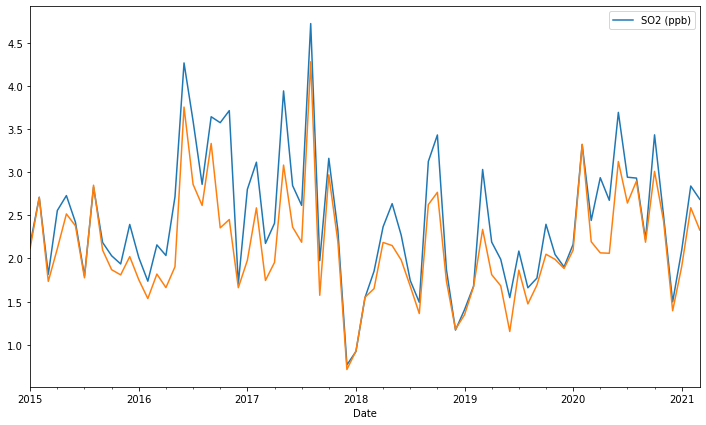

In [ ]:
A = 'M'
df1_w['SO2 (ppb)'].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c['SO2 (ppb)'].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

97.08835535607189


[0]	validation_0-rmse:5.679
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:5.53538
[2]	validation_0-rmse:5.4153
[3]	validation_0-rmse:5.30838
[4]	validation_0-rmse:5.2197
[5]	validation_0-rmse:5.13989
[6]	validation_0-rmse:5.0701
[7]	validation_0-rmse:5.0188
[8]	validation_0-rmse:4.9697
[9]	validation_0-rmse:4.92358
[10]	validation_0-rmse:4.88364
[11]	validation_0-rmse:4.85329
[12]	validation_0-rmse:4.8241
[13]	validation_0-rmse:4.79316
[14]	validation_0-rmse:4.76721
[15]	validation_0-rmse:4.74259
[16]	validation_0-rmse:4.72141
[17]	validation_0-rmse:4.70653
[18]	validation_0-rmse:4.69138
[19]	validation_0-rmse:4.6745
[20]	validation_0-rmse:4.66083
[21]	validation_0-rmse:4.64931
[22]	validation_0-rmse:4.6432
[23]	validation_0-rmse:4.63275
[24]	validation_0-rmse:4.61473
[25]	validation_0-rmse:4.60599
[26]	validation_0-rmse:4.60033
[27]	validation_0-rmse:4.59497
[28]	validation_0-rmse:4.58469
[29]	validation_0-rmse:4.57072
[30]	validation_0-rmse:4.

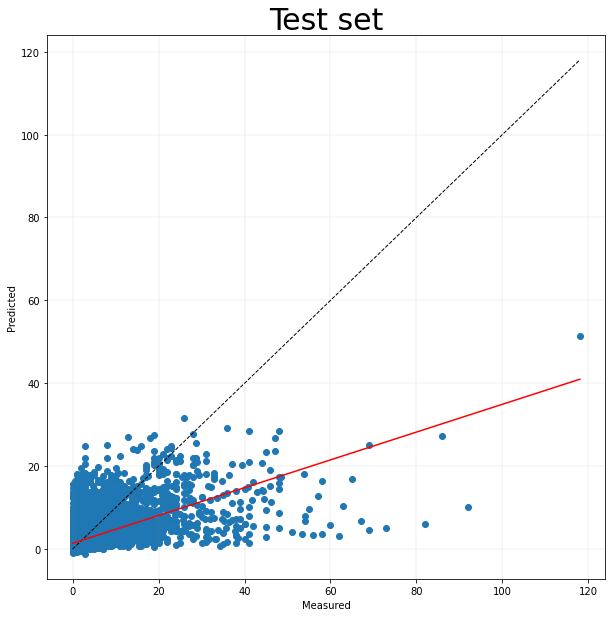

[0.33536694 1.4012805 ]
RMSE
[4.31911646]
R2
0.3562696407543955


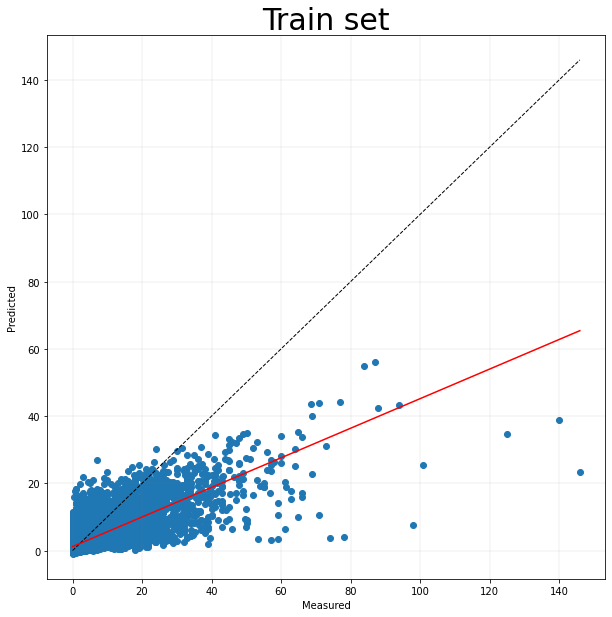

[0.44004152 1.17981631]
RMSE
[3.78177048]
R2
0.5421415775685847


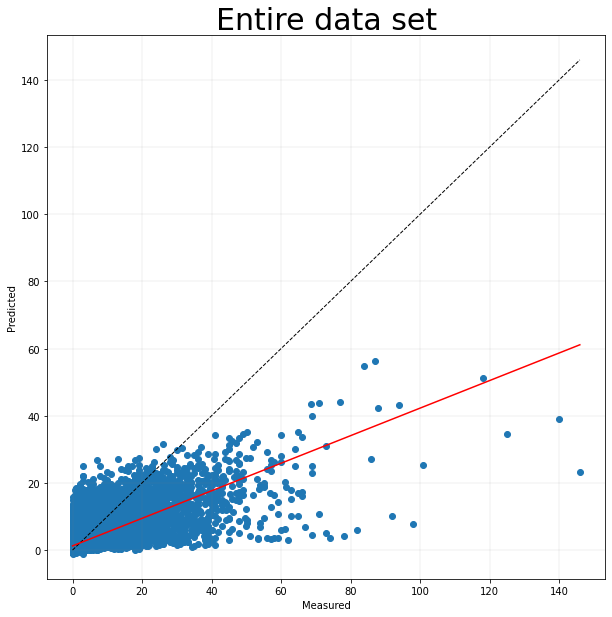

[0.41025945 1.2449473 ]
RMSE
[3.95066463]
R2
0.4892936198173299


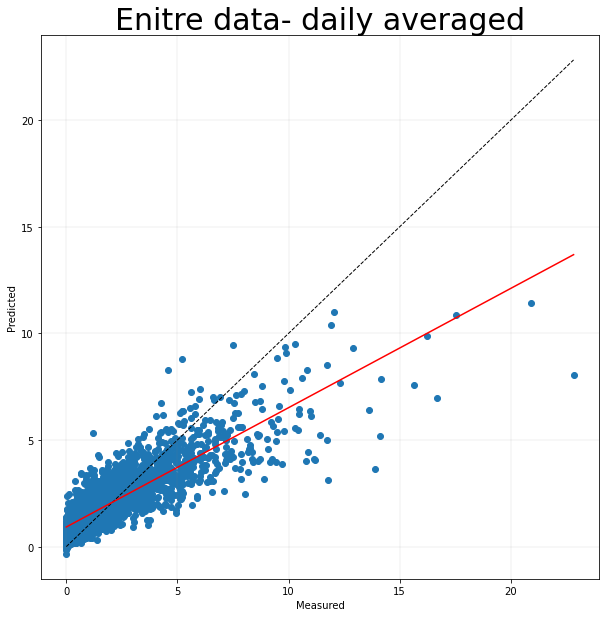

[0.55951361 0.92032765]
RMSE
[1.37208962]
R2
0.6837742997122415


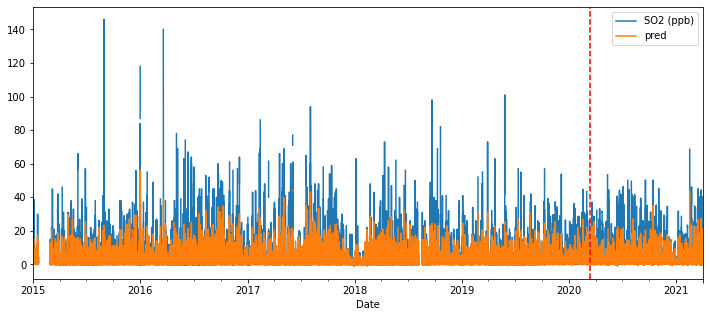

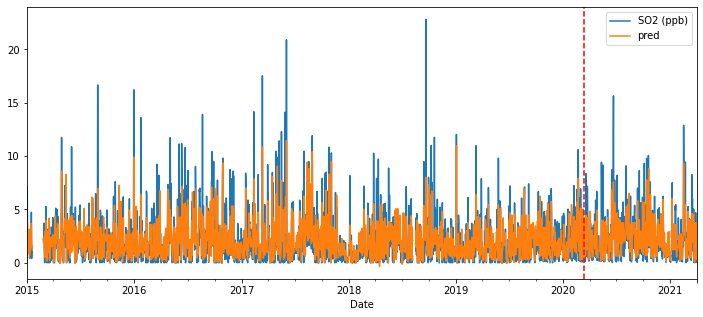

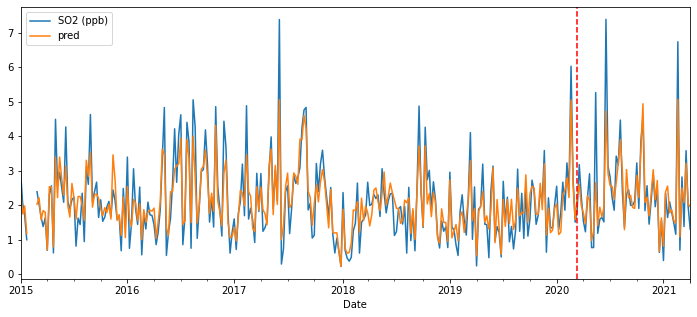

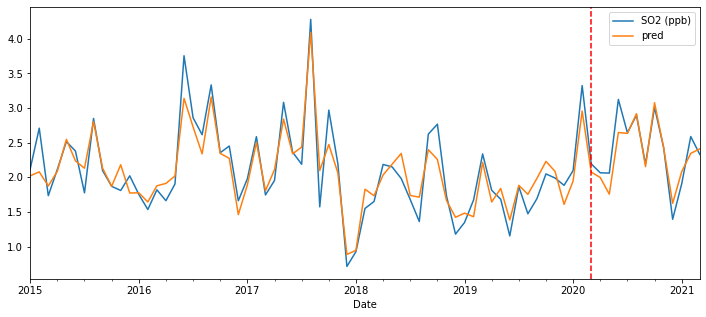

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_OT_XG_Test.csv')


[3.78177048]
0.5421415775685847
[4.31911646]
0.3562696407543955


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
179
1.5265066623687744
2021-01-18 06:00:00
179
1.581389307975769
2021-01-18 07:00:00
180
1.4882118701934814
2021-01-18 08:00:00
180
1.6418392658233643
2021-01-18 09:00:00
178
1.5782556533813477
2021-01-18 10:00:00
175
1.7001444101333618
2021-01-18 11:00:00
174
2.037841558456421
2021-01-18 12:00:00
170
2.0106494426727295
2021-01-18 13:00:00
169
2.2687594890594482
2021-01-18 14:00:00
174
2.885178804397583
2021-01-18 15:00:00
173
2.9035792350769043
2021-01-18 16:00:00
174
2.6410744190216064
2021-01-18 17:00:00
179
2.289839744567871
2021-01-18 18:00:00
179
1.9029964208602905
2021-01-18 19:00:00
183
2.1776881217956543
2021-01-18 20:00:00
183
2.0129425525665283
2021-01-18 21:00:00
182
1.981399655342102
2021-01-18 22:00:00
182
1.7163785696029663
2021-01-18 23:00:00
183
1.8081797361373901
2021-01-19 00:00:00
182
1.5629900693893433
2021-01-19 01:00:00
182
1.6145460605621338
2021-01-19 02:00:00
181
1.454400658607483
2021-01-19 03:00:00
182
1.508

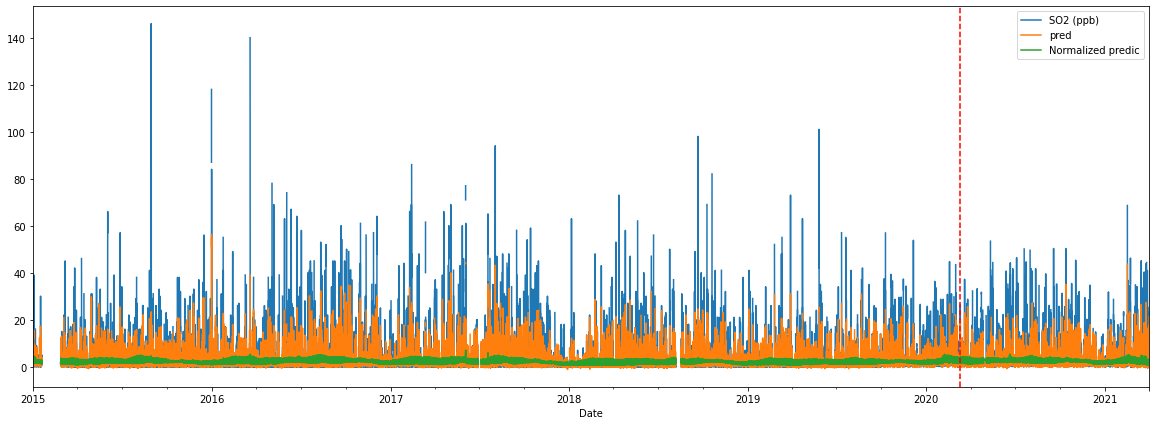

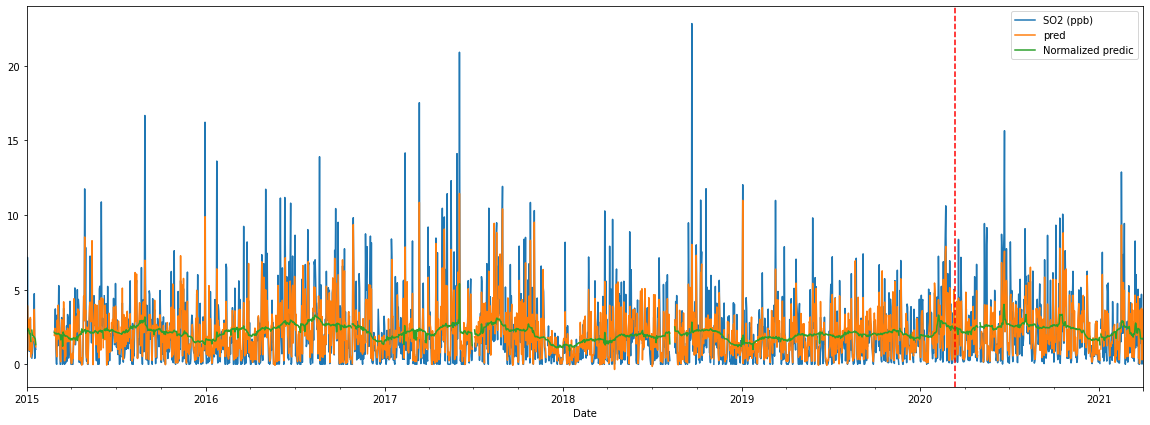

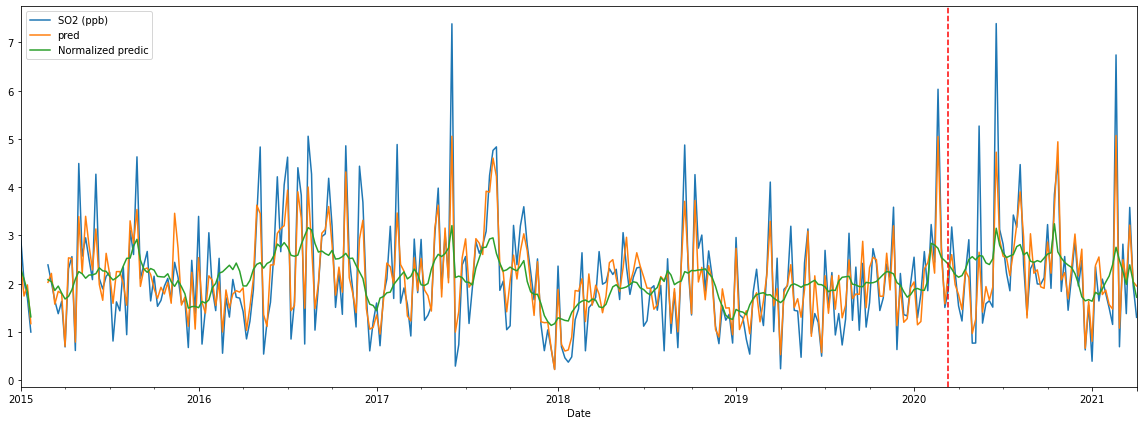

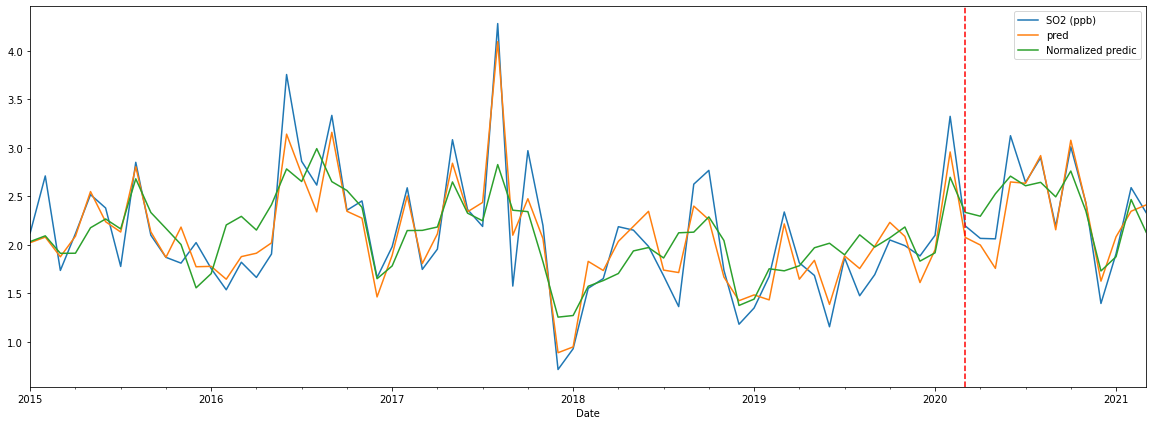

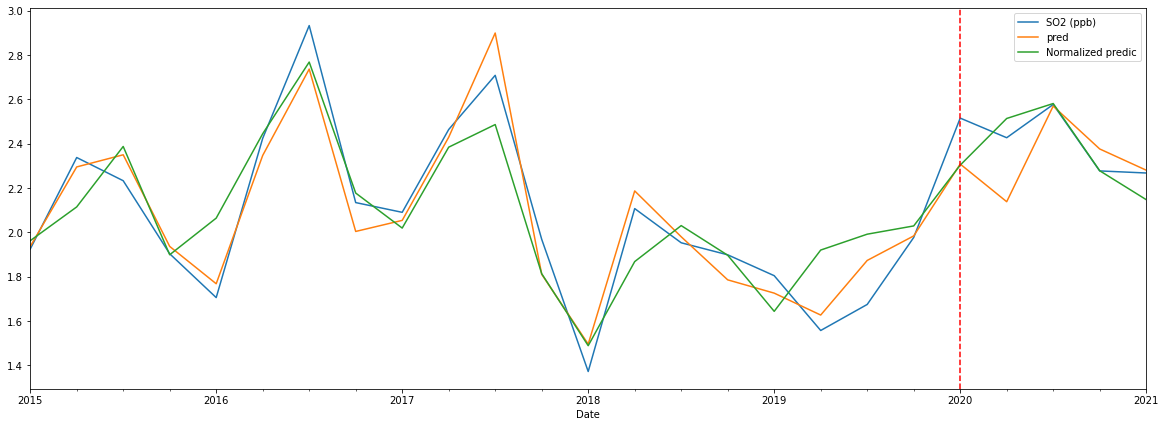

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_2015Real_RH_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_2015Real_RH_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Lower_Camp_2015Real_RH_SO2_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

5.696964172367998 4.783614655325343


In [ ]:
df1_w

SO2 (ppb)  T ( C)  RH %  ...  Day-year      trend      score
Date                                          ...                                
2015-01-01 00:00:00        0.0   -13.1  85.0  ...         1  15.000000   9.958333
2015-01-01 01:00:00        0.0   -13.4  81.0  ...         1  15.000114   8.478571
2015-01-01 02:00:00        0.0   -13.9  78.0  ...         1  15.000228   3.699048
2015-01-01 03:00:00        0.0   -14.4  77.0  ...         1  15.000342   5.956038
2015-01-01 04:00:00        0.0   -14.6  78.0  ...         1  15.000455  10.314286
...                        ...     ...   ...  ...       ...        ...        ...
2021-03-31 19:00:00        3.8     2.3  71.5  ...        90  21.245332   6.136870
2021-03-31 20:00:00       23.2     3.1  66.8  ...        90  21.245446   6.066667
2021-03-31 21:00:00       48.1     5.7  47.6  ...        90  21.245560  20.311667
2021-03-31 22:00:00       25.2     5.7  46.0  ...        90  21.245674  14.442105
2021-03-31 23:00:00        7.5     4.9  48.5  ...        90  21.245788   2.383951

[51689 rows x 15 columns]

In [ ]:
df1_w

SO2 (ppb)  T ( C)  RH %  ...  Day-year      trend      score
Date                                          ...                                
2015-01-01 00:00:00        0.0   -13.1  85.0  ...         1  15.000000   9.958333
2015-01-01 01:00:00        0.0   -13.4  81.0  ...         1  15.000114   8.478571
2015-01-01 02:00:00        0.0   -13.9  78.0  ...         1  15.000228   3.699048
2015-01-01 03:00:00        0.0   -14.4  77.0  ...         1  15.000342   5.956038
2015-01-01 04:00:00        0.0   -14.6  78.0  ...         1  15.000455  10.314286
...                        ...     ...   ...  ...       ...        ...        ...
2021-03-31 19:00:00        3.8     2.3  71.5  ...        90  21.245332   6.136870
2021-03-31 20:00:00       23.2     3.1  66.8  ...        90  21.245446   6.066667
2021-03-31 21:00:00       48.1     5.7  47.6  ...        90  21.245560  20.311667
2021-03-31 22:00:00       25.2     5.7  46.0  ...        90  21.245674  14.442105
2021-03-31 23:00:00        7.5     4.9  48.5  ...        90  21.245788   2.383951

[51689 rows x 15 columns]

##ANN

In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
       
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)


        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        # self.X_train =self.X
        # self.y_train =self.Y
        self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.3, random_state = 42)
          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/Lowercamp_SO2" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
# objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
# study = optuna.create_study(direction=optimizer_direction, study_name='LowerCamp_sc1__NN', storage='sqlite:///LowerCamp__sc1__NN.db',
#                             load_if_exists=True)
# study.optimize(objective, n_trials=1000)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_OT_Lower Campd_Lake_SO2_2015_HP_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

In [ ]:
study.best_trials

[FrozenTrial(number=341, values=[20.54419369419599], datetime_start=datetime.datetime(2021, 5, 16, 6, 35, 13, 568892), datetime_complete=datetime.datetime(2021, 5, 16, 6, 36, 25, 294014), params={'score': 15.525135627134162, 'layers': 3, 'alpha': 0.10756807224112087, 'batchsize': 3600.0, 'num_dense_nodes1': 37, 'delta': 22.60320023136335, 'learning_rate': 0.05760556040551617, 'drop_out1': 0.051637278279445316, 'num_dense_nodes2': 37, 'drop_out2': 0.12825665296761063, 'num_dense_nodes3': 18, 'drop_out3': 0.37453311487913743}, distributions={'score': UniformDistribution(high=29.615037448994716, low=15.264193483018683), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': U

In [ ]:
study.best_params

{'alpha': 0.10756807224112087,
 'batchsize': 3600.0,
 'delta': 22.60320023136335,
 'drop_out1': 0.051637278279445316,
 'drop_out2': 0.12825665296761063,
 'drop_out3': 0.37453311487913743,
 'layers': 3,
 'learning_rate': 0.05760556040551617,
 'num_dense_nodes1': 37,
 'num_dense_nodes2': 37,
 'num_dense_nodes3': 18,
 'score': 15.525135627134162}

In [ ]:
best_params = {'alpha': 0.10756807224112087,
 'batchsize': 3600.0,
 'delta': 22.60320023136335,
 'drop_out1': 0.051637278279445316,
 'drop_out2': 0.12825665296761063,
 'drop_out3': 0.37453311487913743,
 'layers': 3,
 'learning_rate': 0.05760556040551617,
 'num_dense_nodes1': 37,
 'num_dense_nodes2': 37,
 'num_dense_nodes3': 18,
 'score': 15.525135627134162}  #number=341, values=[20.54419369419599]

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_2015RealRH_outlier_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)



maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

97.10770183211127


{'alpha': 0.10756807224112087,
 'batchsize': 3600.0,
 'delta': 22.60320023136335,
 'drop_out1': 0.051637278279445316,
 'drop_out2': 0.12825665296761063,
 'drop_out3': 0.37453311487913743,
 'layers': 3,
 'learning_rate': 0.05760556040551617,
 'num_dense_nodes1': 37,
 'num_dense_nodes2': 37,
 'num_dense_nodes3': 18,
 'score': 15.525135627134162}

In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
8/8 - 1s - loss: 14.2043 - val_loss: 14.3547
Epoch 2/250
8/8 - 0s - loss: 13.6502 - val_loss: 13.5806
Epoch 3/250
8/8 - 0s - loss: 12.7197 - val_loss: 13.1692
Epoch 4/250
8/8 - 0s - loss: 12.1513 - val_loss: 12.9278
Epoch 5/250
8/8 - 0s - loss: 11.8186 - val_loss: 13.9718
Epoch 6/250
8/8 - 0s - loss: 11.0773 - val_loss: 14.8310
Epoch 7/250
8/8 - 0s - loss: 10.6151 - val_loss: 14.6677
Epoch 8/250
8/8 - 0s - loss: 10.5570 - val_loss: 14.3505
Epoch 9/250
8/8 - 0s - loss: 10.4553 - val_loss: 14.3926
Epoch 10/250
8/8 - 0s - loss: 10.2358 - val_loss: 14.0033
Epoch 11/250
8/8 - 0s - loss: 10.1248 - val_loss: 14.2851
Epoch 12/250
8/8 - 0s - loss: 10.0142 - val_loss: 15.4549
Epoch 13/250
8/8 - 0s - loss: 9.9550 - val_loss: 16.7967
Epoch 14/250
8/8 - 0s - loss: 9.8298 - val_loss: 21.3425
Epoch 15/250
8/8 - 0s - loss: 9.7929 - val_loss: 18.2552
Epoch 16/250
8/8 - 0s - loss: 9.6935 - val_loss: 17.7137
Epoch 17/250
8/8 - 0s - loss: 9.8556 - val_loss: 16.8501
Epoch 18/250
8/8 - 0s - loss

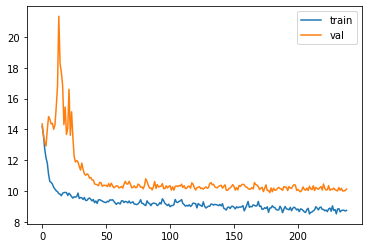

Model: "sequential_757"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_756 (Bat (None, 13)                52        
_________________________________________________________________
dense_2990 (Dense)           (None, 37)                518       
_________________________________________________________________
leaky_re_lu_2990 (LeakyReLU) (None, 37)                0         
_________________________________________________________________
dropout_2234 (Dropout)       (None, 37)                0         
_________________________________________________________________
dense_2991 (Dense)           (None, 37)                1406      
_________________________________________________________________
leaky_re_lu_2991 (LeakyReLU) (None, 37)                0         
_________________________________________________________________
dropout_2235 (Dropout)       (None, 37)             

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_SO2_Lower Camp_2012_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/Lower Camp_OT2012_SO2.h5'
model_NN.save(precovid_model )

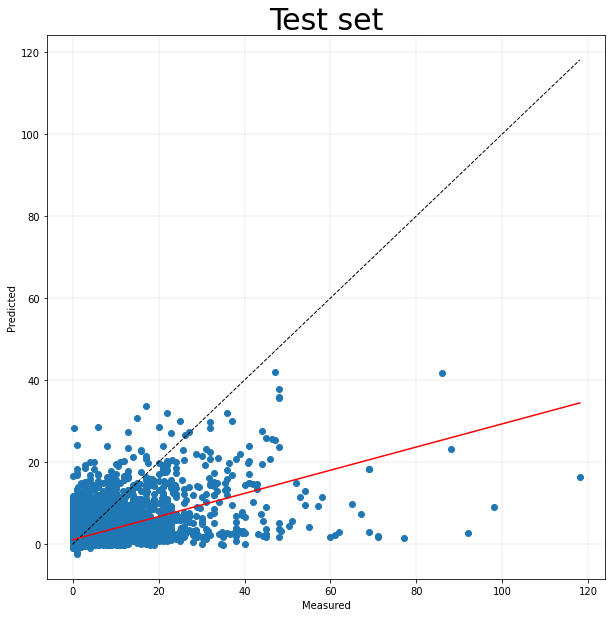

[0.28257169 1.09918965]
RMSE
[4.69257265]
R2
0.30015808190038107


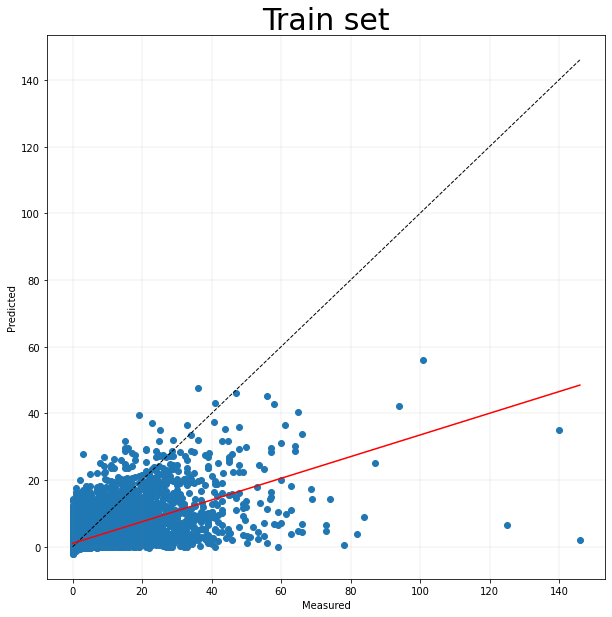

[0.3250098  1.04464374]
RMSE
[4.4055846]
R2
0.3570027880589949


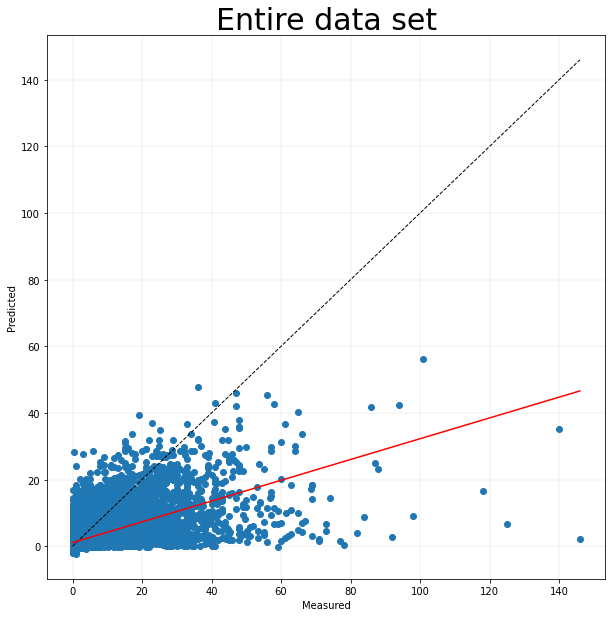

[0.31189885 1.06160568]
RMSE
[4.49361058]
R2
0.339451499825167


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_757"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_756 (Bat (None, 13)                52        
_________________________________________________________________
dense_2990 (Dense)           (None, 37)                518       
_________________________________________________________________
leaky_re_lu_2990 (LeakyReLU) (None, 37)                0         
_________________________________________________________________
dropout_2234 (Dropout)       (None, 37)                0         
_________________________________________________________________
dense_2991 (Dense)           (None, 37)                1406      
_________________________________________________________________
leaky_re_lu_2991 (LeakyReLU) (None, 37)                0         
_________________________________________________________________
dropout_2235 (Dropout)       (None, 37)             

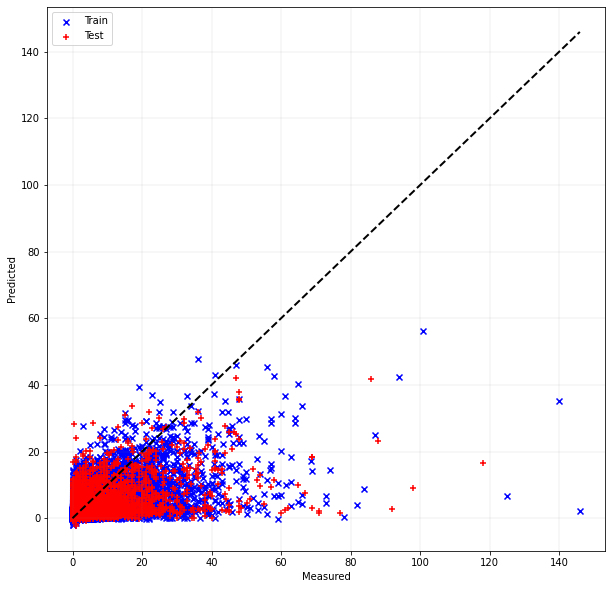

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

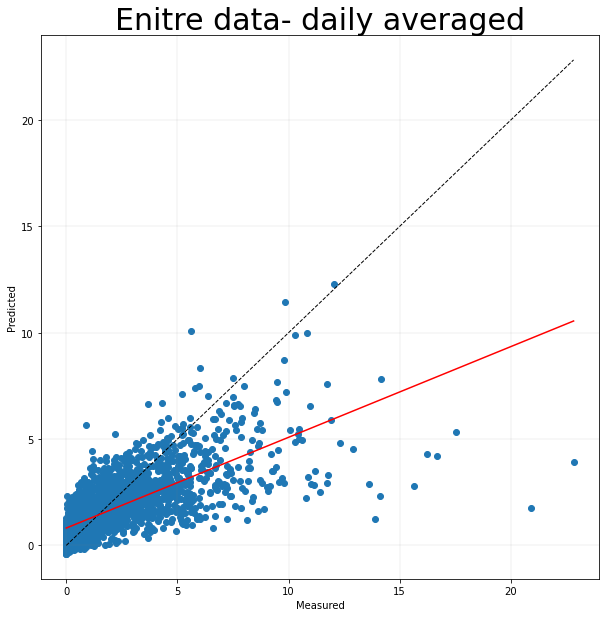

[0.42641746 0.81739435]
RMSE
[1.80365068]
R2
0.45380252659178


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

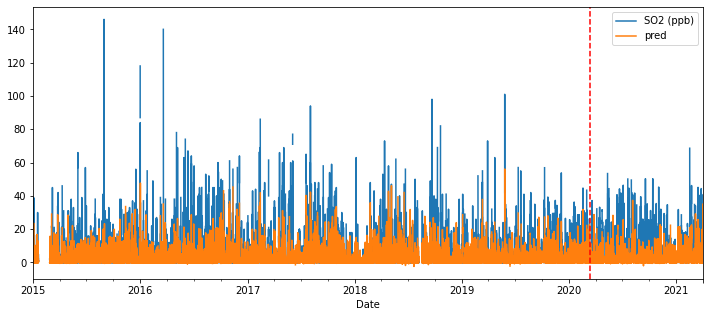

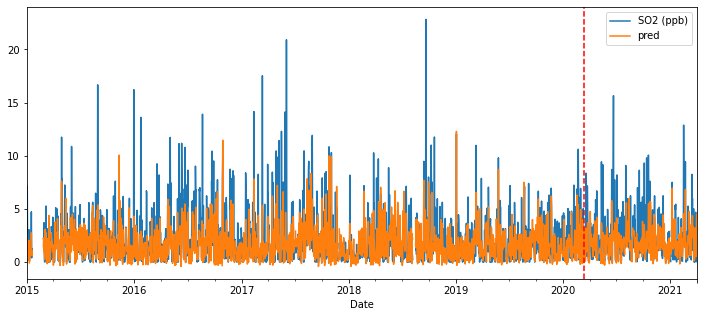

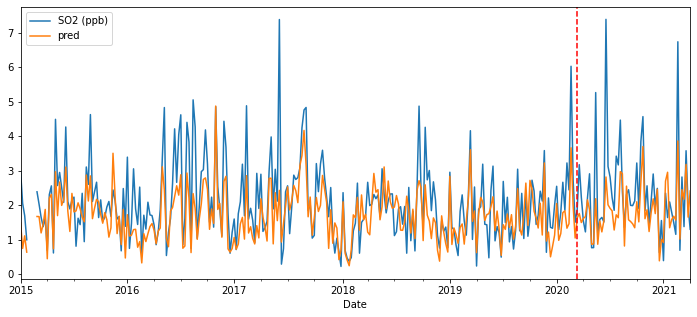

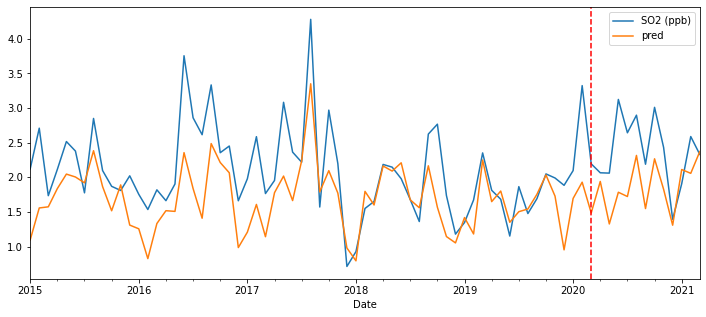

In [ ]:
df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[4.4055846]
0.3570027880589949


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[4.69257265]
0.30015808190038107


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = ['T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/LowerCamp_NN_OR_Test.csv')

[4.4055846]
0.3570027880589949
[4.69257265]
0.30015808190038107


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
179
1.420954942703247
2021-01-18 06:00:00
179
1.5554509162902832
2021-01-18 07:00:00
180
1.5331295728683472
2021-01-18 08:00:00
180
1.5885769128799438
2021-01-18 09:00:00
178
1.519392490386963
2021-01-18 10:00:00
175
1.5954509973526
2021-01-18 11:00:00
174
1.9419108629226685
2021-01-18 12:00:00
170
2.055673122406006
2021-01-18 13:00:00
169
2.2386891841888428
2021-01-18 14:00:00
174
2.5965094566345215
2021-01-18 15:00:00
173
2.878357410430908
2021-01-18 16:00:00
174
2.4945805072784424
2021-01-18 17:00:00
179
2.2046499252319336
2021-01-18 18:00:00
179
1.951151728630066
2021-01-18 19:00:00
183
2.253690719604492
2021-01-18 20:00:00
183
2.217578172683716
2021-01-18 21:00:00
182
2.163479804992676
2021-01-18 22:00:00
182
2.0258257389068604
2021-01-18 23:00:00
183
2.1336581707000732
2021-01-19 00:00:00
182
1.2189589738845825
2021-01-19 01:00:00
182
1.2428349256515503
2021-01-19 02:00:00
181
1.153190016746521
2021-01-19 03:00:00
182
1.298102378

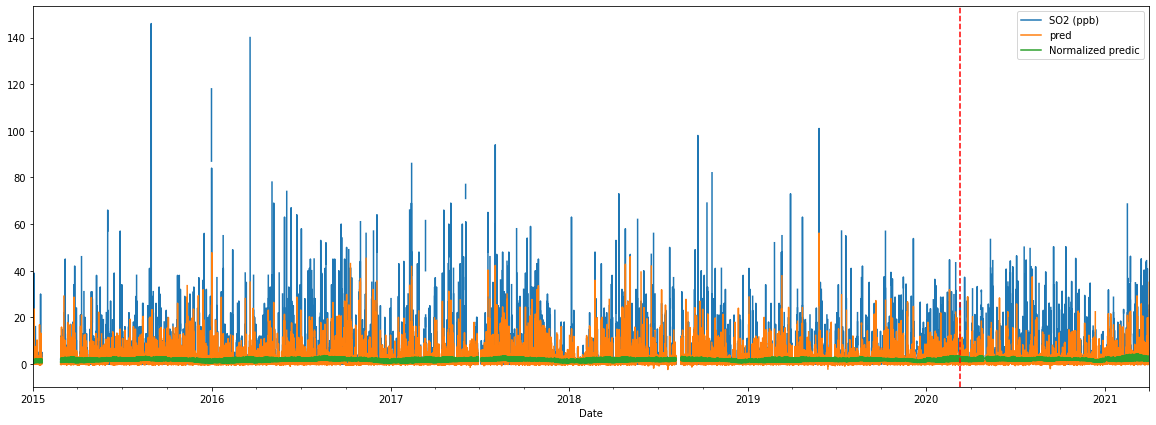

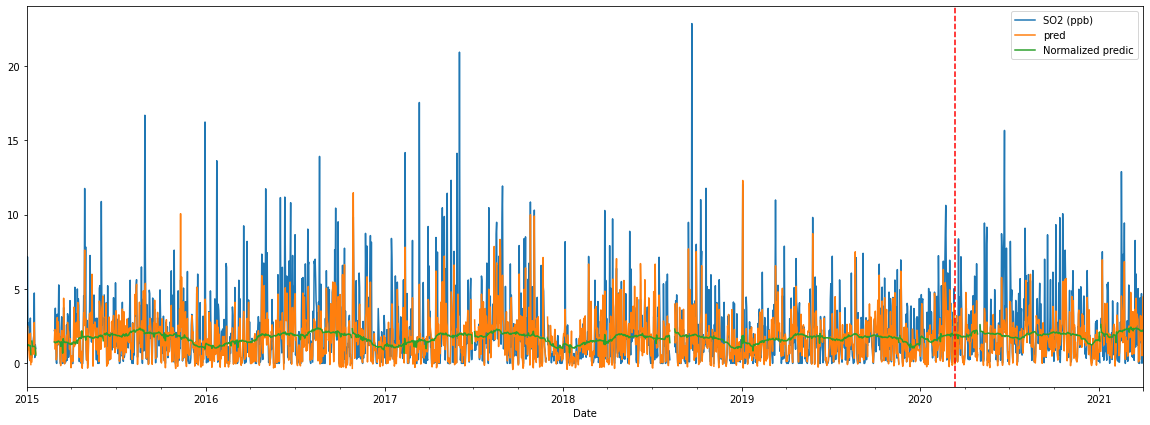

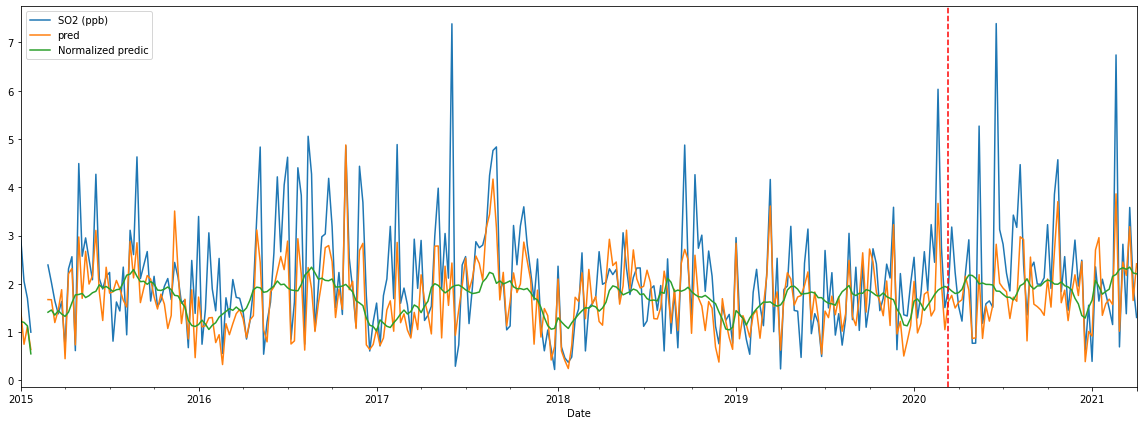

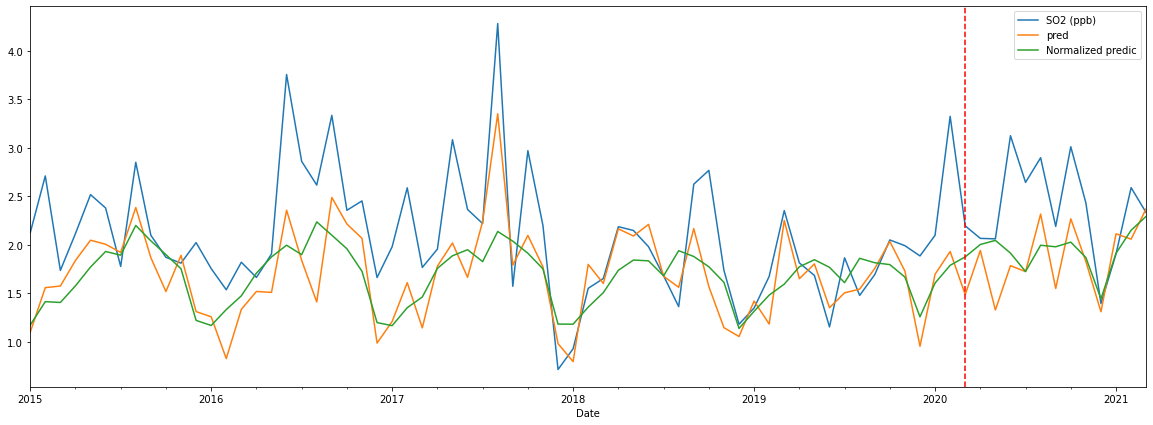

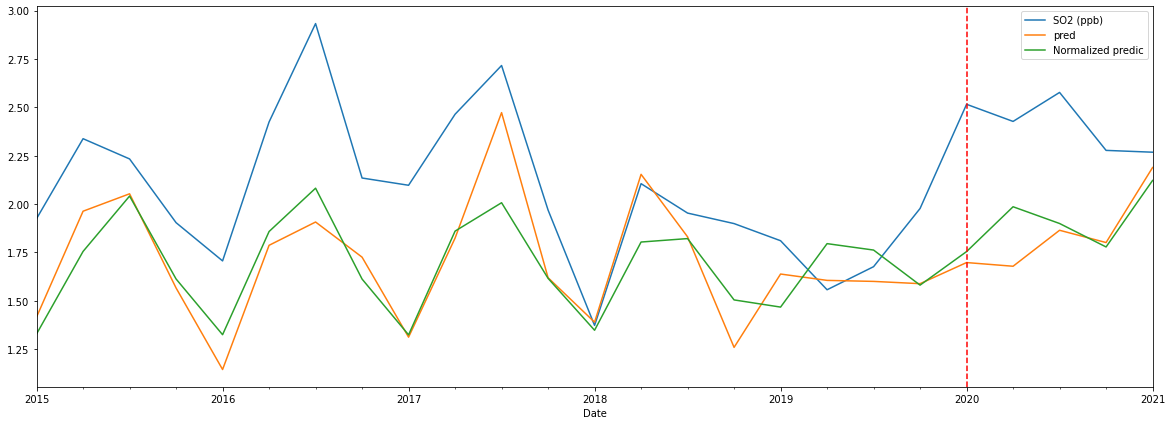

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCampe_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_LowerCamp_SO2_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

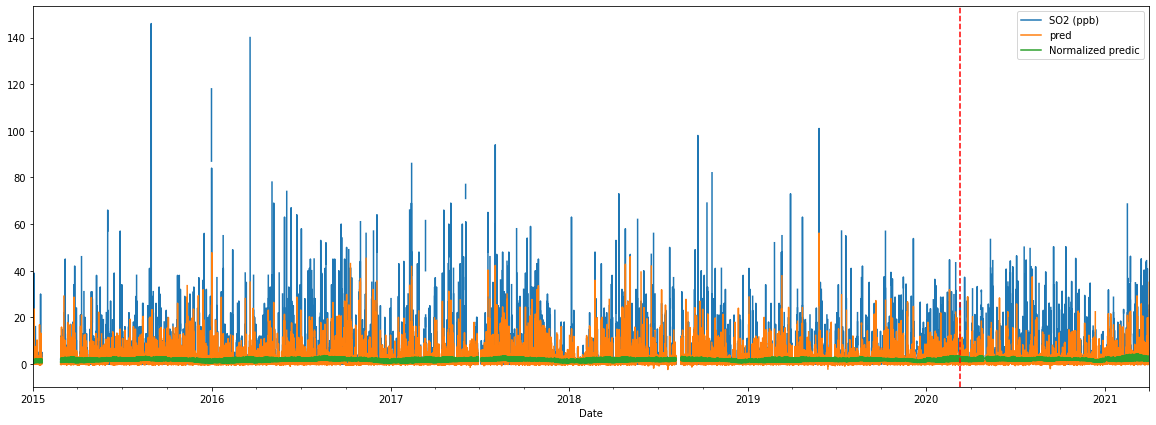

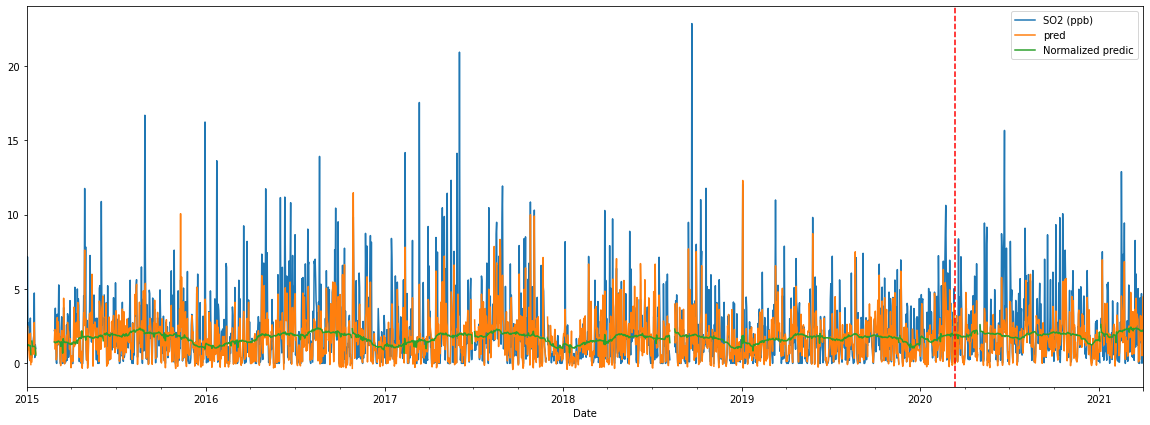

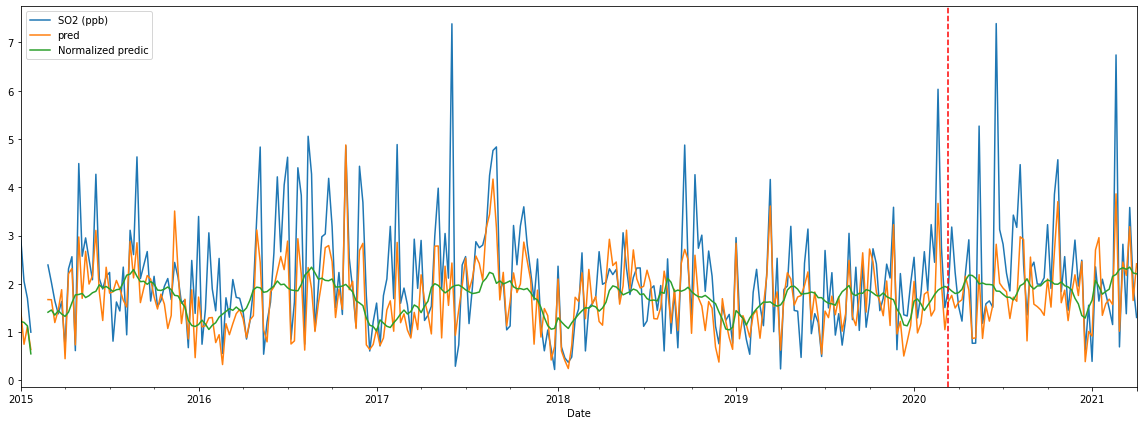

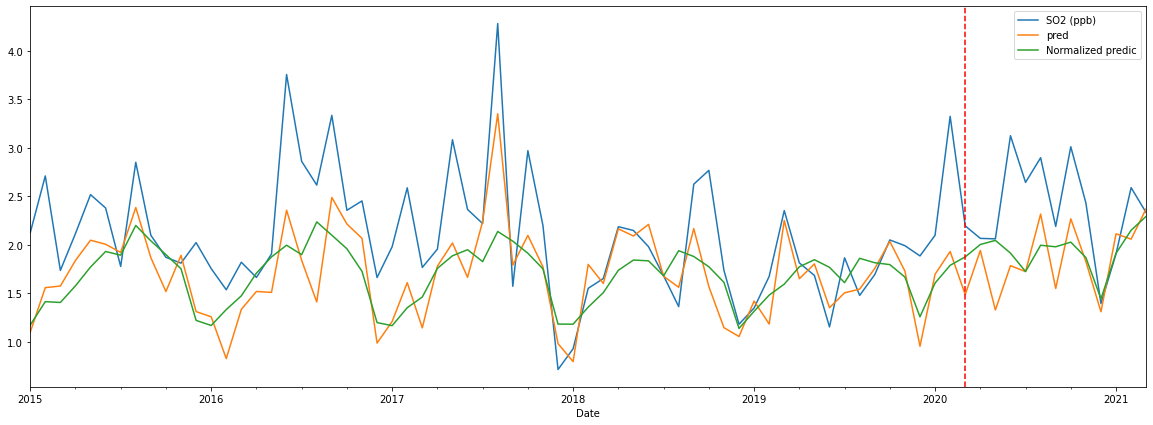

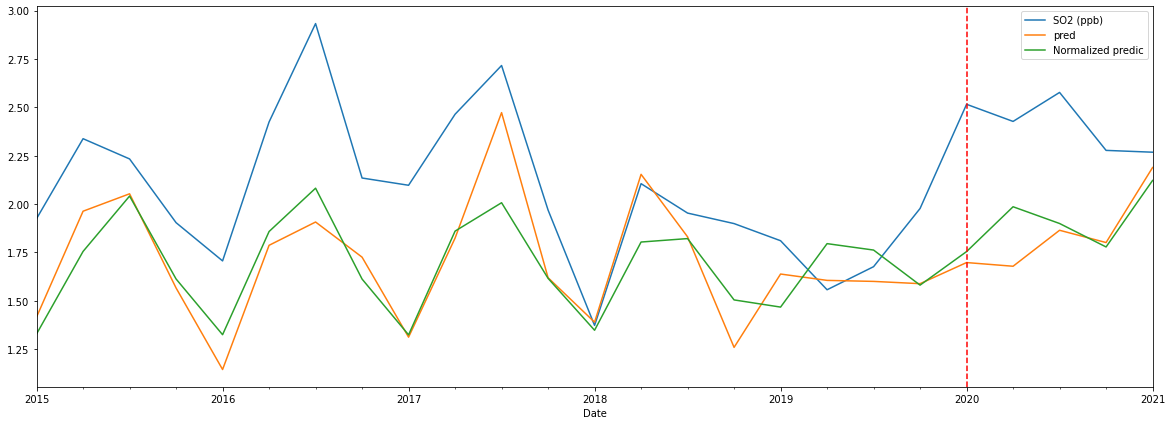

In [ ]:
for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

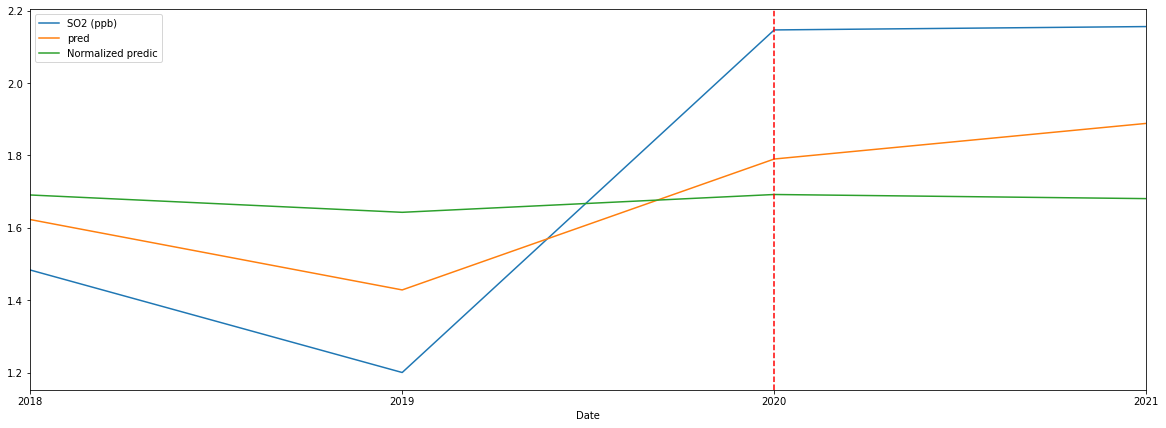

In [ ]:
df4_h['SO2 (ppb)'].resample('Y').mean().loc['2018':].plot(legend= True)
df4_h['pred'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
df4_h['Normalized predic'].resample('Y').mean().loc['2018':].plot(legend= True,figsize = (20,7))
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
####